# TR.AI.NS Project


## Condition Simulations

This notebook is designed to simulate how the client average waiting time and total train covered distance are affected by the the variation of the number of trains and the client broadcast radius. 

For this simulation it is specified that the frequency of clients is set to 25 (this parameter is explained further below), the step speed is 2 s/step and the train speed is 20 m/s.

Here we present 49 simulations, with the number of trains varying from 4 to 10 trains, and the broadcast radius is specified as $ r = m_d i/10 $, where $ m_d $ is the map diagonal (i.e., the diagonal of the smallest rectangle that encompasses the whole map) and $ i $ is an integer between 4 and 10. The simulations terminate when the trains manage to deliver 15 clients to their desired destinations. Each simulation is repeated 60 times, to average over the random arrivals of clients.

The map used to run the simulations is saved in the library folder, with the name of "mapBig", which is presented in the simulations below (the map is printed before the simulation loop starts). Alternatively, one can check the map files in the project folder.

This test has been run using version 3.4 of the code, written in Python 3.7.

---

## Packages

In [1]:
# Library import

libFolder = "TR.AI.NS" # Library name

import sys, os
sys.path.append( os.path.join(os.path.dirname(sys.path[0])) + "/" + libFolder )


from Train import Train
from Client import Client, CliModes
from Network import Network

import csv
import numpy as np
from random import randint
import time
import matplotlib.pyplot as plt
from math import sqrt
import pandas as pd

## Parameters

In [2]:
# Setting the simulation conditions

mapPath = "../TR.AI.NS/mapBig"    # Map file path

cliDataFile = "datasets/normal_mapBig_60rep_2000iter.npz"

total_steps_run = -1              # Variable to limit the amount of simulation loops to be performed
total_clients_finished = 60       # Variable to limit the amount of clients to be delivered

simRepeat = 20                     # Number of times each simulation is repeated (to garner statistics)

frequency_of_clients = 20    # Parameter to determine the client frequency

trainSpeed = 20         # Speed the trains moves in the railway network the map (m/s)

logName = "/Volumes/Amy's HDD/TCC - TRAINS/log_simulation-nTrains-broadRadius-v3.4.txt"     # Output log file. Stores all states of all trains and 
                                                # clients during each simulation loop

## Pre-processing

In [3]:
# Performance testing variables

n_trains = []
c_radius = []

m_del_time = {}
d_del_time = {}

m_wait_time = {}
d_wait_time = {}

m_answ_time = {}
d_answ_time = {}

m_train_dist = {}
d_train_dist = {}

client_time = []
client_pos = []

In [4]:
# Auxiliary classes

class Simulation:
    def __init__(self):
        self.devices = []
        self.trainRange = 0
        self.clientRange = 0

Reading map file (../TR.AI.NS/mapBig)
	Going over graph info
	 - Map contains 21 vertices and 26 edges
	Going over vertices positions
	 - Got positions of the 21 vertices. 5 are stations
	Going over graph edges
	 - Read over 26 edges in graph


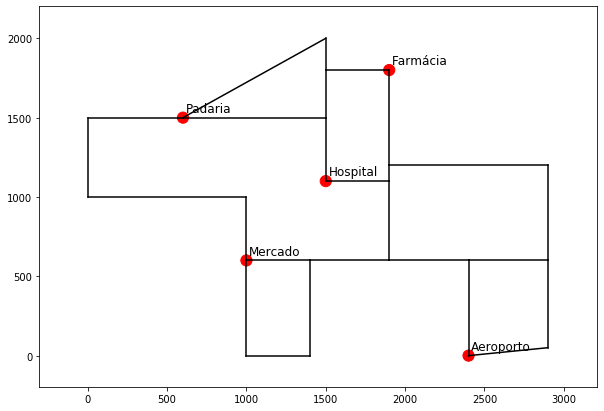

Figure 1: Map of the 'mapBig' file, that is being used in this notebook as the track/station system the trains transit in


In [5]:
# Loading map

print("Reading map file (%s)" % mapPath)

# Getting CSV file names
graphInfo = "%s/Sheet 1-Graph Info.csv" % mapPath
vertices = "%s/Sheet 1-Vertices Positions.csv" % mapPath
connections = "%s/Sheet 1-Connection Matrix.csv" % mapPath


# Reading Graph Info table
print("\tGoing over graph info")

nVertices = 0
nEdges = 0
map_size = 0
with open(graphInfo) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            if not row[0] == "Number of vertices":
                raise Exception("Wrong input file format. See map input format")
            nVertices = int(row[1])
        elif line_count == 1:
            if not row[0] == "Number of connections":
                raise Exception("Wrong input file format. See map input format")
            nEdges = int(row[1])
        else:
            if not row[0] == "Map size":
                raise Exception("Wrong input file format. See map input format")
            map_size = float(row[1])
        line_count += 1
                                
    print("\t - Map contains %d vertices and %d edges" % (nVertices, nEdges))

# Reading Vertices Positions table
print("\tGoing over vertices positions")
                                
vert_pos = []
stoppingPoints = {}
stoppingPointsPos = []
with open(vertices) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    line_count = -1
    for row in csv_reader:
        if line_count == -1:
            line_count += 1
            continue
        vert_pos += [(float(row[1]), float(row[2]))]
        if row[0][0] != "_":
            stoppingPoints[row[0]] = line_count
            stoppingPointsPos += [(float(row[1]), float(row[2]))]
        line_count += 1
    if line_count != nVertices:
        raise Exception("Wrong input file format. The number of vertices given doesn't match the number of vertices specified")
    print("\t - Got positions of the %d vertices. %d are stations" %
          (nVertices, len(stoppingPoints.keys())))
                                
# Reading Connection Matrix table
print("\tGoing over graph edges")
                                
edges = np.ndarray(shape=(nVertices, nVertices), dtype=float)
edges.fill(-1)
                                
# Availability dictionary
availability = {}
                                
with open(connections) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    line_count = 0
    edge_count = 0
    for row in csv_reader:
        for i in range(nVertices):
            if row[i] != "":
                edges[line_count][i] = float(row[i])
                if line_count != i:
                    a = max(line_count, i)
                    b = min(line_count, i)
                    availability[ (a, b) ] = True
                if line_count > i:
                    edge_count += 1
        line_count += 1
    if nEdges != edge_count:
        raise Exception("Wrong input file format. Number of edges given doesn't match the specified number")
    print("\t - Read over %d edges in graph" % edge_count)

    
# Printing the map
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
ax.axis('equal')

nEdgesDrawn = 0
for i in range(nVertices):
    for j in range(nVertices):
        if j >= i:
            break
        if edges[i][j] > 0:
            ax.plot([vert_pos[i][0], vert_pos[j][0]], [vert_pos[i][1], vert_pos[j][1]], 'k', zorder=-4)
            nEdgesDrawn += 1

xmin, xmax, ymin, ymax = ax.axis()
scale = (ymax-ymin) * .016  # Scale fator to print visible circles
for ponto in stoppingPoints.keys():
    pos = vert_pos[stoppingPoints[ponto]]
    c = plt.Circle(pos, radius=scale, color='r', zorder=-5)
    ax.add_patch(c)
    ax.text(pos[0] + scale*.5, pos[1] + scale, ponto, fontsize=12, wrap=True, zorder=-3)

xmin, xmax, ymin, ymax = ax.axis()
diverge = .05
xmin = xmin - (xmax - xmin) * diverge
xmax = xmax + (xmax - xmin) * diverge
ymin = ymin - (ymax - ymin) * diverge
ymax = ymax + (ymax - ymin) * diverge
ax.axis([xmin, xmax, ymin, ymax])

plt.show()
print("Figure 1: Map of the 'mapBig' file, that is being used in this notebook as the track/station system the trains transit in")

In [6]:
# Loading client creation dataset

client_dataset = np.load(cliDataFile)
client_creation = client_dataset.get("client")
client_position = client_dataset.get("init_stat")
client_destination = client_dataset.get("fin_stat")

## Experimental determination of the train request reception radius

Text commenting experiments can be checked in the original notebook.

<!--- Through experimentation and analysis simulation implemented and the map that is currently being used, it soon became clear that just applying ten numbers evenly distributed between 0 and 1 to the range parameter wouldn't be a very good way to make this test. The radius of one tenth of the map radius reaches only approximately $353\,$m (since the diagonal of this map has $3522,78\,$m). This distance, with this road configuration, is not enough to even reach the edges adjacent to the stopping points. This means that only trains that pass directly over the stopping points will be able to receive the requests, and therefore this radius is not coherent with this simulation. --->

<!--- Through experimentation it was verified that, for a minimum of 5 trains, a radius of 1057$~$m (30% of the map diagonal) made it possible for the system to deliver the 15 clients in every simulation. To make this possible, since in this case too much relies on the luck that the starting point of the train will be close enough to a stopping point (otherwise the train would never receive any client request at all), it was stipulated that, for this test, the trains will all be given initial positions at stopping points. It is only logical that this would many times make the system more efficient, considering these are the points the requests will be handled in regardless. This test is also made so that, once the first 15 clients are put into the simulation, no other clients are created. So it is guaranteed that for the simulation to finish successfully, every client must be delivered to their stopping point. --->

In [7]:
# NUMBER OF TRAINS:
n_trains = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
#------------------
# CLIENT RANGE
c_radius = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
#------------------
step_speed = 1               # Passage of time for each simulation loop (s/step)

In [8]:
# Creating simulations log file

# logFile = open(logName, "w")

In [9]:
for clientRange in c_radius:
    m_del_time[clientRange] = []
    d_del_time[clientRange] = []
    m_wait_time[clientRange] = []
    d_wait_time[clientRange] = []
    m_answ_time[clientRange] = []
    d_answ_time[clientRange] = []
    m_train_dist[clientRange] = []
    d_train_dist[clientRange] = []
    
    # Creating Network
    sim = Simulation()
    net = Network(sim, log=False)
    sim.clientRange = int(map_size * clientRange)
    sim.trainRange = 3 * sim.clientRange
    
    for nTrains in n_trains:
        deliveryTimeList = []
        waitTimeList = []
        answTimeList = []
        trainDistanceRun = []

        for turn in range(simRepeat):
            print("Simulation with {} trains, range {}. Turn {}".format(nTrains, clientRange, turn+1))
            # Zeroing variables
            waitingTime = {}
            answerTime = {}
            deliveryTime = {}

            sim.devices = []

            for key in availability.keys():
                availability[key] = True

            # Creating train objects

            v_step = step_speed

            for i in range(nTrains):
                idx = randint(0, len(stoppingPointsPos) - 1)
                pos = stoppingPointsPos[ idx ]
                tr = Train(i, pos, v_step, mapPath, availability, net, vMax = trainSpeed, log=False)
                sim.devices += [tr]

            # Creating initial client conditions
            nClients = 0
            currCli = 0.5
            clientList = []
            outingClients = {}

            # Looping simulation

            simTime = 0
            out_file = ""
            finished = False

            while not finished:
                clockcount = simTime * v_step
                clockcount = float(clockcount)
                hour = int(clockcount // 3600)
                clockcount %= 3600
                minutes = int(clockcount // 60)
                clockcount %= 60
                seconds = int (clockcount)
                # print( "Simulation counter: {:02d}:{:02d}:{:02d} ({} iterations)".
                #                             format(hour, minutes, seconds, simTime) )

                # Creating random clients
                if currCli < total_clients_finished:
                    r = client_creation[turn][simTime]
                    if r % frequency_of_clients == 0:
                        init = client_position[turn][simTime]
                        fin = client_destination[turn][simTime]
                        if fin == init:
                            fin += 1
                            if fin == len(stoppingPointsPos):
                                fin = 0
                        pos = stoppingPointsPos[init]
                        dest = stoppingPointsPos[fin]
                        cl = Client(currCli, pos, dest, v_step, mapPath, net, log=False)
                        sim.devices += [cl]
                        clientList += [cl]
                        client_time += [simTime]
                        client_pos += [init]
                        currCli += 1

                # Run all devices
                for device in sim.devices:
                    device.step()

                for client in clientList:
                    # Remove clients from list
                    if client.mode == CliModes.dropoff:
                        if client not in outingClients.keys():
                            outingClients[client] = 0
                        else:
                            outingClients[client] += 1
                        if outingClients[client] >= 10:
                            # Getting client waiting time statistics
                            waitingTime[client.id] = client.waitingTime*step_speed
                            answerTime[client.id] = client.timeTillRequest*step_speed
                            deliveryTime[client.id] = client.serviceTime*step_speed

                            # Removing client from simulation
                            sim.devices.remove(client)
                            clientList.remove(client)
                            client.kill()
                            nClients += 1

                # Simulation log
                out_file += "Simulation step {}, timer {}\n".format(simTime, simTime*v_step)
                for device in sim.devices:
                    out_file += "\tDevice {}, mode {}: position {}\n".format(device.id, device.mode, device.pos)
                    if isinstance(device, Train):
                        out_file += "\t  Processing request {}\n".format(device.unprocessedReqs)
                        out_file += "\t  Path {}\n".format(device.path)
                        out_file += "\t  Clients list {}\n".format(device.client)
                    elif isinstance(device, Client):
                        out_file += "\t  Destination: {}.\n".format(device.destiny)
                        out_file += "\t  Train that will pick me up {}\n".format(device.train)
                out_file += "\n"

                # Simulation step counter
                simTime += 1

                # Check for simulation closure
                if total_steps_run != -1:
                    if simTime >= total_steps_run:
                        finished = True
                elif nClients != -1:
                    if nClients >= total_clients_finished:
                        finished = True

            print("Finished simulation!")
            out_file += "The end"
            
            # logFile.write("Test with {} trains, {}th attempt\n\n{}\n\n\n".format(nTrains, turn+1, out_file))


            # Waiting time statistics

            print("Total time waited by clients: {}".format(waitingTime))
            print("Time waited by clients until they got a train answer: {}".format(answerTime))

            print("Non serviced clients: ")
            for client in clientList:
                if client.mode not in [CliModes.moving, CliModes.dropoff]:
                    print("Client {} is in mode {} and has a total waiting time of {} simulation counts".\
                          format(client.id, client.mode, client.waitingTime))


            # Average waiting time
            sumTime = 0
            for value in waitingTime.values():
                sumTime += value

            waitTimeList += [ sumTime/len(waitingTime.keys()) ]

            sumTime = 0
            for value in answerTime.values():
                sumTime += value

            answTimeList += [ sumTime/len(answerTime.keys()) ]
            
            sumTime = 0
            for value in deliveryTime.values():
                sumTime += value
                
            deliveryTimeList += [ sumTime/len(deliveryTime.keys()) ]
            
            # TODO: Make version that is normalized by distance!

            print("Average waiting time for {} trains: {}".format(nTrains, waitTimeList[turn]))
            print("Serviced {} clients in {} simulation counts\n".format(len(waitingTime.keys()), simTime))

            # Train distances
            sumDistance = 0
            for dev in sim.devices:
                if isinstance(dev, Train):
                    sumDistance += dev.totalDistanceRun

            trainDistanceRun += [sumDistance]


        sizeLists = len(waitTimeList)
        sumTime = 0
        sumTime2 = 0
        sumTimeTot = 0
        sumDistance = 0

        for i in range(sizeLists):
            sumTime += waitTimeList[i]
            sumTime2 += answTimeList[i]
            sumTimeTot += deliveryTimeList[i]
            sumDistance += trainDistanceRun[i]

        meanDeliveryTime = sumTimeTot/sizeLists
        meanWaitTime = sumTime/sizeLists
        meanAnswerTime = sumTime2/sizeLists
        totalDistance = sumDistance/sizeLists

        sumTime = 0
        sumTime2 = 0
        sumTimeTot = 0
        sumDistance = 0

        for i in range(sizeLists):
            sumTime += (waitTimeList[i] - meanWaitTime)**2
            sumTime2 += (answTimeList[i] - meanAnswerTime)**2
            sumTimeTot += (deliveryTimeList[i] - meanDeliveryTime)**2
            sumDistance += (trainDistanceRun[i] - totalDistance)**2
        
        devDeliveryTime = sqrt(sumTimeTot/sizeLists)
        devWaitTime = sqrt(sumTime/sizeLists)
        devAnswerTime = sqrt(sumTime2/sizeLists)
        devDistance = sqrt(sumDistance/sizeLists)
        
        m_del_time[clientRange] += [meanDeliveryTime]
        m_wait_time[clientRange] += [meanWaitTime]
        m_answ_time[clientRange] += [meanAnswerTime]
        m_train_dist[clientRange] += [totalDistance]

        d_del_time[clientRange] += [devDeliveryTime]
        d_wait_time[clientRange] += [devWaitTime]
        d_answ_time[clientRange] += [devAnswerTime]
        d_train_dist[clientRange] += [devDistance]

        print("Average waiting time for {} trains: {}".format(nTrains, meanWaitTime))
        print("Average total train percourse for {} trains: {}".format(nTrains, totalDistance))
        print("\t (Distances of each simulation: {} )".format(trainDistanceRun))
        print("\n")

Simulation with 5 trains, range 1. Turn 1
Finished simulation!
Total time waited by clients: {1.5: 50, 0.5: 138, 2.5: 154, 4.5: 130, 3.5: 181, 5.5: 314, 6.5: 313, 8.5: 230, 7.5: 330, 9.5: 202, 10.5: 257, 11.5: 288, 12.5: 290, 13.5: 325, 15.5: 335, 14.5: 345, 18.5: 369, 17.5: 568, 20.5: 470, 19.5: 456, 21.5: 576, 16.5: 530, 23.5: 693, 22.5: 704, 24.5: 580, 25.5: 775, 26.5: 809, 27.5: 895, 30.5: 864, 28.5: 911, 31.5: 946, 35.5: 993, 32.5: 1004, 29.5: 987, 33.5: 1046, 36.5: 1114, 37.5: 997, 38.5: 1133, 40.5: 1227, 34.5: 1246, 39.5: 1276, 44.5: 1309, 45.5: 1206, 49.5: 1247, 41.5: 1422, 43.5: 1245, 42.5: 1322, 47.5: 1353, 46.5: 1364, 50.5: 1379, 51.5: 1423, 53.5: 1357, 52.5: 1386, 48.5: 1529, 56.5: 1511, 55.5: 1586, 58.5: 1482, 54.5: 1644, 57.5: 1618, 59.5: 1643}
Time waited by clients until they got a train answer: {1.5: 49, 0.5: 48, 2.5: 49, 4.5: 50, 3.5: 48, 5.5: 48, 6.5: 49, 8.5: 48, 7.5: 53, 9.5: 49, 10.5: 48, 11.5: 51, 12.5: 48, 13.5: 58, 15.5: 50, 14.5: 60, 18.5: 49, 17.5: 48, 20.5: 

Finished simulation!
Total time waited by clients: {1.5: 52, 0.5: 52, 2.5: 108, 5.5: 117, 4.5: 260, 7.5: 147, 3.5: 153, 6.5: 239, 11.5: 206, 8.5: 380, 10.5: 393, 9.5: 342, 13.5: 367, 12.5: 374, 15.5: 329, 16.5: 466, 17.5: 463, 14.5: 559, 18.5: 592, 20.5: 514, 22.5: 458, 21.5: 500, 19.5: 615, 27.5: 509, 23.5: 576, 30.5: 567, 24.5: 757, 26.5: 702, 25.5: 735, 28.5: 766, 35.5: 761, 32.5: 785, 29.5: 894, 43.5: 917, 38.5: 888, 33.5: 955, 31.5: 1039, 34.5: 1127, 45.5: 1098, 36.5: 1170, 39.5: 1166, 37.5: 1272, 41.5: 1181, 42.5: 1432, 46.5: 1397, 44.5: 1388, 47.5: 1339, 40.5: 1484, 53.5: 1386, 48.5: 1487, 49.5: 1532, 51.5: 1511, 50.5: 1552, 59.5: 1588, 55.5: 1600, 56.5: 1653, 52.5: 1725, 54.5: 1718, 57.5: 1869, 58.5: 1973}
Time waited by clients until they got a train answer: {1.5: 51, 0.5: 51, 2.5: 53, 5.5: 52, 4.5: 56, 7.5: 51, 3.5: 52, 6.5: 64, 11.5: 51, 8.5: 54, 10.5: 84, 9.5: 61, 13.5: 51, 12.5: 51, 15.5: 54, 16.5: 51, 17.5: 61, 14.5: 54, 18.5: 72, 20.5: 51, 22.5: 51, 21.5: 51, 19.5: 55, 2

Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 49, 3.5: 107, 2.5: 49, 6.5: 51, 5.5: 49, 7.5: 102, 4.5: 186, 8.5: 129, 9.5: 110, 10.5: 131, 11.5: 152, 12.5: 191, 14.5: 328, 13.5: 299, 16.5: 285, 15.5: 368, 18.5: 332, 17.5: 352, 19.5: 403, 24.5: 241, 20.5: 466, 23.5: 350, 26.5: 278, 27.5: 380, 25.5: 307, 21.5: 587, 22.5: 568, 30.5: 399, 31.5: 486, 29.5: 473, 28.5: 474, 33.5: 468, 34.5: 563, 32.5: 660, 38.5: 598, 37.5: 647, 36.5: 646, 42.5: 556, 35.5: 822, 41.5: 758, 40.5: 816, 47.5: 774, 45.5: 845, 50.5: 781, 43.5: 869, 39.5: 1041, 44.5: 915, 49.5: 892, 48.5: 992, 52.5: 898, 53.5: 946, 46.5: 1103, 57.5: 998, 51.5: 1006, 54.5: 972, 58.5: 890, 55.5: 1067, 56.5: 1164, 59.5: 1122}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 48, 3.5: 52, 2.5: 48, 6.5: 48, 5.5: 48, 7.5: 47, 4.5: 61, 8.5: 48, 9.5: 47, 10.5: 48, 11.5: 47, 12.5: 51, 14.5: 48, 13.5: 55, 16.5: 48, 15.5: 58, 18.5: 47, 17.5: 48, 19.5: 51, 24.5: 48, 20.5: 54, 23.5: 48, 26.5: 50, 27.5: 48, 25

Finished simulation!
Total time waited by clients: {0.5: 102, 1.5: 50, 4.5: 49, 2.5: 173, 6.5: 197, 5.5: 157, 3.5: 196, 8.5: 157, 9.5: 201, 10.5: 213, 7.5: 345, 11.5: 258, 13.5: 264, 15.5: 326, 14.5: 351, 17.5: 390, 16.5: 420, 19.5: 326, 12.5: 517, 18.5: 529, 20.5: 474, 23.5: 504, 24.5: 456, 21.5: 449, 22.5: 530, 28.5: 544, 27.5: 596, 25.5: 631, 30.5: 663, 33.5: 681, 26.5: 685, 34.5: 706, 32.5: 704, 35.5: 740, 36.5: 871, 29.5: 950, 31.5: 987, 40.5: 767, 38.5: 858, 39.5: 889, 41.5: 925, 37.5: 965, 44.5: 929, 45.5: 993, 42.5: 1070, 43.5: 1102, 46.5: 1110, 49.5: 1174, 50.5: 1113, 48.5: 1212, 47.5: 1248, 53.5: 1226, 52.5: 1344, 51.5: 1330, 54.5: 1274, 55.5: 1313, 58.5: 1352, 59.5: 1321, 57.5: 1405, 56.5: 1493}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 49, 4.5: 48, 2.5: 47, 6.5: 47, 5.5: 47, 3.5: 47, 8.5: 49, 9.5: 47, 10.5: 47, 7.5: 50, 11.5: 47, 13.5: 50, 15.5: 48, 14.5: 47, 17.5: 47, 16.5: 47, 19.5: 48, 12.5: 61, 18.5: 49, 20.5: 47, 23.5: 49, 24.5: 47, 21.5: 47,

Finished simulation!
Total time waited by clients: {3.5: 54, 0.5: 49, 2.5: 106, 6.5: 49, 1.5: 152, 4.5: 128, 8.5: 122, 7.5: 148, 11.5: 62, 5.5: 152, 14.5: 171, 12.5: 285, 16.5: 252, 10.5: 348, 9.5: 325, 13.5: 345, 15.5: 330, 19.5: 265, 17.5: 338, 18.5: 438, 21.5: 276, 20.5: 356, 24.5: 224, 23.5: 371, 22.5: 373, 25.5: 327, 29.5: 351, 27.5: 384, 30.5: 320, 26.5: 485, 35.5: 413, 31.5: 382, 32.5: 428, 28.5: 544, 34.5: 418, 33.5: 552, 36.5: 488, 39.5: 459, 40.5: 589, 42.5: 566, 37.5: 605, 38.5: 621, 45.5: 548, 41.5: 657, 44.5: 651, 51.5: 566, 46.5: 799, 48.5: 718, 49.5: 767, 43.5: 878, 54.5: 735, 47.5: 863, 53.5: 763, 50.5: 851, 55.5: 738, 58.5: 639, 57.5: 666, 52.5: 926, 56.5: 843, 59.5: 913}
Time waited by clients until they got a train answer: {3.5: 53, 0.5: 48, 2.5: 51, 6.5: 48, 1.5: 47, 4.5: 48, 8.5: 48, 7.5: 48, 11.5: 55, 5.5: 48, 14.5: 48, 12.5: 58, 16.5: 48, 10.5: 47, 9.5: 62, 13.5: 68, 15.5: 48, 19.5: 58, 17.5: 49, 18.5: 49, 21.5: 48, 20.5: 48, 24.5: 48, 23.5: 49, 22.5: 47, 25.5: 4

Finished simulation!
Total time waited by clients: {3.5: 102, 1.5: 137, 5.5: 115, 4.5: 118, 0.5: 147, 7.5: 104, 9.5: 189, 6.5: 183, 2.5: 194, 10.5: 202, 12.5: 208, 11.5: 239, 8.5: 357, 18.5: 225, 13.5: 338, 16.5: 278, 20.5: 321, 14.5: 374, 17.5: 355, 15.5: 398, 19.5: 368, 21.5: 364, 24.5: 364, 26.5: 428, 22.5: 402, 25.5: 467, 23.5: 467, 27.5: 527, 28.5: 536, 30.5: 437, 31.5: 488, 32.5: 474, 35.5: 468, 33.5: 486, 29.5: 584, 38.5: 462, 34.5: 606, 41.5: 441, 36.5: 630, 37.5: 710, 42.5: 614, 39.5: 652, 40.5: 644, 47.5: 712, 44.5: 671, 43.5: 657, 48.5: 792, 49.5: 753, 50.5: 787, 45.5: 854, 53.5: 816, 46.5: 873, 51.5: 927, 52.5: 862, 54.5: 828, 58.5: 851, 59.5: 918, 55.5: 981, 57.5: 1007, 56.5: 1040}
Time waited by clients until they got a train answer: {3.5: 47, 1.5: 47, 5.5: 47, 4.5: 48, 0.5: 47, 7.5: 51, 9.5: 47, 6.5: 47, 2.5: 50, 10.5: 47, 12.5: 51, 11.5: 48, 8.5: 51, 18.5: 47, 13.5: 47, 16.5: 53, 20.5: 47, 14.5: 47, 17.5: 47, 15.5: 51, 19.5: 49, 21.5: 48, 24.5: 49, 26.5: 47, 22.5: 47, 2

Finished simulation!
Total time waited by clients: {0.5: 103, 5.5: 136, 1.5: 149, 2.5: 128, 3.5: 186, 6.5: 129, 4.5: 305, 10.5: 268, 11.5: 94, 8.5: 236, 9.5: 258, 7.5: 291, 13.5: 269, 12.5: 318, 17.5: 310, 14.5: 272, 16.5: 362, 18.5: 444, 15.5: 431, 22.5: 409, 21.5: 441, 19.5: 559, 20.5: 540, 28.5: 308, 24.5: 417, 23.5: 527, 26.5: 623, 31.5: 612, 25.5: 695, 29.5: 647, 30.5: 622, 38.5: 654, 27.5: 687, 32.5: 789, 34.5: 831, 33.5: 857, 37.5: 897, 42.5: 889, 39.5: 1038, 35.5: 974, 46.5: 925, 36.5: 1033, 45.5: 872, 40.5: 988, 44.5: 1004, 41.5: 1099, 47.5: 1013, 51.5: 1008, 49.5: 1096, 43.5: 1180, 53.5: 1136, 54.5: 1092, 50.5: 1122, 58.5: 1159, 56.5: 1191, 52.5: 1296, 57.5: 1282, 48.5: 1395, 55.5: 1359, 59.5: 1357}
Time waited by clients until they got a train answer: {0.5: 48, 5.5: 49, 1.5: 49, 2.5: 48, 3.5: 52, 6.5: 48, 4.5: 48, 10.5: 59, 11.5: 48, 8.5: 49, 9.5: 49, 7.5: 50, 13.5: 48, 12.5: 58, 17.5: 48, 14.5: 48, 16.5: 49, 18.5: 53, 15.5: 58, 22.5: 48, 21.5: 48, 19.5: 48, 20.5: 48, 28.5: 

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 48, 3.5: 49, 2.5: 161, 5.5: 102, 4.5: 127, 7.5: 152, 8.5: 156, 11.5: 159, 12.5: 119, 15.5: 92, 6.5: 132, 14.5: 168, 9.5: 141, 10.5: 174, 16.5: 130, 13.5: 219, 20.5: 171, 17.5: 227, 22.5: 177, 19.5: 240, 18.5: 302, 23.5: 233, 21.5: 235, 29.5: 248, 26.5: 387, 25.5: 335, 28.5: 360, 24.5: 410, 35.5: 289, 33.5: 329, 27.5: 549, 34.5: 379, 30.5: 470, 31.5: 533, 36.5: 522, 32.5: 556, 40.5: 346, 43.5: 525, 37.5: 646, 41.5: 538, 38.5: 533, 42.5: 632, 44.5: 613, 39.5: 656, 47.5: 594, 48.5: 694, 49.5: 623, 45.5: 710, 53.5: 573, 51.5: 710, 52.5: 647, 54.5: 744, 46.5: 742, 59.5: 717, 50.5: 766, 55.5: 740, 57.5: 759, 56.5: 894, 58.5: 945}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 47, 3.5: 48, 2.5: 47, 5.5: 47, 4.5: 47, 7.5: 50, 8.5: 47, 11.5: 49, 12.5: 47, 15.5: 48, 6.5: 48, 14.5: 47, 9.5: 48, 10.5: 48, 16.5: 48, 13.5: 48, 20.5: 47, 17.5: 47, 22.5: 48, 19.5: 47, 18.5: 47, 23.5: 49, 21.5: 47, 29.5: 48, 26.5: 5

Finished simulation!
Total time waited by clients: {2.5: 56, 0.5: 49, 6.5: 49, 1.5: 49, 4.5: 115, 3.5: 156, 5.5: 52, 7.5: 118, 12.5: 107, 9.5: 111, 14.5: 175, 8.5: 139, 11.5: 195, 13.5: 205, 15.5: 169, 10.5: 244, 22.5: 126, 16.5: 150, 19.5: 122, 17.5: 201, 25.5: 104, 20.5: 245, 24.5: 49, 27.5: 83, 23.5: 285, 21.5: 374, 18.5: 366, 28.5: 156, 32.5: 210, 34.5: 214, 30.5: 331, 31.5: 347, 29.5: 352, 39.5: 149, 40.5: 288, 26.5: 481, 36.5: 324, 33.5: 272, 37.5: 354, 38.5: 388, 35.5: 354, 45.5: 307, 46.5: 392, 43.5: 400, 44.5: 501, 42.5: 549, 41.5: 391, 48.5: 470, 47.5: 408, 52.5: 500, 49.5: 553, 53.5: 560, 54.5: 552, 50.5: 618, 51.5: 626, 59.5: 368, 56.5: 639, 58.5: 532, 55.5: 781, 57.5: 689}
Time waited by clients until they got a train answer: {2.5: 55, 0.5: 48, 6.5: 48, 1.5: 48, 4.5: 50, 3.5: 51, 5.5: 51, 7.5: 48, 12.5: 49, 9.5: 52, 14.5: 61, 8.5: 49, 11.5: 75, 13.5: 48, 15.5: 48, 10.5: 50, 22.5: 48, 16.5: 48, 19.5: 48, 17.5: 50, 25.5: 49, 20.5: 49, 24.5: 48, 27.5: 51, 23.5: 49, 21.5: 48, 

Finished simulation!
Total time waited by clients: {0.5: 51, 1.5: 51, 5.5: 51, 4.5: 105, 8.5: 114, 2.5: 180, 7.5: 54, 6.5: 105, 12.5: 143, 3.5: 221, 11.5: 116, 9.5: 182, 14.5: 156, 13.5: 267, 10.5: 235, 16.5: 170, 20.5: 139, 18.5: 285, 15.5: 249, 21.5: 210, 19.5: 194, 23.5: 204, 22.5: 270, 31.5: 213, 17.5: 336, 26.5: 347, 24.5: 329, 27.5: 302, 25.5: 384, 34.5: 253, 29.5: 369, 33.5: 338, 30.5: 490, 32.5: 401, 36.5: 476, 28.5: 555, 35.5: 439, 37.5: 444, 43.5: 372, 41.5: 452, 48.5: 364, 38.5: 542, 40.5: 455, 53.5: 368, 46.5: 420, 45.5: 366, 39.5: 570, 42.5: 586, 47.5: 450, 44.5: 581, 58.5: 448, 50.5: 624, 51.5: 580, 52.5: 667, 49.5: 757, 55.5: 689, 54.5: 766, 57.5: 780, 59.5: 767, 56.5: 889}
Time waited by clients until they got a train answer: {0.5: 50, 1.5: 50, 5.5: 50, 4.5: 50, 8.5: 49, 2.5: 50, 7.5: 50, 6.5: 50, 12.5: 52, 3.5: 50, 11.5: 49, 9.5: 52, 14.5: 50, 13.5: 52, 10.5: 50, 16.5: 54, 20.5: 52, 18.5: 59, 15.5: 55, 21.5: 50, 19.5: 50, 23.5: 60, 22.5: 50, 31.5: 50, 17.5: 50, 26.5: 5

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 49, 3.5: 49, 1.5: 49, 6.5: 53, 4.5: 121, 5.5: 151, 7.5: 115, 8.5: 49, 9.5: 49, 10.5: 49, 11.5: 53, 13.5: 59, 14.5: 59, 15.5: 104, 12.5: 159, 17.5: 166, 23.5: 142, 20.5: 50, 18.5: 123, 16.5: 163, 22.5: 204, 19.5: 207, 30.5: 255, 21.5: 278, 24.5: 222, 25.5: 415, 27.5: 295, 26.5: 421, 29.5: 358, 36.5: 368, 34.5: 410, 37.5: 324, 28.5: 449, 31.5: 460, 35.5: 570, 33.5: 505, 40.5: 520, 38.5: 468, 32.5: 634, 42.5: 491, 41.5: 506, 44.5: 607, 39.5: 565, 48.5: 376, 47.5: 495, 49.5: 545, 53.5: 343, 43.5: 563, 45.5: 552, 46.5: 622, 50.5: 649, 59.5: 409, 54.5: 560, 58.5: 378, 56.5: 544, 57.5: 454, 51.5: 681, 52.5: 616, 55.5: 759}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 48, 3.5: 48, 1.5: 48, 6.5: 52, 4.5: 48, 5.5: 49, 7.5: 48, 8.5: 48, 9.5: 48, 10.5: 48, 11.5: 52, 13.5: 58, 14.5: 58, 15.5: 48, 12.5: 48, 17.5: 51, 23.5: 58, 20.5: 49, 18.5: 51, 16.5: 59, 22.5: 60, 19.5: 53, 30.5: 48, 21.5: 48, 24.5: 53, 25.5:

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 103, 4.5: 129, 1.5: 138, 3.5: 48, 7.5: 49, 11.5: 133, 5.5: 194, 10.5: 169, 6.5: 234, 13.5: 184, 9.5: 228, 8.5: 256, 14.5: 227, 12.5: 221, 20.5: 131, 15.5: 144, 16.5: 157, 19.5: 233, 18.5: 278, 22.5: 200, 24.5: 249, 21.5: 311, 25.5: 217, 23.5: 264, 26.5: 270, 27.5: 192, 17.5: 498, 29.5: 309, 31.5: 275, 32.5: 306, 28.5: 414, 30.5: 386, 33.5: 396, 34.5: 482, 38.5: 315, 39.5: 496, 35.5: 570, 40.5: 462, 42.5: 593, 37.5: 586, 41.5: 546, 46.5: 545, 44.5: 559, 45.5: 540, 43.5: 632, 36.5: 674, 50.5: 531, 51.5: 553, 54.5: 509, 47.5: 585, 53.5: 602, 57.5: 593, 49.5: 632, 48.5: 676, 59.5: 613, 55.5: 598, 56.5: 757, 52.5: 794, 58.5: 832}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 48, 4.5: 49, 1.5: 48, 3.5: 47, 7.5: 48, 11.5: 48, 5.5: 58, 10.5: 58, 6.5: 49, 13.5: 48, 9.5: 53, 8.5: 47, 14.5: 47, 12.5: 48, 20.5: 48, 15.5: 48, 16.5: 49, 19.5: 50, 18.5: 47, 22.5: 48, 24.5: 49, 21.5: 47, 25.5: 50, 23.5: 47, 26.5: 

Finished simulation!
Total time waited by clients: {3.5: 52, 0.5: 48, 1.5: 52, 4.5: 61, 2.5: 58, 6.5: 50, 7.5: 48, 5.5: 48, 8.5: 48, 9.5: 48, 10.5: 52, 12.5: 48, 11.5: 48, 14.5: 113, 19.5: 90, 13.5: 125, 18.5: 75, 16.5: 133, 23.5: 48, 15.5: 208, 17.5: 191, 20.5: 160, 24.5: 48, 27.5: 48, 22.5: 202, 26.5: 51, 25.5: 60, 29.5: 68, 28.5: 50, 31.5: 157, 30.5: 112, 34.5: 104, 21.5: 462, 37.5: 240, 32.5: 356, 38.5: 340, 36.5: 288, 33.5: 305, 40.5: 367, 35.5: 348, 42.5: 273, 41.5: 374, 39.5: 493, 43.5: 333, 46.5: 387, 45.5: 330, 44.5: 454, 47.5: 440, 48.5: 361, 50.5: 435, 56.5: 372, 49.5: 466, 54.5: 346, 51.5: 399, 53.5: 453, 52.5: 451, 57.5: 465, 55.5: 427, 58.5: 521, 59.5: 562}
Time waited by clients until they got a train answer: {3.5: 51, 0.5: 47, 1.5: 51, 4.5: 60, 2.5: 57, 6.5: 49, 7.5: 47, 5.5: 47, 8.5: 47, 9.5: 47, 10.5: 51, 12.5: 47, 11.5: 47, 14.5: 48, 19.5: 47, 13.5: 47, 18.5: 51, 16.5: 51, 23.5: 47, 15.5: 57, 17.5: 50, 20.5: 52, 24.5: 47, 27.5: 47, 22.5: 47, 26.5: 50, 25.5: 47, 29.5:

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 50, 2.5: 48, 4.5: 49, 3.5: 48, 6.5: 105, 5.5: 49, 9.5: 63, 10.5: 48, 11.5: 84, 14.5: 115, 7.5: 182, 15.5: 115, 8.5: 156, 12.5: 58, 13.5: 121, 18.5: 107, 17.5: 170, 16.5: 167, 19.5: 106, 20.5: 110, 23.5: 170, 24.5: 51, 21.5: 49, 22.5: 114, 26.5: 67, 30.5: 119, 27.5: 118, 33.5: 172, 25.5: 86, 31.5: 172, 32.5: 158, 29.5: 306, 28.5: 329, 34.5: 290, 39.5: 108, 36.5: 337, 40.5: 240, 44.5: 190, 35.5: 412, 37.5: 223, 42.5: 391, 38.5: 248, 41.5: 393, 43.5: 407, 52.5: 359, 46.5: 372, 45.5: 394, 48.5: 432, 51.5: 438, 58.5: 367, 49.5: 550, 55.5: 456, 57.5: 401, 47.5: 517, 56.5: 522, 50.5: 545, 59.5: 457, 53.5: 644, 54.5: 615}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 49, 2.5: 47, 4.5: 48, 3.5: 47, 6.5: 50, 5.5: 48, 9.5: 52, 10.5: 47, 11.5: 48, 14.5: 50, 7.5: 57, 15.5: 48, 8.5: 48, 12.5: 57, 13.5: 51, 18.5: 52, 17.5: 47, 16.5: 47, 19.5: 47, 20.5: 48, 23.5: 51, 24.5: 50, 21.5: 48, 22.5: 49, 26.5: 50, 30.5: 5

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 48, 1.5: 49, 3.5: 102, 6.5: 120, 5.5: 73, 8.5: 73, 7.5: 147, 4.5: 128, 11.5: 50, 10.5: 182, 9.5: 65, 16.5: 166, 12.5: 146, 14.5: 206, 17.5: 87, 13.5: 203, 19.5: 140, 15.5: 298, 18.5: 301, 24.5: 154, 21.5: 191, 23.5: 159, 22.5: 172, 25.5: 196, 20.5: 195, 35.5: 78, 29.5: 48, 33.5: 113, 27.5: 113, 26.5: 240, 28.5: 288, 31.5: 158, 32.5: 177, 30.5: 268, 37.5: 140, 40.5: 202, 43.5: 302, 36.5: 235, 39.5: 206, 38.5: 307, 45.5: 375, 34.5: 374, 41.5: 313, 44.5: 330, 42.5: 421, 46.5: 503, 48.5: 422, 54.5: 372, 47.5: 371, 49.5: 436, 51.5: 270, 52.5: 465, 50.5: 508, 53.5: 442, 58.5: 276, 55.5: 432, 56.5: 350, 57.5: 375, 59.5: 522}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 47, 1.5: 48, 3.5: 47, 6.5: 47, 5.5: 47, 8.5: 47, 7.5: 47, 4.5: 48, 11.5: 49, 10.5: 49, 9.5: 64, 16.5: 48, 12.5: 48, 14.5: 48, 17.5: 50, 13.5: 59, 19.5: 59, 15.5: 48, 18.5: 49, 24.5: 48, 21.5: 47, 23.5: 50, 22.5: 47, 25.5: 48, 20.5: 49, 35.

Finished simulation!
Total time waited by clients: {3.5: 50, 0.5: 49, 5.5: 104, 2.5: 50, 1.5: 139, 6.5: 51, 4.5: 106, 7.5: 53, 9.5: 143, 10.5: 49, 15.5: 55, 12.5: 128, 11.5: 172, 14.5: 90, 20.5: 116, 13.5: 184, 16.5: 127, 8.5: 206, 19.5: 72, 25.5: 102, 18.5: 164, 27.5: 126, 21.5: 129, 17.5: 302, 26.5: 104, 28.5: 195, 22.5: 158, 23.5: 242, 30.5: 76, 35.5: 76, 29.5: 149, 24.5: 239, 33.5: 183, 38.5: 70, 39.5: 113, 41.5: 54, 34.5: 255, 32.5: 233, 36.5: 306, 31.5: 353, 42.5: 208, 37.5: 313, 40.5: 178, 47.5: 236, 44.5: 289, 51.5: 276, 43.5: 275, 49.5: 273, 48.5: 335, 50.5: 352, 46.5: 427, 53.5: 296, 45.5: 366, 52.5: 419, 59.5: 373, 56.5: 422, 54.5: 344, 57.5: 465, 58.5: 486, 55.5: 609}
Time waited by clients until they got a train answer: {3.5: 49, 0.5: 48, 5.5: 49, 2.5: 49, 1.5: 49, 6.5: 50, 4.5: 51, 7.5: 52, 9.5: 48, 10.5: 48, 15.5: 54, 12.5: 49, 11.5: 49, 14.5: 48, 20.5: 49, 13.5: 49, 16.5: 59, 8.5: 48, 19.5: 49, 25.5: 51, 18.5: 49, 27.5: 54, 21.5: 49, 17.5: 49, 26.5: 62, 28.5: 48, 22.5: 

Finished simulation!
Total time waited by clients: {0.5: 102, 2.5: 48, 5.5: 108, 4.5: 48, 1.5: 51, 3.5: 54, 6.5: 106, 10.5: 134, 9.5: 112, 11.5: 49, 7.5: 177, 13.5: 103, 20.5: 144, 8.5: 255, 16.5: 172, 12.5: 156, 18.5: 252, 14.5: 199, 17.5: 182, 22.5: 265, 24.5: 111, 15.5: 299, 23.5: 124, 28.5: 125, 25.5: 232, 19.5: 396, 21.5: 472, 32.5: 198, 33.5: 246, 27.5: 224, 31.5: 306, 30.5: 300, 26.5: 410, 29.5: 410, 34.5: 392, 41.5: 286, 38.5: 417, 39.5: 471, 40.5: 332, 35.5: 491, 43.5: 408, 44.5: 421, 42.5: 518, 46.5: 514, 45.5: 469, 49.5: 487, 37.5: 602, 50.5: 460, 54.5: 457, 36.5: 678, 51.5: 591, 58.5: 551, 48.5: 502, 47.5: 734, 52.5: 685, 55.5: 769, 57.5: 736, 53.5: 819, 56.5: 777, 59.5: 836}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 5.5: 53, 4.5: 47, 1.5: 50, 3.5: 53, 6.5: 47, 10.5: 49, 9.5: 47, 11.5: 48, 7.5: 52, 13.5: 47, 20.5: 48, 8.5: 47, 16.5: 47, 12.5: 53, 18.5: 50, 14.5: 48, 17.5: 51, 22.5: 47, 24.5: 53, 15.5: 57, 23.5: 47, 28.5: 53, 25.5: 47, 19.5: 49

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 137, 4.5: 48, 3.5: 49, 5.5: 48, 6.5: 48, 2.5: 167, 7.5: 119, 9.5: 112, 11.5: 150, 15.5: 76, 14.5: 143, 12.5: 58, 13.5: 48, 16.5: 49, 8.5: 172, 10.5: 210, 23.5: 52, 26.5: 97, 19.5: 49, 17.5: 152, 20.5: 184, 18.5: 165, 28.5: 220, 22.5: 48, 21.5: 173, 29.5: 93, 27.5: 208, 36.5: 121, 33.5: 114, 24.5: 295, 37.5: 185, 25.5: 382, 35.5: 251, 31.5: 272, 43.5: 151, 34.5: 215, 41.5: 177, 32.5: 431, 44.5: 177, 38.5: 220, 30.5: 381, 48.5: 283, 40.5: 302, 39.5: 346, 47.5: 265, 45.5: 413, 49.5: 275, 42.5: 472, 46.5: 433, 50.5: 410, 53.5: 342, 54.5: 306, 55.5: 338, 51.5: 505, 52.5: 443, 59.5: 402, 56.5: 367, 57.5: 386, 58.5: 615}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 47, 4.5: 47, 3.5: 48, 5.5: 47, 6.5: 47, 2.5: 47, 7.5: 51, 9.5: 47, 11.5: 61, 15.5: 47, 14.5: 47, 12.5: 57, 13.5: 47, 16.5: 48, 8.5: 47, 10.5: 53, 23.5: 51, 26.5: 50, 19.5: 48, 17.5: 48, 20.5: 47, 18.5: 47, 28.5: 49, 22.5: 47, 21.5: 47, 29.5: 4

Finished simulation!
Total time waited by clients: {2.5: 57, 0.5: 49, 3.5: 64, 6.5: 49, 4.5: 117, 5.5: 51, 1.5: 49, 8.5: 113, 12.5: 52, 16.5: 49, 9.5: 77, 7.5: 118, 15.5: 49, 14.5: 211, 10.5: 155, 17.5: 90, 22.5: 78, 21.5: 56, 11.5: 223, 13.5: 254, 18.5: 99, 20.5: 178, 19.5: 148, 25.5: 51, 23.5: 81, 24.5: 49, 27.5: 51, 26.5: 108, 32.5: 49, 28.5: 69, 30.5: 104, 31.5: 103, 29.5: 142, 34.5: 105, 39.5: 50, 35.5: 49, 38.5: 49, 36.5: 50, 42.5: 59, 33.5: 120, 37.5: 115, 40.5: 124, 44.5: 106, 41.5: 51, 46.5: 164, 48.5: 61, 43.5: 174, 45.5: 178, 52.5: 81, 47.5: 177, 50.5: 128, 54.5: 234, 55.5: 163, 49.5: 219, 51.5: 222, 59.5: 49, 53.5: 217, 58.5: 179, 57.5: 245, 56.5: 413}
Time waited by clients until they got a train answer: {2.5: 56, 0.5: 48, 3.5: 63, 6.5: 48, 4.5: 52, 5.5: 50, 1.5: 48, 8.5: 48, 12.5: 51, 16.5: 48, 9.5: 49, 7.5: 48, 15.5: 48, 14.5: 59, 10.5: 50, 17.5: 48, 22.5: 48, 21.5: 48, 11.5: 69, 13.5: 50, 18.5: 61, 20.5: 50, 19.5: 50, 25.5: 50, 23.5: 48, 24.5: 48, 27.5: 50, 26.5: 72, 32

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 50, 4.5: 49, 5.5: 48, 1.5: 113, 8.5: 60, 3.5: 149, 13.5: 48, 6.5: 107, 12.5: 113, 11.5: 96, 7.5: 144, 9.5: 150, 14.5: 113, 15.5: 129, 10.5: 172, 21.5: 48, 18.5: 173, 17.5: 103, 16.5: 162, 24.5: 51, 20.5: 131, 26.5: 193, 22.5: 189, 25.5: 176, 19.5: 170, 27.5: 148, 29.5: 219, 31.5: 185, 30.5: 231, 28.5: 236, 36.5: 227, 23.5: 400, 40.5: 61, 33.5: 235, 32.5: 207, 44.5: 144, 35.5: 200, 43.5: 123, 34.5: 311, 37.5: 370, 48.5: 170, 50.5: 125, 46.5: 180, 53.5: 174, 47.5: 102, 39.5: 285, 41.5: 356, 42.5: 186, 45.5: 193, 49.5: 368, 38.5: 409, 54.5: 325, 56.5: 312, 51.5: 344, 58.5: 235, 55.5: 344, 57.5: 365, 59.5: 335, 52.5: 570}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 49, 4.5: 48, 5.5: 47, 1.5: 49, 8.5: 49, 3.5: 47, 13.5: 47, 6.5: 47, 12.5: 48, 11.5: 49, 7.5: 49, 9.5: 54, 14.5: 47, 15.5: 49, 10.5: 47, 21.5: 47, 18.5: 51, 17.5: 47, 16.5: 48, 24.5: 50, 20.5: 49, 26.5: 47, 22.5: 47, 25.5: 51, 19.5: 47, 27.

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 48, 3.5: 48, 4.5: 49, 1.5: 48, 6.5: 58, 5.5: 53, 7.5: 49, 8.5: 48, 9.5: 48, 10.5: 48, 11.5: 53, 13.5: 59, 15.5: 49, 14.5: 59, 20.5: 52, 23.5: 49, 17.5: 100, 25.5: 56, 12.5: 163, 18.5: 158, 31.5: 135, 16.5: 137, 24.5: 135, 30.5: 253, 21.5: 191, 28.5: 101, 35.5: 302, 22.5: 238, 26.5: 274, 19.5: 332, 38.5: 264, 36.5: 380, 27.5: 389, 29.5: 331, 33.5: 379, 39.5: 328, 42.5: 247, 37.5: 390, 48.5: 191, 43.5: 395, 52.5: 98, 49.5: 352, 41.5: 454, 32.5: 458, 45.5: 380, 46.5: 356, 34.5: 627, 55.5: 327, 51.5: 323, 47.5: 477, 44.5: 656, 54.5: 336, 56.5: 327, 57.5: 187, 40.5: 861, 58.5: 343, 59.5: 293, 50.5: 494, 53.5: 348}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 3.5: 47, 4.5: 48, 1.5: 47, 6.5: 57, 5.5: 52, 7.5: 48, 8.5: 47, 9.5: 47, 10.5: 47, 11.5: 52, 13.5: 58, 15.5: 48, 14.5: 58, 20.5: 51, 23.5: 48, 17.5: 52, 25.5: 49, 12.5: 48, 18.5: 54, 31.5: 47, 16.5: 75, 24.5: 48, 30.5: 47, 21.5: 47, 28.5: 47, 35

Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 49, 1.5: 50, 2.5: 55, 10.5: 61, 8.5: 90, 3.5: 49, 5.5: 131, 13.5: 48, 7.5: 125, 9.5: 134, 11.5: 163, 6.5: 181, 14.5: 51, 18.5: 72, 16.5: 49, 15.5: 50, 20.5: 48, 17.5: 161, 19.5: 120, 21.5: 48, 12.5: 203, 25.5: 53, 23.5: 54, 24.5: 50, 22.5: 88, 27.5: 48, 26.5: 148, 30.5: 131, 35.5: 147, 29.5: 57, 28.5: 278, 42.5: 174, 31.5: 56, 40.5: 185, 46.5: 168, 33.5: 148, 38.5: 120, 32.5: 230, 34.5: 432, 39.5: 392, 50.5: 263, 36.5: 316, 47.5: 205, 41.5: 451, 43.5: 389, 45.5: 320, 57.5: 338, 48.5: 345, 37.5: 536, 53.5: 422, 58.5: 350, 54.5: 288, 51.5: 457, 49.5: 452, 44.5: 483, 56.5: 457, 55.5: 328, 52.5: 526, 59.5: 507}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 48, 1.5: 49, 2.5: 54, 10.5: 59, 8.5: 47, 3.5: 48, 5.5: 55, 13.5: 47, 7.5: 47, 9.5: 52, 11.5: 47, 6.5: 56, 14.5: 50, 18.5: 49, 16.5: 48, 15.5: 49, 20.5: 47, 17.5: 57, 19.5: 55, 21.5: 47, 12.5: 47, 25.5: 52, 23.5: 53, 24.5: 49, 22.5: 51, 27.5: 47, 26.5

Finished simulation!
Total time waited by clients: {1.5: 49, 2.5: 55, 3.5: 103, 6.5: 52, 0.5: 137, 7.5: 49, 4.5: 188, 5.5: 48, 8.5: 102, 9.5: 48, 14.5: 49, 10.5: 49, 11.5: 129, 12.5: 50, 18.5: 49, 16.5: 48, 13.5: 115, 21.5: 59, 19.5: 189, 15.5: 215, 23.5: 55, 20.5: 190, 17.5: 108, 24.5: 48, 27.5: 50, 26.5: 55, 29.5: 49, 22.5: 238, 28.5: 52, 37.5: 49, 25.5: 97, 31.5: 185, 30.5: 50, 38.5: 128, 35.5: 140, 34.5: 63, 39.5: 153, 33.5: 99, 36.5: 55, 32.5: 260, 41.5: 137, 40.5: 210, 50.5: 71, 45.5: 104, 43.5: 123, 42.5: 145, 46.5: 125, 52.5: 113, 44.5: 198, 56.5: 139, 49.5: 225, 51.5: 162, 54.5: 125, 57.5: 169, 53.5: 184, 47.5: 325, 55.5: 72, 48.5: 258, 58.5: 85, 59.5: 280}
Time waited by clients until they got a train answer: {1.5: 48, 2.5: 54, 3.5: 48, 6.5: 51, 0.5: 47, 7.5: 48, 4.5: 57, 5.5: 47, 8.5: 47, 9.5: 47, 14.5: 48, 10.5: 48, 11.5: 49, 12.5: 49, 18.5: 48, 16.5: 47, 13.5: 47, 21.5: 58, 19.5: 47, 15.5: 58, 23.5: 47, 20.5: 49, 17.5: 48, 24.5: 47, 27.5: 49, 26.5: 54, 29.5: 48, 22.5: 47, 

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 49, 3.5: 54, 4.5: 49, 6.5: 110, 1.5: 157, 14.5: 49, 9.5: 52, 15.5: 51, 7.5: 138, 11.5: 53, 5.5: 113, 10.5: 56, 8.5: 119, 18.5: 123, 13.5: 158, 17.5: 114, 12.5: 160, 16.5: 129, 19.5: 103, 20.5: 117, 22.5: 105, 26.5: 52, 23.5: 152, 30.5: 51, 21.5: 49, 24.5: 64, 27.5: 111, 28.5: 134, 29.5: 159, 32.5: 90, 25.5: 81, 33.5: 177, 34.5: 101, 31.5: 169, 35.5: 103, 40.5: 50, 36.5: 229, 43.5: 90, 49.5: 128, 44.5: 118, 39.5: 149, 45.5: 102, 41.5: 55, 52.5: 136, 46.5: 165, 47.5: 109, 42.5: 249, 54.5: 132, 38.5: 60, 51.5: 200, 48.5: 248, 58.5: 183, 37.5: 186, 53.5: 330, 55.5: 397, 57.5: 194, 50.5: 451, 56.5: 367, 59.5: 394}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 48, 3.5: 53, 4.5: 48, 6.5: 55, 1.5: 57, 14.5: 48, 9.5: 51, 15.5: 50, 7.5: 59, 11.5: 52, 5.5: 49, 10.5: 49, 8.5: 49, 18.5: 59, 13.5: 49, 17.5: 49, 12.5: 60, 16.5: 49, 19.5: 48, 20.5: 48, 22.5: 50, 26.5: 51, 23.5: 51, 30.5: 50, 21.5: 48, 24.5: 50, 27

Finished simulation!
Total time waited by clients: {2.5: 48, 3.5: 49, 0.5: 48, 6.5: 48, 1.5: 48, 7.5: 48, 5.5: 48, 10.5: 50, 9.5: 59, 13.5: 58, 14.5: 49, 16.5: 104, 11.5: 95, 4.5: 102, 17.5: 52, 12.5: 57, 19.5: 53, 8.5: 113, 15.5: 171, 22.5: 69, 18.5: 255, 21.5: 59, 23.5: 48, 24.5: 48, 26.5: 49, 28.5: 58, 35.5: 48, 25.5: 48, 27.5: 112, 29.5: 51, 33.5: 48, 32.5: 48, 20.5: 262, 31.5: 49, 36.5: 48, 30.5: 49, 34.5: 139, 37.5: 53, 38.5: 133, 43.5: 166, 42.5: 60, 45.5: 54, 46.5: 191, 39.5: 124, 40.5: 148, 48.5: 183, 41.5: 139, 54.5: 184, 44.5: 241, 55.5: 112, 49.5: 272, 52.5: 265, 50.5: 157, 53.5: 69, 51.5: 156, 57.5: 48, 47.5: 333, 56.5: 88, 58.5: 49, 59.5: 447}
Time waited by clients until they got a train answer: {2.5: 47, 3.5: 48, 0.5: 47, 6.5: 47, 1.5: 47, 7.5: 47, 5.5: 47, 10.5: 49, 9.5: 58, 13.5: 57, 14.5: 48, 16.5: 47, 11.5: 47, 4.5: 47, 17.5: 51, 12.5: 48, 19.5: 52, 8.5: 48, 15.5: 54, 22.5: 47, 18.5: 47, 21.5: 48, 23.5: 47, 24.5: 47, 26.5: 48, 28.5: 57, 35.5: 47, 25.5: 47, 27.5: 47,

Finished simulation!
Total time waited by clients: {3.5: 49, 1.5: 50, 0.5: 49, 4.5: 56, 6.5: 52, 5.5: 132, 7.5: 57, 2.5: 51, 9.5: 128, 10.5: 50, 13.5: 49, 14.5: 51, 16.5: 52, 11.5: 160, 15.5: 75, 20.5: 60, 8.5: 177, 12.5: 157, 19.5: 54, 17.5: 101, 18.5: 147, 26.5: 60, 28.5: 64, 27.5: 113, 24.5: 64, 25.5: 163, 30.5: 49, 22.5: 112, 21.5: 174, 31.5: 56, 29.5: 131, 34.5: 53, 23.5: 167, 35.5: 49, 32.5: 63, 36.5: 49, 33.5: 132, 38.5: 49, 37.5: 102, 42.5: 49, 41.5: 61, 39.5: 50, 47.5: 111, 40.5: 62, 49.5: 88, 51.5: 110, 43.5: 153, 50.5: 113, 45.5: 188, 48.5: 227, 53.5: 161, 55.5: 154, 52.5: 181, 56.5: 274, 46.5: 323, 44.5: 348, 54.5: 256, 59.5: 205, 58.5: 238, 57.5: 412}
Time waited by clients until they got a train answer: {3.5: 48, 1.5: 49, 0.5: 48, 4.5: 55, 6.5: 51, 5.5: 48, 7.5: 56, 2.5: 50, 9.5: 49, 10.5: 48, 13.5: 48, 14.5: 50, 16.5: 51, 11.5: 54, 15.5: 49, 20.5: 48, 8.5: 48, 12.5: 48, 19.5: 53, 17.5: 49, 18.5: 48, 26.5: 59, 28.5: 50, 27.5: 58, 24.5: 63, 25.5: 80, 30.5: 48, 22.5: 48, 21

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 51, 5.5: 107, 2.5: 49, 3.5: 56, 10.5: 64, 4.5: 54, 7.5: 95, 9.5: 59, 6.5: 48, 13.5: 65, 11.5: 49, 17.5: 49, 8.5: 165, 12.5: 57, 14.5: 49, 21.5: 102, 20.5: 153, 23.5: 48, 22.5: 204, 19.5: 205, 25.5: 48, 18.5: 256, 28.5: 50, 16.5: 337, 30.5: 119, 26.5: 52, 29.5: 173, 31.5: 130, 15.5: 397, 27.5: 49, 32.5: 219, 24.5: 229, 38.5: 210, 33.5: 303, 46.5: 188, 39.5: 334, 40.5: 310, 49.5: 216, 42.5: 327, 37.5: 336, 41.5: 276, 36.5: 425, 43.5: 352, 35.5: 507, 34.5: 530, 44.5: 317, 45.5: 243, 50.5: 378, 57.5: 358, 48.5: 413, 53.5: 423, 51.5: 508, 47.5: 492, 52.5: 533, 55.5: 536, 59.5: 441, 54.5: 620, 58.5: 609, 56.5: 636}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 50, 5.5: 52, 2.5: 48, 3.5: 55, 10.5: 63, 4.5: 53, 7.5: 48, 9.5: 54, 6.5: 47, 13.5: 47, 11.5: 48, 17.5: 47, 8.5: 48, 12.5: 56, 14.5: 48, 21.5: 47, 20.5: 47, 23.5: 47, 22.5: 48, 19.5: 48, 25.5: 47, 18.5: 47, 28.5: 49, 16.5: 47, 30.5: 48, 26.5: 51, 29

Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 50, 2.5: 51, 4.5: 50, 3.5: 52, 5.5: 50, 8.5: 84, 11.5: 119, 9.5: 50, 6.5: 139, 12.5: 65, 14.5: 114, 15.5: 134, 10.5: 172, 13.5: 54, 7.5: 180, 16.5: 90, 26.5: 81, 18.5: 171, 23.5: 50, 28.5: 104, 19.5: 51, 17.5: 145, 20.5: 191, 22.5: 61, 35.5: 50, 36.5: 117, 33.5: 93, 21.5: 180, 25.5: 214, 30.5: 174, 24.5: 289, 29.5: 126, 37.5: 215, 31.5: 241, 27.5: 286, 43.5: 148, 39.5: 104, 32.5: 214, 38.5: 189, 34.5: 153, 44.5: 213, 48.5: 210, 41.5: 129, 51.5: 174, 47.5: 131, 56.5: 50, 42.5: 411, 53.5: 186, 40.5: 241, 45.5: 377, 49.5: 154, 57.5: 181, 52.5: 289, 50.5: 266, 46.5: 422, 59.5: 150, 54.5: 381, 55.5: 178, 58.5: 417}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 49, 2.5: 50, 4.5: 49, 3.5: 51, 5.5: 49, 8.5: 49, 11.5: 64, 9.5: 49, 6.5: 48, 12.5: 64, 14.5: 49, 15.5: 48, 10.5: 59, 13.5: 53, 7.5: 50, 16.5: 51, 26.5: 80, 18.5: 49, 23.5: 49, 28.5: 49, 19.5: 50, 17.5: 49, 20.5: 48, 22.5: 48, 35.5: 49, 36.5: 52, 3

Finished simulation!
Total time waited by clients: {2.5: 49, 3.5: 49, 4.5: 50, 0.5: 147, 6.5: 49, 8.5: 51, 7.5: 49, 1.5: 156, 14.5: 121, 12.5: 74, 13.5: 58, 16.5: 49, 9.5: 76, 5.5: 181, 11.5: 141, 22.5: 63, 10.5: 113, 17.5: 60, 15.5: 53, 18.5: 138, 19.5: 88, 20.5: 179, 21.5: 92, 23.5: 148, 26.5: 54, 25.5: 111, 24.5: 48, 29.5: 48, 28.5: 65, 30.5: 99, 34.5: 58, 31.5: 111, 32.5: 112, 27.5: 202, 38.5: 49, 39.5: 62, 36.5: 71, 33.5: 76, 35.5: 48, 40.5: 102, 42.5: 64, 37.5: 135, 41.5: 49, 44.5: 113, 46.5: 169, 43.5: 128, 48.5: 51, 45.5: 50, 52.5: 78, 49.5: 149, 50.5: 49, 54.5: 173, 55.5: 129, 51.5: 154, 56.5: 173, 53.5: 178, 59.5: 48, 47.5: 302, 58.5: 141, 57.5: 146}
Time waited by clients until they got a train answer: {2.5: 48, 3.5: 48, 4.5: 49, 0.5: 47, 6.5: 48, 8.5: 50, 7.5: 48, 1.5: 47, 14.5: 56, 12.5: 73, 13.5: 57, 16.5: 47, 9.5: 49, 5.5: 54, 11.5: 56, 22.5: 47, 10.5: 48, 17.5: 52, 15.5: 48, 18.5: 65, 19.5: 47, 20.5: 53, 21.5: 48, 23.5: 49, 26.5: 53, 25.5: 47, 24.5: 47, 29.5: 47, 28.5: 

Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 49, 2.5: 51, 3.5: 49, 8.5: 51, 5.5: 49, 4.5: 103, 13.5: 51, 12.5: 52, 7.5: 49, 9.5: 61, 6.5: 103, 11.5: 82, 10.5: 161, 14.5: 112, 18.5: 148, 21.5: 49, 15.5: 133, 22.5: 50, 16.5: 149, 17.5: 150, 20.5: 157, 26.5: 130, 19.5: 168, 31.5: 129, 24.5: 138, 25.5: 218, 28.5: 129, 30.5: 175, 27.5: 131, 36.5: 167, 23.5: 297, 32.5: 115, 29.5: 222, 43.5: 62, 33.5: 203, 34.5: 159, 37.5: 243, 38.5: 196, 40.5: 49, 44.5: 151, 41.5: 232, 35.5: 243, 48.5: 140, 45.5: 49, 54.5: 116, 57.5: 58, 53.5: 144, 39.5: 285, 56.5: 64, 46.5: 150, 50.5: 207, 42.5: 216, 47.5: 49, 51.5: 73, 52.5: 237, 59.5: 130, 49.5: 466, 58.5: 251, 55.5: 434}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 48, 2.5: 50, 3.5: 48, 8.5: 50, 5.5: 48, 4.5: 48, 13.5: 50, 12.5: 51, 7.5: 48, 9.5: 60, 6.5: 48, 11.5: 48, 10.5: 48, 14.5: 49, 18.5: 58, 21.5: 48, 15.5: 51, 22.5: 49, 16.5: 48, 17.5: 49, 20.5: 49, 26.5: 48, 19.5: 48, 31.5: 48, 24.5: 58, 25.5: 66, 28.

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 48, 4.5: 49, 1.5: 48, 6.5: 58, 3.5: 137, 7.5: 48, 5.5: 147, 8.5: 48, 9.5: 48, 10.5: 48, 11.5: 50, 14.5: 59, 12.5: 50, 13.5: 67, 17.5: 73, 25.5: 81, 23.5: 114, 15.5: 127, 18.5: 143, 20.5: 60, 28.5: 129, 35.5: 103, 19.5: 107, 31.5: 91, 22.5: 261, 30.5: 185, 16.5: 182, 40.5: 199, 34.5: 172, 33.5: 69, 41.5: 85, 37.5: 121, 21.5: 207, 26.5: 200, 48.5: 53, 49.5: 113, 32.5: 293, 42.5: 136, 27.5: 405, 55.5: 69, 43.5: 192, 24.5: 272, 45.5: 109, 44.5: 386, 36.5: 468, 47.5: 57, 54.5: 81, 46.5: 141, 56.5: 55, 38.5: 388, 51.5: 198, 59.5: 57, 29.5: 407, 57.5: 62, 50.5: 406, 52.5: 278, 58.5: 76, 53.5: 253, 39.5: 797}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 4.5: 48, 1.5: 47, 6.5: 57, 3.5: 47, 7.5: 47, 5.5: 51, 8.5: 47, 9.5: 47, 10.5: 47, 11.5: 49, 14.5: 58, 12.5: 49, 13.5: 60, 17.5: 49, 25.5: 70, 23.5: 59, 15.5: 48, 18.5: 49, 20.5: 59, 28.5: 49, 35.5: 48, 19.5: 55, 31.5: 47, 22.5: 60, 30.5: 47, 16.5: 79, 

Finished simulation!
Total time waited by clients: {1.5: 53, 4.5: 56, 0.5: 50, 10.5: 68, 2.5: 52, 6.5: 73, 3.5: 50, 11.5: 54, 5.5: 69, 7.5: 56, 13.5: 50, 9.5: 61, 18.5: 52, 14.5: 50, 15.5: 50, 16.5: 50, 20.5: 50, 12.5: 74, 8.5: 264, 19.5: 62, 17.5: 60, 21.5: 50, 24.5: 50, 22.5: 56, 25.5: 55, 28.5: 50, 23.5: 134, 27.5: 50, 26.5: 110, 31.5: 72, 30.5: 96, 43.5: 59, 29.5: 57, 35.5: 143, 46.5: 104, 39.5: 144, 40.5: 64, 45.5: 49, 33.5: 105, 38.5: 71, 32.5: 145, 37.5: 250, 42.5: 360, 50.5: 148, 54.5: 55, 51.5: 179, 44.5: 145, 57.5: 224, 34.5: 428, 47.5: 96, 59.5: 199, 53.5: 386, 48.5: 207, 49.5: 283, 36.5: 487, 58.5: 380, 52.5: 356, 55.5: 220, 56.5: 458, 41.5: 694}
Time waited by clients until they got a train answer: {1.5: 52, 4.5: 55, 0.5: 49, 10.5: 57, 2.5: 51, 6.5: 72, 3.5: 49, 11.5: 53, 5.5: 68, 7.5: 55, 13.5: 49, 9.5: 60, 18.5: 51, 14.5: 49, 15.5: 49, 16.5: 49, 20.5: 49, 12.5: 48, 8.5: 53, 19.5: 61, 17.5: 59, 21.5: 49, 24.5: 49, 22.5: 55, 25.5: 54, 28.5: 49, 23.5: 64, 27.5: 49, 26.5: 49

Finished simulation!
Total time waited by clients: {3.5: 60, 0.5: 48, 1.5: 56, 4.5: 68, 2.5: 63, 6.5: 51, 7.5: 48, 5.5: 49, 8.5: 48, 9.5: 48, 11.5: 48, 12.5: 49, 14.5: 48, 10.5: 49, 16.5: 50, 18.5: 95, 13.5: 125, 20.5: 58, 19.5: 228, 15.5: 135, 17.5: 119, 24.5: 48, 23.5: 176, 22.5: 127, 25.5: 48, 21.5: 284, 27.5: 108, 32.5: 63, 26.5: 56, 31.5: 145, 37.5: 52, 28.5: 113, 33.5: 119, 29.5: 61, 34.5: 66, 40.5: 53, 41.5: 130, 42.5: 49, 36.5: 76, 38.5: 238, 39.5: 257, 50.5: 48, 35.5: 267, 30.5: 130, 45.5: 48, 46.5: 56, 51.5: 49, 47.5: 193, 48.5: 51, 56.5: 127, 43.5: 299, 49.5: 239, 57.5: 154, 59.5: 51, 44.5: 333, 52.5: 109, 55.5: 104, 53.5: 245, 54.5: 187, 58.5: 208}
Time waited by clients until they got a train answer: {3.5: 59, 0.5: 47, 1.5: 55, 4.5: 67, 2.5: 62, 6.5: 50, 7.5: 47, 5.5: 48, 8.5: 47, 9.5: 47, 11.5: 47, 12.5: 48, 14.5: 47, 10.5: 48, 16.5: 49, 18.5: 50, 13.5: 47, 20.5: 57, 19.5: 49, 15.5: 58, 17.5: 47, 24.5: 47, 23.5: 48, 22.5: 48, 25.5: 47, 21.5: 60, 27.5: 53, 32.5: 62, 26.5: 

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 51, 1.5: 56, 6.5: 49, 3.5: 52, 4.5: 48, 7.5: 52, 9.5: 50, 14.5: 49, 5.5: 110, 11.5: 49, 13.5: 49, 8.5: 102, 10.5: 53, 15.5: 112, 16.5: 49, 17.5: 117, 12.5: 160, 18.5: 153, 19.5: 102, 21.5: 48, 23.5: 127, 20.5: 131, 24.5: 63, 22.5: 111, 25.5: 53, 30.5: 59, 26.5: 65, 33.5: 104, 27.5: 71, 34.5: 112, 36.5: 113, 29.5: 77, 28.5: 241, 35.5: 84, 31.5: 151, 32.5: 98, 39.5: 53, 40.5: 48, 41.5: 50, 37.5: 59, 49.5: 145, 43.5: 64, 47.5: 87, 42.5: 224, 38.5: 49, 52.5: 193, 45.5: 67, 56.5: 108, 48.5: 66, 58.5: 140, 46.5: 241, 57.5: 112, 55.5: 305, 44.5: 331, 51.5: 293, 53.5: 280, 59.5: 321, 54.5: 435, 50.5: 540}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 50, 1.5: 55, 6.5: 48, 3.5: 51, 4.5: 47, 7.5: 51, 9.5: 49, 14.5: 48, 5.5: 47, 11.5: 48, 13.5: 48, 8.5: 47, 10.5: 47, 15.5: 47, 16.5: 48, 17.5: 47, 12.5: 60, 18.5: 53, 19.5: 47, 21.5: 47, 23.5: 67, 20.5: 47, 24.5: 62, 22.5: 56, 25.5: 52, 30.5: 58, 26.5: 64, 33.5

Finished simulation!
Total time waited by clients: {2.5: 49, 3.5: 48, 0.5: 48, 1.5: 51, 6.5: 49, 4.5: 48, 8.5: 49, 7.5: 48, 9.5: 59, 16.5: 49, 11.5: 48, 5.5: 48, 18.5: 48, 10.5: 139, 17.5: 65, 13.5: 210, 12.5: 49, 14.5: 188, 19.5: 131, 21.5: 48, 20.5: 96, 15.5: 242, 22.5: 116, 23.5: 121, 25.5: 48, 24.5: 91, 27.5: 49, 26.5: 52, 33.5: 49, 35.5: 50, 29.5: 48, 32.5: 54, 28.5: 250, 31.5: 51, 37.5: 50, 43.5: 69, 30.5: 128, 38.5: 51, 49.5: 55, 42.5: 115, 44.5: 120, 47.5: 115, 36.5: 49, 39.5: 49, 40.5: 164, 48.5: 51, 46.5: 273, 54.5: 143, 41.5: 101, 55.5: 48, 34.5: 305, 50.5: 88, 51.5: 81, 58.5: 48, 53.5: 114, 57.5: 75, 52.5: 336, 59.5: 52, 45.5: 508, 56.5: 83}
Time waited by clients until they got a train answer: {2.5: 48, 3.5: 47, 0.5: 47, 1.5: 50, 6.5: 48, 4.5: 47, 8.5: 48, 7.5: 47, 9.5: 58, 16.5: 48, 11.5: 47, 5.5: 47, 18.5: 47, 10.5: 49, 17.5: 64, 13.5: 57, 12.5: 48, 14.5: 47, 19.5: 48, 21.5: 47, 20.5: 48, 15.5: 48, 22.5: 48, 23.5: 47, 25.5: 47, 24.5: 47, 27.5: 48, 26.5: 47, 33.5: 48, 35.

Finished simulation!
Total time waited by clients: {3.5: 48, 1.5: 49, 0.5: 48, 5.5: 48, 4.5: 51, 2.5: 58, 9.5: 48, 6.5: 69, 7.5: 55, 10.5: 67, 11.5: 53, 13.5: 50, 8.5: 48, 16.5: 64, 12.5: 48, 20.5: 50, 14.5: 78, 19.5: 59, 17.5: 56, 21.5: 48, 27.5: 62, 25.5: 82, 26.5: 60, 28.5: 48, 18.5: 101, 15.5: 203, 24.5: 126, 30.5: 48, 23.5: 200, 29.5: 50, 22.5: 86, 31.5: 60, 34.5: 51, 33.5: 53, 35.5: 49, 32.5: 60, 36.5: 69, 38.5: 64, 39.5: 49, 42.5: 49, 40.5: 58, 41.5: 50, 47.5: 120, 37.5: 183, 51.5: 112, 43.5: 172, 50.5: 115, 44.5: 185, 57.5: 118, 56.5: 71, 49.5: 130, 46.5: 241, 53.5: 122, 52.5: 209, 48.5: 197, 45.5: 324, 54.5: 276, 59.5: 107, 58.5: 307, 55.5: 414}
Time waited by clients until they got a train answer: {3.5: 47, 1.5: 48, 0.5: 47, 5.5: 47, 4.5: 50, 2.5: 57, 9.5: 47, 6.5: 48, 7.5: 54, 10.5: 47, 11.5: 52, 13.5: 49, 8.5: 47, 16.5: 63, 12.5: 47, 20.5: 49, 14.5: 49, 19.5: 58, 17.5: 55, 21.5: 47, 27.5: 61, 25.5: 81, 26.5: 59, 28.5: 47, 18.5: 47, 15.5: 54, 24.5: 61, 30.5: 47, 23.5: 59, 29

Finished simulation!
Total time waited by clients: {0.5: 49, 5.5: 62, 1.5: 49, 4.5: 53, 2.5: 49, 10.5: 59, 9.5: 50, 6.5: 56, 3.5: 160, 13.5: 60, 7.5: 194, 11.5: 77, 8.5: 191, 12.5: 63, 20.5: 103, 21.5: 53, 22.5: 104, 17.5: 248, 14.5: 223, 25.5: 49, 24.5: 56, 23.5: 50, 19.5: 347, 16.5: 306, 18.5: 312, 39.5: 181, 28.5: 121, 31.5: 203, 29.5: 232, 27.5: 147, 15.5: 312, 34.5: 290, 30.5: 113, 32.5: 174, 38.5: 289, 26.5: 394, 44.5: 135, 51.5: 227, 36.5: 373, 40.5: 256, 47.5: 304, 33.5: 503, 35.5: 395, 46.5: 479, 41.5: 410, 50.5: 344, 37.5: 502, 49.5: 366, 42.5: 341, 45.5: 413, 53.5: 456, 54.5: 469, 59.5: 331, 43.5: 494, 52.5: 495, 48.5: 381, 56.5: 574, 55.5: 578, 57.5: 581, 58.5: 674}
Time waited by clients until they got a train answer: {0.5: 48, 5.5: 61, 1.5: 48, 4.5: 52, 2.5: 48, 10.5: 58, 9.5: 49, 6.5: 48, 3.5: 54, 13.5: 48, 7.5: 60, 11.5: 50, 8.5: 49, 12.5: 62, 20.5: 48, 21.5: 48, 22.5: 49, 17.5: 55, 14.5: 50, 25.5: 48, 24.5: 55, 23.5: 49, 19.5: 48, 16.5: 60, 18.5: 57, 39.5: 49, 28.5: 59

Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 137, 3.5: 51, 2.5: 167, 5.5: 103, 4.5: 127, 6.5: 184, 9.5: 135, 7.5: 226, 8.5: 205, 12.5: 214, 11.5: 338, 10.5: 292, 15.5: 349, 13.5: 383, 14.5: 378, 17.5: 301, 16.5: 375, 20.5: 416, 18.5: 548, 19.5: 477, 21.5: 404, 22.5: 426, 23.5: 530, 24.5: 604, 28.5: 667, 25.5: 663, 27.5: 662, 26.5: 805, 29.5: 800, 32.5: 811, 31.5: 858, 35.5: 841, 33.5: 814, 36.5: 888, 34.5: 876, 30.5: 896, 40.5: 852, 41.5: 918, 37.5: 1026, 38.5: 949, 39.5: 1066, 45.5: 1010, 44.5: 1096, 43.5: 1128, 42.5: 1195, 48.5: 1091, 47.5: 1171, 49.5: 1142, 46.5: 1170, 52.5: 1207, 51.5: 1244, 50.5: 1318, 53.5: 1297, 54.5: 1321, 55.5: 1262, 56.5: 1368, 58.5: 1465, 57.5: 1427, 59.5: 1608}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 47, 3.5: 50, 2.5: 50, 5.5: 48, 4.5: 47, 6.5: 48, 9.5: 48, 7.5: 50, 8.5: 50, 12.5: 62, 11.5: 57, 10.5: 50, 15.5: 48, 13.5: 51, 14.5: 50, 17.5: 47, 16.5: 49, 20.5: 48, 18.5: 48, 19.5: 48, 21.5: 47, 22.5: 47, 23.5:

Finished simulation!
Total time waited by clients: {2.5: 50, 0.5: 49, 3.5: 48, 6.5: 101, 1.5: 148, 4.5: 161, 7.5: 121, 9.5: 128, 5.5: 233, 8.5: 236, 13.5: 260, 14.5: 401, 11.5: 356, 12.5: 403, 10.5: 329, 17.5: 370, 19.5: 343, 16.5: 406, 18.5: 456, 15.5: 618, 21.5: 542, 22.5: 589, 20.5: 629, 25.5: 466, 23.5: 526, 24.5: 510, 26.5: 574, 28.5: 536, 32.5: 587, 27.5: 668, 30.5: 622, 31.5: 724, 29.5: 762, 34.5: 809, 33.5: 748, 35.5: 710, 37.5: 737, 38.5: 881, 40.5: 891, 39.5: 849, 41.5: 807, 36.5: 968, 44.5: 915, 45.5: 906, 46.5: 1079, 43.5: 1060, 42.5: 1183, 48.5: 1038, 47.5: 1011, 53.5: 1120, 52.5: 1179, 50.5: 1212, 49.5: 1304, 56.5: 1250, 51.5: 1427, 55.5: 1419, 54.5: 1469, 57.5: 1367, 59.5: 1273, 58.5: 1363}
Time waited by clients until they got a train answer: {2.5: 49, 0.5: 48, 3.5: 47, 6.5: 47, 1.5: 48, 4.5: 51, 7.5: 47, 9.5: 47, 5.5: 51, 8.5: 48, 13.5: 67, 14.5: 51, 11.5: 58, 12.5: 51, 10.5: 51, 17.5: 47, 19.5: 50, 16.5: 47, 18.5: 61, 15.5: 49, 21.5: 48, 22.5: 48, 20.5: 47, 25.5: 48, 

Finished simulation!
Total time waited by clients: {0.5: 104, 1.5: 114, 2.5: 149, 4.5: 132, 5.5: 181, 3.5: 160, 7.5: 144, 9.5: 212, 11.5: 162, 8.5: 252, 6.5: 303, 13.5: 263, 12.5: 329, 14.5: 341, 16.5: 349, 18.5: 347, 10.5: 442, 15.5: 453, 20.5: 371, 21.5: 355, 22.5: 410, 17.5: 492, 19.5: 478, 26.5: 472, 27.5: 440, 31.5: 464, 23.5: 582, 33.5: 472, 25.5: 688, 24.5: 696, 28.5: 685, 35.5: 655, 36.5: 737, 29.5: 930, 38.5: 738, 30.5: 941, 34.5: 919, 40.5: 831, 41.5: 847, 37.5: 1001, 32.5: 1083, 39.5: 980, 46.5: 831, 42.5: 883, 45.5: 897, 43.5: 1210, 48.5: 1146, 47.5: 988, 49.5: 1148, 44.5: 1254, 53.5: 1151, 50.5: 1252, 54.5: 1262, 52.5: 1283, 51.5: 1297, 58.5: 1202, 57.5: 1437, 55.5: 1492, 56.5: 1536, 59.5: 1440}
Time waited by clients until they got a train answer: {0.5: 49, 1.5: 49, 2.5: 49, 4.5: 52, 5.5: 56, 3.5: 49, 7.5: 49, 9.5: 52, 11.5: 52, 8.5: 50, 6.5: 49, 13.5: 52, 12.5: 53, 14.5: 49, 16.5: 50, 18.5: 66, 10.5: 49, 15.5: 50, 20.5: 49, 21.5: 50, 22.5: 50, 17.5: 49, 19.5: 49, 26.5: 5

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 49, 3.5: 49, 1.5: 49, 4.5: 49, 5.5: 151, 8.5: 103, 7.5: 203, 6.5: 234, 9.5: 173, 10.5: 161, 13.5: 105, 11.5: 152, 14.5: 199, 12.5: 235, 15.5: 245, 17.5: 407, 16.5: 269, 18.5: 350, 23.5: 432, 20.5: 393, 21.5: 416, 19.5: 314, 22.5: 471, 25.5: 503, 24.5: 510, 29.5: 605, 28.5: 691, 27.5: 703, 30.5: 685, 31.5: 712, 26.5: 740, 32.5: 762, 34.5: 739, 35.5: 780, 36.5: 792, 33.5: 818, 41.5: 734, 37.5: 808, 38.5: 834, 39.5: 834, 44.5: 857, 46.5: 751, 40.5: 1033, 45.5: 857, 43.5: 915, 48.5: 776, 47.5: 830, 42.5: 1092, 53.5: 844, 49.5: 1121, 52.5: 954, 50.5: 1103, 51.5: 970, 55.5: 1108, 54.5: 1090, 58.5: 1054, 56.5: 1136, 59.5: 1073, 57.5: 1191}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 48, 3.5: 48, 1.5: 48, 4.5: 48, 5.5: 47, 8.5: 48, 7.5: 50, 6.5: 51, 9.5: 48, 10.5: 47, 13.5: 59, 11.5: 48, 14.5: 57, 12.5: 48, 15.5: 48, 17.5: 50, 16.5: 63, 18.5: 47, 23.5: 50, 20.5: 51, 21.5: 48, 19.5: 48, 22.5: 57, 25.5: 51

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 107, 4.5: 129, 1.5: 139, 3.5: 49, 7.5: 156, 6.5: 180, 5.5: 244, 8.5: 219, 9.5: 210, 10.5: 281, 11.5: 303, 15.5: 165, 12.5: 282, 17.5: 292, 14.5: 412, 20.5: 251, 16.5: 208, 13.5: 476, 18.5: 431, 22.5: 329, 24.5: 340, 19.5: 479, 21.5: 419, 29.5: 399, 23.5: 514, 25.5: 481, 27.5: 457, 28.5: 578, 26.5: 611, 30.5: 607, 31.5: 681, 35.5: 689, 32.5: 627, 36.5: 681, 33.5: 766, 38.5: 830, 34.5: 968, 40.5: 947, 42.5: 1032, 37.5: 1043, 39.5: 1088, 46.5: 1047, 47.5: 976, 41.5: 1106, 43.5: 1151, 53.5: 1022, 45.5: 1071, 44.5: 1154, 51.5: 1109, 50.5: 1183, 57.5: 1189, 52.5: 1164, 48.5: 1257, 55.5: 1241, 49.5: 1405, 56.5: 1233, 58.5: 1289, 54.5: 1356, 59.5: 1501}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 52, 4.5: 49, 1.5: 49, 3.5: 48, 7.5: 51, 6.5: 51, 5.5: 60, 8.5: 50, 9.5: 48, 10.5: 52, 11.5: 49, 15.5: 49, 12.5: 48, 17.5: 59, 14.5: 49, 20.5: 48, 16.5: 49, 13.5: 49, 18.5: 53, 22.5: 49, 24.5: 48, 19.5: 58, 21.5:

Finished simulation!
Total time waited by clients: {3.5: 52, 0.5: 49, 1.5: 48, 2.5: 50, 6.5: 48, 4.5: 151, 5.5: 49, 7.5: 113, 9.5: 50, 8.5: 102, 12.5: 49, 13.5: 68, 11.5: 132, 16.5: 124, 10.5: 171, 15.5: 227, 19.5: 211, 14.5: 314, 18.5: 288, 20.5: 294, 23.5: 158, 22.5: 250, 17.5: 362, 27.5: 101, 24.5: 282, 25.5: 170, 21.5: 376, 26.5: 208, 28.5: 175, 30.5: 160, 32.5: 249, 29.5: 275, 33.5: 262, 31.5: 461, 39.5: 355, 35.5: 380, 36.5: 454, 42.5: 329, 38.5: 466, 37.5: 622, 34.5: 562, 43.5: 489, 40.5: 687, 44.5: 581, 47.5: 544, 45.5: 615, 50.5: 571, 46.5: 639, 55.5: 481, 49.5: 683, 41.5: 785, 56.5: 598, 52.5: 689, 48.5: 747, 59.5: 536, 58.5: 667, 51.5: 831, 54.5: 777, 53.5: 903, 57.5: 881}
Time waited by clients until they got a train answer: {3.5: 51, 0.5: 48, 1.5: 47, 2.5: 49, 6.5: 47, 4.5: 61, 5.5: 48, 7.5: 48, 9.5: 49, 8.5: 47, 12.5: 48, 13.5: 48, 11.5: 49, 16.5: 49, 10.5: 48, 15.5: 65, 19.5: 48, 14.5: 47, 18.5: 48, 20.5: 48, 23.5: 48, 22.5: 47, 17.5: 48, 27.5: 49, 24.5: 48, 25.5: 48, 21

Finished simulation!
Total time waited by clients: {0.5: 51, 2.5: 105, 1.5: 54, 6.5: 133, 4.5: 150, 3.5: 129, 10.5: 55, 9.5: 165, 7.5: 231, 5.5: 173, 8.5: 251, 15.5: 246, 11.5: 275, 13.5: 217, 14.5: 338, 19.5: 240, 18.5: 284, 20.5: 244, 12.5: 423, 17.5: 406, 16.5: 436, 23.5: 406, 24.5: 348, 22.5: 445, 26.5: 402, 28.5: 449, 21.5: 460, 27.5: 444, 32.5: 454, 29.5: 488, 33.5: 587, 30.5: 646, 25.5: 739, 36.5: 668, 34.5: 719, 39.5: 564, 35.5: 744, 31.5: 790, 38.5: 685, 40.5: 719, 43.5: 797, 41.5: 860, 37.5: 861, 42.5: 863, 44.5: 830, 46.5: 841, 45.5: 901, 49.5: 944, 51.5: 961, 52.5: 953, 47.5: 1044, 48.5: 1024, 58.5: 949, 50.5: 1035, 54.5: 1001, 55.5: 1158, 53.5: 1105, 59.5: 1078, 57.5: 1115, 56.5: 1268}
Time waited by clients until they got a train answer: {0.5: 50, 2.5: 50, 1.5: 53, 6.5: 53, 4.5: 50, 3.5: 49, 10.5: 50, 9.5: 50, 7.5: 59, 5.5: 50, 8.5: 49, 15.5: 50, 11.5: 52, 13.5: 50, 14.5: 50, 19.5: 50, 18.5: 59, 20.5: 50, 12.5: 59, 17.5: 50, 16.5: 49, 23.5: 60, 24.5: 50, 22.5: 52, 26.5: 5

Finished simulation!
Total time waited by clients: {3.5: 48, 0.5: 49, 2.5: 102, 6.5: 49, 4.5: 127, 1.5: 138, 8.5: 118, 5.5: 149, 7.5: 148, 11.5: 59, 10.5: 183, 14.5: 206, 12.5: 173, 17.5: 88, 16.5: 266, 13.5: 354, 9.5: 261, 18.5: 341, 20.5: 227, 19.5: 343, 15.5: 385, 24.5: 231, 21.5: 309, 27.5: 196, 22.5: 401, 26.5: 337, 30.5: 273, 29.5: 344, 23.5: 558, 35.5: 378, 33.5: 446, 25.5: 556, 31.5: 337, 28.5: 516, 32.5: 533, 40.5: 420, 36.5: 462, 39.5: 433, 34.5: 601, 37.5: 609, 44.5: 505, 38.5: 533, 45.5: 600, 41.5: 630, 46.5: 666, 42.5: 696, 54.5: 588, 48.5: 699, 43.5: 832, 47.5: 731, 49.5: 737, 50.5: 703, 51.5: 699, 53.5: 719, 57.5: 519, 52.5: 806, 55.5: 747, 58.5: 696, 56.5: 789, 59.5: 769}
Time waited by clients until they got a train answer: {3.5: 47, 0.5: 48, 2.5: 47, 6.5: 48, 4.5: 47, 1.5: 48, 8.5: 49, 5.5: 47, 7.5: 48, 11.5: 49, 10.5: 48, 14.5: 47, 12.5: 48, 17.5: 50, 16.5: 48, 13.5: 62, 9.5: 58, 18.5: 48, 20.5: 49, 19.5: 49, 15.5: 49, 24.5: 47, 21.5: 47, 27.5: 48, 22.5: 47, 26.5: 47

Finished simulation!
Total time waited by clients: {3.5: 52, 1.5: 51, 0.5: 51, 5.5: 116, 4.5: 115, 7.5: 61, 6.5: 71, 9.5: 182, 10.5: 121, 8.5: 170, 11.5: 134, 2.5: 182, 12.5: 140, 19.5: 108, 16.5: 171, 14.5: 202, 15.5: 225, 13.5: 306, 18.5: 215, 20.5: 338, 17.5: 308, 24.5: 200, 25.5: 352, 23.5: 263, 21.5: 331, 31.5: 298, 26.5: 419, 29.5: 385, 27.5: 509, 28.5: 467, 30.5: 416, 22.5: 420, 38.5: 267, 34.5: 402, 32.5: 440, 35.5: 463, 33.5: 509, 37.5: 434, 39.5: 375, 41.5: 426, 40.5: 358, 42.5: 483, 36.5: 582, 44.5: 515, 47.5: 538, 43.5: 578, 50.5: 541, 48.5: 601, 45.5: 638, 49.5: 561, 46.5: 698, 51.5: 695, 56.5: 608, 52.5: 670, 54.5: 681, 57.5: 604, 53.5: 746, 55.5: 741, 59.5: 739, 58.5: 799}
Time waited by clients until they got a train answer: {3.5: 51, 1.5: 50, 0.5: 50, 5.5: 51, 4.5: 60, 7.5: 60, 6.5: 54, 9.5: 50, 10.5: 50, 8.5: 50, 11.5: 60, 2.5: 53, 12.5: 53, 19.5: 51, 16.5: 50, 14.5: 50, 15.5: 50, 13.5: 53, 18.5: 50, 20.5: 51, 17.5: 50, 24.5: 60, 25.5: 54, 23.5: 51, 21.5: 50, 31.5: 72

Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 54, 2.5: 50, 5.5: 114, 6.5: 61, 3.5: 165, 9.5: 145, 10.5: 150, 4.5: 148, 7.5: 176, 11.5: 51, 8.5: 220, 13.5: 151, 17.5: 171, 16.5: 303, 18.5: 317, 21.5: 369, 14.5: 300, 19.5: 426, 12.5: 458, 15.5: 389, 20.5: 449, 24.5: 265, 23.5: 394, 25.5: 382, 29.5: 384, 22.5: 578, 28.5: 386, 31.5: 449, 27.5: 405, 30.5: 529, 38.5: 490, 26.5: 671, 32.5: 549, 35.5: 580, 34.5: 623, 39.5: 658, 44.5: 612, 36.5: 744, 41.5: 683, 42.5: 689, 40.5: 703, 33.5: 851, 37.5: 722, 43.5: 770, 46.5: 755, 49.5: 678, 45.5: 826, 47.5: 924, 53.5: 897, 48.5: 954, 50.5: 938, 54.5: 1004, 55.5: 947, 57.5: 993, 51.5: 1012, 56.5: 984, 52.5: 1036, 58.5: 962, 59.5: 1057}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 53, 2.5: 49, 5.5: 49, 6.5: 48, 3.5: 51, 9.5: 49, 10.5: 58, 4.5: 48, 7.5: 51, 11.5: 50, 8.5: 48, 13.5: 48, 17.5: 48, 16.5: 49, 18.5: 49, 21.5: 48, 14.5: 49, 19.5: 48, 12.5: 48, 15.5: 58, 20.5: 48, 24.5: 49, 23.5: 48, 25.5: 48, 29.5

Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 48, 1.5: 139, 3.5: 51, 2.5: 169, 8.5: 72, 5.5: 127, 6.5: 117, 11.5: 151, 9.5: 113, 7.5: 169, 10.5: 154, 15.5: 156, 14.5: 135, 13.5: 167, 16.5: 122, 12.5: 278, 19.5: 49, 17.5: 230, 18.5: 234, 22.5: 145, 20.5: 229, 23.5: 181, 21.5: 228, 26.5: 293, 24.5: 255, 35.5: 188, 29.5: 229, 28.5: 374, 27.5: 369, 25.5: 442, 31.5: 372, 40.5: 199, 36.5: 362, 32.5: 441, 37.5: 384, 30.5: 411, 34.5: 354, 43.5: 370, 33.5: 333, 41.5: 407, 44.5: 452, 39.5: 462, 45.5: 424, 47.5: 431, 42.5: 569, 49.5: 451, 48.5: 531, 38.5: 573, 46.5: 469, 51.5: 526, 54.5: 467, 55.5: 471, 53.5: 504, 52.5: 603, 58.5: 583, 50.5: 679, 59.5: 601, 56.5: 683, 57.5: 704}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 1.5: 49, 3.5: 50, 2.5: 50, 8.5: 48, 5.5: 47, 6.5: 47, 11.5: 61, 9.5: 48, 7.5: 49, 10.5: 54, 15.5: 48, 14.5: 50, 13.5: 47, 16.5: 54, 12.5: 50, 19.5: 48, 17.5: 50, 18.5: 47, 22.5: 47, 20.5: 48, 23.5: 49, 21.5: 48, 26.5: 52, 24.5: 60

Finished simulation!
Total time waited by clients: {2.5: 51, 3.5: 53, 4.5: 51, 0.5: 147, 6.5: 89, 8.5: 48, 7.5: 49, 1.5: 156, 9.5: 51, 12.5: 81, 10.5: 130, 16.5: 132, 5.5: 241, 14.5: 247, 13.5: 150, 15.5: 173, 17.5: 172, 20.5: 199, 11.5: 334, 19.5: 220, 22.5: 215, 28.5: 75, 23.5: 239, 25.5: 180, 21.5: 312, 27.5: 177, 26.5: 152, 32.5: 135, 24.5: 136, 18.5: 386, 34.5: 136, 29.5: 304, 30.5: 325, 33.5: 151, 35.5: 98, 36.5: 161, 31.5: 327, 38.5: 233, 39.5: 219, 37.5: 292, 40.5: 279, 42.5: 274, 45.5: 245, 41.5: 205, 44.5: 259, 46.5: 294, 52.5: 211, 48.5: 249, 49.5: 296, 43.5: 379, 50.5: 365, 54.5: 357, 53.5: 384, 47.5: 416, 51.5: 391, 56.5: 408, 55.5: 482, 57.5: 413, 59.5: 357, 58.5: 463}
Time waited by clients until they got a train answer: {2.5: 50, 3.5: 52, 4.5: 50, 0.5: 47, 6.5: 48, 8.5: 47, 7.5: 48, 1.5: 48, 9.5: 50, 12.5: 49, 10.5: 50, 16.5: 48, 5.5: 53, 14.5: 48, 13.5: 55, 15.5: 49, 17.5: 51, 20.5: 50, 11.5: 72, 19.5: 47, 22.5: 47, 28.5: 54, 23.5: 47, 25.5: 47, 21.5: 50, 27.5: 52, 26.

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 48, 1.5: 113, 3.5: 49, 8.5: 61, 5.5: 48, 13.5: 48, 4.5: 129, 7.5: 49, 9.5: 98, 6.5: 108, 12.5: 113, 11.5: 87, 14.5: 117, 10.5: 171, 15.5: 137, 18.5: 178, 21.5: 48, 22.5: 49, 16.5: 156, 17.5: 132, 19.5: 204, 20.5: 146, 26.5: 201, 27.5: 121, 23.5: 254, 24.5: 224, 31.5: 193, 28.5: 245, 29.5: 260, 32.5: 216, 25.5: 406, 30.5: 340, 36.5: 329, 33.5: 303, 34.5: 229, 43.5: 162, 35.5: 344, 48.5: 151, 38.5: 328, 41.5: 302, 44.5: 218, 40.5: 222, 39.5: 356, 53.5: 155, 46.5: 271, 49.5: 304, 37.5: 556, 50.5: 224, 45.5: 287, 42.5: 319, 47.5: 303, 58.5: 217, 54.5: 397, 56.5: 321, 52.5: 488, 55.5: 432, 51.5: 444, 59.5: 370, 57.5: 672}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 47, 1.5: 48, 3.5: 48, 8.5: 47, 5.5: 47, 13.5: 47, 4.5: 49, 7.5: 48, 9.5: 48, 6.5: 48, 12.5: 48, 11.5: 47, 14.5: 48, 10.5: 48, 15.5: 47, 18.5: 59, 21.5: 47, 22.5: 48, 16.5: 49, 17.5: 49, 19.5: 48, 20.5: 49, 26.5: 47, 27.5: 49, 23.5: 48, 24.5

Finished simulation!
Total time waited by clients: {0.5: 51, 4.5: 51, 2.5: 159, 1.5: 50, 5.5: 145, 7.5: 105, 3.5: 222, 8.5: 51, 10.5: 50, 11.5: 56, 13.5: 69, 9.5: 70, 14.5: 61, 6.5: 312, 15.5: 126, 18.5: 126, 25.5: 203, 23.5: 224, 20.5: 122, 17.5: 323, 16.5: 255, 22.5: 235, 12.5: 344, 31.5: 271, 19.5: 301, 21.5: 311, 30.5: 331, 24.5: 315, 27.5: 509, 33.5: 368, 29.5: 361, 35.5: 518, 28.5: 515, 26.5: 586, 41.5: 399, 38.5: 445, 32.5: 618, 34.5: 552, 40.5: 590, 36.5: 583, 37.5: 553, 46.5: 385, 42.5: 439, 45.5: 380, 48.5: 394, 44.5: 606, 52.5: 367, 43.5: 545, 49.5: 544, 53.5: 348, 47.5: 519, 51.5: 474, 54.5: 502, 55.5: 542, 57.5: 398, 59.5: 402, 50.5: 727, 58.5: 442, 39.5: 952, 56.5: 740}
Time waited by clients until they got a train answer: {0.5: 50, 4.5: 50, 2.5: 49, 1.5: 49, 5.5: 53, 7.5: 50, 3.5: 50, 8.5: 50, 10.5: 49, 11.5: 55, 13.5: 61, 9.5: 49, 14.5: 60, 6.5: 59, 15.5: 50, 18.5: 52, 25.5: 51, 23.5: 59, 20.5: 49, 17.5: 67, 16.5: 73, 22.5: 60, 12.5: 50, 31.5: 49, 19.5: 52, 21.5: 49, 30

Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 50, 4.5: 103, 2.5: 49, 8.5: 66, 5.5: 126, 3.5: 48, 6.5: 106, 10.5: 170, 7.5: 133, 11.5: 172, 9.5: 140, 13.5: 177, 15.5: 87, 14.5: 165, 18.5: 112, 20.5: 90, 16.5: 131, 12.5: 191, 21.5: 125, 24.5: 52, 19.5: 207, 23.5: 198, 25.5: 162, 29.5: 115, 28.5: 211, 22.5: 235, 27.5: 178, 17.5: 353, 26.5: 248, 31.5: 139, 32.5: 203, 35.5: 304, 34.5: 365, 42.5: 368, 33.5: 293, 38.5: 210, 30.5: 344, 46.5: 362, 41.5: 421, 45.5: 381, 36.5: 528, 40.5: 478, 39.5: 559, 44.5: 458, 50.5: 446, 51.5: 454, 43.5: 579, 37.5: 619, 49.5: 517, 47.5: 572, 59.5: 463, 53.5: 654, 57.5: 654, 52.5: 530, 56.5: 604, 55.5: 514, 48.5: 682, 58.5: 748, 54.5: 855}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 49, 4.5: 48, 2.5: 48, 8.5: 48, 5.5: 61, 3.5: 47, 6.5: 50, 10.5: 60, 7.5: 51, 11.5: 48, 9.5: 52, 13.5: 52, 15.5: 48, 14.5: 47, 18.5: 47, 20.5: 47, 16.5: 49, 12.5: 48, 21.5: 47, 24.5: 48, 19.5: 48, 23.5: 50, 25.5: 48, 29.5: 48, 28.5: 47, 2

Finished simulation!
Total time waited by clients: {3.5: 49, 0.5: 48, 1.5: 50, 4.5: 59, 6.5: 49, 7.5: 49, 5.5: 48, 2.5: 196, 8.5: 103, 9.5: 48, 12.5: 49, 10.5: 50, 14.5: 113, 11.5: 128, 13.5: 105, 15.5: 173, 19.5: 186, 20.5: 196, 17.5: 131, 21.5: 59, 18.5: 120, 24.5: 49, 16.5: 176, 27.5: 50, 23.5: 188, 25.5: 48, 29.5: 50, 26.5: 56, 28.5: 52, 37.5: 116, 31.5: 206, 22.5: 288, 30.5: 49, 41.5: 158, 34.5: 208, 42.5: 159, 32.5: 407, 33.5: 149, 38.5: 312, 35.5: 462, 39.5: 454, 43.5: 335, 45.5: 285, 36.5: 453, 44.5: 303, 48.5: 273, 46.5: 407, 47.5: 406, 56.5: 337, 51.5: 308, 49.5: 456, 54.5: 276, 52.5: 390, 53.5: 382, 57.5: 425, 40.5: 725, 55.5: 467, 50.5: 635, 58.5: 412, 59.5: 531}
Time waited by clients until they got a train answer: {3.5: 48, 0.5: 47, 1.5: 49, 4.5: 58, 6.5: 48, 7.5: 48, 5.5: 47, 2.5: 53, 8.5: 48, 9.5: 47, 12.5: 48, 10.5: 49, 14.5: 48, 11.5: 48, 13.5: 47, 15.5: 59, 19.5: 48, 20.5: 48, 17.5: 48, 21.5: 58, 18.5: 50, 24.5: 48, 16.5: 48, 27.5: 49, 23.5: 48, 25.5: 47, 29.5: 49, 2

Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 48, 2.5: 103, 6.5: 130, 7.5: 130, 3.5: 126, 1.5: 148, 9.5: 95, 14.5: 113, 11.5: 111, 5.5: 153, 10.5: 96, 13.5: 137, 8.5: 128, 16.5: 109, 18.5: 144, 12.5: 182, 15.5: 259, 17.5: 151, 19.5: 102, 20.5: 136, 22.5: 108, 26.5: 49, 24.5: 109, 21.5: 89, 23.5: 207, 28.5: 138, 30.5: 130, 27.5: 109, 33.5: 144, 29.5: 158, 25.5: 92, 35.5: 138, 31.5: 220, 34.5: 248, 40.5: 56, 39.5: 100, 43.5: 137, 32.5: 190, 36.5: 345, 45.5: 150, 41.5: 214, 38.5: 159, 46.5: 220, 37.5: 225, 47.5: 266, 49.5: 351, 42.5: 381, 51.5: 251, 44.5: 232, 48.5: 311, 55.5: 320, 52.5: 423, 58.5: 333, 54.5: 378, 56.5: 386, 50.5: 421, 57.5: 389, 53.5: 399, 59.5: 423}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 2.5: 48, 6.5: 47, 7.5: 50, 3.5: 48, 1.5: 48, 9.5: 47, 14.5: 48, 11.5: 50, 5.5: 47, 10.5: 47, 13.5: 48, 8.5: 48, 16.5: 47, 18.5: 53, 12.5: 58, 15.5: 47, 17.5: 47, 19.5: 47, 20.5: 47, 22.5: 53, 26.5: 47, 24.5: 47, 21.5: 47, 23.5: 58, 2

Finished simulation!
Total time waited by clients: {2.5: 50, 3.5: 49, 0.5: 50, 1.5: 50, 6.5: 50, 4.5: 50, 8.5: 49, 5.5: 50, 7.5: 166, 9.5: 65, 18.5: 79, 16.5: 129, 12.5: 88, 11.5: 65, 13.5: 185, 20.5: 49, 17.5: 94, 10.5: 265, 15.5: 200, 19.5: 155, 14.5: 270, 21.5: 79, 22.5: 141, 23.5: 53, 25.5: 50, 24.5: 109, 27.5: 50, 35.5: 50, 29.5: 50, 26.5: 75, 32.5: 50, 33.5: 54, 30.5: 122, 28.5: 243, 31.5: 50, 45.5: 103, 34.5: 218, 40.5: 177, 42.5: 149, 43.5: 180, 36.5: 119, 38.5: 129, 39.5: 90, 37.5: 174, 54.5: 148, 46.5: 308, 44.5: 242, 41.5: 165, 53.5: 96, 48.5: 258, 50.5: 242, 57.5: 80, 51.5: 294, 49.5: 353, 52.5: 340, 58.5: 113, 47.5: 471, 56.5: 236, 55.5: 393, 59.5: 577}
Time waited by clients until they got a train answer: {2.5: 49, 3.5: 48, 0.5: 49, 1.5: 49, 6.5: 49, 4.5: 49, 8.5: 48, 5.5: 49, 7.5: 49, 9.5: 64, 18.5: 49, 16.5: 49, 12.5: 52, 11.5: 49, 13.5: 60, 20.5: 48, 17.5: 51, 10.5: 49, 15.5: 49, 19.5: 60, 14.5: 49, 21.5: 49, 22.5: 49, 23.5: 49, 25.5: 49, 24.5: 49, 27.5: 49, 35.5: 49, 

Finished simulation!
Total time waited by clients: {3.5: 49, 1.5: 49, 0.5: 48, 5.5: 112, 4.5: 105, 7.5: 50, 6.5: 96, 13.5: 49, 10.5: 115, 16.5: 58, 20.5: 48, 2.5: 147, 12.5: 143, 9.5: 229, 14.5: 86, 8.5: 176, 11.5: 257, 19.5: 102, 26.5: 63, 21.5: 84, 17.5: 216, 18.5: 188, 25.5: 108, 27.5: 181, 28.5: 151, 24.5: 131, 15.5: 320, 29.5: 169, 31.5: 102, 23.5: 196, 30.5: 131, 36.5: 146, 22.5: 233, 35.5: 75, 37.5: 151, 32.5: 120, 42.5: 107, 39.5: 49, 38.5: 150, 33.5: 283, 34.5: 350, 41.5: 184, 43.5: 199, 47.5: 240, 51.5: 181, 49.5: 147, 50.5: 113, 44.5: 287, 40.5: 264, 48.5: 298, 54.5: 262, 57.5: 256, 45.5: 390, 52.5: 377, 56.5: 301, 46.5: 409, 53.5: 291, 59.5: 388, 58.5: 369, 55.5: 502}
Time waited by clients until they got a train answer: {3.5: 48, 1.5: 48, 0.5: 47, 5.5: 47, 4.5: 50, 7.5: 48, 6.5: 48, 13.5: 48, 10.5: 47, 16.5: 57, 20.5: 47, 2.5: 47, 12.5: 47, 9.5: 47, 14.5: 51, 8.5: 47, 11.5: 50, 19.5: 47, 26.5: 62, 21.5: 47, 17.5: 48, 18.5: 47, 25.5: 53, 27.5: 50, 28.5: 47, 24.5: 62, 15.5: 

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 49, 5.5: 54, 4.5: 48, 3.5: 53, 10.5: 59, 9.5: 49, 2.5: 115, 6.5: 56, 13.5: 60, 7.5: 153, 8.5: 154, 12.5: 76, 11.5: 120, 17.5: 131, 18.5: 210, 16.5: 179, 20.5: 217, 22.5: 216, 19.5: 235, 21.5: 278, 25.5: 94, 15.5: 251, 23.5: 77, 28.5: 81, 24.5: 189, 31.5: 182, 14.5: 434, 26.5: 212, 30.5: 234, 39.5: 431, 29.5: 509, 27.5: 378, 41.5: 343, 33.5: 420, 44.5: 381, 35.5: 500, 46.5: 482, 36.5: 519, 32.5: 551, 34.5: 583, 51.5: 451, 40.5: 601, 38.5: 657, 48.5: 446, 37.5: 729, 49.5: 609, 47.5: 696, 45.5: 691, 43.5: 733, 54.5: 644, 59.5: 625, 42.5: 880, 52.5: 839, 56.5: 812, 57.5: 849, 50.5: 768, 53.5: 930, 55.5: 941, 58.5: 1015}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 48, 5.5: 53, 4.5: 47, 3.5: 52, 10.5: 58, 9.5: 48, 2.5: 48, 6.5: 47, 13.5: 48, 7.5: 52, 8.5: 48, 12.5: 53, 11.5: 49, 17.5: 52, 18.5: 47, 16.5: 54, 20.5: 48, 22.5: 48, 19.5: 48, 21.5: 48, 25.5: 47, 15.5: 60, 23.5: 48, 28.5: 49, 24.5: 53, 31.5:

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 48, 2.5: 49, 4.5: 49, 3.5: 48, 7.5: 49, 9.5: 48, 11.5: 119, 8.5: 102, 15.5: 49, 6.5: 107, 12.5: 62, 14.5: 113, 13.5: 51, 5.5: 158, 10.5: 168, 16.5: 90, 17.5: 127, 18.5: 147, 22.5: 48, 19.5: 50, 28.5: 135, 23.5: 57, 20.5: 167, 21.5: 156, 31.5: 52, 30.5: 54, 35.5: 112, 26.5: 297, 32.5: 63, 34.5: 95, 27.5: 179, 24.5: 264, 36.5: 183, 33.5: 207, 25.5: 270, 29.5: 228, 40.5: 133, 44.5: 159, 38.5: 222, 37.5: 408, 42.5: 328, 45.5: 172, 43.5: 236, 39.5: 207, 48.5: 296, 41.5: 250, 53.5: 166, 49.5: 258, 57.5: 161, 50.5: 268, 47.5: 391, 56.5: 262, 59.5: 180, 54.5: 316, 46.5: 440, 55.5: 241, 52.5: 455, 51.5: 486, 58.5: 387}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 47, 2.5: 48, 4.5: 48, 3.5: 47, 7.5: 48, 9.5: 47, 11.5: 64, 8.5: 48, 15.5: 48, 6.5: 47, 12.5: 61, 14.5: 48, 13.5: 50, 5.5: 47, 10.5: 57, 16.5: 57, 17.5: 47, 18.5: 47, 22.5: 47, 19.5: 49, 28.5: 52, 23.5: 56, 20.5: 48, 21.5: 48, 31.5: 51, 30.5: 48, 3

Finished simulation!
Total time waited by clients: {2.5: 55, 0.5: 49, 4.5: 50, 1.5: 49, 6.5: 50, 3.5: 132, 12.5: 52, 7.5: 103, 9.5: 50, 15.5: 50, 14.5: 143, 8.5: 144, 5.5: 182, 16.5: 49, 22.5: 50, 13.5: 180, 11.5: 224, 20.5: 103, 18.5: 84, 10.5: 272, 17.5: 110, 21.5: 173, 19.5: 93, 23.5: 152, 26.5: 52, 25.5: 133, 28.5: 49, 24.5: 50, 27.5: 51, 29.5: 84, 30.5: 104, 31.5: 49, 32.5: 49, 34.5: 61, 38.5: 50, 37.5: 61, 40.5: 52, 35.5: 49, 36.5: 93, 39.5: 49, 42.5: 61, 33.5: 124, 46.5: 94, 44.5: 105, 41.5: 49, 48.5: 49, 52.5: 52, 45.5: 117, 54.5: 81, 43.5: 179, 51.5: 164, 53.5: 156, 50.5: 129, 56.5: 173, 55.5: 104, 49.5: 342, 59.5: 50, 47.5: 342, 57.5: 277, 58.5: 182}
Time waited by clients until they got a train answer: {2.5: 54, 0.5: 48, 4.5: 49, 1.5: 48, 6.5: 49, 3.5: 52, 12.5: 51, 7.5: 48, 9.5: 49, 15.5: 49, 14.5: 62, 8.5: 49, 5.5: 49, 16.5: 48, 22.5: 49, 13.5: 48, 11.5: 73, 20.5: 54, 18.5: 59, 10.5: 49, 17.5: 53, 21.5: 48, 19.5: 49, 23.5: 48, 26.5: 51, 25.5: 48, 28.5: 48, 24.5: 49, 27.5: 

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 49, 1.5: 48, 3.5: 48, 8.5: 48, 5.5: 48, 4.5: 48, 6.5: 49, 12.5: 49, 13.5: 48, 9.5: 51, 7.5: 48, 11.5: 51, 14.5: 64, 10.5: 156, 15.5: 88, 18.5: 150, 21.5: 48, 16.5: 104, 22.5: 49, 20.5: 126, 17.5: 114, 23.5: 206, 24.5: 127, 26.5: 217, 19.5: 153, 27.5: 156, 31.5: 178, 28.5: 138, 29.5: 266, 25.5: 275, 36.5: 222, 30.5: 277, 34.5: 185, 40.5: 132, 38.5: 132, 41.5: 155, 43.5: 174, 37.5: 323, 48.5: 134, 46.5: 164, 50.5: 57, 33.5: 319, 32.5: 384, 35.5: 282, 56.5: 105, 53.5: 138, 45.5: 179, 44.5: 292, 54.5: 255, 39.5: 310, 42.5: 211, 59.5: 147, 51.5: 299, 47.5: 289, 55.5: 311, 52.5: 351, 58.5: 259, 57.5: 429, 49.5: 583}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 48, 1.5: 47, 3.5: 47, 8.5: 47, 5.5: 47, 4.5: 47, 6.5: 48, 12.5: 48, 13.5: 47, 9.5: 50, 7.5: 47, 11.5: 50, 14.5: 48, 10.5: 47, 15.5: 47, 18.5: 50, 21.5: 47, 16.5: 48, 22.5: 48, 20.5: 48, 17.5: 47, 23.5: 52, 24.5: 47, 26.5: 47, 19.5: 47, 27.5: 47, 3

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 49, 4.5: 60, 1.5: 49, 7.5: 109, 6.5: 116, 3.5: 140, 5.5: 175, 8.5: 49, 9.5: 61, 10.5: 50, 13.5: 59, 14.5: 59, 23.5: 128, 12.5: 151, 15.5: 186, 11.5: 209, 25.5: 201, 20.5: 49, 31.5: 107, 17.5: 309, 16.5: 155, 18.5: 176, 33.5: 176, 22.5: 220, 36.5: 198, 19.5: 260, 30.5: 310, 27.5: 288, 21.5: 300, 41.5: 250, 28.5: 382, 42.5: 201, 34.5: 432, 32.5: 324, 24.5: 334, 40.5: 430, 35.5: 486, 37.5: 297, 38.5: 477, 29.5: 410, 46.5: 235, 39.5: 408, 45.5: 228, 56.5: 111, 49.5: 395, 43.5: 413, 54.5: 226, 44.5: 581, 51.5: 202, 52.5: 282, 47.5: 379, 50.5: 455, 55.5: 406, 48.5: 516, 26.5: 807, 53.5: 288, 59.5: 279, 58.5: 231, 57.5: 277}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 48, 4.5: 59, 1.5: 48, 7.5: 54, 6.5: 67, 3.5: 50, 5.5: 58, 8.5: 48, 9.5: 48, 10.5: 49, 13.5: 58, 14.5: 58, 23.5: 63, 12.5: 50, 15.5: 49, 11.5: 58, 25.5: 54, 20.5: 48, 31.5: 48, 17.5: 51, 16.5: 72, 18.5: 53, 33.5: 52, 22.5: 64, 36.5: 51, 19.

Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 48, 10.5: 76, 2.5: 102, 1.5: 140, 5.5: 106, 8.5: 113, 3.5: 49, 7.5: 48, 13.5: 50, 11.5: 55, 18.5: 53, 15.5: 48, 12.5: 74, 9.5: 171, 14.5: 138, 6.5: 325, 19.5: 141, 16.5: 49, 21.5: 48, 17.5: 168, 24.5: 67, 25.5: 50, 27.5: 48, 29.5: 83, 31.5: 54, 22.5: 48, 28.5: 112, 20.5: 260, 30.5: 92, 26.5: 98, 23.5: 151, 35.5: 281, 32.5: 112, 41.5: 219, 42.5: 304, 34.5: 239, 40.5: 218, 39.5: 261, 38.5: 197, 36.5: 106, 46.5: 316, 33.5: 140, 47.5: 222, 37.5: 378, 51.5: 278, 53.5: 344, 44.5: 440, 43.5: 488, 49.5: 289, 50.5: 242, 45.5: 398, 57.5: 426, 48.5: 394, 56.5: 305, 54.5: 277, 52.5: 362, 55.5: 375, 59.5: 620, 58.5: 589}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 10.5: 63, 2.5: 47, 1.5: 50, 5.5: 51, 8.5: 48, 3.5: 48, 7.5: 47, 13.5: 49, 11.5: 54, 18.5: 50, 15.5: 47, 12.5: 47, 9.5: 53, 14.5: 48, 6.5: 54, 19.5: 57, 16.5: 48, 21.5: 47, 17.5: 57, 24.5: 48, 25.5: 49, 27.5: 47, 29.5: 56, 31.5: 53, 22.5: 47, 28.

Finished simulation!
Total time waited by clients: {3.5: 49, 1.5: 53, 4.5: 58, 0.5: 48, 6.5: 48, 7.5: 48, 2.5: 168, 5.5: 63, 8.5: 48, 9.5: 48, 10.5: 48, 11.5: 48, 12.5: 49, 14.5: 49, 20.5: 55, 18.5: 74, 19.5: 137, 13.5: 125, 23.5: 65, 15.5: 135, 16.5: 132, 17.5: 119, 24.5: 48, 21.5: 204, 22.5: 147, 27.5: 48, 28.5: 48, 29.5: 102, 26.5: 85, 31.5: 103, 25.5: 77, 37.5: 61, 30.5: 50, 33.5: 78, 35.5: 167, 40.5: 48, 36.5: 120, 42.5: 49, 41.5: 180, 34.5: 206, 44.5: 61, 45.5: 88, 32.5: 324, 38.5: 201, 39.5: 312, 43.5: 181, 50.5: 149, 46.5: 53, 57.5: 118, 55.5: 49, 49.5: 203, 52.5: 133, 56.5: 156, 59.5: 51, 54.5: 56, 47.5: 263, 53.5: 234, 48.5: 215, 51.5: 181, 58.5: 244}
Time waited by clients until they got a train answer: {3.5: 48, 1.5: 52, 4.5: 57, 0.5: 47, 6.5: 47, 7.5: 47, 2.5: 57, 5.5: 47, 8.5: 47, 9.5: 47, 10.5: 47, 11.5: 47, 12.5: 48, 14.5: 48, 20.5: 54, 18.5: 55, 19.5: 47, 13.5: 50, 23.5: 47, 15.5: 57, 16.5: 48, 17.5: 48, 24.5: 47, 21.5: 60, 22.5: 48, 27.5: 47, 28.5: 47, 29.5: 48, 26.5:

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 48, 4.5: 48, 2.5: 102, 5.5: 50, 6.5: 128, 9.5: 81, 3.5: 125, 10.5: 49, 11.5: 107, 15.5: 113, 18.5: 59, 14.5: 113, 8.5: 106, 7.5: 216, 17.5: 112, 12.5: 76, 16.5: 69, 20.5: 103, 13.5: 271, 24.5: 49, 23.5: 128, 21.5: 49, 26.5: 65, 19.5: 150, 33.5: 74, 25.5: 57, 30.5: 52, 22.5: 178, 28.5: 175, 27.5: 207, 36.5: 114, 35.5: 103, 29.5: 221, 34.5: 150, 32.5: 70, 39.5: 49, 40.5: 58, 43.5: 78, 37.5: 53, 45.5: 128, 41.5: 183, 42.5: 173, 38.5: 48, 52.5: 166, 47.5: 149, 31.5: 521, 48.5: 250, 49.5: 358, 51.5: 208, 58.5: 211, 57.5: 198, 53.5: 207, 44.5: 303, 55.5: 401, 56.5: 342, 50.5: 209, 46.5: 394, 54.5: 463, 59.5: 416}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 47, 4.5: 47, 2.5: 47, 5.5: 49, 6.5: 54, 9.5: 51, 3.5: 48, 10.5: 48, 11.5: 48, 15.5: 48, 18.5: 53, 14.5: 48, 8.5: 48, 7.5: 64, 17.5: 47, 12.5: 60, 16.5: 47, 20.5: 48, 13.5: 49, 24.5: 48, 23.5: 60, 21.5: 48, 26.5: 64, 19.5: 47, 33.5: 48, 25.5: 56, 30.5

Finished simulation!
Total time waited by clients: {2.5: 49, 3.5: 53, 0.5: 49, 1.5: 49, 6.5: 49, 4.5: 50, 7.5: 49, 8.5: 51, 10.5: 56, 11.5: 55, 5.5: 49, 16.5: 103, 12.5: 59, 18.5: 115, 17.5: 50, 9.5: 71, 13.5: 191, 20.5: 57, 14.5: 168, 23.5: 50, 22.5: 164, 15.5: 302, 21.5: 146, 25.5: 50, 28.5: 64, 26.5: 50, 24.5: 138, 27.5: 50, 35.5: 54, 19.5: 355, 32.5: 57, 31.5: 52, 33.5: 110, 29.5: 49, 30.5: 50, 42.5: 52, 40.5: 56, 34.5: 61, 37.5: 53, 45.5: 84, 36.5: 88, 46.5: 126, 43.5: 162, 41.5: 74, 38.5: 130, 54.5: 127, 53.5: 50, 39.5: 119, 50.5: 182, 47.5: 112, 51.5: 60, 55.5: 49, 56.5: 49, 44.5: 264, 52.5: 210, 48.5: 340, 49.5: 267, 58.5: 59, 57.5: 58, 59.5: 64}
Time waited by clients until they got a train answer: {2.5: 48, 3.5: 52, 0.5: 48, 1.5: 48, 6.5: 48, 4.5: 49, 7.5: 48, 8.5: 50, 10.5: 55, 11.5: 54, 5.5: 48, 16.5: 48, 12.5: 58, 18.5: 50, 17.5: 49, 9.5: 70, 13.5: 70, 20.5: 56, 14.5: 48, 23.5: 49, 22.5: 48, 15.5: 53, 21.5: 49, 25.5: 49, 28.5: 63, 26.5: 49, 24.5: 48, 27.5: 49, 35.5: 53, 19

Finished simulation!
Total time waited by clients: {3.5: 48, 1.5: 48, 0.5: 48, 4.5: 59, 5.5: 109, 2.5: 49, 6.5: 93, 9.5: 102, 8.5: 48, 11.5: 106, 20.5: 50, 12.5: 107, 14.5: 102, 13.5: 176, 16.5: 66, 17.5: 59, 10.5: 192, 15.5: 217, 7.5: 334, 24.5: 79, 26.5: 64, 19.5: 203, 18.5: 177, 28.5: 140, 25.5: 152, 30.5: 48, 21.5: 163, 29.5: 179, 31.5: 96, 34.5: 109, 35.5: 48, 32.5: 77, 23.5: 306, 33.5: 156, 42.5: 48, 37.5: 132, 22.5: 192, 39.5: 49, 41.5: 89, 38.5: 48, 36.5: 175, 51.5: 103, 40.5: 61, 47.5: 178, 45.5: 188, 27.5: 632, 50.5: 98, 49.5: 106, 43.5: 203, 44.5: 217, 53.5: 147, 57.5: 177, 56.5: 220, 48.5: 304, 46.5: 293, 54.5: 268, 52.5: 333, 59.5: 183, 58.5: 281, 55.5: 357}
Time waited by clients until they got a train answer: {3.5: 47, 1.5: 47, 0.5: 47, 4.5: 58, 5.5: 47, 2.5: 48, 6.5: 55, 9.5: 47, 8.5: 47, 11.5: 51, 20.5: 49, 12.5: 52, 14.5: 47, 13.5: 51, 16.5: 65, 17.5: 55, 10.5: 48, 15.5: 58, 7.5: 53, 24.5: 62, 26.5: 63, 19.5: 56, 18.5: 49, 28.5: 48, 25.5: 87, 30.5: 47, 21.5: 47, 29.5:

Finished simulation!
Total time waited by clients: {0.5: 48, 5.5: 53, 1.5: 51, 2.5: 48, 4.5: 48, 10.5: 50, 9.5: 48, 6.5: 58, 3.5: 52, 13.5: 51, 7.5: 155, 8.5: 176, 11.5: 49, 17.5: 116, 20.5: 48, 21.5: 132, 16.5: 195, 19.5: 173, 22.5: 166, 23.5: 48, 12.5: 152, 25.5: 48, 15.5: 252, 24.5: 78, 18.5: 301, 26.5: 57, 31.5: 141, 30.5: 113, 39.5: 95, 14.5: 374, 29.5: 247, 42.5: 155, 27.5: 117, 28.5: 101, 44.5: 254, 34.5: 381, 32.5: 364, 50.5: 233, 35.5: 440, 45.5: 317, 46.5: 445, 37.5: 445, 38.5: 455, 36.5: 500, 41.5: 481, 33.5: 528, 51.5: 325, 48.5: 384, 58.5: 315, 55.5: 422, 47.5: 531, 43.5: 486, 49.5: 594, 53.5: 633, 54.5: 509, 56.5: 590, 40.5: 546, 57.5: 413, 52.5: 723, 59.5: 632}
Time waited by clients until they got a train answer: {0.5: 47, 5.5: 52, 1.5: 50, 2.5: 47, 4.5: 47, 10.5: 49, 9.5: 47, 6.5: 47, 3.5: 51, 13.5: 47, 7.5: 53, 8.5: 47, 11.5: 48, 17.5: 47, 20.5: 47, 21.5: 47, 16.5: 47, 19.5: 48, 22.5: 48, 23.5: 47, 12.5: 51, 25.5: 47, 15.5: 57, 24.5: 56, 18.5: 47, 26.5: 56, 31.5: 61, 

Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 48, 1.5: 138, 3.5: 51, 2.5: 143, 7.5: 124, 5.5: 113, 15.5: 50, 6.5: 128, 12.5: 64, 8.5: 137, 14.5: 115, 10.5: 155, 11.5: 226, 9.5: 129, 13.5: 50, 16.5: 77, 23.5: 53, 19.5: 52, 17.5: 195, 18.5: 147, 28.5: 121, 26.5: 169, 22.5: 48, 35.5: 64, 24.5: 178, 20.5: 179, 30.5: 56, 32.5: 145, 38.5: 50, 25.5: 266, 36.5: 115, 34.5: 151, 21.5: 268, 40.5: 88, 44.5: 109, 27.5: 339, 43.5: 175, 39.5: 145, 31.5: 296, 29.5: 77, 45.5: 182, 33.5: 223, 42.5: 316, 37.5: 455, 56.5: 58, 47.5: 198, 41.5: 296, 48.5: 351, 49.5: 182, 52.5: 192, 50.5: 193, 51.5: 321, 53.5: 134, 46.5: 406, 54.5: 374, 58.5: 286, 57.5: 149, 55.5: 153, 59.5: 233}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 1.5: 48, 3.5: 50, 2.5: 47, 7.5: 57, 5.5: 50, 15.5: 47, 6.5: 48, 12.5: 63, 8.5: 47, 14.5: 49, 10.5: 53, 11.5: 64, 9.5: 47, 13.5: 49, 16.5: 55, 23.5: 52, 19.5: 51, 17.5: 53, 18.5: 47, 28.5: 52, 26.5: 89, 22.5: 47, 35.5: 47, 24.5: 66, 20.5: 47,

Finished simulation!
Total time waited by clients: {2.5: 55, 0.5: 49, 4.5: 54, 3.5: 64, 1.5: 49, 6.5: 49, 5.5: 63, 12.5: 54, 8.5: 51, 9.5: 55, 13.5: 57, 7.5: 103, 15.5: 49, 14.5: 162, 17.5: 49, 16.5: 49, 10.5: 140, 22.5: 51, 11.5: 207, 21.5: 50, 20.5: 82, 18.5: 83, 19.5: 129, 25.5: 49, 23.5: 62, 24.5: 49, 28.5: 58, 26.5: 51, 27.5: 52, 29.5: 51, 30.5: 93, 32.5: 49, 31.5: 104, 34.5: 61, 37.5: 53, 40.5: 55, 38.5: 50, 39.5: 55, 35.5: 51, 36.5: 63, 42.5: 67, 33.5: 117, 44.5: 114, 46.5: 58, 41.5: 54, 45.5: 55, 43.5: 189, 48.5: 52, 52.5: 51, 54.5: 53, 49.5: 195, 55.5: 51, 50.5: 50, 53.5: 191, 47.5: 255, 59.5: 49, 56.5: 219, 51.5: 259, 58.5: 124, 57.5: 280}
Time waited by clients until they got a train answer: {2.5: 54, 0.5: 48, 4.5: 53, 3.5: 63, 1.5: 48, 6.5: 48, 5.5: 62, 12.5: 53, 8.5: 50, 9.5: 54, 13.5: 56, 7.5: 48, 15.5: 48, 14.5: 53, 17.5: 48, 16.5: 48, 10.5: 49, 22.5: 50, 11.5: 56, 21.5: 49, 20.5: 49, 18.5: 59, 19.5: 49, 25.5: 48, 23.5: 55, 24.5: 48, 28.5: 57, 26.5: 50, 27.5: 51, 29.5: 5

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 48, 1.5: 48, 5.5: 48, 8.5: 48, 3.5: 148, 4.5: 102, 12.5: 49, 13.5: 92, 10.5: 49, 7.5: 102, 11.5: 52, 6.5: 102, 18.5: 56, 9.5: 169, 14.5: 111, 21.5: 48, 16.5: 127, 22.5: 49, 15.5: 133, 17.5: 129, 31.5: 48, 26.5: 127, 20.5: 170, 23.5: 145, 19.5: 168, 24.5: 153, 36.5: 134, 29.5: 192, 28.5: 160, 34.5: 67, 27.5: 131, 25.5: 208, 33.5: 111, 40.5: 49, 30.5: 172, 37.5: 186, 41.5: 84, 32.5: 141, 44.5: 51, 35.5: 160, 48.5: 53, 43.5: 135, 39.5: 193, 49.5: 73, 38.5: 225, 50.5: 95, 46.5: 48, 45.5: 48, 53.5: 57, 54.5: 105, 47.5: 48, 42.5: 154, 58.5: 112, 56.5: 60, 55.5: 196, 57.5: 241, 51.5: 232, 59.5: 210, 52.5: 408}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 47, 1.5: 47, 5.5: 47, 8.5: 47, 3.5: 47, 4.5: 47, 12.5: 48, 13.5: 51, 10.5: 48, 7.5: 47, 11.5: 49, 6.5: 47, 18.5: 55, 9.5: 49, 14.5: 48, 21.5: 47, 16.5: 47, 22.5: 48, 15.5: 49, 17.5: 47, 31.5: 47, 26.5: 47, 20.5: 47, 23.5: 53, 19.5: 48, 24.5: 51, 36.5: 47

Finished simulation!
Total time waited by clients: {1.5: 49, 4.5: 49, 7.5: 48, 2.5: 147, 6.5: 60, 0.5: 137, 3.5: 144, 5.5: 225, 9.5: 48, 8.5: 128, 10.5: 49, 11.5: 60, 14.5: 59, 12.5: 49, 13.5: 135, 17.5: 102, 23.5: 120, 25.5: 150, 15.5: 146, 22.5: 169, 33.5: 61, 35.5: 118, 20.5: 123, 19.5: 124, 21.5: 174, 31.5: 152, 16.5: 178, 30.5: 173, 18.5: 290, 36.5: 177, 38.5: 127, 41.5: 183, 44.5: 215, 24.5: 237, 37.5: 169, 49.5: 153, 48.5: 112, 32.5: 348, 43.5: 131, 26.5: 318, 27.5: 461, 42.5: 178, 55.5: 108, 39.5: 220, 34.5: 347, 40.5: 520, 52.5: 48, 47.5: 137, 54.5: 152, 46.5: 287, 28.5: 627, 29.5: 524, 56.5: 110, 50.5: 336, 53.5: 159, 45.5: 394, 51.5: 285, 57.5: 179, 59.5: 103, 58.5: 254}
Time waited by clients until they got a train answer: {1.5: 48, 4.5: 48, 7.5: 47, 2.5: 47, 6.5: 59, 0.5: 47, 3.5: 48, 5.5: 51, 9.5: 47, 8.5: 47, 10.5: 48, 11.5: 59, 14.5: 58, 12.5: 48, 13.5: 60, 17.5: 60, 23.5: 65, 25.5: 85, 15.5: 48, 22.5: 61, 33.5: 48, 35.5: 49, 20.5: 51, 19.5: 50, 21.5: 48, 31.5: 47, 16.5

Finished simulation!
Total time waited by clients: {4.5: 54, 0.5: 49, 1.5: 49, 8.5: 54, 2.5: 52, 10.5: 66, 5.5: 62, 6.5: 71, 11.5: 49, 3.5: 49, 13.5: 51, 7.5: 49, 14.5: 49, 12.5: 68, 15.5: 49, 18.5: 78, 20.5: 49, 9.5: 216, 16.5: 50, 19.5: 151, 21.5: 50, 22.5: 55, 24.5: 116, 28.5: 113, 17.5: 315, 29.5: 64, 42.5: 101, 26.5: 153, 25.5: 120, 23.5: 93, 30.5: 162, 35.5: 166, 27.5: 96, 33.5: 146, 46.5: 96, 51.5: 82, 31.5: 101, 32.5: 198, 40.5: 207, 37.5: 80, 41.5: 325, 57.5: 113, 34.5: 512, 45.5: 145, 47.5: 90, 50.5: 219, 54.5: 126, 49.5: 186, 56.5: 124, 53.5: 439, 38.5: 366, 44.5: 348, 43.5: 644, 36.5: 642, 39.5: 748, 52.5: 229, 48.5: 321, 59.5: 550, 55.5: 424, 58.5: 676}
Time waited by clients until they got a train answer: {4.5: 53, 0.5: 48, 1.5: 48, 8.5: 53, 2.5: 51, 10.5: 53, 5.5: 61, 6.5: 70, 11.5: 48, 3.5: 48, 13.5: 50, 7.5: 48, 14.5: 48, 12.5: 48, 15.5: 48, 18.5: 51, 20.5: 48, 9.5: 61, 16.5: 49, 19.5: 65, 21.5: 49, 22.5: 54, 24.5: 51, 28.5: 48, 17.5: 48, 29.5: 63, 42.5: 62, 26.5: 49, 

Finished simulation!
Total time waited by clients: {3.5: 57, 0.5: 48, 1.5: 49, 4.5: 63, 2.5: 59, 6.5: 48, 7.5: 49, 5.5: 48, 8.5: 48, 9.5: 49, 10.5: 57, 11.5: 65, 12.5: 50, 13.5: 57, 14.5: 53, 15.5: 69, 20.5: 51, 19.5: 109, 18.5: 75, 23.5: 49, 17.5: 119, 16.5: 133, 21.5: 94, 22.5: 159, 24.5: 48, 27.5: 53, 25.5: 49, 28.5: 65, 31.5: 49, 26.5: 102, 35.5: 68, 30.5: 53, 40.5: 49, 33.5: 60, 37.5: 56, 29.5: 78, 42.5: 49, 34.5: 154, 44.5: 53, 46.5: 49, 41.5: 153, 45.5: 49, 39.5: 238, 43.5: 204, 50.5: 136, 56.5: 49, 36.5: 358, 48.5: 127, 38.5: 399, 55.5: 49, 57.5: 149, 51.5: 137, 49.5: 250, 54.5: 90, 52.5: 123, 47.5: 345, 32.5: 634, 58.5: 124, 53.5: 275, 59.5: 56}
Time waited by clients until they got a train answer: {3.5: 56, 0.5: 47, 1.5: 48, 4.5: 62, 2.5: 58, 6.5: 47, 7.5: 48, 5.5: 47, 8.5: 47, 9.5: 48, 10.5: 56, 11.5: 64, 12.5: 49, 13.5: 56, 14.5: 52, 15.5: 68, 20.5: 50, 19.5: 48, 18.5: 47, 23.5: 48, 17.5: 47, 16.5: 48, 21.5: 71, 22.5: 49, 24.5: 47, 27.5: 52, 25.5: 48, 28.5: 64, 31.5: 48, 26

Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 51, 2.5: 49, 4.5: 48, 3.5: 49, 6.5: 102, 5.5: 49, 9.5: 54, 14.5: 52, 10.5: 50, 11.5: 58, 7.5: 130, 13.5: 49, 17.5: 48, 15.5: 49, 18.5: 90, 16.5: 49, 12.5: 64, 8.5: 111, 20.5: 103, 23.5: 124, 19.5: 150, 24.5: 51, 26.5: 50, 22.5: 108, 29.5: 56, 33.5: 75, 31.5: 56, 28.5: 155, 27.5: 53, 25.5: 144, 34.5: 113, 21.5: 49, 30.5: 97, 32.5: 49, 35.5: 103, 36.5: 211, 40.5: 49, 39.5: 60, 41.5: 60, 49.5: 133, 43.5: 51, 37.5: 58, 45.5: 60, 42.5: 195, 52.5: 122, 55.5: 103, 44.5: 210, 58.5: 100, 50.5: 75, 48.5: 85, 46.5: 223, 38.5: 156, 56.5: 119, 54.5: 189, 59.5: 139, 53.5: 276, 47.5: 458, 51.5: 411, 57.5: 300}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 50, 2.5: 48, 4.5: 47, 3.5: 48, 6.5: 47, 5.5: 48, 9.5: 53, 14.5: 51, 10.5: 49, 11.5: 57, 7.5: 48, 13.5: 48, 17.5: 47, 15.5: 48, 18.5: 50, 16.5: 48, 12.5: 63, 8.5: 48, 20.5: 48, 23.5: 59, 19.5: 47, 24.5: 50, 26.5: 49, 22.5: 53, 29.5: 55, 33.5: 47, 31.5: 55, 28.5: 

Finished simulation!
Total time waited by clients: {3.5: 50, 0.5: 51, 2.5: 104, 6.5: 50, 1.5: 140, 5.5: 101, 7.5: 159, 8.5: 212, 4.5: 249, 10.5: 305, 12.5: 294, 9.5: 321, 13.5: 539, 16.5: 510, 18.5: 486, 11.5: 592, 20.5: 499, 15.5: 602, 21.5: 487, 14.5: 672, 19.5: 643, 23.5: 589, 24.5: 609, 17.5: 893, 22.5: 814, 25.5: 681, 27.5: 709, 26.5: 746, 29.5: 802, 33.5: 864, 31.5: 832, 30.5: 802, 28.5: 915, 32.5: 859, 37.5: 876, 35.5: 1116, 36.5: 942, 38.5: 1012, 40.5: 989, 44.5: 1090, 34.5: 1170, 43.5: 1214, 39.5: 1163, 41.5: 1275, 46.5: 1297, 42.5: 1320, 45.5: 1284, 47.5: 1238, 48.5: 1332, 52.5: 1315, 50.5: 1302, 51.5: 1309, 53.5: 1373, 49.5: 1462, 55.5: 1357, 58.5: 1328, 57.5: 1363, 54.5: 1584, 56.5: 1421, 59.5: 1720}
Time waited by clients until they got a train answer: {3.5: 49, 0.5: 50, 2.5: 49, 6.5: 49, 1.5: 50, 5.5: 49, 7.5: 51, 8.5: 51, 4.5: 50, 10.5: 52, 12.5: 65, 9.5: 69, 13.5: 74, 16.5: 51, 18.5: 51, 11.5: 50, 20.5: 53, 15.5: 50, 21.5: 51, 14.5: 50, 19.5: 63, 23.5: 50, 24.5: 50, 17.

Finished simulation!
Total time waited by clients: {1.5: 49, 0.5: 49, 3.5: 113, 4.5: 158, 6.5: 97, 2.5: 148, 5.5: 194, 9.5: 191, 7.5: 204, 11.5: 272, 10.5: 287, 12.5: 269, 13.5: 311, 8.5: 349, 14.5: 347, 17.5: 427, 15.5: 401, 18.5: 450, 19.5: 424, 20.5: 498, 16.5: 580, 21.5: 448, 26.5: 435, 28.5: 557, 25.5: 594, 24.5: 647, 23.5: 649, 30.5: 558, 22.5: 726, 32.5: 595, 29.5: 707, 35.5: 619, 27.5: 935, 33.5: 726, 31.5: 792, 36.5: 778, 38.5: 734, 39.5: 720, 34.5: 951, 42.5: 824, 40.5: 819, 37.5: 968, 41.5: 884, 43.5: 956, 47.5: 981, 46.5: 990, 45.5: 1041, 51.5: 1004, 44.5: 1096, 50.5: 1056, 53.5: 1044, 48.5: 1149, 49.5: 1182, 56.5: 1198, 57.5: 1229, 55.5: 1274, 52.5: 1316, 54.5: 1341, 59.5: 1382, 58.5: 1493}
Time waited by clients until they got a train answer: {1.5: 48, 0.5: 48, 3.5: 48, 4.5: 54, 6.5: 49, 2.5: 48, 5.5: 48, 9.5: 48, 7.5: 49, 11.5: 49, 10.5: 48, 12.5: 48, 13.5: 54, 8.5: 49, 14.5: 48, 17.5: 53, 15.5: 54, 18.5: 48, 19.5: 48, 20.5: 48, 16.5: 58, 21.5: 48, 26.5: 53, 28.5: 48, 25

Finished simulation!
Total time waited by clients: {1.5: 53, 0.5: 113, 5.5: 118, 2.5: 201, 3.5: 188, 6.5: 179, 10.5: 260, 9.5: 275, 7.5: 283, 4.5: 337, 13.5: 261, 12.5: 301, 8.5: 354, 11.5: 439, 18.5: 546, 15.5: 483, 16.5: 627, 14.5: 455, 21.5: 639, 17.5: 729, 22.5: 689, 20.5: 749, 19.5: 818, 23.5: 659, 28.5: 629, 24.5: 737, 26.5: 732, 25.5: 767, 29.5: 847, 30.5: 865, 27.5: 820, 32.5: 920, 31.5: 914, 39.5: 977, 36.5: 1011, 35.5: 1037, 33.5: 1105, 34.5: 1132, 41.5: 1099, 42.5: 1156, 43.5: 1147, 46.5: 1158, 38.5: 1315, 40.5: 1256, 47.5: 1205, 37.5: 1386, 45.5: 1352, 53.5: 1329, 44.5: 1403, 48.5: 1444, 56.5: 1397, 50.5: 1434, 51.5: 1464, 49.5: 1511, 59.5: 1579, 52.5: 1721, 55.5: 1723, 54.5: 1743, 57.5: 1733, 58.5: 1916}
Time waited by clients until they got a train answer: {1.5: 52, 0.5: 48, 5.5: 53, 2.5: 52, 3.5: 63, 6.5: 52, 10.5: 59, 9.5: 49, 7.5: 59, 4.5: 68, 13.5: 48, 12.5: 59, 8.5: 49, 11.5: 50, 18.5: 53, 15.5: 58, 16.5: 53, 14.5: 49, 21.5: 48, 17.5: 55, 22.5: 49, 20.5: 49, 19.5: 48

Finished simulation!
Total time waited by clients: {0.5: 49, 3.5: 51, 1.5: 137, 4.5: 128, 2.5: 142, 5.5: 137, 9.5: 122, 8.5: 175, 6.5: 208, 7.5: 271, 15.5: 231, 10.5: 311, 11.5: 358, 12.5: 276, 13.5: 345, 14.5: 386, 16.5: 328, 18.5: 341, 17.5: 344, 23.5: 324, 22.5: 331, 20.5: 411, 19.5: 461, 21.5: 401, 24.5: 398, 26.5: 487, 29.5: 383, 28.5: 578, 33.5: 473, 25.5: 647, 27.5: 689, 35.5: 575, 31.5: 566, 32.5: 697, 36.5: 642, 30.5: 605, 40.5: 586, 37.5: 750, 34.5: 750, 43.5: 717, 41.5: 683, 39.5: 761, 45.5: 749, 48.5: 800, 42.5: 848, 38.5: 887, 46.5: 858, 44.5: 972, 47.5: 976, 49.5: 992, 51.5: 949, 56.5: 885, 54.5: 936, 50.5: 1011, 52.5: 1068, 53.5: 1026, 58.5: 1061, 57.5: 1063, 55.5: 1108, 59.5: 1085}
Time waited by clients until they got a train answer: {0.5: 48, 3.5: 50, 1.5: 47, 4.5: 48, 2.5: 50, 5.5: 48, 9.5: 48, 8.5: 51, 6.5: 48, 7.5: 52, 15.5: 47, 10.5: 52, 11.5: 58, 12.5: 58, 13.5: 48, 14.5: 48, 16.5: 50, 18.5: 47, 17.5: 50, 23.5: 49, 22.5: 48, 20.5: 51, 19.5: 50, 21.5: 48, 24.5: 60

Finished simulation!
Total time waited by clients: {0.5: 49, 3.5: 51, 2.5: 130, 1.5: 50, 6.5: 50, 4.5: 173, 7.5: 133, 8.5: 139, 9.5: 107, 5.5: 212, 10.5: 144, 13.5: 201, 16.5: 228, 14.5: 367, 12.5: 330, 11.5: 392, 15.5: 372, 19.5: 320, 22.5: 350, 17.5: 403, 20.5: 382, 18.5: 408, 21.5: 406, 24.5: 271, 25.5: 384, 23.5: 443, 26.5: 421, 27.5: 439, 30.5: 382, 29.5: 410, 28.5: 489, 32.5: 450, 31.5: 445, 37.5: 390, 35.5: 368, 34.5: 565, 33.5: 510, 36.5: 480, 39.5: 471, 40.5: 542, 38.5: 612, 41.5: 525, 44.5: 500, 45.5: 573, 42.5: 694, 46.5: 757, 50.5: 628, 43.5: 737, 47.5: 683, 48.5: 697, 49.5: 845, 56.5: 796, 53.5: 873, 52.5: 910, 51.5: 939, 54.5: 954, 55.5: 1001, 59.5: 845, 57.5: 1050, 58.5: 1015}
Time waited by clients until they got a train answer: {0.5: 48, 3.5: 50, 2.5: 50, 1.5: 49, 6.5: 48, 4.5: 49, 7.5: 48, 8.5: 49, 9.5: 50, 5.5: 49, 10.5: 50, 13.5: 48, 16.5: 49, 14.5: 66, 12.5: 51, 11.5: 69, 15.5: 49, 19.5: 49, 22.5: 48, 17.5: 48, 20.5: 54, 18.5: 60, 21.5: 49, 24.5: 48, 25.5: 48, 23.5

Finished simulation!
Total time waited by clients: {2.5: 48, 0.5: 128, 5.5: 52, 3.5: 148, 1.5: 139, 8.5: 48, 4.5: 155, 12.5: 78, 11.5: 49, 7.5: 193, 9.5: 254, 6.5: 178, 14.5: 156, 13.5: 289, 16.5: 299, 10.5: 355, 20.5: 169, 18.5: 378, 17.5: 286, 15.5: 382, 21.5: 319, 19.5: 358, 22.5: 370, 24.5: 415, 26.5: 433, 23.5: 482, 31.5: 425, 27.5: 433, 28.5: 475, 25.5: 580, 30.5: 558, 34.5: 440, 36.5: 512, 29.5: 629, 33.5: 488, 37.5: 531, 35.5: 606, 38.5: 565, 40.5: 511, 41.5: 553, 32.5: 766, 39.5: 666, 43.5: 659, 46.5: 541, 48.5: 606, 42.5: 598, 44.5: 714, 53.5: 610, 45.5: 582, 51.5: 646, 50.5: 695, 47.5: 698, 58.5: 650, 54.5: 801, 52.5: 792, 49.5: 880, 56.5: 887, 57.5: 871, 55.5: 946, 59.5: 939}
Time waited by clients until they got a train answer: {2.5: 47, 0.5: 48, 5.5: 51, 3.5: 47, 1.5: 48, 8.5: 47, 4.5: 47, 12.5: 47, 11.5: 48, 7.5: 48, 9.5: 48, 6.5: 51, 14.5: 51, 13.5: 47, 16.5: 48, 10.5: 47, 20.5: 47, 18.5: 49, 17.5: 48, 15.5: 50, 21.5: 48, 19.5: 47, 22.5: 48, 24.5: 47, 26.5: 48, 23.5: 51

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 48, 4.5: 48, 1.5: 48, 3.5: 138, 7.5: 136, 6.5: 114, 8.5: 48, 5.5: 225, 10.5: 48, 9.5: 99, 13.5: 66, 14.5: 59, 15.5: 173, 17.5: 184, 11.5: 167, 18.5: 110, 23.5: 225, 12.5: 237, 19.5: 135, 28.5: 252, 16.5: 269, 22.5: 380, 25.5: 437, 24.5: 318, 20.5: 419, 21.5: 416, 32.5: 361, 27.5: 475, 26.5: 511, 31.5: 476, 30.5: 525, 34.5: 527, 36.5: 617, 29.5: 647, 35.5: 689, 39.5: 651, 37.5: 591, 40.5: 701, 38.5: 617, 41.5: 652, 47.5: 550, 33.5: 732, 44.5: 778, 48.5: 603, 45.5: 590, 49.5: 716, 46.5: 717, 43.5: 835, 51.5: 625, 55.5: 733, 42.5: 951, 53.5: 731, 56.5: 732, 54.5: 724, 50.5: 899, 52.5: 729, 57.5: 751, 59.5: 748, 58.5: 877}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 4.5: 47, 1.5: 47, 3.5: 48, 7.5: 51, 6.5: 57, 8.5: 47, 5.5: 52, 10.5: 47, 9.5: 47, 13.5: 62, 14.5: 58, 15.5: 48, 17.5: 50, 11.5: 55, 18.5: 50, 23.5: 48, 12.5: 47, 19.5: 54, 28.5: 47, 16.5: 78, 22.5: 57, 25.5: 72, 24.5: 51, 20.5: 57, 21

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 105, 4.5: 127, 1.5: 138, 8.5: 112, 3.5: 49, 6.5: 118, 5.5: 231, 10.5: 162, 7.5: 144, 11.5: 285, 14.5: 249, 9.5: 270, 15.5: 216, 16.5: 199, 12.5: 264, 13.5: 313, 19.5: 286, 18.5: 440, 20.5: 335, 23.5: 306, 22.5: 342, 17.5: 516, 24.5: 375, 21.5: 444, 25.5: 376, 26.5: 468, 31.5: 353, 29.5: 406, 28.5: 508, 30.5: 500, 27.5: 543, 37.5: 591, 39.5: 559, 38.5: 485, 35.5: 705, 32.5: 621, 42.5: 717, 34.5: 763, 45.5: 593, 44.5: 622, 33.5: 672, 46.5: 711, 43.5: 794, 41.5: 811, 51.5: 666, 47.5: 725, 36.5: 939, 50.5: 795, 40.5: 992, 53.5: 857, 49.5: 918, 56.5: 796, 57.5: 997, 54.5: 858, 52.5: 929, 55.5: 854, 48.5: 1023, 58.5: 1123, 59.5: 1215}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 50, 4.5: 47, 1.5: 48, 8.5: 47, 3.5: 48, 6.5: 49, 5.5: 49, 10.5: 49, 7.5: 48, 11.5: 48, 14.5: 47, 9.5: 47, 15.5: 48, 16.5: 49, 12.5: 47, 13.5: 47, 19.5: 50, 18.5: 47, 20.5: 48, 23.5: 47, 22.5: 47, 17.5: 50, 24.5: 48, 21.5: 47, 25

Finished simulation!
Total time waited by clients: {3.5: 49, 1.5: 49, 2.5: 52, 0.5: 137, 4.5: 154, 6.5: 102, 7.5: 104, 8.5: 102, 5.5: 151, 12.5: 49, 9.5: 72, 10.5: 134, 14.5: 121, 11.5: 155, 16.5: 110, 18.5: 162, 19.5: 253, 13.5: 211, 17.5: 174, 20.5: 257, 23.5: 121, 15.5: 250, 27.5: 55, 22.5: 153, 21.5: 316, 24.5: 233, 25.5: 162, 28.5: 107, 29.5: 172, 30.5: 122, 31.5: 261, 26.5: 197, 34.5: 260, 32.5: 367, 33.5: 394, 37.5: 422, 38.5: 449, 36.5: 397, 35.5: 443, 41.5: 403, 45.5: 323, 39.5: 511, 42.5: 382, 40.5: 537, 49.5: 372, 46.5: 412, 43.5: 473, 50.5: 408, 47.5: 481, 48.5: 473, 52.5: 425, 44.5: 543, 57.5: 404, 55.5: 418, 56.5: 485, 51.5: 509, 58.5: 397, 54.5: 444, 53.5: 588, 59.5: 478}
Time waited by clients until they got a train answer: {3.5: 48, 1.5: 48, 2.5: 51, 0.5: 47, 4.5: 58, 6.5: 47, 7.5: 48, 8.5: 47, 5.5: 47, 12.5: 48, 9.5: 47, 10.5: 48, 14.5: 48, 11.5: 48, 16.5: 48, 18.5: 48, 19.5: 47, 13.5: 47, 17.5: 48, 20.5: 49, 23.5: 48, 15.5: 58, 27.5: 47, 22.5: 49, 21.5: 57, 24.5: 47,

Finished simulation!
Total time waited by clients: {0.5: 103, 1.5: 53, 4.5: 49, 2.5: 128, 5.5: 49, 6.5: 129, 3.5: 166, 9.5: 86, 11.5: 108, 10.5: 81, 14.5: 121, 8.5: 105, 7.5: 236, 13.5: 128, 12.5: 146, 15.5: 221, 18.5: 158, 16.5: 195, 17.5: 222, 21.5: 80, 19.5: 177, 20.5: 158, 23.5: 204, 22.5: 149, 24.5: 145, 26.5: 185, 25.5: 227, 28.5: 269, 29.5: 234, 31.5: 308, 32.5: 255, 27.5: 346, 35.5: 346, 34.5: 416, 30.5: 446, 33.5: 559, 43.5: 346, 36.5: 504, 42.5: 332, 37.5: 330, 40.5: 406, 38.5: 355, 39.5: 512, 49.5: 538, 47.5: 490, 52.5: 547, 46.5: 590, 41.5: 704, 50.5: 571, 44.5: 654, 45.5: 697, 57.5: 569, 55.5: 751, 51.5: 766, 48.5: 735, 54.5: 727, 53.5: 807, 58.5: 863, 56.5: 941, 59.5: 742}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 52, 4.5: 48, 2.5: 48, 5.5: 48, 6.5: 49, 3.5: 48, 9.5: 48, 11.5: 49, 10.5: 48, 14.5: 48, 8.5: 48, 7.5: 54, 13.5: 48, 12.5: 58, 15.5: 48, 18.5: 58, 16.5: 48, 17.5: 48, 21.5: 48, 19.5: 48, 20.5: 48, 23.5: 58, 22.5: 52, 24.5: 48, 26.5: 49,

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 50, 1.5: 50, 3.5: 104, 6.5: 101, 5.5: 75, 11.5: 55, 7.5: 148, 4.5: 129, 10.5: 183, 12.5: 148, 14.5: 126, 9.5: 71, 16.5: 189, 8.5: 227, 13.5: 290, 18.5: 255, 17.5: 220, 20.5: 147, 23.5: 111, 15.5: 335, 21.5: 224, 19.5: 332, 22.5: 276, 27.5: 161, 24.5: 307, 25.5: 249, 32.5: 150, 29.5: 138, 31.5: 190, 26.5: 292, 28.5: 341, 30.5: 229, 35.5: 347, 36.5: 231, 33.5: 436, 37.5: 347, 34.5: 406, 38.5: 365, 40.5: 415, 42.5: 385, 43.5: 475, 41.5: 400, 39.5: 475, 45.5: 440, 44.5: 474, 46.5: 523, 54.5: 459, 50.5: 435, 49.5: 475, 48.5: 512, 51.5: 412, 47.5: 543, 52.5: 529, 57.5: 392, 55.5: 504, 56.5: 442, 53.5: 594, 58.5: 494, 59.5: 762}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 49, 1.5: 49, 3.5: 49, 6.5: 49, 5.5: 49, 11.5: 54, 7.5: 48, 4.5: 49, 10.5: 56, 12.5: 60, 14.5: 49, 9.5: 70, 16.5: 48, 8.5: 51, 13.5: 54, 18.5: 51, 17.5: 51, 20.5: 51, 23.5: 49, 15.5: 50, 21.5: 48, 19.5: 59, 22.5: 49, 27.5: 49, 24.5: 49,

Finished simulation!
Total time waited by clients: {1.5: 49, 3.5: 102, 0.5: 48, 5.5: 115, 4.5: 118, 6.5: 99, 9.5: 137, 8.5: 80, 2.5: 150, 10.5: 119, 7.5: 158, 14.5: 149, 11.5: 186, 16.5: 132, 12.5: 172, 19.5: 106, 17.5: 208, 15.5: 213, 13.5: 229, 21.5: 139, 20.5: 279, 18.5: 243, 27.5: 214, 28.5: 186, 24.5: 217, 29.5: 235, 26.5: 308, 25.5: 353, 35.5: 130, 22.5: 227, 30.5: 224, 23.5: 282, 36.5: 196, 31.5: 272, 34.5: 321, 38.5: 225, 33.5: 383, 42.5: 306, 32.5: 375, 39.5: 238, 37.5: 396, 40.5: 333, 41.5: 444, 44.5: 412, 50.5: 428, 45.5: 469, 49.5: 448, 47.5: 575, 43.5: 566, 48.5: 514, 51.5: 537, 56.5: 490, 46.5: 610, 57.5: 534, 54.5: 569, 52.5: 608, 53.5: 647, 59.5: 568, 55.5: 709, 58.5: 703}
Time waited by clients until they got a train answer: {1.5: 48, 3.5: 47, 0.5: 47, 5.5: 47, 4.5: 54, 6.5: 48, 9.5: 47, 8.5: 47, 2.5: 50, 10.5: 47, 7.5: 48, 14.5: 47, 11.5: 54, 16.5: 47, 12.5: 48, 19.5: 47, 17.5: 48, 15.5: 47, 13.5: 50, 21.5: 47, 20.5: 47, 18.5: 47, 27.5: 47, 28.5: 47, 24.5: 58, 29.5: 4

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 49, 5.5: 104, 6.5: 48, 1.5: 166, 10.5: 137, 3.5: 193, 9.5: 135, 4.5: 190, 7.5: 173, 8.5: 195, 11.5: 50, 13.5: 99, 17.5: 166, 20.5: 198, 15.5: 243, 16.5: 321, 18.5: 326, 24.5: 165, 19.5: 432, 14.5: 396, 12.5: 450, 21.5: 395, 22.5: 379, 25.5: 357, 27.5: 280, 29.5: 386, 31.5: 401, 30.5: 371, 28.5: 440, 23.5: 430, 26.5: 444, 38.5: 470, 33.5: 552, 39.5: 622, 35.5: 596, 34.5: 570, 37.5: 642, 36.5: 677, 32.5: 708, 41.5: 739, 45.5: 641, 42.5: 724, 44.5: 694, 43.5: 765, 47.5: 683, 46.5: 822, 51.5: 754, 54.5: 797, 48.5: 789, 49.5: 801, 52.5: 870, 50.5: 919, 40.5: 1086, 53.5: 1003, 59.5: 886, 57.5: 952, 58.5: 978, 56.5: 1054, 55.5: 1154}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 48, 5.5: 49, 6.5: 47, 1.5: 48, 10.5: 57, 3.5: 51, 9.5: 48, 4.5: 48, 7.5: 48, 8.5: 48, 11.5: 49, 13.5: 48, 17.5: 48, 20.5: 48, 15.5: 57, 16.5: 48, 18.5: 48, 24.5: 52, 19.5: 48, 14.5: 48, 12.5: 48, 21.5: 48, 22.5: 47, 25.5: 48, 27.5

Finished simulation!
Total time waited by clients: {0.5: 149, 3.5: 53, 4.5: 50, 1.5: 185, 5.5: 50, 6.5: 50, 2.5: 215, 11.5: 126, 7.5: 156, 9.5: 50, 8.5: 176, 15.5: 100, 12.5: 71, 14.5: 167, 10.5: 244, 16.5: 136, 13.5: 111, 18.5: 194, 22.5: 51, 17.5: 222, 20.5: 264, 19.5: 226, 21.5: 228, 26.5: 334, 29.5: 185, 24.5: 281, 23.5: 260, 25.5: 287, 27.5: 360, 30.5: 183, 34.5: 254, 28.5: 407, 32.5: 336, 33.5: 294, 36.5: 240, 35.5: 330, 37.5: 386, 39.5: 294, 43.5: 309, 44.5: 336, 38.5: 355, 41.5: 378, 42.5: 456, 40.5: 413, 47.5: 394, 45.5: 423, 31.5: 628, 48.5: 520, 54.5: 354, 49.5: 455, 46.5: 528, 53.5: 376, 51.5: 583, 55.5: 460, 58.5: 489, 50.5: 607, 59.5: 558, 52.5: 658, 57.5: 451, 56.5: 702}
Time waited by clients until they got a train answer: {0.5: 49, 3.5: 52, 4.5: 49, 1.5: 50, 5.5: 49, 6.5: 49, 2.5: 50, 11.5: 61, 7.5: 60, 9.5: 49, 8.5: 50, 15.5: 50, 12.5: 59, 14.5: 50, 10.5: 54, 16.5: 61, 13.5: 49, 18.5: 50, 22.5: 50, 17.5: 59, 20.5: 49, 19.5: 50, 21.5: 50, 26.5: 72, 29.5: 50, 24.5: 53, 

Finished simulation!
Total time waited by clients: {2.5: 49, 0.5: 48, 1.5: 48, 6.5: 48, 3.5: 104, 5.5: 48, 4.5: 112, 9.5: 49, 7.5: 109, 12.5: 55, 8.5: 137, 14.5: 177, 15.5: 82, 11.5: 167, 16.5: 97, 10.5: 175, 19.5: 124, 13.5: 202, 22.5: 128, 18.5: 139, 20.5: 105, 23.5: 131, 17.5: 172, 21.5: 191, 25.5: 123, 26.5: 51, 24.5: 70, 27.5: 51, 32.5: 49, 28.5: 67, 30.5: 61, 34.5: 58, 31.5: 134, 29.5: 182, 33.5: 108, 35.5: 49, 36.5: 49, 40.5: 102, 39.5: 158, 42.5: 146, 38.5: 177, 41.5: 49, 37.5: 189, 44.5: 200, 52.5: 71, 43.5: 238, 54.5: 143, 45.5: 222, 46.5: 256, 48.5: 128, 49.5: 245, 50.5: 190, 53.5: 334, 51.5: 340, 47.5: 304, 56.5: 298, 55.5: 372, 59.5: 127, 58.5: 236, 57.5: 332}
Time waited by clients until they got a train answer: {2.5: 48, 0.5: 47, 1.5: 47, 6.5: 47, 3.5: 49, 5.5: 47, 4.5: 47, 9.5: 48, 7.5: 47, 12.5: 47, 8.5: 47, 14.5: 52, 15.5: 47, 11.5: 48, 16.5: 48, 10.5: 48, 19.5: 47, 13.5: 53, 22.5: 48, 18.5: 58, 20.5: 48, 23.5: 47, 17.5: 48, 21.5: 48, 25.5: 47, 26.5: 50, 24.5: 48, 27.

Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 48, 2.5: 48, 3.5: 48, 5.5: 48, 8.5: 51, 4.5: 102, 13.5: 61, 12.5: 51, 7.5: 51, 9.5: 52, 6.5: 102, 11.5: 51, 10.5: 159, 14.5: 110, 21.5: 48, 22.5: 51, 15.5: 132, 16.5: 148, 18.5: 232, 19.5: 106, 20.5: 164, 23.5: 180, 17.5: 218, 26.5: 233, 31.5: 196, 27.5: 100, 30.5: 251, 24.5: 318, 25.5: 229, 36.5: 216, 29.5: 365, 34.5: 210, 32.5: 287, 40.5: 162, 33.5: 314, 37.5: 402, 41.5: 323, 28.5: 527, 38.5: 367, 35.5: 577, 44.5: 377, 43.5: 485, 51.5: 230, 48.5: 402, 39.5: 576, 46.5: 291, 53.5: 406, 42.5: 356, 54.5: 428, 45.5: 423, 50.5: 421, 47.5: 393, 59.5: 481, 58.5: 537, 49.5: 738, 56.5: 602, 52.5: 641, 55.5: 619, 57.5: 651}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 47, 2.5: 47, 3.5: 47, 5.5: 47, 8.5: 50, 4.5: 47, 13.5: 48, 12.5: 50, 7.5: 50, 9.5: 51, 6.5: 47, 11.5: 49, 10.5: 47, 14.5: 47, 21.5: 47, 22.5: 50, 15.5: 53, 16.5: 48, 18.5: 54, 19.5: 47, 20.5: 47, 23.5: 55, 17.5: 47, 26.5: 49, 31.5: 47, 27.5: 

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 48, 3.5: 50, 1.5: 48, 6.5: 58, 4.5: 120, 5.5: 154, 7.5: 118, 8.5: 48, 9.5: 48, 10.5: 49, 11.5: 56, 13.5: 60, 12.5: 49, 14.5: 60, 17.5: 102, 23.5: 120, 15.5: 130, 25.5: 147, 16.5: 121, 20.5: 51, 22.5: 179, 18.5: 233, 21.5: 208, 19.5: 137, 31.5: 142, 30.5: 238, 24.5: 273, 33.5: 240, 35.5: 310, 29.5: 259, 28.5: 320, 26.5: 383, 40.5: 321, 27.5: 407, 41.5: 279, 32.5: 354, 37.5: 262, 46.5: 174, 36.5: 393, 45.5: 210, 44.5: 360, 38.5: 387, 47.5: 208, 34.5: 494, 48.5: 208, 42.5: 357, 49.5: 298, 54.5: 162, 55.5: 266, 52.5: 152, 51.5: 268, 50.5: 341, 56.5: 237, 53.5: 242, 43.5: 530, 57.5: 171, 39.5: 727, 58.5: 317, 59.5: 216}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 3.5: 49, 1.5: 47, 6.5: 57, 4.5: 51, 5.5: 52, 7.5: 47, 8.5: 47, 9.5: 47, 10.5: 48, 11.5: 55, 13.5: 59, 12.5: 48, 14.5: 59, 17.5: 54, 23.5: 55, 15.5: 48, 25.5: 50, 16.5: 73, 20.5: 50, 22.5: 58, 18.5: 62, 21.5: 49, 19.5: 50, 31.5: 49, 30.5: 

Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 54, 1.5: 48, 2.5: 55, 10.5: 66, 3.5: 49, 5.5: 64, 7.5: 48, 11.5: 104, 13.5: 48, 9.5: 139, 8.5: 91, 15.5: 48, 6.5: 197, 14.5: 151, 19.5: 75, 18.5: 112, 12.5: 124, 20.5: 48, 16.5: 108, 21.5: 72, 24.5: 75, 23.5: 127, 25.5: 51, 17.5: 293, 28.5: 112, 22.5: 123, 27.5: 48, 29.5: 54, 30.5: 138, 34.5: 213, 26.5: 274, 31.5: 68, 35.5: 249, 38.5: 151, 37.5: 308, 42.5: 342, 41.5: 292, 36.5: 152, 40.5: 322, 45.5: 251, 46.5: 336, 39.5: 397, 32.5: 308, 33.5: 327, 48.5: 287, 51.5: 322, 57.5: 357, 50.5: 321, 49.5: 333, 58.5: 346, 44.5: 454, 47.5: 418, 54.5: 286, 52.5: 376, 43.5: 723, 53.5: 589, 56.5: 579, 55.5: 419, 59.5: 700}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 53, 1.5: 47, 2.5: 54, 10.5: 50, 3.5: 48, 5.5: 63, 7.5: 47, 11.5: 47, 13.5: 47, 9.5: 59, 8.5: 50, 15.5: 47, 6.5: 50, 14.5: 47, 19.5: 48, 18.5: 47, 12.5: 47, 20.5: 47, 16.5: 48, 21.5: 47, 24.5: 48, 23.5: 47, 25.5: 50, 17.5: 57, 28.5: 47, 22.5: 47, 27

Finished simulation!
Total time waited by clients: {1.5: 53, 4.5: 65, 0.5: 48, 3.5: 131, 6.5: 56, 7.5: 56, 2.5: 168, 5.5: 63, 8.5: 103, 14.5: 49, 9.5: 49, 12.5: 49, 10.5: 57, 17.5: 66, 11.5: 138, 19.5: 177, 13.5: 149, 16.5: 118, 18.5: 121, 20.5: 217, 15.5: 234, 24.5: 65, 23.5: 182, 25.5: 49, 21.5: 219, 22.5: 253, 26.5: 57, 27.5: 49, 29.5: 73, 31.5: 152, 28.5: 58, 37.5: 73, 32.5: 61, 41.5: 92, 33.5: 84, 34.5: 158, 35.5: 160, 36.5: 213, 30.5: 194, 44.5: 174, 45.5: 210, 43.5: 180, 47.5: 160, 39.5: 330, 46.5: 161, 57.5: 121, 40.5: 435, 55.5: 100, 56.5: 147, 42.5: 308, 51.5: 200, 38.5: 480, 50.5: 303, 49.5: 308, 59.5: 134, 54.5: 181, 52.5: 208, 53.5: 332, 48.5: 412, 58.5: 302}
Time waited by clients until they got a train answer: {1.5: 52, 4.5: 64, 0.5: 47, 3.5: 51, 6.5: 55, 7.5: 49, 2.5: 57, 5.5: 47, 8.5: 48, 14.5: 48, 9.5: 48, 12.5: 48, 10.5: 56, 17.5: 52, 11.5: 58, 19.5: 48, 13.5: 48, 16.5: 51, 18.5: 52, 20.5: 55, 15.5: 57, 24.5: 48, 23.5: 48, 25.5: 48, 21.5: 63, 22.5: 48, 26.5: 56, 27.5

Finished simulation!
Total time waited by clients: {0.5: 50, 1.5: 55, 2.5: 50, 6.5: 51, 4.5: 50, 3.5: 50, 7.5: 60, 5.5: 50, 9.5: 50, 14.5: 53, 10.5: 50, 11.5: 58, 15.5: 114, 13.5: 112, 8.5: 103, 17.5: 104, 18.5: 89, 16.5: 159, 19.5: 104, 12.5: 228, 23.5: 124, 21.5: 50, 24.5: 50, 20.5: 111, 26.5: 51, 22.5: 108, 33.5: 105, 28.5: 160, 25.5: 87, 27.5: 100, 34.5: 117, 32.5: 120, 40.5: 52, 39.5: 52, 43.5: 69, 29.5: 227, 30.5: 181, 31.5: 140, 49.5: 183, 36.5: 341, 46.5: 176, 37.5: 124, 41.5: 204, 52.5: 192, 44.5: 164, 42.5: 210, 38.5: 270, 35.5: 472, 45.5: 371, 47.5: 297, 54.5: 282, 56.5: 323, 55.5: 418, 58.5: 375, 50.5: 357, 51.5: 447, 59.5: 362, 57.5: 330, 48.5: 463, 53.5: 355}
Time waited by clients until they got a train answer: {0.5: 49, 1.5: 54, 2.5: 49, 6.5: 50, 4.5: 49, 3.5: 49, 7.5: 59, 5.5: 49, 9.5: 49, 14.5: 52, 10.5: 49, 11.5: 57, 15.5: 49, 13.5: 49, 8.5: 48, 17.5: 49, 18.5: 62, 16.5: 49, 19.5: 49, 12.5: 63, 23.5: 59, 21.5: 49, 24.5: 49, 20.5: 49, 26.5: 50, 22.5: 53, 33.5: 49, 28.

Finished simulation!
Total time waited by clients: {3.5: 52, 2.5: 102, 6.5: 49, 0.5: 138, 1.5: 151, 4.5: 127, 5.5: 146, 7.5: 172, 16.5: 98, 11.5: 50, 12.5: 52, 18.5: 119, 10.5: 182, 8.5: 221, 9.5: 65, 14.5: 221, 13.5: 295, 17.5: 107, 15.5: 330, 19.5: 100, 23.5: 49, 21.5: 119, 25.5: 49, 27.5: 49, 33.5: 57, 29.5: 48, 22.5: 253, 24.5: 215, 31.5: 49, 35.5: 127, 32.5: 83, 28.5: 156, 26.5: 48, 30.5: 134, 20.5: 306, 37.5: 68, 45.5: 73, 38.5: 115, 40.5: 100, 42.5: 90, 43.5: 191, 41.5: 120, 34.5: 288, 46.5: 240, 54.5: 141, 48.5: 209, 44.5: 260, 53.5: 49, 36.5: 224, 39.5: 195, 51.5: 176, 47.5: 299, 49.5: 297, 57.5: 73, 50.5: 288, 55.5: 280, 56.5: 148, 52.5: 381, 58.5: 145, 59.5: 310}
Time waited by clients until they got a train answer: {3.5: 51, 2.5: 47, 6.5: 48, 0.5: 48, 1.5: 47, 4.5: 47, 5.5: 48, 7.5: 47, 16.5: 47, 11.5: 49, 12.5: 50, 18.5: 47, 10.5: 49, 8.5: 47, 9.5: 64, 14.5: 47, 13.5: 59, 17.5: 56, 15.5: 52, 19.5: 54, 23.5: 48, 21.5: 47, 25.5: 48, 27.5: 48, 33.5: 52, 29.5: 47, 22.5: 47, 24

Finished simulation!
Total time waited by clients: {1.5: 48, 3.5: 102, 0.5: 48, 6.5: 49, 7.5: 51, 5.5: 116, 2.5: 49, 10.5: 48, 4.5: 118, 9.5: 140, 8.5: 94, 16.5: 55, 11.5: 99, 14.5: 59, 19.5: 48, 20.5: 121, 13.5: 197, 15.5: 112, 12.5: 175, 17.5: 137, 18.5: 71, 28.5: 48, 26.5: 52, 21.5: 58, 27.5: 101, 24.5: 113, 29.5: 48, 25.5: 106, 30.5: 49, 23.5: 171, 22.5: 147, 31.5: 58, 36.5: 48, 32.5: 62, 35.5: 50, 34.5: 124, 33.5: 61, 38.5: 49, 42.5: 48, 39.5: 48, 37.5: 156, 40.5: 58, 41.5: 74, 47.5: 113, 51.5: 119, 50.5: 103, 44.5: 172, 43.5: 210, 49.5: 123, 57.5: 172, 48.5: 264, 46.5: 294, 56.5: 240, 45.5: 255, 54.5: 269, 53.5: 252, 52.5: 323, 55.5: 287, 59.5: 359, 58.5: 410}
Time waited by clients until they got a train answer: {1.5: 47, 3.5: 47, 0.5: 47, 6.5: 48, 7.5: 50, 5.5: 47, 2.5: 48, 10.5: 47, 4.5: 50, 9.5: 47, 8.5: 47, 16.5: 52, 11.5: 50, 14.5: 48, 19.5: 47, 20.5: 47, 13.5: 48, 15.5: 47, 12.5: 47, 17.5: 47, 18.5: 47, 28.5: 47, 26.5: 51, 21.5: 48, 27.5: 47, 24.5: 48, 29.5: 47, 25.5: 54, 

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 48, 5.5: 50, 4.5: 48, 9.5: 48, 2.5: 115, 10.5: 83, 7.5: 54, 6.5: 48, 3.5: 48, 11.5: 104, 17.5: 50, 20.5: 116, 8.5: 228, 16.5: 177, 12.5: 136, 15.5: 182, 13.5: 204, 22.5: 175, 18.5: 208, 24.5: 83, 19.5: 233, 21.5: 334, 28.5: 56, 14.5: 284, 23.5: 109, 25.5: 96, 30.5: 167, 26.5: 123, 29.5: 292, 39.5: 288, 32.5: 283, 27.5: 239, 31.5: 333, 44.5: 260, 36.5: 372, 40.5: 345, 41.5: 365, 37.5: 384, 46.5: 403, 38.5: 456, 45.5: 382, 51.5: 309, 34.5: 502, 33.5: 527, 35.5: 460, 48.5: 426, 42.5: 568, 47.5: 483, 55.5: 421, 50.5: 415, 57.5: 468, 54.5: 579, 59.5: 515, 52.5: 479, 53.5: 641, 49.5: 531, 43.5: 794, 58.5: 616, 56.5: 710}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 47, 5.5: 49, 4.5: 47, 9.5: 47, 2.5: 47, 10.5: 54, 7.5: 53, 6.5: 47, 3.5: 47, 11.5: 48, 17.5: 49, 20.5: 47, 8.5: 47, 16.5: 52, 12.5: 49, 15.5: 58, 13.5: 47, 22.5: 47, 18.5: 47, 24.5: 48, 19.5: 47, 21.5: 47, 28.5: 55, 14.5: 48, 23.5: 47, 25.5: 

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 49, 3.5: 51, 4.5: 48, 2.5: 162, 5.5: 48, 6.5: 107, 8.5: 106, 11.5: 131, 15.5: 49, 7.5: 178, 12.5: 96, 14.5: 174, 9.5: 184, 10.5: 159, 13.5: 145, 17.5: 88, 26.5: 61, 18.5: 153, 22.5: 49, 19.5: 127, 28.5: 132, 16.5: 203, 20.5: 173, 37.5: 49, 21.5: 162, 23.5: 135, 30.5: 53, 27.5: 213, 25.5: 223, 43.5: 80, 24.5: 185, 31.5: 176, 33.5: 148, 34.5: 169, 32.5: 270, 35.5: 285, 44.5: 170, 39.5: 127, 36.5: 214, 29.5: 285, 41.5: 252, 45.5: 173, 38.5: 279, 53.5: 97, 42.5: 385, 48.5: 341, 47.5: 202, 40.5: 348, 46.5: 285, 56.5: 172, 49.5: 230, 50.5: 271, 51.5: 366, 52.5: 328, 54.5: 340, 59.5: 221, 58.5: 432, 55.5: 394, 57.5: 379}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 48, 3.5: 50, 4.5: 47, 2.5: 47, 5.5: 47, 6.5: 47, 8.5: 47, 11.5: 54, 15.5: 48, 7.5: 50, 12.5: 49, 14.5: 47, 9.5: 47, 10.5: 49, 13.5: 47, 17.5: 49, 26.5: 60, 18.5: 47, 22.5: 48, 19.5: 52, 28.5: 67, 16.5: 57, 20.5: 47, 37.5: 48, 21.5: 47, 23.5: 5

Finished simulation!
Total time waited by clients: {2.5: 51, 0.5: 50, 4.5: 50, 3.5: 53, 1.5: 50, 8.5: 50, 6.5: 50, 9.5: 51, 12.5: 51, 7.5: 49, 15.5: 63, 14.5: 168, 16.5: 49, 10.5: 51, 5.5: 182, 11.5: 158, 22.5: 58, 18.5: 97, 20.5: 124, 13.5: 200, 17.5: 90, 23.5: 50, 19.5: 129, 21.5: 143, 25.5: 50, 24.5: 49, 26.5: 73, 28.5: 52, 30.5: 51, 32.5: 50, 34.5: 62, 31.5: 105, 27.5: 165, 29.5: 158, 36.5: 54, 39.5: 52, 38.5: 114, 42.5: 65, 35.5: 49, 33.5: 159, 37.5: 149, 41.5: 50, 40.5: 155, 44.5: 134, 49.5: 86, 52.5: 53, 48.5: 51, 46.5: 190, 54.5: 93, 50.5: 50, 45.5: 242, 47.5: 185, 51.5: 231, 55.5: 128, 43.5: 341, 56.5: 174, 53.5: 316, 59.5: 50, 57.5: 192, 58.5: 188}
Time waited by clients until they got a train answer: {2.5: 50, 0.5: 49, 4.5: 49, 3.5: 52, 1.5: 49, 8.5: 49, 6.5: 49, 9.5: 50, 12.5: 50, 7.5: 48, 15.5: 49, 14.5: 60, 16.5: 48, 10.5: 50, 5.5: 49, 11.5: 72, 22.5: 48, 18.5: 67, 20.5: 55, 13.5: 48, 17.5: 54, 23.5: 49, 19.5: 49, 21.5: 49, 25.5: 49, 24.5: 48, 26.5: 51, 28.5: 51, 30.5: 50

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 53, 1.5: 50, 8.5: 49, 4.5: 52, 5.5: 49, 6.5: 50, 13.5: 49, 12.5: 50, 10.5: 50, 3.5: 152, 11.5: 66, 9.5: 113, 7.5: 106, 14.5: 74, 21.5: 49, 16.5: 83, 18.5: 180, 15.5: 125, 22.5: 50, 20.5: 114, 19.5: 71, 26.5: 128, 17.5: 243, 23.5: 174, 31.5: 190, 24.5: 128, 30.5: 186, 28.5: 151, 36.5: 173, 25.5: 207, 27.5: 150, 29.5: 275, 37.5: 175, 43.5: 68, 35.5: 250, 33.5: 208, 48.5: 94, 41.5: 247, 40.5: 125, 34.5: 327, 38.5: 213, 53.5: 98, 47.5: 51, 32.5: 403, 44.5: 272, 46.5: 135, 49.5: 307, 56.5: 183, 50.5: 245, 39.5: 330, 52.5: 171, 45.5: 206, 55.5: 280, 42.5: 352, 59.5: 193, 58.5: 219, 51.5: 315, 57.5: 391, 54.5: 552}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 52, 1.5: 49, 8.5: 48, 4.5: 51, 5.5: 48, 6.5: 49, 13.5: 48, 12.5: 49, 10.5: 49, 3.5: 49, 11.5: 48, 9.5: 49, 7.5: 49, 14.5: 48, 21.5: 48, 16.5: 50, 18.5: 61, 15.5: 48, 22.5: 49, 20.5: 51, 19.5: 49, 26.5: 48, 17.5: 49, 23.5: 49, 31.5: 48, 24.5: 48, 30.

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 51, 3.5: 50, 1.5: 51, 4.5: 56, 7.5: 50, 6.5: 58, 8.5: 49, 9.5: 51, 5.5: 264, 10.5: 50, 13.5: 69, 11.5: 169, 14.5: 117, 15.5: 151, 20.5: 66, 12.5: 181, 17.5: 173, 18.5: 175, 25.5: 281, 30.5: 69, 28.5: 129, 31.5: 115, 33.5: 239, 35.5: 317, 21.5: 209, 19.5: 230, 41.5: 174, 26.5: 201, 22.5: 285, 27.5: 256, 38.5: 314, 36.5: 455, 44.5: 333, 24.5: 303, 34.5: 462, 32.5: 383, 37.5: 379, 16.5: 425, 43.5: 371, 52.5: 134, 40.5: 649, 46.5: 261, 39.5: 377, 49.5: 350, 56.5: 128, 55.5: 327, 42.5: 478, 23.5: 952, 47.5: 508, 48.5: 393, 51.5: 380, 53.5: 315, 29.5: 589, 58.5: 289, 54.5: 346, 45.5: 560, 59.5: 273, 57.5: 335, 50.5: 726}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 50, 3.5: 49, 1.5: 50, 4.5: 55, 7.5: 49, 6.5: 57, 8.5: 48, 9.5: 50, 5.5: 66, 10.5: 49, 13.5: 66, 11.5: 53, 14.5: 62, 15.5: 50, 20.5: 65, 12.5: 49, 17.5: 61, 18.5: 48, 25.5: 55, 30.5: 49, 28.5: 49, 31.5: 49, 33.5: 50, 35.5: 60, 21.5: 49, 19.5: 

Finished simulation!
Total time waited by clients: {4.5: 56, 1.5: 51, 0.5: 51, 10.5: 75, 2.5: 110, 6.5: 74, 11.5: 52, 3.5: 52, 5.5: 139, 7.5: 55, 13.5: 51, 9.5: 137, 12.5: 73, 8.5: 299, 16.5: 51, 17.5: 64, 15.5: 51, 14.5: 162, 18.5: 139, 20.5: 51, 19.5: 125, 24.5: 101, 21.5: 141, 25.5: 56, 22.5: 92, 28.5: 115, 27.5: 52, 26.5: 67, 29.5: 82, 31.5: 91, 30.5: 142, 23.5: 152, 37.5: 53, 41.5: 149, 38.5: 71, 39.5: 282, 32.5: 154, 34.5: 298, 35.5: 415, 45.5: 100, 33.5: 182, 40.5: 177, 43.5: 382, 42.5: 514, 50.5: 261, 46.5: 453, 51.5: 315, 53.5: 387, 49.5: 351, 56.5: 225, 44.5: 441, 59.5: 353, 47.5: 406, 54.5: 420, 48.5: 427, 57.5: 620, 36.5: 727, 52.5: 606, 55.5: 438, 58.5: 715}
Time waited by clients until they got a train answer: {4.5: 55, 1.5: 50, 0.5: 50, 10.5: 62, 2.5: 55, 6.5: 73, 11.5: 51, 3.5: 51, 5.5: 66, 7.5: 54, 13.5: 50, 9.5: 57, 12.5: 50, 8.5: 56, 16.5: 50, 17.5: 63, 15.5: 50, 14.5: 50, 18.5: 66, 20.5: 50, 19.5: 52, 24.5: 50, 21.5: 51, 25.5: 55, 22.5: 56, 28.5: 50, 27.5: 51, 26.5:

Finished simulation!
Total time waited by clients: {3.5: 49, 0.5: 48, 1.5: 48, 4.5: 58, 2.5: 51, 6.5: 48, 7.5: 49, 5.5: 48, 8.5: 48, 9.5: 48, 10.5: 49, 11.5: 48, 12.5: 49, 14.5: 49, 20.5: 54, 18.5: 75, 13.5: 125, 19.5: 168, 23.5: 66, 15.5: 135, 16.5: 133, 17.5: 119, 24.5: 48, 21.5: 205, 27.5: 49, 22.5: 248, 25.5: 77, 32.5: 68, 31.5: 103, 26.5: 86, 30.5: 48, 28.5: 54, 35.5: 125, 37.5: 53, 40.5: 213, 36.5: 147, 29.5: 163, 38.5: 220, 41.5: 117, 33.5: 79, 50.5: 50, 42.5: 49, 45.5: 91, 43.5: 217, 46.5: 72, 56.5: 59, 34.5: 287, 44.5: 185, 39.5: 423, 57.5: 114, 47.5: 233, 48.5: 127, 49.5: 263, 52.5: 51, 53.5: 192, 51.5: 262, 59.5: 56, 55.5: 144, 58.5: 173, 54.5: 260}
Time waited by clients until they got a train answer: {3.5: 48, 0.5: 47, 1.5: 47, 4.5: 57, 2.5: 50, 6.5: 47, 7.5: 48, 5.5: 47, 8.5: 47, 9.5: 47, 10.5: 48, 11.5: 47, 12.5: 48, 14.5: 48, 20.5: 53, 18.5: 50, 13.5: 47, 19.5: 48, 23.5: 48, 15.5: 61, 16.5: 48, 17.5: 48, 24.5: 47, 21.5: 71, 27.5: 48, 22.5: 48, 25.5: 48, 32.5: 67, 31.5: 

Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 53, 2.5: 49, 4.5: 49, 3.5: 111, 6.5: 108, 5.5: 49, 9.5: 50, 14.5: 49, 11.5: 59, 7.5: 136, 10.5: 51, 13.5: 49, 18.5: 60, 15.5: 141, 12.5: 71, 16.5: 50, 8.5: 117, 17.5: 120, 24.5: 51, 19.5: 103, 21.5: 49, 23.5: 126, 20.5: 103, 30.5: 52, 22.5: 111, 33.5: 53, 26.5: 49, 29.5: 73, 27.5: 51, 28.5: 151, 34.5: 97, 36.5: 111, 32.5: 51, 31.5: 128, 25.5: 140, 43.5: 53, 40.5: 66, 41.5: 53, 38.5: 49, 35.5: 171, 44.5: 103, 39.5: 185, 52.5: 146, 47.5: 143, 37.5: 58, 46.5: 145, 54.5: 97, 53.5: 184, 45.5: 161, 58.5: 189, 48.5: 326, 55.5: 331, 50.5: 306, 49.5: 492, 42.5: 429, 56.5: 231, 51.5: 380, 57.5: 393, 59.5: 377}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 52, 2.5: 48, 4.5: 48, 3.5: 49, 6.5: 53, 5.5: 48, 9.5: 49, 14.5: 48, 11.5: 58, 7.5: 59, 10.5: 50, 13.5: 48, 18.5: 59, 15.5: 48, 12.5: 70, 16.5: 49, 8.5: 49, 17.5: 49, 24.5: 50, 19.5: 48, 21.5: 48, 23.5: 58, 20.5: 48, 30.5: 51, 22.5: 53, 33.5: 49, 26.5: 48, 2

Finished simulation!
Total time waited by clients: {2.5: 48, 3.5: 53, 0.5: 48, 6.5: 48, 1.5: 138, 5.5: 48, 9.5: 72, 16.5: 48, 8.5: 50, 7.5: 169, 11.5: 66, 4.5: 103, 17.5: 59, 20.5: 67, 13.5: 224, 18.5: 135, 19.5: 57, 23.5: 49, 14.5: 201, 10.5: 340, 15.5: 276, 21.5: 102, 25.5: 48, 22.5: 118, 27.5: 49, 24.5: 111, 28.5: 81, 12.5: 343, 35.5: 67, 29.5: 48, 33.5: 113, 31.5: 48, 32.5: 51, 26.5: 48, 36.5: 53, 30.5: 59, 42.5: 67, 40.5: 50, 34.5: 145, 45.5: 48, 43.5: 117, 48.5: 48, 44.5: 112, 38.5: 133, 37.5: 79, 46.5: 136, 47.5: 128, 53.5: 49, 54.5: 123, 51.5: 53, 55.5: 48, 50.5: 117, 41.5: 100, 39.5: 145, 58.5: 53, 56.5: 48, 57.5: 54, 49.5: 359, 59.5: 60, 52.5: 352}
Time waited by clients until they got a train answer: {2.5: 47, 3.5: 52, 0.5: 47, 6.5: 47, 1.5: 48, 5.5: 47, 9.5: 71, 16.5: 47, 8.5: 49, 7.5: 47, 11.5: 62, 4.5: 48, 17.5: 58, 20.5: 66, 13.5: 54, 18.5: 47, 19.5: 56, 23.5: 48, 14.5: 48, 10.5: 57, 15.5: 55, 21.5: 47, 25.5: 47, 22.5: 47, 27.5: 48, 24.5: 48, 28.5: 57, 12.5: 58, 35.5: 66

Finished simulation!
Total time waited by clients: {3.5: 48, 1.5: 50, 0.5: 48, 5.5: 48, 4.5: 58, 2.5: 53, 9.5: 48, 7.5: 50, 6.5: 93, 8.5: 49, 10.5: 92, 11.5: 57, 12.5: 49, 16.5: 59, 20.5: 48, 14.5: 62, 17.5: 48, 13.5: 206, 15.5: 147, 18.5: 106, 19.5: 175, 26.5: 70, 28.5: 127, 24.5: 115, 25.5: 144, 22.5: 121, 21.5: 63, 29.5: 140, 30.5: 153, 27.5: 351, 35.5: 49, 31.5: 174, 23.5: 205, 32.5: 52, 34.5: 199, 33.5: 161, 42.5: 109, 39.5: 113, 41.5: 72, 47.5: 115, 40.5: 109, 36.5: 249, 37.5: 255, 51.5: 126, 49.5: 125, 43.5: 192, 38.5: 189, 50.5: 162, 44.5: 231, 57.5: 104, 46.5: 195, 48.5: 236, 56.5: 268, 52.5: 297, 45.5: 288, 59.5: 254, 54.5: 332, 55.5: 351, 58.5: 314, 53.5: 496}
Time waited by clients until they got a train answer: {3.5: 47, 1.5: 49, 0.5: 47, 5.5: 47, 4.5: 57, 2.5: 52, 9.5: 47, 7.5: 49, 6.5: 51, 8.5: 48, 10.5: 47, 11.5: 56, 12.5: 48, 16.5: 58, 20.5: 47, 14.5: 47, 17.5: 47, 13.5: 47, 15.5: 54, 18.5: 47, 19.5: 52, 26.5: 69, 28.5: 47, 24.5: 60, 25.5: 89, 22.5: 47, 21.5: 48, 29.5:

Finished simulation!
Total time waited by clients: {5.5: 52, 0.5: 49, 1.5: 57, 2.5: 51, 4.5: 49, 3.5: 60, 10.5: 59, 6.5: 49, 7.5: 61, 9.5: 49, 13.5: 49, 8.5: 179, 11.5: 50, 17.5: 53, 20.5: 49, 14.5: 49, 21.5: 103, 18.5: 177, 16.5: 222, 22.5: 131, 25.5: 49, 24.5: 53, 19.5: 293, 23.5: 49, 15.5: 324, 28.5: 59, 29.5: 174, 31.5: 116, 27.5: 149, 26.5: 255, 30.5: 147, 39.5: 212, 35.5: 193, 12.5: 529, 34.5: 207, 38.5: 242, 46.5: 159, 37.5: 279, 40.5: 155, 33.5: 250, 44.5: 141, 54.5: 176, 43.5: 296, 42.5: 421, 45.5: 149, 47.5: 221, 32.5: 358, 57.5: 237, 49.5: 294, 53.5: 386, 36.5: 556, 50.5: 237, 51.5: 308, 56.5: 339, 48.5: 411, 58.5: 430, 41.5: 599, 55.5: 395, 52.5: 635, 59.5: 571}
Time waited by clients until they got a train answer: {5.5: 51, 0.5: 48, 1.5: 56, 2.5: 50, 4.5: 48, 3.5: 59, 10.5: 58, 6.5: 48, 7.5: 48, 9.5: 48, 13.5: 48, 8.5: 48, 11.5: 49, 17.5: 52, 20.5: 48, 14.5: 48, 21.5: 48, 18.5: 48, 16.5: 48, 22.5: 50, 25.5: 48, 24.5: 52, 19.5: 48, 23.5: 48, 15.5: 58, 28.5: 58, 29.5: 49, 31

Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 52, 2.5: 49, 3.5: 63, 4.5: 49, 7.5: 54, 8.5: 50, 9.5: 49, 11.5: 105, 15.5: 52, 12.5: 53, 6.5: 108, 14.5: 114, 5.5: 159, 13.5: 50, 10.5: 51, 18.5: 49, 17.5: 65, 20.5: 50, 16.5: 181, 21.5: 50, 19.5: 49, 26.5: 135, 28.5: 55, 22.5: 49, 31.5: 51, 23.5: 55, 35.5: 50, 36.5: 113, 33.5: 50, 24.5: 185, 27.5: 187, 30.5: 51, 34.5: 74, 32.5: 156, 43.5: 49, 37.5: 208, 38.5: 50, 44.5: 104, 25.5: 278, 29.5: 235, 42.5: 177, 39.5: 142, 48.5: 153, 40.5: 72, 41.5: 138, 47.5: 163, 50.5: 171, 52.5: 190, 45.5: 278, 57.5: 50, 49.5: 153, 55.5: 113, 46.5: 344, 59.5: 120, 56.5: 74, 54.5: 216, 51.5: 263, 53.5: 231, 58.5: 266}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 51, 2.5: 48, 3.5: 62, 4.5: 48, 7.5: 53, 8.5: 49, 9.5: 48, 11.5: 50, 15.5: 49, 12.5: 52, 6.5: 48, 14.5: 49, 5.5: 48, 13.5: 49, 10.5: 50, 18.5: 48, 17.5: 51, 20.5: 49, 16.5: 53, 21.5: 49, 19.5: 48, 26.5: 56, 28.5: 54, 22.5: 48, 31.5: 50, 23.5: 54, 35.5: 49, 36.

Finished simulation!
Total time waited by clients: {2.5: 51, 0.5: 50, 4.5: 50, 3.5: 59, 6.5: 50, 8.5: 49, 14.5: 51, 9.5: 50, 12.5: 51, 1.5: 149, 7.5: 49, 16.5: 49, 5.5: 181, 11.5: 51, 17.5: 50, 10.5: 49, 15.5: 53, 19.5: 50, 20.5: 57, 18.5: 109, 21.5: 50, 23.5: 75, 22.5: 146, 13.5: 220, 25.5: 50, 26.5: 56, 28.5: 73, 30.5: 54, 24.5: 111, 29.5: 55, 32.5: 50, 27.5: 186, 34.5: 59, 31.5: 106, 39.5: 56, 38.5: 113, 35.5: 58, 33.5: 123, 37.5: 111, 40.5: 138, 36.5: 180, 42.5: 74, 41.5: 51, 46.5: 55, 44.5: 133, 45.5: 114, 43.5: 188, 48.5: 98, 47.5: 173, 52.5: 91, 50.5: 90, 54.5: 124, 49.5: 215, 55.5: 126, 56.5: 173, 53.5: 221, 59.5: 50, 58.5: 63, 57.5: 159, 51.5: 349}
Time waited by clients until they got a train answer: {2.5: 50, 0.5: 49, 4.5: 49, 3.5: 58, 6.5: 49, 8.5: 48, 14.5: 50, 9.5: 49, 12.5: 50, 1.5: 49, 7.5: 48, 16.5: 48, 5.5: 51, 11.5: 50, 17.5: 49, 10.5: 48, 15.5: 49, 19.5: 49, 20.5: 56, 18.5: 60, 21.5: 49, 23.5: 49, 22.5: 49, 13.5: 51, 25.5: 49, 26.5: 55, 28.5: 72, 30.5: 53, 24.5: 48,

Finished simulation!
Total time waited by clients: {0.5: 50, 2.5: 50, 1.5: 50, 5.5: 51, 4.5: 51, 3.5: 50, 8.5: 51, 6.5: 50, 12.5: 54, 13.5: 50, 10.5: 50, 7.5: 50, 11.5: 51, 9.5: 50, 14.5: 65, 16.5: 74, 18.5: 149, 20.5: 107, 15.5: 116, 21.5: 50, 26.5: 129, 17.5: 175, 22.5: 51, 31.5: 93, 19.5: 129, 23.5: 207, 25.5: 214, 24.5: 132, 36.5: 124, 34.5: 107, 28.5: 88, 27.5: 218, 29.5: 279, 30.5: 239, 43.5: 50, 38.5: 124, 41.5: 62, 37.5: 210, 48.5: 60, 40.5: 50, 49.5: 91, 32.5: 284, 35.5: 255, 45.5: 50, 46.5: 50, 53.5: 64, 39.5: 182, 42.5: 114, 44.5: 156, 47.5: 50, 52.5: 225, 33.5: 585, 54.5: 314, 50.5: 203, 55.5: 258, 57.5: 253, 58.5: 123, 59.5: 260, 56.5: 371, 51.5: 371}
Time waited by clients until they got a train answer: {0.5: 49, 2.5: 49, 1.5: 49, 5.5: 50, 4.5: 50, 3.5: 49, 8.5: 50, 6.5: 49, 12.5: 53, 13.5: 49, 10.5: 49, 7.5: 49, 11.5: 50, 9.5: 49, 14.5: 49, 16.5: 49, 18.5: 59, 20.5: 49, 15.5: 49, 21.5: 49, 26.5: 49, 17.5: 49, 22.5: 50, 31.5: 49, 19.5: 49, 23.5: 50, 25.5: 59, 24.5: 52, 36

Finished simulation!
Total time waited by clients: {1.5: 49, 0.5: 138, 2.5: 148, 3.5: 148, 4.5: 127, 6.5: 229, 5.5: 301, 7.5: 238, 8.5: 171, 9.5: 172, 11.5: 192, 10.5: 219, 13.5: 253, 15.5: 223, 12.5: 289, 14.5: 324, 18.5: 292, 20.5: 372, 19.5: 410, 17.5: 486, 27.5: 456, 16.5: 494, 23.5: 596, 21.5: 529, 30.5: 528, 22.5: 655, 25.5: 678, 34.5: 780, 29.5: 748, 28.5: 885, 26.5: 954, 24.5: 853, 37.5: 829, 32.5: 991, 33.5: 1000, 35.5: 1039, 31.5: 1101, 38.5: 1036, 40.5: 1133, 42.5: 1027, 39.5: 1154, 36.5: 1312, 44.5: 1219, 46.5: 1070, 47.5: 1078, 43.5: 1176, 41.5: 1340, 52.5: 1051, 51.5: 1148, 48.5: 1285, 45.5: 1323, 49.5: 1333, 57.5: 1246, 56.5: 1341, 50.5: 1515, 54.5: 1326, 53.5: 1418, 58.5: 1373, 59.5: 1421, 55.5: 1609}
Time waited by clients until they got a train answer: {1.5: 48, 0.5: 48, 2.5: 48, 3.5: 48, 4.5: 47, 6.5: 63, 5.5: 55, 7.5: 56, 8.5: 48, 9.5: 47, 11.5: 54, 10.5: 48, 13.5: 58, 15.5: 49, 12.5: 48, 14.5: 58, 18.5: 47, 20.5: 76, 19.5: 50, 17.5: 55, 27.5: 56, 16.5: 73, 23.5: 60

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 113, 1.5: 138, 4.5: 141, 3.5: 52, 10.5: 169, 5.5: 213, 8.5: 274, 7.5: 221, 11.5: 261, 6.5: 294, 14.5: 299, 15.5: 221, 9.5: 398, 12.5: 330, 13.5: 472, 18.5: 476, 20.5: 370, 16.5: 405, 19.5: 513, 17.5: 490, 21.5: 459, 22.5: 540, 25.5: 491, 24.5: 538, 23.5: 614, 27.5: 565, 26.5: 660, 28.5: 703, 30.5: 647, 29.5: 669, 32.5: 776, 35.5: 880, 33.5: 856, 38.5: 818, 31.5: 940, 36.5: 943, 34.5: 1119, 45.5: 970, 39.5: 1103, 43.5: 1089, 40.5: 1198, 37.5: 1359, 42.5: 1374, 48.5: 1201, 44.5: 1330, 41.5: 1499, 54.5: 1255, 46.5: 1519, 47.5: 1492, 50.5: 1513, 49.5: 1610, 59.5: 1531, 51.5: 1671, 55.5: 1587, 52.5: 1702, 53.5: 1798, 57.5: 1846, 56.5: 1816, 58.5: 1964}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 48, 1.5: 48, 4.5: 53, 3.5: 51, 10.5: 52, 5.5: 65, 8.5: 51, 7.5: 56, 11.5: 65, 6.5: 58, 14.5: 48, 15.5: 48, 9.5: 68, 12.5: 49, 13.5: 49, 18.5: 48, 20.5: 48, 16.5: 49, 19.5: 51, 17.5: 51, 21.5: 51, 22.5: 51, 25.

Finished simulation!
Total time waited by clients: {3.5: 52, 1.5: 48, 0.5: 137, 6.5: 49, 2.5: 164, 4.5: 186, 7.5: 102, 5.5: 101, 8.5: 127, 9.5: 91, 12.5: 163, 11.5: 153, 10.5: 193, 14.5: 295, 18.5: 204, 13.5: 209, 17.5: 313, 19.5: 342, 16.5: 372, 23.5: 290, 22.5: 331, 15.5: 491, 20.5: 521, 25.5: 282, 21.5: 502, 24.5: 394, 27.5: 395, 26.5: 294, 31.5: 410, 29.5: 398, 28.5: 390, 30.5: 416, 33.5: 496, 34.5: 483, 37.5: 566, 38.5: 598, 35.5: 635, 41.5: 621, 36.5: 586, 42.5: 551, 32.5: 830, 39.5: 729, 44.5: 702, 40.5: 881, 45.5: 682, 43.5: 732, 47.5: 768, 49.5: 800, 48.5: 779, 50.5: 814, 52.5: 805, 46.5: 935, 51.5: 862, 56.5: 862, 53.5: 828, 58.5: 785, 57.5: 929, 54.5: 970, 55.5: 1026, 59.5: 1082}
Time waited by clients until they got a train answer: {3.5: 51, 1.5: 47, 0.5: 47, 6.5: 48, 2.5: 48, 4.5: 61, 7.5: 47, 5.5: 47, 8.5: 48, 9.5: 47, 12.5: 51, 11.5: 48, 10.5: 49, 14.5: 47, 18.5: 48, 13.5: 47, 17.5: 47, 19.5: 48, 16.5: 48, 23.5: 48, 22.5: 51, 15.5: 59, 20.5: 47, 25.5: 48, 21.5: 49, 24.5:

Finished simulation!
Total time waited by clients: {0.5: 104, 4.5: 49, 2.5: 128, 3.5: 153, 1.5: 153, 5.5: 164, 8.5: 160, 6.5: 393, 9.5: 341, 7.5: 375, 14.5: 327, 11.5: 372, 10.5: 389, 13.5: 390, 15.5: 507, 17.5: 414, 16.5: 527, 12.5: 573, 18.5: 585, 19.5: 501, 20.5: 527, 21.5: 472, 23.5: 559, 24.5: 501, 28.5: 594, 22.5: 667, 25.5: 705, 27.5: 702, 30.5: 736, 33.5: 764, 26.5: 801, 34.5: 768, 32.5: 807, 29.5: 947, 35.5: 843, 36.5: 945, 31.5: 1052, 37.5: 921, 40.5: 874, 39.5: 941, 38.5: 1007, 44.5: 1025, 42.5: 1097, 41.5: 1125, 43.5: 1133, 45.5: 1184, 46.5: 1178, 47.5: 1240, 49.5: 1299, 48.5: 1262, 52.5: 1308, 50.5: 1301, 54.5: 1273, 51.5: 1355, 53.5: 1321, 56.5: 1402, 55.5: 1467, 57.5: 1400, 58.5: 1484, 59.5: 1453}
Time waited by clients until they got a train answer: {0.5: 49, 4.5: 48, 2.5: 48, 3.5: 48, 1.5: 53, 5.5: 51, 8.5: 48, 6.5: 52, 9.5: 50, 7.5: 60, 14.5: 48, 11.5: 61, 10.5: 52, 13.5: 48, 15.5: 52, 17.5: 48, 16.5: 51, 12.5: 57, 18.5: 60, 19.5: 49, 20.5: 48, 21.5: 51, 23.5: 56, 24.

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 102, 3.5: 130, 1.5: 138, 8.5: 91, 5.5: 99, 6.5: 169, 4.5: 165, 7.5: 180, 11.5: 219, 10.5: 284, 9.5: 230, 14.5: 256, 15.5: 271, 17.5: 291, 16.5: 339, 13.5: 388, 12.5: 403, 22.5: 275, 19.5: 374, 18.5: 424, 23.5: 280, 21.5: 373, 24.5: 336, 29.5: 206, 25.5: 369, 20.5: 497, 27.5: 279, 32.5: 303, 33.5: 437, 31.5: 387, 30.5: 401, 26.5: 465, 28.5: 544, 36.5: 384, 35.5: 508, 38.5: 435, 40.5: 478, 37.5: 600, 44.5: 543, 39.5: 577, 41.5: 623, 42.5: 689, 34.5: 765, 48.5: 666, 43.5: 800, 45.5: 693, 47.5: 750, 46.5: 862, 51.5: 682, 50.5: 768, 53.5: 701, 54.5: 796, 52.5: 810, 49.5: 891, 58.5: 684, 57.5: 731, 55.5: 884, 56.5: 892, 59.5: 913}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 47, 3.5: 50, 1.5: 48, 8.5: 50, 5.5: 47, 6.5: 50, 4.5: 50, 7.5: 51, 11.5: 50, 10.5: 48, 9.5: 57, 14.5: 48, 15.5: 49, 17.5: 48, 16.5: 48, 13.5: 61, 12.5: 51, 22.5: 48, 19.5: 52, 18.5: 48, 23.5: 48, 21.5: 48, 24.5: 48, 29.5: 48, 25.5: 

Finished simulation!
Total time waited by clients: {3.5: 104, 1.5: 149, 5.5: 115, 4.5: 120, 0.5: 149, 7.5: 106, 9.5: 191, 6.5: 185, 2.5: 196, 10.5: 204, 12.5: 210, 11.5: 241, 8.5: 360, 18.5: 227, 13.5: 340, 16.5: 280, 20.5: 324, 15.5: 369, 17.5: 358, 14.5: 407, 19.5: 371, 21.5: 367, 26.5: 367, 24.5: 366, 25.5: 455, 22.5: 404, 23.5: 469, 27.5: 483, 28.5: 508, 30.5: 409, 29.5: 527, 31.5: 505, 35.5: 434, 33.5: 456, 36.5: 467, 34.5: 583, 32.5: 568, 42.5: 425, 41.5: 412, 38.5: 508, 39.5: 533, 37.5: 645, 40.5: 617, 48.5: 590, 43.5: 592, 47.5: 684, 44.5: 667, 51.5: 629, 46.5: 717, 49.5: 728, 45.5: 784, 53.5: 737, 54.5: 778, 57.5: 714, 52.5: 842, 50.5: 821, 59.5: 828, 58.5: 795, 56.5: 973, 55.5: 977}
Time waited by clients until they got a train answer: {3.5: 49, 1.5: 49, 5.5: 50, 4.5: 53, 0.5: 49, 7.5: 49, 9.5: 49, 6.5: 50, 2.5: 50, 10.5: 49, 12.5: 52, 11.5: 63, 8.5: 53, 18.5: 49, 13.5: 49, 16.5: 50, 20.5: 49, 15.5: 50, 17.5: 49, 14.5: 50, 19.5: 51, 21.5: 49, 26.5: 60, 24.5: 59, 25.5: 80, 22.

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 49, 4.5: 49, 3.5: 49, 5.5: 180, 6.5: 56, 2.5: 128, 9.5: 141, 7.5: 193, 10.5: 211, 8.5: 265, 13.5: 212, 16.5: 272, 11.5: 180, 20.5: 357, 14.5: 275, 15.5: 364, 17.5: 465, 18.5: 488, 12.5: 554, 21.5: 490, 23.5: 411, 24.5: 330, 25.5: 438, 22.5: 574, 28.5: 434, 19.5: 714, 31.5: 475, 27.5: 470, 30.5: 536, 26.5: 656, 29.5: 610, 38.5: 542, 32.5: 692, 34.5: 704, 37.5: 737, 43.5: 674, 40.5: 774, 35.5: 834, 33.5: 902, 46.5: 783, 36.5: 945, 41.5: 946, 42.5: 972, 39.5: 1101, 47.5: 882, 52.5: 914, 44.5: 971, 48.5: 909, 45.5: 1030, 49.5: 1057, 50.5: 1091, 53.5: 1096, 51.5: 1140, 54.5: 1182, 56.5: 1068, 58.5: 1141, 55.5: 1318, 57.5: 1297, 59.5: 1291}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 48, 4.5: 48, 3.5: 48, 5.5: 56, 6.5: 47, 2.5: 48, 9.5: 48, 7.5: 50, 10.5: 62, 8.5: 47, 13.5: 49, 16.5: 48, 11.5: 55, 20.5: 47, 14.5: 49, 15.5: 57, 17.5: 48, 18.5: 47, 12.5: 47, 21.5: 48, 23.5: 48, 24.5: 47, 25.5: 47, 22.5: 

Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 137, 3.5: 49, 2.5: 142, 4.5: 127, 5.5: 137, 11.5: 155, 6.5: 132, 7.5: 176, 8.5: 180, 9.5: 139, 15.5: 160, 10.5: 166, 14.5: 225, 12.5: 196, 17.5: 112, 13.5: 205, 23.5: 79, 22.5: 69, 19.5: 209, 20.5: 217, 18.5: 273, 16.5: 386, 21.5: 241, 29.5: 158, 26.5: 368, 28.5: 388, 30.5: 279, 24.5: 430, 33.5: 269, 27.5: 508, 25.5: 467, 36.5: 445, 32.5: 466, 34.5: 500, 31.5: 568, 35.5: 472, 37.5: 541, 41.5: 473, 43.5: 508, 40.5: 569, 42.5: 588, 44.5: 602, 38.5: 596, 39.5: 682, 46.5: 639, 49.5: 613, 47.5: 683, 48.5: 770, 45.5: 782, 55.5: 609, 52.5: 694, 54.5: 679, 51.5: 786, 50.5: 797, 59.5: 718, 56.5: 821, 53.5: 957, 58.5: 911, 57.5: 911}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 47, 3.5: 48, 2.5: 48, 4.5: 47, 5.5: 49, 11.5: 59, 6.5: 48, 7.5: 51, 8.5: 47, 9.5: 49, 15.5: 49, 10.5: 55, 14.5: 47, 12.5: 58, 17.5: 48, 13.5: 48, 23.5: 49, 22.5: 47, 19.5: 48, 20.5: 48, 18.5: 48, 16.5: 50, 21.5: 47, 29.5: 49, 26.5: 6

Finished simulation!
Total time waited by clients: {2.5: 51, 0.5: 49, 3.5: 133, 6.5: 50, 1.5: 148, 4.5: 191, 7.5: 103, 8.5: 114, 9.5: 97, 13.5: 171, 16.5: 117, 5.5: 302, 11.5: 243, 10.5: 225, 12.5: 315, 14.5: 398, 15.5: 318, 19.5: 240, 20.5: 232, 22.5: 296, 21.5: 271, 17.5: 330, 25.5: 200, 24.5: 135, 26.5: 148, 18.5: 353, 30.5: 226, 23.5: 380, 27.5: 258, 32.5: 174, 29.5: 300, 31.5: 298, 38.5: 235, 28.5: 382, 33.5: 246, 37.5: 243, 34.5: 388, 36.5: 232, 35.5: 221, 42.5: 298, 46.5: 269, 40.5: 410, 41.5: 228, 39.5: 504, 44.5: 423, 43.5: 391, 45.5: 436, 48.5: 379, 47.5: 429, 52.5: 398, 50.5: 409, 49.5: 521, 54.5: 512, 51.5: 525, 53.5: 517, 59.5: 389, 58.5: 480, 55.5: 709, 56.5: 693, 57.5: 645}
Time waited by clients until they got a train answer: {2.5: 50, 0.5: 48, 3.5: 53, 6.5: 48, 1.5: 48, 4.5: 50, 7.5: 48, 8.5: 49, 9.5: 49, 13.5: 51, 16.5: 49, 5.5: 50, 11.5: 50, 10.5: 48, 12.5: 51, 14.5: 50, 15.5: 48, 19.5: 48, 20.5: 54, 22.5: 48, 21.5: 51, 17.5: 48, 25.5: 48, 24.5: 48, 26.5: 52, 18.5: 5

Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 48, 8.5: 49, 4.5: 49, 2.5: 147, 5.5: 137, 6.5: 105, 12.5: 126, 3.5: 188, 7.5: 81, 11.5: 134, 9.5: 179, 10.5: 198, 14.5: 142, 13.5: 286, 21.5: 53, 15.5: 204, 20.5: 144, 19.5: 169, 26.5: 172, 22.5: 207, 17.5: 233, 31.5: 164, 18.5: 412, 16.5: 343, 24.5: 256, 27.5: 244, 23.5: 382, 34.5: 180, 32.5: 307, 25.5: 465, 29.5: 414, 28.5: 497, 30.5: 501, 36.5: 492, 35.5: 409, 40.5: 382, 33.5: 475, 39.5: 489, 37.5: 626, 43.5: 548, 41.5: 548, 38.5: 561, 48.5: 484, 42.5: 461, 44.5: 613, 53.5: 488, 47.5: 441, 46.5: 552, 45.5: 533, 51.5: 541, 50.5: 606, 56.5: 601, 54.5: 647, 58.5: 546, 49.5: 703, 59.5: 599, 52.5: 788, 55.5: 887, 57.5: 883}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 47, 8.5: 48, 4.5: 48, 2.5: 47, 5.5: 47, 6.5: 50, 12.5: 48, 3.5: 47, 7.5: 48, 11.5: 47, 9.5: 49, 10.5: 48, 14.5: 47, 13.5: 48, 21.5: 47, 15.5: 48, 20.5: 47, 19.5: 47, 26.5: 47, 22.5: 48, 17.5: 48, 31.5: 47, 18.5: 50, 16.5: 48, 24.5: 48,

Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 49, 6.5: 50, 2.5: 157, 5.5: 168, 4.5: 128, 7.5: 152, 3.5: 204, 8.5: 49, 9.5: 49, 11.5: 68, 14.5: 62, 10.5: 71, 13.5: 96, 17.5: 91, 12.5: 167, 23.5: 124, 15.5: 150, 20.5: 128, 25.5: 182, 19.5: 125, 18.5: 192, 28.5: 140, 21.5: 225, 16.5: 260, 30.5: 305, 32.5: 251, 22.5: 437, 26.5: 369, 24.5: 260, 27.5: 484, 37.5: 306, 31.5: 426, 39.5: 334, 33.5: 467, 35.5: 535, 41.5: 420, 36.5: 489, 34.5: 509, 29.5: 577, 38.5: 552, 44.5: 551, 45.5: 470, 40.5: 696, 46.5: 481, 49.5: 508, 42.5: 505, 48.5: 479, 43.5: 518, 53.5: 398, 55.5: 445, 50.5: 551, 54.5: 432, 47.5: 565, 51.5: 565, 56.5: 447, 59.5: 401, 57.5: 490, 52.5: 638, 58.5: 544}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 48, 6.5: 49, 2.5: 48, 5.5: 48, 4.5: 48, 7.5: 48, 3.5: 48, 8.5: 48, 9.5: 48, 11.5: 59, 14.5: 61, 10.5: 49, 13.5: 60, 17.5: 50, 12.5: 48, 23.5: 49, 15.5: 48, 20.5: 48, 25.5: 49, 19.5: 51, 18.5: 51, 28.5: 48, 21.5: 49, 16.5: 71, 30.5: 48, 32.

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 48, 4.5: 52, 2.5: 50, 8.5: 65, 10.5: 64, 6.5: 51, 3.5: 49, 5.5: 134, 7.5: 133, 9.5: 188, 11.5: 171, 14.5: 208, 16.5: 144, 13.5: 247, 20.5: 132, 17.5: 226, 15.5: 193, 18.5: 331, 12.5: 211, 19.5: 242, 28.5: 174, 22.5: 244, 25.5: 252, 21.5: 315, 23.5: 268, 24.5: 317, 27.5: 267, 29.5: 328, 31.5: 269, 30.5: 289, 26.5: 383, 34.5: 410, 32.5: 400, 37.5: 424, 35.5: 503, 42.5: 547, 38.5: 440, 33.5: 480, 41.5: 485, 46.5: 541, 40.5: 566, 36.5: 567, 39.5: 648, 50.5: 564, 47.5: 616, 51.5: 602, 44.5: 646, 43.5: 757, 45.5: 672, 53.5: 680, 57.5: 708, 55.5: 620, 56.5: 725, 48.5: 759, 49.5: 806, 52.5: 727, 58.5: 855, 54.5: 923, 59.5: 976}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 47, 4.5: 51, 2.5: 49, 8.5: 50, 10.5: 50, 6.5: 50, 3.5: 48, 5.5: 62, 7.5: 49, 9.5: 58, 11.5: 47, 14.5: 47, 16.5: 49, 13.5: 48, 20.5: 47, 17.5: 57, 15.5: 47, 18.5: 47, 12.5: 47, 19.5: 48, 28.5: 47, 22.5: 49, 25.5: 50, 21.5: 47, 23.5: 51, 2

Finished simulation!
Total time waited by clients: {0.5: 50, 1.5: 49, 4.5: 61, 3.5: 103, 2.5: 54, 6.5: 54, 7.5: 50, 5.5: 50, 8.5: 49, 9.5: 51, 11.5: 52, 12.5: 50, 10.5: 50, 14.5: 114, 19.5: 121, 13.5: 128, 15.5: 177, 18.5: 146, 20.5: 149, 17.5: 221, 21.5: 195, 24.5: 57, 23.5: 68, 22.5: 170, 16.5: 142, 27.5: 50, 30.5: 49, 29.5: 50, 28.5: 95, 31.5: 104, 26.5: 140, 25.5: 150, 37.5: 129, 33.5: 122, 34.5: 160, 32.5: 305, 38.5: 265, 36.5: 215, 35.5: 289, 39.5: 337, 41.5: 283, 45.5: 220, 43.5: 207, 42.5: 233, 44.5: 289, 40.5: 491, 46.5: 258, 49.5: 284, 56.5: 203, 57.5: 254, 47.5: 361, 52.5: 303, 48.5: 352, 50.5: 423, 51.5: 340, 55.5: 257, 58.5: 302, 53.5: 458, 59.5: 353, 54.5: 619}
Time waited by clients until they got a train answer: {0.5: 49, 1.5: 48, 4.5: 60, 3.5: 48, 2.5: 53, 6.5: 53, 7.5: 49, 5.5: 49, 8.5: 48, 9.5: 50, 11.5: 51, 12.5: 49, 10.5: 49, 14.5: 49, 19.5: 50, 13.5: 49, 15.5: 59, 18.5: 51, 20.5: 49, 17.5: 48, 21.5: 60, 24.5: 49, 23.5: 49, 22.5: 49, 16.5: 49, 27.5: 49, 30.5: 48, 2

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 50, 4.5: 49, 2.5: 104, 6.5: 130, 5.5: 49, 3.5: 127, 9.5: 87, 11.5: 109, 14.5: 116, 10.5: 81, 12.5: 146, 8.5: 191, 7.5: 271, 15.5: 125, 13.5: 179, 18.5: 157, 19.5: 140, 16.5: 252, 21.5: 95, 24.5: 85, 22.5: 123, 17.5: 265, 26.5: 129, 33.5: 110, 20.5: 194, 23.5: 310, 25.5: 152, 29.5: 206, 27.5: 244, 28.5: 317, 32.5: 197, 31.5: 312, 35.5: 168, 30.5: 299, 40.5: 184, 34.5: 401, 36.5: 405, 41.5: 231, 39.5: 311, 38.5: 176, 42.5: 339, 43.5: 375, 37.5: 241, 45.5: 362, 46.5: 299, 44.5: 411, 49.5: 530, 51.5: 492, 54.5: 425, 47.5: 528, 55.5: 497, 52.5: 539, 50.5: 518, 58.5: 522, 48.5: 588, 53.5: 496, 57.5: 627, 59.5: 491, 56.5: 750}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 49, 4.5: 48, 2.5: 49, 6.5: 47, 5.5: 48, 3.5: 49, 9.5: 49, 11.5: 48, 14.5: 51, 10.5: 47, 12.5: 61, 8.5: 48, 7.5: 51, 15.5: 48, 13.5: 49, 18.5: 49, 19.5: 48, 16.5: 48, 21.5: 48, 24.5: 47, 22.5: 54, 17.5: 47, 26.5: 52, 33.5: 47, 20.5: 48, 2

Finished simulation!
Total time waited by clients: {3.5: 52, 2.5: 103, 4.5: 50, 6.5: 50, 1.5: 152, 0.5: 138, 5.5: 50, 8.5: 113, 7.5: 152, 11.5: 52, 16.5: 50, 18.5: 64, 12.5: 76, 14.5: 159, 9.5: 172, 10.5: 173, 17.5: 91, 13.5: 233, 21.5: 64, 19.5: 144, 15.5: 294, 22.5: 176, 20.5: 230, 23.5: 134, 29.5: 50, 25.5: 91, 24.5: 198, 27.5: 113, 26.5: 184, 35.5: 123, 33.5: 101, 28.5: 212, 31.5: 112, 32.5: 117, 34.5: 187, 36.5: 159, 40.5: 217, 30.5: 301, 42.5: 224, 46.5: 246, 38.5: 200, 37.5: 185, 41.5: 175, 54.5: 168, 44.5: 286, 48.5: 303, 47.5: 325, 49.5: 316, 39.5: 252, 50.5: 342, 51.5: 224, 53.5: 339, 43.5: 619, 52.5: 345, 45.5: 523, 55.5: 318, 56.5: 286, 58.5: 346, 57.5: 413, 59.5: 331}
Time waited by clients until they got a train answer: {3.5: 51, 2.5: 48, 4.5: 49, 6.5: 49, 1.5: 50, 0.5: 48, 5.5: 49, 8.5: 48, 7.5: 49, 11.5: 48, 16.5: 49, 18.5: 49, 12.5: 52, 14.5: 48, 9.5: 58, 10.5: 48, 17.5: 54, 13.5: 62, 21.5: 49, 19.5: 59, 15.5: 50, 22.5: 48, 20.5: 48, 23.5: 49, 29.5: 49, 25.5: 49, 24.5:

Finished simulation!
Total time waited by clients: {3.5: 48, 1.5: 48, 0.5: 48, 4.5: 49, 5.5: 110, 7.5: 49, 2.5: 50, 6.5: 93, 10.5: 92, 16.5: 48, 12.5: 124, 14.5: 62, 8.5: 172, 9.5: 270, 13.5: 172, 11.5: 208, 20.5: 136, 19.5: 145, 21.5: 59, 18.5: 163, 15.5: 265, 28.5: 126, 17.5: 227, 24.5: 72, 27.5: 224, 29.5: 83, 25.5: 202, 26.5: 219, 22.5: 208, 23.5: 233, 30.5: 175, 31.5: 198, 32.5: 183, 35.5: 81, 33.5: 255, 36.5: 211, 34.5: 300, 39.5: 113, 38.5: 146, 37.5: 298, 42.5: 203, 41.5: 306, 47.5: 336, 43.5: 311, 40.5: 329, 49.5: 293, 50.5: 341, 46.5: 345, 48.5: 359, 59.5: 292, 45.5: 431, 44.5: 456, 53.5: 429, 56.5: 340, 54.5: 413, 51.5: 541, 52.5: 528, 57.5: 455, 58.5: 507, 55.5: 588}
Time waited by clients until they got a train answer: {3.5: 47, 1.5: 47, 0.5: 47, 4.5: 48, 5.5: 47, 7.5: 48, 2.5: 49, 6.5: 48, 10.5: 47, 16.5: 47, 12.5: 47, 14.5: 47, 8.5: 48, 9.5: 47, 13.5: 47, 11.5: 51, 20.5: 47, 19.5: 50, 21.5: 48, 18.5: 47, 15.5: 47, 28.5: 47, 17.5: 49, 24.5: 48, 27.5: 48, 29.5: 47, 25.5: 6

Finished simulation!
Total time waited by clients: {0.5: 50, 1.5: 56, 5.5: 61, 4.5: 54, 9.5: 52, 10.5: 86, 2.5: 117, 6.5: 63, 3.5: 62, 8.5: 144, 11.5: 51, 13.5: 114, 17.5: 133, 16.5: 162, 12.5: 169, 14.5: 89, 7.5: 273, 21.5: 159, 20.5: 238, 18.5: 259, 24.5: 110, 22.5: 294, 15.5: 262, 23.5: 87, 30.5: 175, 25.5: 295, 26.5: 223, 19.5: 467, 31.5: 294, 29.5: 290, 28.5: 314, 27.5: 328, 32.5: 357, 38.5: 348, 35.5: 488, 39.5: 527, 33.5: 582, 46.5: 454, 37.5: 499, 41.5: 478, 34.5: 598, 36.5: 635, 45.5: 466, 40.5: 566, 43.5: 563, 44.5: 589, 48.5: 553, 47.5: 606, 49.5: 564, 42.5: 745, 53.5: 564, 54.5: 621, 50.5: 683, 51.5: 688, 56.5: 676, 57.5: 626, 58.5: 705, 52.5: 839, 59.5: 794, 55.5: 842}
Time waited by clients until they got a train answer: {0.5: 49, 1.5: 55, 5.5: 60, 4.5: 53, 9.5: 51, 10.5: 59, 2.5: 53, 6.5: 50, 3.5: 61, 8.5: 50, 11.5: 50, 13.5: 49, 17.5: 52, 16.5: 53, 12.5: 60, 14.5: 49, 7.5: 52, 21.5: 50, 20.5: 49, 18.5: 50, 24.5: 50, 22.5: 49, 15.5: 60, 23.5: 49, 30.5: 50, 25.5: 50, 26.5

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 48, 3.5: 49, 4.5: 48, 5.5: 48, 2.5: 162, 6.5: 107, 7.5: 153, 12.5: 71, 15.5: 49, 11.5: 131, 8.5: 158, 13.5: 120, 10.5: 176, 14.5: 173, 9.5: 184, 16.5: 92, 17.5: 231, 23.5: 48, 18.5: 194, 22.5: 48, 19.5: 167, 20.5: 188, 28.5: 234, 21.5: 187, 24.5: 180, 26.5: 300, 30.5: 124, 25.5: 174, 29.5: 185, 27.5: 258, 35.5: 191, 33.5: 210, 36.5: 207, 37.5: 262, 43.5: 160, 42.5: 198, 34.5: 230, 31.5: 391, 32.5: 434, 44.5: 212, 40.5: 259, 48.5: 267, 47.5: 242, 41.5: 285, 45.5: 372, 38.5: 390, 51.5: 321, 39.5: 362, 53.5: 290, 46.5: 402, 49.5: 322, 56.5: 365, 55.5: 215, 50.5: 392, 52.5: 420, 58.5: 428, 59.5: 377, 54.5: 486, 57.5: 551}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 47, 3.5: 48, 4.5: 47, 5.5: 47, 2.5: 49, 6.5: 47, 7.5: 53, 12.5: 59, 15.5: 48, 11.5: 59, 8.5: 47, 13.5: 47, 10.5: 51, 14.5: 48, 9.5: 48, 16.5: 53, 17.5: 48, 23.5: 47, 18.5: 48, 22.5: 47, 19.5: 47, 20.5: 47, 28.5: 51, 21.5: 47, 24.5: 59, 26.

Finished simulation!
Total time waited by clients: {2.5: 55, 3.5: 59, 4.5: 49, 0.5: 147, 8.5: 48, 6.5: 113, 7.5: 48, 14.5: 113, 9.5: 49, 11.5: 51, 12.5: 59, 10.5: 48, 1.5: 156, 15.5: 113, 5.5: 211, 16.5: 48, 13.5: 179, 20.5: 62, 22.5: 108, 19.5: 55, 21.5: 50, 18.5: 147, 17.5: 150, 24.5: 48, 26.5: 59, 28.5: 51, 25.5: 161, 30.5: 103, 31.5: 48, 27.5: 165, 32.5: 136, 34.5: 60, 23.5: 281, 29.5: 174, 33.5: 102, 38.5: 112, 36.5: 121, 35.5: 69, 41.5: 50, 42.5: 75, 40.5: 129, 44.5: 132, 37.5: 193, 39.5: 174, 43.5: 109, 45.5: 136, 48.5: 140, 52.5: 93, 46.5: 266, 50.5: 156, 47.5: 217, 54.5: 230, 55.5: 137, 51.5: 232, 49.5: 290, 53.5: 257, 59.5: 48, 58.5: 190, 57.5: 285, 56.5: 407}
Time waited by clients until they got a train answer: {2.5: 54, 3.5: 58, 4.5: 48, 0.5: 47, 8.5: 47, 6.5: 47, 7.5: 47, 14.5: 48, 9.5: 48, 11.5: 50, 12.5: 49, 10.5: 47, 1.5: 47, 15.5: 48, 5.5: 50, 16.5: 47, 13.5: 50, 20.5: 49, 22.5: 47, 19.5: 47, 21.5: 49, 18.5: 58, 17.5: 49, 24.5: 47, 26.5: 58, 28.5: 50, 25.5: 47, 30.5: 

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 51, 1.5: 114, 8.5: 49, 5.5: 50, 3.5: 50, 4.5: 50, 12.5: 50, 13.5: 50, 6.5: 50, 9.5: 100, 7.5: 50, 11.5: 49, 10.5: 50, 14.5: 65, 17.5: 56, 21.5: 50, 18.5: 160, 22.5: 49, 15.5: 119, 20.5: 97, 16.5: 198, 24.5: 132, 26.5: 181, 23.5: 176, 27.5: 120, 31.5: 172, 29.5: 217, 19.5: 124, 28.5: 132, 36.5: 164, 25.5: 239, 30.5: 303, 32.5: 233, 35.5: 217, 37.5: 253, 40.5: 97, 33.5: 260, 43.5: 130, 41.5: 230, 39.5: 221, 45.5: 88, 44.5: 294, 49.5: 175, 34.5: 338, 51.5: 107, 47.5: 98, 38.5: 315, 53.5: 249, 46.5: 248, 42.5: 303, 55.5: 197, 50.5: 348, 57.5: 318, 48.5: 468, 58.5: 232, 56.5: 312, 52.5: 522, 54.5: 531, 59.5: 382}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 50, 1.5: 49, 8.5: 48, 5.5: 49, 3.5: 49, 4.5: 49, 12.5: 49, 13.5: 49, 6.5: 49, 9.5: 49, 7.5: 49, 11.5: 48, 10.5: 49, 14.5: 49, 17.5: 49, 21.5: 49, 18.5: 60, 22.5: 48, 15.5: 52, 20.5: 49, 16.5: 51, 24.5: 52, 26.5: 49, 23.5: 51, 27.5: 48, 31.5: 49, 29.

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 49, 6.5: 50, 1.5: 48, 4.5: 49, 3.5: 137, 7.5: 50, 8.5: 48, 5.5: 147, 9.5: 49, 10.5: 49, 11.5: 58, 13.5: 59, 12.5: 49, 14.5: 60, 20.5: 50, 15.5: 129, 23.5: 122, 18.5: 114, 17.5: 101, 25.5: 197, 19.5: 139, 21.5: 179, 24.5: 123, 22.5: 178, 30.5: 218, 28.5: 220, 31.5: 256, 26.5: 262, 16.5: 274, 33.5: 284, 35.5: 357, 38.5: 279, 27.5: 346, 36.5: 381, 29.5: 348, 40.5: 442, 32.5: 355, 37.5: 355, 43.5: 286, 48.5: 172, 49.5: 266, 45.5: 277, 34.5: 508, 41.5: 476, 55.5: 207, 44.5: 506, 42.5: 447, 50.5: 337, 46.5: 343, 51.5: 251, 47.5: 424, 52.5: 355, 53.5: 246, 59.5: 172, 39.5: 639, 54.5: 393, 57.5: 265, 56.5: 479, 58.5: 459}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 48, 6.5: 49, 1.5: 47, 4.5: 48, 3.5: 47, 7.5: 49, 8.5: 47, 5.5: 47, 9.5: 48, 10.5: 48, 11.5: 57, 13.5: 58, 12.5: 48, 14.5: 59, 20.5: 49, 15.5: 48, 23.5: 57, 18.5: 48, 17.5: 52, 25.5: 73, 19.5: 47, 21.5: 49, 24.5: 53, 22.5: 58, 30.5: 48, 28.5: 5

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 48, 2.5: 54, 4.5: 108, 8.5: 65, 6.5: 105, 3.5: 49, 11.5: 100, 13.5: 49, 5.5: 130, 7.5: 48, 10.5: 121, 15.5: 48, 14.5: 48, 18.5: 68, 9.5: 144, 20.5: 49, 17.5: 73, 19.5: 134, 22.5: 48, 21.5: 48, 16.5: 135, 24.5: 113, 12.5: 199, 23.5: 53, 25.5: 49, 27.5: 48, 29.5: 85, 28.5: 180, 31.5: 58, 42.5: 175, 26.5: 118, 30.5: 209, 34.5: 293, 46.5: 170, 32.5: 230, 35.5: 345, 33.5: 248, 37.5: 392, 41.5: 352, 43.5: 385, 36.5: 254, 39.5: 439, 53.5: 315, 47.5: 341, 50.5: 381, 48.5: 361, 40.5: 427, 44.5: 551, 52.5: 329, 59.5: 443, 45.5: 517, 56.5: 473, 54.5: 475, 38.5: 648, 51.5: 732, 49.5: 588, 57.5: 747, 55.5: 644, 58.5: 859}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 47, 2.5: 53, 4.5: 53, 8.5: 54, 6.5: 56, 3.5: 48, 11.5: 49, 13.5: 48, 5.5: 65, 7.5: 47, 10.5: 56, 15.5: 47, 14.5: 47, 18.5: 67, 9.5: 58, 20.5: 48, 17.5: 61, 19.5: 54, 22.5: 47, 21.5: 47, 16.5: 49, 24.5: 48, 12.5: 47, 23.5: 47, 25.5: 48, 27.5: 47, 29

Finished simulation!
Total time waited by clients: {3.5: 49, 0.5: 48, 1.5: 52, 2.5: 58, 6.5: 48, 4.5: 153, 7.5: 48, 5.5: 48, 8.5: 102, 9.5: 48, 14.5: 50, 11.5: 57, 12.5: 48, 19.5: 49, 10.5: 52, 16.5: 48, 18.5: 48, 13.5: 48, 17.5: 118, 20.5: 127, 22.5: 107, 23.5: 48, 21.5: 110, 24.5: 48, 27.5: 48, 15.5: 336, 25.5: 48, 29.5: 49, 26.5: 50, 30.5: 48, 31.5: 141, 32.5: 62, 36.5: 55, 28.5: 49, 37.5: 50, 34.5: 62, 40.5: 73, 41.5: 80, 42.5: 48, 38.5: 283, 33.5: 69, 45.5: 91, 46.5: 144, 35.5: 267, 50.5: 112, 47.5: 178, 51.5: 48, 39.5: 414, 56.5: 95, 55.5: 88, 48.5: 144, 57.5: 146, 52.5: 124, 43.5: 243, 49.5: 224, 54.5: 123, 44.5: 364, 58.5: 89, 53.5: 281, 59.5: 143}
Time waited by clients until they got a train answer: {3.5: 48, 0.5: 47, 1.5: 51, 2.5: 57, 6.5: 47, 4.5: 63, 7.5: 47, 5.5: 47, 8.5: 47, 9.5: 47, 14.5: 49, 11.5: 56, 12.5: 47, 19.5: 48, 10.5: 51, 16.5: 47, 18.5: 47, 13.5: 47, 17.5: 48, 20.5: 52, 22.5: 47, 23.5: 47, 21.5: 58, 24.5: 47, 27.5: 47, 15.5: 53, 25.5: 47, 29.5: 48, 26.5: 49, 

Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 48, 2.5: 103, 1.5: 64, 6.5: 111, 5.5: 50, 3.5: 128, 9.5: 62, 14.5: 49, 10.5: 51, 7.5: 159, 13.5: 49, 12.5: 115, 11.5: 178, 17.5: 103, 15.5: 216, 16.5: 49, 18.5: 165, 8.5: 181, 20.5: 102, 24.5: 52, 19.5: 102, 23.5: 131, 22.5: 115, 21.5: 48, 28.5: 140, 26.5: 51, 30.5: 48, 25.5: 81, 31.5: 133, 33.5: 200, 32.5: 50, 29.5: 131, 27.5: 81, 40.5: 48, 34.5: 272, 36.5: 268, 44.5: 122, 47.5: 100, 49.5: 197, 46.5: 133, 41.5: 154, 39.5: 181, 54.5: 111, 43.5: 212, 38.5: 100, 58.5: 182, 35.5: 450, 37.5: 255, 53.5: 246, 45.5: 326, 55.5: 377, 42.5: 434, 51.5: 344, 52.5: 487, 48.5: 448, 50.5: 459, 57.5: 289, 59.5: 381, 56.5: 491}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 2.5: 48, 1.5: 63, 6.5: 52, 5.5: 49, 3.5: 48, 9.5: 47, 14.5: 48, 10.5: 47, 7.5: 60, 13.5: 48, 12.5: 64, 11.5: 54, 17.5: 48, 15.5: 47, 16.5: 48, 18.5: 51, 8.5: 47, 20.5: 47, 24.5: 51, 19.5: 47, 23.5: 53, 22.5: 50, 21.5: 47, 28.5: 83, 26.5: 50, 

Finished simulation!
Total time waited by clients: {2.5: 50, 3.5: 51, 0.5: 48, 1.5: 48, 6.5: 48, 4.5: 49, 7.5: 50, 8.5: 53, 11.5: 48, 12.5: 58, 16.5: 103, 5.5: 48, 18.5: 112, 13.5: 168, 10.5: 222, 19.5: 53, 14.5: 206, 17.5: 56, 15.5: 218, 23.5: 48, 24.5: 69, 25.5: 49, 21.5: 128, 22.5: 183, 27.5: 49, 9.5: 333, 20.5: 179, 35.5: 48, 28.5: 121, 26.5: 49, 31.5: 48, 29.5: 48, 33.5: 51, 30.5: 146, 40.5: 65, 36.5: 52, 32.5: 49, 45.5: 58, 42.5: 114, 43.5: 48, 39.5: 49, 38.5: 94, 47.5: 128, 51.5: 49, 46.5: 271, 54.5: 150, 37.5: 198, 34.5: 327, 48.5: 225, 44.5: 208, 53.5: 48, 41.5: 190, 49.5: 188, 50.5: 205, 57.5: 153, 56.5: 123, 58.5: 66, 59.5: 104, 52.5: 358, 55.5: 309}
Time waited by clients until they got a train answer: {2.5: 49, 3.5: 50, 0.5: 47, 1.5: 47, 6.5: 47, 4.5: 48, 7.5: 49, 8.5: 52, 11.5: 47, 12.5: 49, 16.5: 48, 5.5: 47, 18.5: 47, 13.5: 61, 10.5: 58, 19.5: 52, 14.5: 47, 17.5: 55, 15.5: 49, 23.5: 47, 24.5: 48, 25.5: 48, 21.5: 48, 22.5: 47, 27.5: 48, 9.5: 55, 20.5: 54, 35.5: 47, 28.5:

Finished simulation!
Total time waited by clients: {3.5: 49, 0.5: 49, 1.5: 50, 5.5: 103, 7.5: 51, 6.5: 50, 4.5: 105, 10.5: 51, 13.5: 49, 2.5: 49, 14.5: 61, 12.5: 101, 9.5: 217, 16.5: 54, 20.5: 49, 15.5: 85, 11.5: 155, 19.5: 56, 8.5: 164, 21.5: 51, 28.5: 49, 26.5: 52, 27.5: 114, 17.5: 174, 18.5: 226, 24.5: 68, 22.5: 90, 29.5: 49, 25.5: 195, 23.5: 174, 35.5: 49, 32.5: 50, 33.5: 49, 36.5: 83, 30.5: 117, 38.5: 50, 31.5: 165, 34.5: 187, 42.5: 56, 41.5: 54, 37.5: 213, 39.5: 103, 47.5: 125, 40.5: 142, 51.5: 109, 49.5: 54, 44.5: 187, 50.5: 103, 45.5: 208, 48.5: 206, 57.5: 141, 53.5: 166, 43.5: 285, 56.5: 230, 46.5: 309, 54.5: 222, 59.5: 161, 52.5: 317, 55.5: 321, 58.5: 327}
Time waited by clients until they got a train answer: {3.5: 48, 0.5: 48, 1.5: 49, 5.5: 48, 7.5: 50, 6.5: 49, 4.5: 50, 10.5: 50, 13.5: 48, 2.5: 48, 14.5: 48, 12.5: 54, 9.5: 49, 16.5: 53, 20.5: 48, 15.5: 50, 11.5: 63, 19.5: 55, 8.5: 49, 21.5: 48, 28.5: 48, 26.5: 51, 27.5: 49, 17.5: 49, 18.5: 48, 24.5: 50, 22.5: 48, 29.5: 48, 

Finished simulation!
Total time waited by clients: {0.5: 50, 5.5: 56, 1.5: 51, 4.5: 72, 2.5: 55, 10.5: 60, 9.5: 50, 6.5: 58, 3.5: 162, 13.5: 61, 8.5: 193, 7.5: 196, 11.5: 51, 12.5: 61, 14.5: 51, 20.5: 114, 21.5: 104, 17.5: 117, 16.5: 200, 22.5: 218, 25.5: 51, 23.5: 50, 18.5: 307, 24.5: 90, 28.5: 60, 31.5: 133, 29.5: 179, 26.5: 97, 19.5: 382, 15.5: 409, 30.5: 114, 37.5: 205, 34.5: 247, 39.5: 358, 27.5: 265, 32.5: 371, 33.5: 313, 35.5: 386, 45.5: 239, 40.5: 221, 46.5: 365, 36.5: 446, 49.5: 239, 43.5: 333, 41.5: 503, 44.5: 332, 38.5: 512, 51.5: 343, 47.5: 457, 58.5: 374, 42.5: 514, 48.5: 493, 52.5: 510, 56.5: 496, 54.5: 492, 57.5: 339, 55.5: 593, 50.5: 633, 53.5: 714, 59.5: 603}
Time waited by clients until they got a train answer: {0.5: 49, 5.5: 55, 1.5: 50, 4.5: 71, 2.5: 54, 10.5: 59, 9.5: 49, 6.5: 50, 3.5: 63, 13.5: 49, 8.5: 49, 7.5: 59, 11.5: 50, 12.5: 60, 14.5: 50, 20.5: 49, 21.5: 49, 17.5: 52, 16.5: 52, 22.5: 49, 25.5: 50, 23.5: 49, 18.5: 51, 24.5: 55, 28.5: 59, 31.5: 59, 29.5: 54, 

Finished simulation!
Total time waited by clients: {0.5: 138, 4.5: 49, 3.5: 49, 2.5: 168, 1.5: 149, 5.5: 49, 7.5: 121, 12.5: 68, 15.5: 48, 11.5: 127, 6.5: 49, 8.5: 148, 14.5: 121, 9.5: 49, 10.5: 217, 17.5: 70, 16.5: 139, 22.5: 49, 19.5: 50, 13.5: 193, 28.5: 126, 23.5: 58, 18.5: 155, 20.5: 174, 21.5: 162, 30.5: 49, 35.5: 49, 37.5: 132, 34.5: 87, 36.5: 50, 26.5: 344, 27.5: 238, 33.5: 132, 24.5: 322, 32.5: 70, 43.5: 124, 29.5: 160, 40.5: 150, 41.5: 176, 47.5: 121, 44.5: 169, 25.5: 373, 50.5: 104, 31.5: 295, 56.5: 67, 53.5: 103, 48.5: 347, 51.5: 234, 42.5: 481, 38.5: 203, 46.5: 229, 52.5: 182, 49.5: 366, 57.5: 148, 45.5: 418, 39.5: 436, 55.5: 322, 58.5: 400, 59.5: 208, 54.5: 456}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 48, 3.5: 48, 2.5: 47, 1.5: 48, 5.5: 48, 7.5: 54, 12.5: 67, 15.5: 47, 11.5: 62, 6.5: 48, 8.5: 48, 14.5: 48, 9.5: 48, 10.5: 57, 17.5: 48, 16.5: 48, 22.5: 48, 19.5: 49, 13.5: 54, 28.5: 56, 23.5: 57, 18.5: 48, 20.5: 48, 21.5: 47, 30.5: 48, 35.5: 48, 

Finished simulation!
Total time waited by clients: {2.5: 55, 0.5: 49, 4.5: 50, 3.5: 108, 1.5: 49, 6.5: 49, 8.5: 48, 7.5: 49, 9.5: 50, 12.5: 52, 15.5: 51, 11.5: 70, 5.5: 181, 10.5: 50, 22.5: 49, 13.5: 162, 19.5: 49, 14.5: 243, 17.5: 97, 18.5: 98, 20.5: 111, 16.5: 189, 21.5: 173, 25.5: 51, 23.5: 129, 24.5: 48, 27.5: 56, 28.5: 65, 32.5: 49, 26.5: 190, 31.5: 103, 30.5: 100, 34.5: 89, 38.5: 56, 29.5: 176, 35.5: 48, 39.5: 65, 33.5: 103, 40.5: 123, 42.5: 59, 37.5: 133, 36.5: 69, 41.5: 51, 45.5: 58, 44.5: 143, 43.5: 143, 50.5: 49, 54.5: 82, 52.5: 51, 48.5: 50, 47.5: 150, 51.5: 173, 46.5: 332, 55.5: 127, 56.5: 172, 49.5: 300, 57.5: 114, 53.5: 267, 59.5: 49, 58.5: 109}
Time waited by clients until they got a train answer: {2.5: 54, 0.5: 48, 4.5: 49, 3.5: 53, 1.5: 48, 6.5: 48, 8.5: 47, 7.5: 48, 9.5: 49, 12.5: 51, 15.5: 50, 11.5: 69, 5.5: 49, 10.5: 49, 22.5: 48, 13.5: 56, 19.5: 48, 14.5: 47, 17.5: 51, 18.5: 60, 20.5: 53, 16.5: 48, 21.5: 48, 25.5: 50, 23.5: 49, 24.5: 47, 27.5: 55, 28.5: 64, 32.5: 4

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 49, 1.5: 48, 5.5: 50, 4.5: 48, 8.5: 48, 3.5: 48, 6.5: 48, 13.5: 50, 7.5: 73, 11.5: 49, 12.5: 52, 9.5: 120, 14.5: 48, 10.5: 156, 18.5: 138, 22.5: 49, 21.5: 48, 15.5: 109, 19.5: 48, 16.5: 155, 26.5: 127, 20.5: 144, 27.5: 89, 17.5: 196, 31.5: 119, 30.5: 172, 25.5: 172, 24.5: 127, 36.5: 140, 28.5: 148, 23.5: 290, 29.5: 286, 35.5: 185, 37.5: 221, 43.5: 55, 32.5: 119, 33.5: 147, 48.5: 51, 44.5: 114, 40.5: 48, 45.5: 48, 34.5: 223, 46.5: 48, 53.5: 55, 50.5: 115, 39.5: 227, 49.5: 204, 38.5: 259, 51.5: 59, 41.5: 396, 42.5: 159, 47.5: 48, 58.5: 146, 54.5: 318, 52.5: 338, 55.5: 377, 59.5: 316, 57.5: 424, 56.5: 464}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 48, 1.5: 47, 5.5: 49, 4.5: 47, 8.5: 47, 3.5: 47, 6.5: 47, 13.5: 49, 7.5: 47, 11.5: 48, 12.5: 51, 9.5: 49, 14.5: 47, 10.5: 47, 18.5: 51, 22.5: 48, 21.5: 47, 15.5: 48, 19.5: 47, 16.5: 49, 26.5: 47, 20.5: 49, 27.5: 48, 17.5: 47, 31.5: 48, 30.5: 47, 25.5: 47

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 49, 3.5: 49, 1.5: 49, 4.5: 55, 7.5: 115, 5.5: 158, 8.5: 48, 6.5: 164, 9.5: 49, 10.5: 49, 11.5: 49, 12.5: 49, 14.5: 61, 13.5: 62, 17.5: 76, 23.5: 105, 25.5: 108, 19.5: 63, 15.5: 130, 21.5: 83, 22.5: 163, 18.5: 260, 31.5: 157, 30.5: 173, 16.5: 178, 35.5: 211, 40.5: 183, 33.5: 123, 28.5: 162, 34.5: 226, 36.5: 169, 29.5: 223, 44.5: 191, 32.5: 229, 20.5: 416, 27.5: 341, 26.5: 287, 24.5: 207, 41.5: 228, 49.5: 128, 45.5: 72, 55.5: 79, 37.5: 225, 48.5: 82, 46.5: 198, 43.5: 247, 38.5: 437, 42.5: 219, 39.5: 282, 50.5: 275, 52.5: 49, 54.5: 50, 58.5: 93, 51.5: 206, 56.5: 156, 59.5: 56, 57.5: 79, 53.5: 240, 47.5: 402}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 48, 3.5: 48, 1.5: 48, 4.5: 54, 7.5: 48, 5.5: 53, 8.5: 47, 6.5: 52, 9.5: 48, 10.5: 48, 11.5: 48, 12.5: 48, 14.5: 60, 13.5: 61, 17.5: 55, 23.5: 50, 25.5: 52, 19.5: 62, 15.5: 48, 21.5: 53, 22.5: 60, 18.5: 77, 31.5: 48, 30.5: 48, 16.5: 101, 35.5: 58, 40.5:

Finished simulation!
Total time waited by clients: {4.5: 52, 0.5: 48, 10.5: 64, 2.5: 56, 8.5: 53, 1.5: 138, 7.5: 49, 5.5: 70, 3.5: 49, 11.5: 65, 13.5: 50, 9.5: 72, 18.5: 49, 6.5: 159, 14.5: 149, 15.5: 48, 12.5: 48, 20.5: 48, 16.5: 49, 19.5: 108, 21.5: 65, 17.5: 178, 22.5: 48, 23.5: 55, 25.5: 57, 24.5: 49, 28.5: 112, 26.5: 117, 29.5: 53, 30.5: 82, 27.5: 49, 40.5: 58, 35.5: 149, 34.5: 205, 41.5: 159, 33.5: 140, 32.5: 143, 31.5: 85, 38.5: 57, 42.5: 367, 46.5: 331, 43.5: 353, 44.5: 280, 45.5: 48, 50.5: 145, 47.5: 49, 57.5: 230, 36.5: 198, 48.5: 87, 58.5: 233, 51.5: 376, 59.5: 205, 53.5: 381, 56.5: 250, 55.5: 279, 52.5: 356, 54.5: 423, 39.5: 665, 37.5: 751, 49.5: 495}
Time waited by clients until they got a train answer: {4.5: 51, 0.5: 47, 10.5: 54, 2.5: 55, 8.5: 52, 1.5: 48, 7.5: 48, 5.5: 69, 3.5: 48, 11.5: 64, 13.5: 49, 9.5: 71, 18.5: 48, 6.5: 51, 14.5: 48, 15.5: 47, 12.5: 47, 20.5: 47, 16.5: 48, 19.5: 53, 21.5: 48, 17.5: 57, 22.5: 47, 23.5: 54, 25.5: 56, 24.5: 48, 28.5: 47, 26.5: 49, 29.

Finished simulation!
Total time waited by clients: {3.5: 49, 0.5: 48, 1.5: 49, 2.5: 59, 6.5: 49, 4.5: 148, 7.5: 49, 5.5: 49, 8.5: 49, 9.5: 48, 10.5: 57, 11.5: 59, 14.5: 49, 12.5: 49, 15.5: 61, 20.5: 53, 19.5: 78, 16.5: 48, 13.5: 49, 17.5: 50, 18.5: 92, 21.5: 80, 23.5: 49, 22.5: 49, 24.5: 48, 27.5: 52, 25.5: 48, 31.5: 52, 29.5: 49, 28.5: 62, 26.5: 49, 32.5: 80, 30.5: 52, 40.5: 56, 34.5: 57, 33.5: 88, 38.5: 102, 41.5: 56, 37.5: 208, 36.5: 191, 44.5: 90, 50.5: 49, 45.5: 49, 46.5: 64, 39.5: 232, 43.5: 211, 48.5: 49, 47.5: 191, 35.5: 387, 42.5: 49, 51.5: 130, 57.5: 120, 55.5: 49, 56.5: 156, 49.5: 238, 59.5: 57, 52.5: 120, 53.5: 204, 58.5: 228, 54.5: 314}
Time waited by clients until they got a train answer: {3.5: 48, 0.5: 47, 1.5: 48, 2.5: 58, 6.5: 48, 4.5: 58, 7.5: 48, 5.5: 48, 8.5: 48, 9.5: 47, 10.5: 56, 11.5: 58, 14.5: 48, 12.5: 48, 15.5: 60, 20.5: 52, 19.5: 47, 16.5: 47, 13.5: 48, 17.5: 49, 18.5: 51, 21.5: 65, 23.5: 48, 22.5: 48, 24.5: 47, 27.5: 51, 25.5: 47, 31.5: 51, 29.5: 48, 28.5: 6

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 48, 4.5: 48, 2.5: 102, 5.5: 49, 6.5: 129, 3.5: 125, 9.5: 81, 13.5: 48, 10.5: 81, 7.5: 178, 14.5: 114, 15.5: 114, 8.5: 107, 11.5: 111, 16.5: 48, 12.5: 146, 17.5: 112, 19.5: 118, 21.5: 48, 20.5: 132, 18.5: 213, 23.5: 167, 24.5: 48, 25.5: 51, 30.5: 50, 26.5: 49, 22.5: 110, 27.5: 77, 29.5: 85, 33.5: 119, 31.5: 164, 28.5: 215, 36.5: 102, 34.5: 119, 35.5: 133, 40.5: 48, 39.5: 91, 38.5: 48, 43.5: 63, 41.5: 49, 44.5: 132, 52.5: 138, 37.5: 55, 32.5: 191, 55.5: 156, 45.5: 66, 42.5: 236, 48.5: 103, 58.5: 156, 50.5: 76, 54.5: 196, 56.5: 233, 46.5: 297, 49.5: 495, 51.5: 309, 57.5: 262, 59.5: 235, 53.5: 355, 47.5: 537}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 47, 4.5: 47, 2.5: 47, 5.5: 48, 6.5: 49, 3.5: 51, 9.5: 47, 13.5: 47, 10.5: 47, 7.5: 54, 14.5: 49, 15.5: 48, 8.5: 47, 11.5: 48, 16.5: 47, 12.5: 58, 17.5: 47, 19.5: 47, 21.5: 47, 20.5: 47, 18.5: 60, 23.5: 57, 24.5: 47, 25.5: 50, 30.5: 49, 26.5: 48, 22.5: 

Finished simulation!
Total time waited by clients: {2.5: 48, 3.5: 48, 0.5: 48, 1.5: 48, 6.5: 48, 4.5: 48, 7.5: 48, 5.5: 48, 8.5: 48, 10.5: 50, 11.5: 64, 18.5: 48, 16.5: 102, 14.5: 49, 17.5: 58, 9.5: 68, 13.5: 74, 19.5: 57, 12.5: 87, 15.5: 144, 20.5: 68, 21.5: 48, 22.5: 66, 23.5: 69, 24.5: 48, 25.5: 48, 28.5: 51, 27.5: 48, 26.5: 48, 29.5: 48, 33.5: 49, 35.5: 52, 31.5: 48, 30.5: 49, 32.5: 48, 34.5: 75, 37.5: 48, 40.5: 57, 42.5: 59, 43.5: 111, 39.5: 48, 36.5: 48, 38.5: 49, 46.5: 133, 44.5: 141, 45.5: 55, 47.5: 93, 54.5: 94, 48.5: 135, 50.5: 79, 53.5: 68, 51.5: 53, 41.5: 282, 55.5: 69, 52.5: 174, 57.5: 48, 49.5: 174, 56.5: 48, 58.5: 66, 59.5: 61}
Time waited by clients until they got a train answer: {2.5: 47, 3.5: 47, 0.5: 47, 1.5: 47, 6.5: 47, 4.5: 47, 7.5: 47, 5.5: 47, 8.5: 47, 10.5: 49, 11.5: 54, 18.5: 47, 16.5: 47, 14.5: 48, 17.5: 57, 9.5: 67, 13.5: 73, 19.5: 56, 12.5: 58, 15.5: 55, 20.5: 67, 21.5: 47, 22.5: 47, 23.5: 47, 24.5: 47, 25.5: 47, 28.5: 50, 27.5: 47, 26.5: 47, 29.5: 47, 33.5

Finished simulation!
Total time waited by clients: {3.5: 49, 1.5: 49, 0.5: 49, 4.5: 58, 5.5: 110, 2.5: 49, 6.5: 65, 7.5: 54, 9.5: 103, 8.5: 49, 10.5: 49, 13.5: 49, 11.5: 111, 16.5: 54, 20.5: 49, 14.5: 49, 15.5: 77, 12.5: 108, 19.5: 55, 18.5: 49, 17.5: 60, 25.5: 82, 28.5: 49, 24.5: 63, 26.5: 66, 27.5: 116, 21.5: 54, 23.5: 108, 30.5: 49, 22.5: 144, 31.5: 62, 29.5: 157, 34.5: 52, 35.5: 50, 32.5: 78, 38.5: 49, 36.5: 120, 33.5: 87, 41.5: 61, 39.5: 49, 37.5: 171, 42.5: 81, 40.5: 155, 51.5: 122, 44.5: 175, 49.5: 113, 50.5: 191, 43.5: 182, 57.5: 148, 47.5: 405, 45.5: 232, 56.5: 216, 59.5: 180, 48.5: 180, 58.5: 173, 46.5: 292, 52.5: 219, 54.5: 244, 55.5: 364, 53.5: 547}
Time waited by clients until they got a train answer: {3.5: 48, 1.5: 48, 0.5: 48, 4.5: 57, 5.5: 48, 2.5: 48, 6.5: 64, 7.5: 53, 9.5: 48, 8.5: 48, 10.5: 48, 13.5: 48, 11.5: 56, 16.5: 53, 20.5: 48, 14.5: 48, 15.5: 48, 12.5: 48, 19.5: 49, 18.5: 48, 17.5: 48, 25.5: 81, 28.5: 48, 24.5: 62, 26.5: 65, 27.5: 61, 21.5: 48, 23.5: 52, 30.5:

Finished simulation!
Total time waited by clients: {5.5: 51, 0.5: 48, 1.5: 56, 4.5: 50, 2.5: 49, 3.5: 56, 10.5: 64, 9.5: 58, 6.5: 63, 13.5: 65, 12.5: 57, 11.5: 48, 7.5: 160, 8.5: 192, 14.5: 49, 17.5: 103, 21.5: 102, 20.5: 136, 19.5: 199, 16.5: 220, 22.5: 111, 15.5: 60, 24.5: 53, 26.5: 57, 25.5: 48, 23.5: 48, 18.5: 286, 27.5: 48, 28.5: 50, 31.5: 146, 41.5: 57, 30.5: 177, 39.5: 258, 44.5: 49, 40.5: 204, 37.5: 187, 42.5: 180, 38.5: 228, 29.5: 363, 32.5: 217, 45.5: 156, 47.5: 171, 43.5: 179, 46.5: 368, 50.5: 240, 36.5: 434, 34.5: 336, 33.5: 482, 35.5: 536, 57.5: 317, 54.5: 313, 52.5: 322, 58.5: 308, 48.5: 465, 51.5: 296, 49.5: 466, 56.5: 417, 55.5: 475, 59.5: 451, 53.5: 586}
Time waited by clients until they got a train answer: {5.5: 50, 0.5: 47, 1.5: 55, 4.5: 49, 2.5: 48, 3.5: 55, 10.5: 63, 9.5: 57, 6.5: 47, 13.5: 47, 12.5: 56, 11.5: 47, 7.5: 60, 8.5: 49, 14.5: 48, 17.5: 48, 21.5: 47, 20.5: 47, 19.5: 47, 16.5: 50, 22.5: 47, 15.5: 59, 24.5: 52, 26.5: 56, 25.5: 47, 23.5: 47, 18.5: 47, 27.5:

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 48, 2.5: 48, 3.5: 49, 4.5: 102, 5.5: 114, 6.5: 122, 7.5: 158, 8.5: 178, 9.5: 152, 11.5: 358, 15.5: 332, 10.5: 386, 13.5: 332, 14.5: 381, 12.5: 383, 16.5: 403, 18.5: 431, 17.5: 420, 21.5: 363, 20.5: 486, 23.5: 438, 19.5: 551, 24.5: 497, 22.5: 517, 25.5: 535, 27.5: 594, 26.5: 690, 28.5: 728, 29.5: 642, 32.5: 654, 35.5: 706, 30.5: 745, 31.5: 808, 33.5: 699, 34.5: 720, 36.5: 823, 40.5: 718, 41.5: 839, 37.5: 976, 39.5: 870, 38.5: 837, 43.5: 993, 44.5: 1067, 42.5: 1097, 45.5: 1039, 47.5: 1045, 48.5: 1106, 46.5: 1059, 49.5: 1066, 51.5: 1155, 52.5: 1093, 50.5: 1207, 54.5: 1217, 53.5: 1308, 55.5: 1212, 56.5: 1303, 57.5: 1262, 58.5: 1541, 59.5: 1535}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 47, 2.5: 47, 3.5: 48, 4.5: 47, 5.5: 47, 6.5: 50, 7.5: 58, 8.5: 47, 9.5: 47, 11.5: 49, 15.5: 47, 10.5: 49, 13.5: 54, 14.5: 47, 12.5: 47, 16.5: 48, 18.5: 47, 17.5: 48, 21.5: 47, 20.5: 47, 23.5: 47, 19.5: 48, 24.5: 61, 

Finished simulation!
Total time waited by clients: {2.5: 51, 0.5: 49, 3.5: 133, 4.5: 159, 1.5: 148, 6.5: 148, 5.5: 232, 9.5: 219, 7.5: 241, 8.5: 267, 10.5: 257, 13.5: 326, 11.5: 452, 12.5: 407, 14.5: 492, 17.5: 467, 15.5: 482, 19.5: 445, 16.5: 527, 18.5: 477, 22.5: 579, 20.5: 670, 25.5: 531, 21.5: 685, 23.5: 617, 24.5: 515, 28.5: 617, 27.5: 662, 26.5: 720, 32.5: 660, 30.5: 681, 29.5: 792, 35.5: 586, 31.5: 819, 36.5: 674, 33.5: 794, 34.5: 853, 40.5: 820, 39.5: 863, 38.5: 900, 45.5: 835, 44.5: 904, 41.5: 872, 37.5: 1053, 47.5: 890, 46.5: 1139, 43.5: 1064, 48.5: 1049, 42.5: 1221, 51.5: 1135, 50.5: 1121, 52.5: 1247, 55.5: 1203, 53.5: 1217, 49.5: 1342, 54.5: 1408, 57.5: 1277, 56.5: 1388, 59.5: 1299, 58.5: 1381}
Time waited by clients until they got a train answer: {2.5: 50, 0.5: 48, 3.5: 53, 4.5: 56, 1.5: 48, 6.5: 47, 5.5: 65, 9.5: 47, 7.5: 48, 8.5: 48, 10.5: 52, 13.5: 53, 11.5: 77, 12.5: 55, 14.5: 76, 17.5: 47, 15.5: 52, 19.5: 53, 16.5: 48, 18.5: 65, 22.5: 48, 20.5: 47, 25.5: 48, 21.5: 52,

Finished simulation!
Total time waited by clients: {0.5: 127, 2.5: 53, 1.5: 138, 4.5: 146, 5.5: 173, 7.5: 142, 6.5: 178, 3.5: 288, 11.5: 154, 9.5: 219, 8.5: 348, 12.5: 295, 13.5: 289, 14.5: 278, 10.5: 361, 15.5: 300, 18.5: 392, 17.5: 358, 16.5: 408, 19.5: 336, 20.5: 444, 21.5: 434, 23.5: 494, 22.5: 444, 24.5: 497, 27.5: 525, 26.5: 585, 25.5: 632, 28.5: 597, 31.5: 577, 33.5: 539, 30.5: 657, 34.5: 647, 29.5: 847, 38.5: 656, 36.5: 788, 32.5: 857, 40.5: 738, 39.5: 831, 35.5: 948, 41.5: 823, 44.5: 857, 37.5: 1041, 43.5: 975, 46.5: 832, 42.5: 897, 50.5: 835, 48.5: 911, 47.5: 861, 54.5: 955, 52.5: 948, 51.5: 911, 53.5: 1054, 45.5: 1023, 49.5: 1264, 57.5: 1101, 58.5: 1095, 59.5: 1043, 55.5: 1218, 56.5: 1381}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 52, 1.5: 47, 4.5: 48, 5.5: 48, 7.5: 47, 6.5: 47, 3.5: 74, 11.5: 48, 9.5: 59, 8.5: 49, 12.5: 47, 13.5: 49, 14.5: 47, 10.5: 48, 15.5: 47, 18.5: 62, 17.5: 53, 16.5: 49, 19.5: 47, 20.5: 47, 21.5: 50, 23.5: 47, 22.5: 49, 24.5:

Finished simulation!
Total time waited by clients: {4.5: 52, 1.5: 49, 0.5: 139, 2.5: 172, 5.5: 175, 3.5: 242, 7.5: 214, 9.5: 84, 6.5: 344, 11.5: 181, 10.5: 205, 8.5: 262, 12.5: 235, 14.5: 263, 15.5: 219, 13.5: 301, 16.5: 307, 18.5: 359, 20.5: 390, 19.5: 323, 21.5: 454, 22.5: 494, 17.5: 618, 25.5: 634, 24.5: 520, 23.5: 643, 26.5: 648, 27.5: 712, 31.5: 673, 28.5: 699, 30.5: 764, 33.5: 715, 34.5: 765, 32.5: 805, 36.5: 837, 29.5: 896, 37.5: 786, 41.5: 824, 40.5: 924, 38.5: 852, 46.5: 770, 35.5: 1100, 44.5: 966, 39.5: 1044, 43.5: 963, 45.5: 954, 42.5: 1041, 50.5: 957, 47.5: 939, 54.5: 954, 49.5: 1161, 48.5: 1126, 51.5: 1011, 53.5: 1005, 55.5: 1087, 52.5: 1144, 59.5: 1052, 58.5: 1109, 56.5: 1195, 57.5: 1196}
Time waited by clients until they got a train answer: {4.5: 51, 1.5: 48, 0.5: 49, 2.5: 48, 5.5: 50, 3.5: 50, 7.5: 48, 9.5: 48, 6.5: 51, 11.5: 53, 10.5: 49, 8.5: 49, 12.5: 49, 14.5: 58, 15.5: 50, 13.5: 59, 16.5: 69, 18.5: 51, 20.5: 50, 19.5: 48, 21.5: 48, 22.5: 59, 17.5: 50, 25.5: 74, 24.

Finished simulation!
Total time waited by clients: {0.5: 50, 1.5: 50, 2.5: 50, 4.5: 105, 8.5: 92, 5.5: 128, 6.5: 107, 3.5: 51, 10.5: 118, 7.5: 126, 12.5: 119, 9.5: 198, 13.5: 221, 15.5: 203, 14.5: 330, 11.5: 382, 19.5: 262, 18.5: 369, 20.5: 251, 16.5: 326, 17.5: 362, 21.5: 352, 25.5: 252, 22.5: 412, 24.5: 450, 23.5: 436, 28.5: 443, 26.5: 502, 27.5: 474, 30.5: 467, 35.5: 519, 32.5: 573, 31.5: 556, 29.5: 606, 37.5: 577, 39.5: 642, 33.5: 663, 36.5: 678, 38.5: 666, 46.5: 752, 34.5: 884, 42.5: 888, 45.5: 776, 40.5: 949, 51.5: 848, 50.5: 856, 43.5: 990, 44.5: 1025, 47.5: 991, 41.5: 1236, 48.5: 1133, 49.5: 1240, 55.5: 1054, 54.5: 1111, 56.5: 1175, 52.5: 1263, 53.5: 1291, 57.5: 1386, 58.5: 1371, 59.5: 1452}
Time waited by clients until they got a train answer: {0.5: 49, 1.5: 49, 2.5: 49, 4.5: 50, 8.5: 51, 5.5: 63, 6.5: 51, 3.5: 50, 10.5: 51, 7.5: 49, 12.5: 50, 9.5: 60, 13.5: 49, 15.5: 49, 14.5: 50, 11.5: 50, 19.5: 60, 18.5: 50, 20.5: 49, 16.5: 49, 17.5: 59, 21.5: 50, 25.5: 52, 22.5: 49, 24.5: 

Finished simulation!
Total time waited by clients: {3.5: 50, 0.5: 50, 4.5: 60, 6.5: 50, 7.5: 50, 1.5: 152, 5.5: 50, 2.5: 209, 8.5: 104, 10.5: 50, 9.5: 52, 11.5: 67, 12.5: 87, 13.5: 152, 16.5: 99, 18.5: 152, 19.5: 205, 14.5: 298, 17.5: 215, 23.5: 152, 15.5: 363, 20.5: 312, 24.5: 135, 21.5: 362, 22.5: 266, 25.5: 125, 29.5: 140, 27.5: 228, 28.5: 231, 31.5: 214, 30.5: 256, 26.5: 264, 33.5: 338, 34.5: 325, 32.5: 456, 35.5: 415, 37.5: 442, 39.5: 452, 36.5: 449, 42.5: 415, 40.5: 612, 41.5: 628, 44.5: 484, 38.5: 731, 45.5: 568, 46.5: 593, 43.5: 634, 48.5: 573, 51.5: 494, 47.5: 657, 57.5: 566, 55.5: 548, 49.5: 663, 53.5: 628, 50.5: 700, 56.5: 682, 54.5: 582, 59.5: 589, 52.5: 727, 58.5: 729}
Time waited by clients until they got a train answer: {3.5: 49, 0.5: 49, 4.5: 59, 6.5: 49, 7.5: 49, 1.5: 52, 5.5: 49, 2.5: 59, 8.5: 49, 10.5: 49, 9.5: 51, 11.5: 50, 12.5: 49, 13.5: 49, 16.5: 50, 18.5: 52, 19.5: 51, 14.5: 49, 17.5: 49, 23.5: 49, 15.5: 59, 20.5: 51, 24.5: 49, 21.5: 60, 22.5: 49, 25.5: 49, 29.5

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 48, 4.5: 49, 2.5: 103, 6.5: 112, 5.5: 49, 3.5: 129, 9.5: 63, 10.5: 51, 11.5: 91, 8.5: 138, 7.5: 189, 12.5: 116, 13.5: 106, 14.5: 226, 16.5: 195, 15.5: 301, 19.5: 199, 20.5: 142, 18.5: 344, 17.5: 351, 21.5: 134, 22.5: 224, 24.5: 215, 26.5: 256, 23.5: 430, 25.5: 341, 27.5: 389, 28.5: 463, 32.5: 338, 30.5: 468, 33.5: 567, 29.5: 579, 36.5: 491, 31.5: 583, 35.5: 566, 34.5: 631, 39.5: 503, 37.5: 549, 40.5: 596, 38.5: 544, 41.5: 683, 42.5: 728, 43.5: 751, 46.5: 723, 44.5: 777, 45.5: 765, 47.5: 818, 49.5: 876, 48.5: 881, 50.5: 890, 52.5: 885, 54.5: 854, 51.5: 963, 53.5: 872, 58.5: 929, 55.5: 1011, 57.5: 973, 59.5: 997, 56.5: 1087}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 47, 4.5: 48, 2.5: 48, 6.5: 47, 5.5: 48, 3.5: 49, 9.5: 48, 10.5: 47, 11.5: 48, 8.5: 48, 7.5: 47, 12.5: 59, 13.5: 48, 14.5: 48, 16.5: 47, 15.5: 47, 19.5: 47, 20.5: 47, 18.5: 58, 17.5: 49, 21.5: 47, 22.5: 47, 24.5: 48, 26.5: 52, 23.5: 49

Finished simulation!
Total time waited by clients: {2.5: 51, 3.5: 51, 6.5: 49, 0.5: 138, 5.5: 50, 1.5: 152, 11.5: 59, 4.5: 187, 8.5: 188, 7.5: 223, 12.5: 174, 9.5: 160, 14.5: 156, 16.5: 251, 10.5: 273, 20.5: 159, 17.5: 232, 13.5: 361, 18.5: 296, 19.5: 285, 15.5: 357, 21.5: 247, 22.5: 237, 23.5: 224, 24.5: 218, 25.5: 221, 27.5: 172, 33.5: 130, 29.5: 180, 26.5: 226, 30.5: 242, 35.5: 247, 31.5: 175, 32.5: 198, 28.5: 363, 36.5: 162, 38.5: 265, 40.5: 226, 37.5: 309, 44.5: 306, 39.5: 315, 43.5: 436, 48.5: 352, 34.5: 368, 46.5: 458, 41.5: 420, 45.5: 456, 50.5: 388, 54.5: 383, 42.5: 577, 53.5: 372, 47.5: 550, 49.5: 491, 57.5: 314, 52.5: 610, 58.5: 348, 51.5: 570, 55.5: 553, 59.5: 411, 56.5: 618}
Time waited by clients until they got a train answer: {2.5: 50, 3.5: 50, 6.5: 48, 0.5: 48, 5.5: 49, 1.5: 48, 11.5: 48, 4.5: 48, 8.5: 49, 7.5: 48, 12.5: 48, 9.5: 61, 14.5: 48, 16.5: 49, 10.5: 49, 20.5: 52, 17.5: 50, 13.5: 59, 18.5: 50, 19.5: 68, 15.5: 48, 21.5: 49, 22.5: 48, 23.5: 49, 24.5: 48, 25.5: 48

Finished simulation!
Total time waited by clients: {3.5: 102, 0.5: 48, 5.5: 115, 4.5: 118, 2.5: 49, 1.5: 202, 8.5: 77, 9.5: 229, 6.5: 198, 7.5: 158, 12.5: 147, 10.5: 156, 16.5: 208, 11.5: 258, 14.5: 247, 19.5: 194, 17.5: 267, 13.5: 317, 18.5: 199, 15.5: 362, 20.5: 337, 26.5: 240, 25.5: 299, 22.5: 255, 27.5: 347, 24.5: 304, 23.5: 318, 30.5: 277, 28.5: 402, 21.5: 427, 32.5: 281, 35.5: 302, 33.5: 381, 37.5: 301, 29.5: 421, 38.5: 308, 36.5: 390, 31.5: 423, 41.5: 284, 47.5: 373, 34.5: 573, 42.5: 425, 40.5: 401, 45.5: 445, 39.5: 544, 43.5: 487, 44.5: 516, 49.5: 501, 50.5: 458, 51.5: 547, 48.5: 641, 54.5: 570, 52.5: 645, 46.5: 758, 57.5: 611, 55.5: 714, 53.5: 766, 59.5: 731, 56.5: 824, 58.5: 820}
Time waited by clients until they got a train answer: {3.5: 47, 0.5: 47, 5.5: 47, 4.5: 48, 2.5: 48, 1.5: 48, 8.5: 47, 9.5: 47, 6.5: 48, 7.5: 47, 12.5: 47, 10.5: 48, 16.5: 57, 11.5: 49, 14.5: 51, 19.5: 51, 17.5: 48, 13.5: 47, 18.5: 47, 15.5: 54, 20.5: 47, 26.5: 57, 25.5: 50, 22.5: 48, 27.5: 47, 24.5: 

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 50, 5.5: 116, 2.5: 115, 3.5: 176, 9.5: 147, 10.5: 171, 6.5: 173, 8.5: 166, 4.5: 251, 7.5: 221, 11.5: 81, 13.5: 172, 14.5: 208, 17.5: 270, 12.5: 244, 16.5: 350, 15.5: 326, 22.5: 305, 18.5: 367, 19.5: 441, 23.5: 242, 24.5: 272, 21.5: 437, 25.5: 371, 20.5: 516, 30.5: 266, 27.5: 404, 28.5: 406, 29.5: 492, 31.5: 477, 26.5: 539, 32.5: 489, 38.5: 531, 37.5: 515, 39.5: 583, 36.5: 643, 33.5: 678, 44.5: 558, 35.5: 732, 43.5: 638, 34.5: 755, 41.5: 815, 42.5: 781, 46.5: 753, 45.5: 666, 49.5: 655, 40.5: 789, 48.5: 779, 52.5: 806, 50.5: 850, 47.5: 915, 56.5: 882, 54.5: 903, 53.5: 1049, 55.5: 1089, 57.5: 1094, 58.5: 1104, 59.5: 1093, 51.5: 1244}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 49, 5.5: 51, 2.5: 48, 3.5: 51, 9.5: 49, 10.5: 58, 6.5: 48, 8.5: 48, 4.5: 59, 7.5: 54, 11.5: 48, 13.5: 48, 14.5: 48, 17.5: 47, 12.5: 52, 16.5: 48, 15.5: 58, 22.5: 48, 18.5: 48, 19.5: 51, 23.5: 47, 24.5: 49, 21.5: 48, 25.5: 48, 

Finished simulation!
Total time waited by clients: {0.5: 51, 4.5: 50, 1.5: 140, 5.5: 50, 2.5: 169, 6.5: 53, 7.5: 121, 3.5: 171, 12.5: 77, 9.5: 114, 15.5: 98, 8.5: 174, 11.5: 203, 13.5: 148, 10.5: 192, 17.5: 172, 14.5: 215, 18.5: 190, 20.5: 174, 26.5: 198, 16.5: 286, 23.5: 171, 21.5: 223, 19.5: 206, 22.5: 159, 24.5: 245, 25.5: 256, 28.5: 359, 32.5: 216, 35.5: 234, 27.5: 379, 37.5: 297, 31.5: 312, 29.5: 306, 36.5: 333, 40.5: 293, 43.5: 263, 30.5: 447, 33.5: 426, 34.5: 448, 42.5: 473, 44.5: 498, 48.5: 426, 41.5: 440, 38.5: 563, 39.5: 548, 49.5: 508, 46.5: 535, 47.5: 597, 51.5: 620, 54.5: 508, 45.5: 784, 55.5: 540, 56.5: 578, 52.5: 692, 50.5: 770, 59.5: 727, 57.5: 639, 53.5: 887, 58.5: 808}
Time waited by clients until they got a train answer: {0.5: 50, 4.5: 49, 1.5: 50, 5.5: 49, 2.5: 49, 6.5: 52, 7.5: 61, 3.5: 51, 12.5: 59, 9.5: 49, 15.5: 50, 8.5: 50, 11.5: 59, 13.5: 52, 10.5: 53, 17.5: 51, 14.5: 52, 18.5: 49, 20.5: 49, 26.5: 71, 16.5: 59, 23.5: 56, 21.5: 50, 19.5: 51, 22.5: 50, 24.5: 57,

Finished simulation!
Total time waited by clients: {2.5: 53, 0.5: 48, 1.5: 48, 6.5: 49, 3.5: 133, 5.5: 51, 4.5: 163, 9.5: 76, 7.5: 119, 12.5: 78, 15.5: 82, 14.5: 182, 8.5: 164, 11.5: 172, 16.5: 98, 22.5: 52, 13.5: 204, 10.5: 182, 17.5: 175, 20.5: 182, 18.5: 117, 19.5: 129, 21.5: 197, 25.5: 118, 24.5: 48, 26.5: 112, 32.5: 49, 30.5: 142, 23.5: 298, 34.5: 64, 27.5: 174, 31.5: 129, 36.5: 49, 39.5: 48, 38.5: 131, 29.5: 327, 33.5: 119, 28.5: 299, 35.5: 137, 40.5: 302, 45.5: 122, 44.5: 190, 41.5: 205, 37.5: 271, 48.5: 230, 42.5: 274, 43.5: 317, 46.5: 376, 50.5: 240, 47.5: 264, 53.5: 282, 54.5: 336, 49.5: 416, 52.5: 467, 55.5: 441, 51.5: 450, 59.5: 270, 56.5: 479, 58.5: 315, 57.5: 596}
Time waited by clients until they got a train answer: {2.5: 52, 0.5: 47, 1.5: 47, 6.5: 48, 3.5: 53, 5.5: 50, 4.5: 47, 9.5: 48, 7.5: 48, 12.5: 53, 15.5: 47, 14.5: 48, 8.5: 47, 11.5: 48, 16.5: 48, 22.5: 47, 13.5: 52, 10.5: 48, 17.5: 47, 20.5: 54, 18.5: 58, 19.5: 48, 21.5: 48, 25.5: 48, 24.5: 47, 26.5: 53, 32.5: 48

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 48, 2.5: 48, 3.5: 48, 5.5: 48, 8.5: 48, 4.5: 102, 12.5: 137, 7.5: 72, 6.5: 102, 13.5: 140, 9.5: 170, 11.5: 51, 14.5: 149, 10.5: 153, 21.5: 67, 18.5: 225, 15.5: 210, 20.5: 158, 26.5: 177, 16.5: 227, 19.5: 154, 23.5: 176, 17.5: 268, 31.5: 169, 24.5: 291, 28.5: 250, 34.5: 235, 22.5: 379, 32.5: 311, 27.5: 413, 29.5: 445, 30.5: 538, 37.5: 381, 25.5: 547, 36.5: 467, 33.5: 504, 40.5: 322, 35.5: 545, 43.5: 363, 38.5: 498, 41.5: 493, 45.5: 293, 39.5: 526, 47.5: 315, 44.5: 538, 42.5: 458, 49.5: 503, 48.5: 560, 46.5: 482, 52.5: 486, 50.5: 565, 53.5: 576, 54.5: 567, 51.5: 566, 58.5: 464, 55.5: 650, 57.5: 676, 59.5: 698, 56.5: 871}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 47, 2.5: 47, 3.5: 47, 5.5: 47, 8.5: 47, 4.5: 47, 12.5: 47, 7.5: 49, 6.5: 47, 13.5: 47, 9.5: 50, 11.5: 47, 14.5: 47, 10.5: 47, 21.5: 47, 18.5: 55, 15.5: 49, 20.5: 47, 26.5: 47, 16.5: 47, 19.5: 47, 23.5: 51, 17.5: 47, 31.5: 47, 24.5: 47, 28

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 50, 4.5: 51, 1.5: 49, 7.5: 49, 3.5: 138, 6.5: 116, 5.5: 224, 8.5: 49, 9.5: 49, 10.5: 50, 15.5: 49, 14.5: 52, 23.5: 127, 11.5: 172, 17.5: 171, 12.5: 176, 13.5: 180, 21.5: 175, 19.5: 196, 22.5: 208, 25.5: 390, 28.5: 143, 16.5: 361, 18.5: 383, 30.5: 413, 20.5: 492, 31.5: 430, 26.5: 379, 40.5: 402, 29.5: 376, 32.5: 412, 24.5: 481, 33.5: 544, 39.5: 435, 45.5: 291, 34.5: 541, 27.5: 676, 41.5: 553, 46.5: 350, 35.5: 718, 36.5: 742, 38.5: 640, 43.5: 576, 37.5: 705, 44.5: 760, 48.5: 581, 47.5: 611, 52.5: 362, 49.5: 698, 54.5: 458, 50.5: 539, 42.5: 683, 53.5: 546, 51.5: 672, 56.5: 561, 58.5: 490, 55.5: 730, 59.5: 529, 57.5: 596}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 49, 4.5: 50, 1.5: 48, 7.5: 48, 3.5: 48, 6.5: 59, 5.5: 51, 8.5: 48, 9.5: 48, 10.5: 49, 15.5: 48, 14.5: 51, 23.5: 58, 11.5: 52, 17.5: 56, 12.5: 48, 13.5: 55, 21.5: 48, 19.5: 54, 22.5: 60, 25.5: 81, 28.5: 61, 16.5: 89, 18.5: 70, 30.5: 49, 20.

Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 52, 1.5: 48, 2.5: 52, 10.5: 64, 5.5: 70, 6.5: 55, 3.5: 49, 8.5: 102, 13.5: 49, 11.5: 100, 7.5: 49, 15.5: 48, 18.5: 52, 14.5: 138, 9.5: 162, 12.5: 120, 19.5: 114, 16.5: 61, 25.5: 48, 21.5: 115, 20.5: 148, 22.5: 128, 17.5: 316, 24.5: 177, 27.5: 145, 29.5: 103, 28.5: 166, 23.5: 189, 32.5: 167, 34.5: 301, 26.5: 352, 35.5: 270, 30.5: 277, 36.5: 261, 42.5: 391, 31.5: 319, 37.5: 404, 33.5: 315, 46.5: 385, 39.5: 493, 38.5: 420, 40.5: 421, 45.5: 418, 41.5: 535, 51.5: 447, 50.5: 465, 48.5: 534, 57.5: 514, 47.5: 575, 43.5: 601, 44.5: 659, 58.5: 465, 56.5: 558, 53.5: 673, 55.5: 548, 49.5: 729, 54.5: 705, 52.5: 710, 59.5: 669}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 51, 1.5: 47, 2.5: 51, 10.5: 49, 5.5: 69, 6.5: 54, 3.5: 48, 8.5: 47, 13.5: 48, 11.5: 48, 7.5: 48, 15.5: 47, 18.5: 51, 14.5: 47, 9.5: 48, 12.5: 48, 19.5: 59, 16.5: 48, 25.5: 47, 21.5: 47, 20.5: 47, 22.5: 48, 17.5: 59, 24.5: 49, 27.5: 47, 29.5: 5

Finished simulation!
Total time waited by clients: {3.5: 49, 0.5: 49, 6.5: 49, 4.5: 171, 5.5: 52, 7.5: 113, 2.5: 208, 1.5: 181, 9.5: 49, 8.5: 127, 12.5: 86, 11.5: 101, 14.5: 49, 10.5: 134, 19.5: 128, 13.5: 97, 20.5: 141, 18.5: 124, 23.5: 76, 15.5: 166, 17.5: 180, 24.5: 49, 27.5: 49, 22.5: 249, 16.5: 271, 25.5: 49, 26.5: 49, 28.5: 50, 29.5: 65, 31.5: 154, 30.5: 139, 32.5: 138, 33.5: 90, 21.5: 459, 35.5: 159, 34.5: 101, 38.5: 247, 40.5: 201, 41.5: 172, 36.5: 145, 37.5: 219, 42.5: 179, 45.5: 211, 46.5: 179, 44.5: 241, 50.5: 159, 48.5: 185, 43.5: 297, 49.5: 204, 39.5: 448, 56.5: 148, 51.5: 192, 52.5: 210, 57.5: 187, 55.5: 142, 53.5: 249, 47.5: 405, 59.5: 248, 54.5: 243, 58.5: 270}
Time waited by clients until they got a train answer: {3.5: 48, 0.5: 48, 6.5: 48, 4.5: 60, 5.5: 51, 7.5: 48, 2.5: 64, 1.5: 57, 9.5: 48, 8.5: 48, 12.5: 48, 11.5: 48, 14.5: 48, 10.5: 48, 19.5: 48, 13.5: 48, 20.5: 51, 18.5: 52, 23.5: 48, 15.5: 58, 17.5: 49, 24.5: 48, 27.5: 48, 22.5: 51, 16.5: 52, 25.5: 48, 26.5: 48,

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 49, 4.5: 49, 1.5: 61, 3.5: 53, 6.5: 153, 9.5: 68, 5.5: 49, 7.5: 120, 10.5: 49, 15.5: 71, 11.5: 117, 14.5: 117, 12.5: 63, 13.5: 120, 8.5: 131, 16.5: 116, 17.5: 115, 18.5: 155, 19.5: 110, 20.5: 104, 23.5: 122, 21.5: 49, 24.5: 52, 22.5: 107, 26.5: 67, 33.5: 83, 27.5: 117, 25.5: 129, 30.5: 103, 28.5: 189, 29.5: 161, 31.5: 124, 34.5: 199, 35.5: 158, 32.5: 103, 40.5: 72, 36.5: 294, 43.5: 137, 37.5: 107, 41.5: 157, 45.5: 125, 38.5: 103, 44.5: 207, 39.5: 312, 49.5: 288, 48.5: 254, 46.5: 239, 42.5: 376, 54.5: 227, 47.5: 380, 55.5: 257, 58.5: 316, 50.5: 342, 52.5: 341, 57.5: 295, 51.5: 507, 53.5: 321, 56.5: 497, 59.5: 345}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 48, 4.5: 48, 1.5: 60, 3.5: 52, 6.5: 48, 9.5: 48, 5.5: 48, 7.5: 50, 10.5: 48, 15.5: 48, 11.5: 52, 14.5: 48, 12.5: 62, 13.5: 48, 8.5: 49, 16.5: 48, 17.5: 48, 18.5: 58, 19.5: 48, 20.5: 48, 23.5: 58, 21.5: 48, 24.5: 48, 22.5: 52, 26.5: 48, 33.5: 48

Finished simulation!
Total time waited by clients: {2.5: 48, 3.5: 49, 0.5: 48, 1.5: 50, 6.5: 51, 4.5: 48, 7.5: 50, 8.5: 50, 5.5: 48, 16.5: 48, 11.5: 48, 18.5: 50, 10.5: 137, 9.5: 63, 12.5: 52, 17.5: 93, 13.5: 209, 14.5: 186, 20.5: 53, 21.5: 50, 15.5: 240, 19.5: 125, 22.5: 118, 23.5: 54, 25.5: 48, 27.5: 48, 33.5: 49, 24.5: 139, 29.5: 48, 26.5: 49, 31.5: 50, 35.5: 131, 32.5: 57, 28.5: 202, 40.5: 87, 30.5: 121, 36.5: 77, 38.5: 137, 43.5: 148, 42.5: 94, 37.5: 133, 34.5: 269, 44.5: 149, 45.5: 107, 39.5: 139, 52.5: 222, 50.5: 142, 54.5: 231, 51.5: 84, 41.5: 215, 49.5: 279, 53.5: 97, 47.5: 298, 46.5: 523, 57.5: 113, 48.5: 433, 58.5: 196, 55.5: 250, 59.5: 289, 56.5: 370}
Time waited by clients until they got a train answer: {2.5: 47, 3.5: 48, 0.5: 47, 1.5: 49, 6.5: 50, 4.5: 47, 7.5: 49, 8.5: 49, 5.5: 47, 16.5: 47, 11.5: 47, 18.5: 49, 10.5: 47, 9.5: 62, 12.5: 51, 17.5: 52, 13.5: 59, 14.5: 48, 20.5: 52, 21.5: 48, 15.5: 50, 19.5: 67, 22.5: 47, 23.5: 50, 25.5: 47, 27.5: 47, 33.5: 48, 24.5: 47, 29.

Finished simulation!
Total time waited by clients: {3.5: 48, 1.5: 48, 0.5: 48, 4.5: 105, 5.5: 129, 6.5: 93, 7.5: 52, 2.5: 48, 10.5: 112, 13.5: 48, 9.5: 184, 16.5: 49, 14.5: 123, 20.5: 57, 12.5: 125, 8.5: 176, 15.5: 186, 17.5: 143, 19.5: 78, 11.5: 257, 26.5: 49, 18.5: 186, 27.5: 94, 28.5: 91, 25.5: 132, 24.5: 114, 21.5: 143, 29.5: 135, 30.5: 62, 22.5: 172, 31.5: 110, 23.5: 255, 33.5: 134, 36.5: 109, 35.5: 74, 32.5: 124, 37.5: 139, 34.5: 247, 42.5: 113, 39.5: 127, 47.5: 137, 38.5: 88, 41.5: 147, 40.5: 115, 50.5: 176, 44.5: 210, 49.5: 196, 46.5: 256, 51.5: 327, 56.5: 248, 45.5: 277, 52.5: 265, 43.5: 314, 54.5: 312, 57.5: 325, 55.5: 330, 48.5: 490, 53.5: 444, 59.5: 409, 58.5: 442}
Time waited by clients until they got a train answer: {3.5: 47, 1.5: 47, 0.5: 47, 4.5: 50, 5.5: 47, 6.5: 50, 7.5: 51, 2.5: 47, 10.5: 47, 13.5: 47, 9.5: 48, 16.5: 48, 14.5: 47, 20.5: 47, 12.5: 47, 8.5: 47, 15.5: 47, 17.5: 48, 19.5: 54, 11.5: 50, 26.5: 48, 18.5: 47, 27.5: 47, 28.5: 48, 25.5: 67, 24.5: 49, 21.5: 47,

Finished simulation!
Total time waited by clients: {1.5: 52, 0.5: 51, 3.5: 64, 5.5: 115, 9.5: 52, 10.5: 66, 7.5: 62, 4.5: 61, 2.5: 118, 6.5: 51, 8.5: 69, 11.5: 51, 17.5: 55, 15.5: 76, 14.5: 51, 13.5: 105, 20.5: 179, 23.5: 51, 12.5: 118, 18.5: 229, 25.5: 78, 16.5: 148, 19.5: 303, 21.5: 181, 22.5: 189, 26.5: 145, 31.5: 133, 28.5: 131, 33.5: 197, 29.5: 285, 30.5: 260, 35.5: 276, 24.5: 237, 39.5: 418, 34.5: 360, 32.5: 437, 43.5: 379, 40.5: 322, 44.5: 368, 42.5: 522, 41.5: 520, 27.5: 548, 47.5: 459, 37.5: 631, 36.5: 451, 49.5: 482, 38.5: 510, 56.5: 487, 48.5: 560, 46.5: 719, 50.5: 585, 57.5: 560, 45.5: 714, 53.5: 727, 54.5: 783, 52.5: 765, 58.5: 691, 51.5: 922, 59.5: 787, 55.5: 919}
Time waited by clients until they got a train answer: {1.5: 51, 0.5: 50, 3.5: 63, 5.5: 50, 9.5: 51, 10.5: 60, 7.5: 61, 4.5: 60, 2.5: 52, 6.5: 50, 8.5: 50, 11.5: 50, 17.5: 54, 15.5: 60, 14.5: 50, 13.5: 50, 20.5: 50, 23.5: 50, 12.5: 60, 18.5: 50, 25.5: 50, 16.5: 51, 19.5: 49, 21.5: 50, 22.5: 50, 26.5: 59, 31.5: 61

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 49, 3.5: 51, 4.5: 48, 2.5: 162, 5.5: 48, 7.5: 154, 6.5: 108, 15.5: 48, 8.5: 157, 14.5: 125, 13.5: 49, 9.5: 140, 12.5: 62, 11.5: 200, 16.5: 92, 10.5: 175, 26.5: 98, 19.5: 49, 23.5: 57, 17.5: 149, 18.5: 184, 22.5: 49, 20.5: 178, 28.5: 248, 24.5: 170, 21.5: 177, 30.5: 188, 27.5: 167, 29.5: 195, 37.5: 238, 35.5: 248, 33.5: 217, 25.5: 297, 36.5: 264, 32.5: 276, 39.5: 128, 31.5: 405, 44.5: 188, 47.5: 146, 34.5: 238, 48.5: 237, 41.5: 261, 38.5: 353, 43.5: 275, 51.5: 250, 40.5: 326, 46.5: 361, 50.5: 249, 53.5: 294, 42.5: 536, 56.5: 299, 55.5: 222, 49.5: 389, 45.5: 503, 59.5: 351, 52.5: 414, 58.5: 422, 54.5: 480, 57.5: 359}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 48, 3.5: 50, 4.5: 47, 2.5: 47, 5.5: 47, 7.5: 55, 6.5: 48, 15.5: 47, 8.5: 47, 14.5: 47, 13.5: 48, 9.5: 48, 12.5: 61, 11.5: 61, 16.5: 50, 10.5: 53, 26.5: 52, 19.5: 48, 23.5: 56, 17.5: 47, 18.5: 47, 22.5: 48, 20.5: 48, 28.5: 59, 24.5: 61, 21.5: 

Finished simulation!
Total time waited by clients: {2.5: 50, 0.5: 48, 4.5: 48, 1.5: 48, 6.5: 48, 3.5: 108, 5.5: 54, 8.5: 49, 15.5: 48, 12.5: 52, 7.5: 103, 9.5: 49, 14.5: 186, 10.5: 199, 16.5: 48, 13.5: 238, 22.5: 138, 18.5: 133, 20.5: 125, 11.5: 277, 23.5: 92, 19.5: 127, 17.5: 49, 26.5: 49, 28.5: 53, 24.5: 80, 25.5: 144, 21.5: 239, 30.5: 88, 27.5: 93, 29.5: 101, 31.5: 104, 34.5: 62, 32.5: 112, 36.5: 55, 40.5: 49, 35.5: 48, 37.5: 59, 38.5: 48, 39.5: 96, 33.5: 128, 42.5: 59, 44.5: 104, 41.5: 49, 46.5: 121, 48.5: 48, 52.5: 76, 43.5: 172, 50.5: 147, 54.5: 173, 49.5: 178, 45.5: 151, 55.5: 128, 51.5: 181, 53.5: 175, 56.5: 172, 59.5: 49, 57.5: 143, 58.5: 138, 47.5: 419}
Time waited by clients until they got a train answer: {2.5: 49, 0.5: 47, 4.5: 47, 1.5: 47, 6.5: 47, 3.5: 53, 5.5: 53, 8.5: 48, 15.5: 47, 12.5: 51, 7.5: 47, 9.5: 48, 14.5: 51, 10.5: 47, 16.5: 47, 13.5: 52, 22.5: 47, 18.5: 58, 20.5: 48, 11.5: 52, 23.5: 48, 19.5: 47, 17.5: 48, 26.5: 48, 28.5: 52, 24.5: 47, 25.5: 48, 21.5: 47, 30.

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 49, 5.5: 49, 4.5: 49, 3.5: 49, 8.5: 48, 2.5: 56, 12.5: 50, 6.5: 49, 13.5: 48, 10.5: 49, 7.5: 60, 11.5: 49, 9.5: 106, 14.5: 61, 17.5: 53, 18.5: 149, 21.5: 49, 22.5: 49, 15.5: 115, 23.5: 140, 19.5: 48, 20.5: 124, 26.5: 186, 27.5: 116, 16.5: 223, 31.5: 102, 24.5: 128, 25.5: 177, 29.5: 222, 28.5: 138, 36.5: 161, 32.5: 170, 30.5: 258, 40.5: 73, 35.5: 212, 44.5: 115, 43.5: 56, 33.5: 167, 48.5: 54, 34.5: 183, 41.5: 195, 45.5: 49, 53.5: 72, 39.5: 217, 49.5: 145, 47.5: 49, 38.5: 249, 50.5: 82, 42.5: 149, 54.5: 163, 37.5: 444, 46.5: 203, 56.5: 157, 58.5: 136, 52.5: 309, 51.5: 279, 57.5: 318, 59.5: 305, 55.5: 439}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 48, 5.5: 48, 4.5: 48, 3.5: 48, 8.5: 47, 2.5: 55, 12.5: 49, 6.5: 48, 13.5: 47, 10.5: 48, 7.5: 48, 11.5: 48, 9.5: 48, 14.5: 48, 17.5: 48, 18.5: 59, 21.5: 48, 22.5: 48, 15.5: 47, 23.5: 50, 19.5: 47, 20.5: 49, 26.5: 48, 27.5: 50, 16.5: 48, 31.5: 49, 24.5: 48

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 49, 3.5: 49, 4.5: 49, 5.5: 139, 7.5: 105, 1.5: 147, 8.5: 49, 6.5: 196, 9.5: 49, 10.5: 48, 11.5: 49, 14.5: 49, 15.5: 50, 23.5: 104, 17.5: 179, 12.5: 191, 13.5: 174, 25.5: 234, 18.5: 156, 20.5: 137, 30.5: 201, 19.5: 179, 28.5: 137, 33.5: 192, 31.5: 333, 41.5: 241, 35.5: 390, 16.5: 285, 37.5: 227, 27.5: 296, 24.5: 253, 21.5: 370, 45.5: 201, 49.5: 203, 29.5: 329, 22.5: 620, 34.5: 522, 32.5: 365, 26.5: 393, 46.5: 212, 40.5: 599, 36.5: 626, 47.5: 236, 43.5: 393, 39.5: 599, 42.5: 517, 44.5: 636, 59.5: 182, 52.5: 289, 50.5: 435, 53.5: 327, 38.5: 637, 57.5: 256, 51.5: 301, 54.5: 361, 55.5: 624, 48.5: 729, 56.5: 449, 58.5: 594}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 48, 3.5: 48, 4.5: 48, 5.5: 49, 7.5: 50, 1.5: 47, 8.5: 48, 6.5: 52, 9.5: 48, 10.5: 47, 11.5: 48, 14.5: 48, 15.5: 49, 23.5: 49, 17.5: 54, 12.5: 48, 13.5: 49, 25.5: 51, 18.5: 51, 20.5: 50, 30.5: 47, 19.5: 57, 28.5: 48, 33.5: 48, 31.5: 48, 41.

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 48, 4.5: 54, 2.5: 51, 8.5: 49, 6.5: 52, 3.5: 49, 5.5: 61, 7.5: 133, 13.5: 49, 9.5: 55, 10.5: 216, 15.5: 48, 11.5: 177, 18.5: 95, 14.5: 145, 19.5: 123, 20.5: 55, 16.5: 122, 17.5: 176, 24.5: 49, 21.5: 48, 12.5: 195, 28.5: 113, 25.5: 52, 23.5: 71, 30.5: 61, 29.5: 53, 31.5: 80, 22.5: 51, 27.5: 81, 35.5: 223, 26.5: 128, 42.5: 252, 40.5: 134, 39.5: 165, 37.5: 56, 41.5: 234, 36.5: 121, 46.5: 246, 38.5: 183, 43.5: 288, 32.5: 187, 51.5: 184, 33.5: 297, 34.5: 443, 49.5: 213, 50.5: 296, 57.5: 275, 45.5: 292, 44.5: 468, 54.5: 196, 47.5: 298, 53.5: 499, 59.5: 321, 48.5: 348, 52.5: 346, 56.5: 559, 55.5: 540, 58.5: 664}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 47, 4.5: 53, 2.5: 50, 8.5: 48, 6.5: 51, 3.5: 48, 5.5: 60, 7.5: 48, 13.5: 48, 9.5: 54, 10.5: 57, 15.5: 47, 11.5: 47, 18.5: 51, 14.5: 47, 19.5: 58, 20.5: 48, 16.5: 48, 17.5: 58, 24.5: 48, 21.5: 47, 12.5: 47, 28.5: 48, 25.5: 51, 23.5: 51, 30.5: 50, 29.5: 

Finished simulation!
Total time waited by clients: {3.5: 51, 0.5: 51, 1.5: 58, 4.5: 61, 2.5: 62, 6.5: 54, 7.5: 50, 5.5: 51, 8.5: 51, 9.5: 50, 10.5: 50, 11.5: 51, 14.5: 52, 12.5: 51, 16.5: 51, 19.5: 80, 18.5: 54, 13.5: 55, 15.5: 137, 20.5: 146, 23.5: 62, 17.5: 129, 21.5: 67, 22.5: 100, 24.5: 50, 27.5: 51, 25.5: 50, 29.5: 51, 31.5: 105, 26.5: 50, 30.5: 55, 37.5: 53, 33.5: 63, 32.5: 72, 40.5: 51, 34.5: 51, 39.5: 174, 35.5: 148, 28.5: 319, 42.5: 50, 38.5: 254, 43.5: 120, 50.5: 51, 45.5: 52, 44.5: 50, 41.5: 207, 48.5: 129, 56.5: 51, 46.5: 126, 47.5: 201, 52.5: 105, 51.5: 53, 36.5: 384, 49.5: 207, 59.5: 59, 53.5: 172, 55.5: 75, 58.5: 106, 54.5: 115, 57.5: 251}
Time waited by clients until they got a train answer: {3.5: 50, 0.5: 50, 1.5: 57, 4.5: 60, 2.5: 61, 6.5: 53, 7.5: 49, 5.5: 50, 8.5: 50, 9.5: 49, 10.5: 49, 11.5: 50, 14.5: 51, 12.5: 50, 16.5: 50, 19.5: 50, 18.5: 53, 13.5: 54, 15.5: 64, 20.5: 53, 23.5: 50, 17.5: 49, 21.5: 66, 22.5: 50, 24.5: 49, 27.5: 50, 25.5: 49, 29.5: 50, 31.5: 50, 26

Finished simulation!
Total time waited by clients: {0.5: 50, 2.5: 50, 1.5: 62, 3.5: 111, 4.5: 49, 6.5: 154, 5.5: 49, 9.5: 89, 10.5: 50, 7.5: 121, 13.5: 50, 15.5: 73, 18.5: 60, 8.5: 132, 12.5: 64, 14.5: 118, 16.5: 50, 11.5: 119, 17.5: 115, 23.5: 115, 19.5: 141, 24.5: 49, 27.5: 50, 21.5: 50, 29.5: 69, 22.5: 140, 33.5: 86, 20.5: 144, 26.5: 50, 25.5: 132, 28.5: 193, 31.5: 117, 30.5: 50, 40.5: 51, 35.5: 141, 34.5: 269, 39.5: 50, 36.5: 314, 41.5: 60, 32.5: 150, 43.5: 76, 38.5: 49, 45.5: 138, 37.5: 93, 47.5: 235, 48.5: 239, 49.5: 344, 58.5: 229, 55.5: 295, 46.5: 193, 53.5: 228, 51.5: 260, 52.5: 357, 44.5: 425, 42.5: 501, 57.5: 272, 56.5: 388, 50.5: 406, 54.5: 460, 59.5: 298}
Time waited by clients until they got a train answer: {0.5: 49, 2.5: 49, 1.5: 61, 3.5: 53, 4.5: 48, 6.5: 50, 5.5: 48, 9.5: 48, 10.5: 49, 7.5: 60, 13.5: 49, 15.5: 49, 18.5: 59, 8.5: 49, 12.5: 63, 14.5: 50, 16.5: 49, 11.5: 54, 17.5: 48, 23.5: 60, 19.5: 49, 24.5: 48, 27.5: 49, 21.5: 49, 29.5: 68, 22.5: 56, 33.5: 48, 20.5: 48

Finished simulation!
Total time waited by clients: {2.5: 50, 3.5: 54, 0.5: 48, 6.5: 48, 1.5: 139, 5.5: 48, 16.5: 48, 8.5: 51, 12.5: 59, 9.5: 78, 7.5: 170, 4.5: 103, 11.5: 132, 14.5: 177, 10.5: 205, 17.5: 49, 15.5: 221, 19.5: 48, 18.5: 114, 22.5: 94, 24.5: 57, 23.5: 48, 21.5: 102, 25.5: 49, 20.5: 158, 26.5: 49, 13.5: 480, 29.5: 48, 35.5: 49, 28.5: 101, 33.5: 102, 27.5: 87, 31.5: 48, 32.5: 57, 36.5: 49, 34.5: 94, 43.5: 112, 42.5: 55, 30.5: 167, 38.5: 54, 37.5: 52, 39.5: 68, 45.5: 56, 54.5: 48, 40.5: 73, 50.5: 100, 49.5: 154, 44.5: 173, 48.5: 191, 46.5: 308, 41.5: 144, 51.5: 53, 55.5: 49, 47.5: 223, 56.5: 49, 57.5: 48, 53.5: 84, 52.5: 323, 59.5: 72, 58.5: 246}
Time waited by clients until they got a train answer: {2.5: 49, 3.5: 53, 0.5: 47, 6.5: 47, 1.5: 49, 5.5: 47, 16.5: 47, 8.5: 50, 12.5: 53, 9.5: 77, 7.5: 48, 4.5: 47, 11.5: 52, 14.5: 47, 10.5: 58, 17.5: 48, 15.5: 48, 19.5: 47, 18.5: 47, 22.5: 47, 24.5: 48, 23.5: 47, 21.5: 47, 25.5: 48, 20.5: 52, 26.5: 48, 13.5: 57, 29.5: 47, 35.5: 48,

Finished simulation!
Total time waited by clients: {3.5: 48, 1.5: 48, 5.5: 48, 0.5: 48, 4.5: 49, 9.5: 48, 7.5: 48, 8.5: 48, 6.5: 98, 2.5: 149, 11.5: 109, 16.5: 53, 13.5: 48, 20.5: 48, 10.5: 57, 14.5: 87, 17.5: 48, 18.5: 70, 26.5: 49, 12.5: 106, 21.5: 49, 27.5: 114, 24.5: 50, 28.5: 131, 25.5: 123, 19.5: 194, 15.5: 231, 30.5: 48, 22.5: 176, 31.5: 61, 29.5: 170, 34.5: 77, 23.5: 200, 35.5: 48, 32.5: 67, 33.5: 88, 39.5: 49, 36.5: 122, 38.5: 63, 42.5: 49, 47.5: 100, 41.5: 49, 40.5: 58, 37.5: 207, 51.5: 119, 50.5: 113, 43.5: 201, 48.5: 194, 49.5: 134, 57.5: 106, 44.5: 214, 45.5: 291, 46.5: 310, 56.5: 74, 53.5: 216, 55.5: 264, 52.5: 342, 59.5: 182, 54.5: 353, 58.5: 357}
Time waited by clients until they got a train answer: {3.5: 47, 1.5: 47, 5.5: 47, 0.5: 47, 4.5: 48, 9.5: 47, 7.5: 47, 8.5: 47, 6.5: 47, 2.5: 49, 11.5: 54, 16.5: 52, 13.5: 47, 20.5: 47, 10.5: 48, 14.5: 47, 17.5: 47, 18.5: 48, 26.5: 48, 12.5: 48, 21.5: 48, 27.5: 48, 24.5: 49, 28.5: 47, 25.5: 68, 19.5: 51, 15.5: 50, 30.5: 47, 22.5

Finished simulation!
Total time waited by clients: {5.5: 51, 1.5: 56, 0.5: 49, 4.5: 49, 2.5: 49, 3.5: 55, 10.5: 63, 9.5: 49, 6.5: 89, 7.5: 151, 13.5: 64, 8.5: 174, 11.5: 68, 20.5: 59, 14.5: 49, 17.5: 117, 21.5: 103, 22.5: 132, 12.5: 130, 15.5: 233, 18.5: 251, 19.5: 174, 23.5: 49, 25.5: 49, 24.5: 54, 16.5: 321, 26.5: 84, 28.5: 154, 31.5: 115, 39.5: 115, 29.5: 173, 30.5: 156, 27.5: 170, 34.5: 212, 40.5: 187, 42.5: 162, 44.5: 111, 33.5: 323, 35.5: 337, 32.5: 306, 36.5: 417, 37.5: 423, 46.5: 386, 47.5: 256, 43.5: 365, 49.5: 266, 41.5: 408, 57.5: 257, 38.5: 562, 45.5: 339, 51.5: 279, 50.5: 417, 54.5: 477, 52.5: 463, 56.5: 519, 48.5: 441, 53.5: 575, 58.5: 509, 59.5: 598, 55.5: 761}
Time waited by clients until they got a train answer: {5.5: 50, 1.5: 55, 0.5: 48, 4.5: 48, 2.5: 48, 3.5: 54, 10.5: 62, 9.5: 48, 6.5: 48, 7.5: 51, 13.5: 48, 8.5: 48, 11.5: 49, 20.5: 48, 14.5: 48, 17.5: 48, 21.5: 48, 22.5: 48, 12.5: 50, 15.5: 58, 18.5: 48, 19.5: 49, 23.5: 48, 25.5: 48, 24.5: 53, 16.5: 48, 26.5: 56, 

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 49, 2.5: 50, 4.5: 48, 5.5: 48, 7.5: 53, 11.5: 61, 8.5: 49, 6.5: 49, 9.5: 48, 15.5: 49, 14.5: 102, 13.5: 50, 10.5: 50, 12.5: 62, 3.5: 169, 18.5: 48, 16.5: 52, 17.5: 142, 19.5: 50, 22.5: 48, 28.5: 113, 23.5: 52, 26.5: 156, 20.5: 217, 30.5: 50, 33.5: 84, 35.5: 51, 36.5: 117, 27.5: 230, 21.5: 180, 34.5: 128, 32.5: 172, 29.5: 157, 37.5: 238, 24.5: 335, 39.5: 67, 25.5: 361, 44.5: 128, 31.5: 294, 43.5: 150, 40.5: 113, 41.5: 175, 38.5: 132, 48.5: 132, 42.5: 356, 53.5: 73, 56.5: 132, 46.5: 206, 47.5: 155, 45.5: 389, 57.5: 153, 55.5: 191, 51.5: 345, 50.5: 218, 54.5: 344, 49.5: 266, 58.5: 250, 52.5: 485, 59.5: 229}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 48, 2.5: 49, 4.5: 47, 5.5: 47, 7.5: 52, 11.5: 60, 8.5: 48, 6.5: 48, 9.5: 47, 15.5: 48, 14.5: 47, 13.5: 49, 10.5: 49, 12.5: 61, 3.5: 51, 18.5: 47, 16.5: 51, 17.5: 52, 19.5: 49, 22.5: 47, 28.5: 48, 23.5: 51, 26.5: 50, 20.5: 48, 30.5: 49, 33.5: 48, 35.5: 4

Finished simulation!
Total time waited by clients: {2.5: 56, 0.5: 48, 3.5: 67, 1.5: 49, 6.5: 49, 7.5: 49, 8.5: 54, 5.5: 52, 13.5: 55, 4.5: 214, 10.5: 50, 14.5: 156, 9.5: 106, 16.5: 49, 15.5: 142, 11.5: 146, 22.5: 73, 17.5: 49, 21.5: 49, 23.5: 51, 20.5: 57, 25.5: 49, 19.5: 143, 12.5: 282, 26.5: 50, 18.5: 261, 24.5: 49, 29.5: 83, 27.5: 49, 30.5: 49, 28.5: 52, 32.5: 50, 34.5: 64, 31.5: 102, 38.5: 49, 36.5: 53, 35.5: 49, 39.5: 57, 33.5: 103, 40.5: 133, 37.5: 59, 42.5: 59, 45.5: 96, 41.5: 49, 44.5: 107, 46.5: 157, 48.5: 49, 43.5: 48, 49.5: 128, 50.5: 49, 47.5: 67, 52.5: 141, 53.5: 140, 55.5: 128, 51.5: 246, 54.5: 244, 59.5: 49, 56.5: 214, 57.5: 147, 58.5: 132}
Time waited by clients until they got a train answer: {2.5: 55, 0.5: 47, 3.5: 66, 1.5: 48, 6.5: 48, 7.5: 48, 8.5: 53, 5.5: 51, 13.5: 54, 4.5: 47, 10.5: 49, 14.5: 53, 9.5: 55, 16.5: 48, 15.5: 47, 11.5: 55, 22.5: 48, 17.5: 48, 21.5: 48, 23.5: 50, 20.5: 56, 25.5: 48, 19.5: 48, 12.5: 53, 26.5: 49, 18.5: 59, 24.5: 48, 29.5: 48, 27.5: 48, 3

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 48, 2.5: 48, 3.5: 48, 8.5: 48, 5.5: 48, 4.5: 102, 12.5: 48, 13.5: 48, 7.5: 49, 9.5: 56, 6.5: 102, 11.5: 81, 10.5: 48, 18.5: 54, 21.5: 48, 22.5: 48, 14.5: 80, 15.5: 132, 26.5: 128, 16.5: 148, 17.5: 159, 19.5: 105, 31.5: 140, 23.5: 139, 24.5: 127, 28.5: 161, 27.5: 89, 36.5: 131, 20.5: 276, 34.5: 155, 25.5: 227, 29.5: 171, 30.5: 238, 40.5: 48, 41.5: 119, 35.5: 245, 37.5: 307, 44.5: 49, 43.5: 106, 32.5: 293, 49.5: 136, 48.5: 165, 47.5: 48, 33.5: 290, 54.5: 130, 45.5: 48, 38.5: 222, 46.5: 114, 53.5: 200, 50.5: 140, 55.5: 179, 56.5: 209, 39.5: 280, 51.5: 201, 42.5: 362, 58.5: 169, 52.5: 283, 59.5: 288, 57.5: 472}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 47, 2.5: 47, 3.5: 47, 8.5: 47, 5.5: 47, 4.5: 47, 12.5: 47, 13.5: 47, 7.5: 48, 9.5: 55, 6.5: 47, 11.5: 47, 10.5: 47, 18.5: 53, 21.5: 47, 22.5: 47, 14.5: 47, 15.5: 53, 26.5: 48, 16.5: 48, 17.5: 47, 19.5: 47, 31.5: 49, 23.5: 49, 24.5: 47, 28.5: 48, 27.5

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 49, 1.5: 48, 4.5: 49, 6.5: 59, 3.5: 49, 7.5: 49, 5.5: 151, 8.5: 49, 9.5: 48, 10.5: 48, 11.5: 62, 12.5: 50, 14.5: 50, 15.5: 49, 18.5: 69, 23.5: 51, 17.5: 118, 31.5: 49, 25.5: 104, 19.5: 83, 16.5: 148, 13.5: 177, 30.5: 49, 20.5: 156, 41.5: 49, 28.5: 49, 35.5: 212, 26.5: 236, 21.5: 173, 33.5: 49, 40.5: 290, 37.5: 171, 34.5: 272, 42.5: 136, 24.5: 217, 32.5: 330, 48.5: 88, 45.5: 49, 38.5: 236, 47.5: 148, 49.5: 233, 22.5: 598, 27.5: 442, 55.5: 169, 29.5: 324, 36.5: 438, 44.5: 467, 54.5: 104, 46.5: 208, 50.5: 315, 52.5: 159, 53.5: 79, 56.5: 111, 58.5: 52, 51.5: 235, 43.5: 166, 59.5: 241, 57.5: 98, 39.5: 804}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 48, 1.5: 47, 4.5: 48, 6.5: 58, 3.5: 48, 7.5: 48, 5.5: 49, 8.5: 48, 9.5: 47, 10.5: 47, 11.5: 61, 12.5: 49, 14.5: 49, 15.5: 48, 18.5: 68, 23.5: 50, 17.5: 63, 31.5: 48, 25.5: 49, 19.5: 82, 16.5: 86, 13.5: 52, 30.5: 48, 20.5: 57, 41.5: 48, 28.5: 48, 35.5: 55, 

Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 50, 1.5: 50, 6.5: 55, 2.5: 55, 8.5: 50, 5.5: 72, 10.5: 55, 3.5: 49, 13.5: 48, 11.5: 50, 7.5: 51, 9.5: 133, 18.5: 51, 12.5: 69, 19.5: 63, 15.5: 104, 14.5: 136, 16.5: 50, 20.5: 49, 21.5: 48, 23.5: 52, 28.5: 48, 25.5: 49, 22.5: 71, 24.5: 49, 34.5: 50, 26.5: 49, 35.5: 115, 36.5: 55, 31.5: 52, 29.5: 51, 30.5: 127, 46.5: 48, 27.5: 50, 17.5: 415, 38.5: 63, 42.5: 277, 33.5: 197, 43.5: 240, 37.5: 271, 45.5: 136, 57.5: 184, 32.5: 253, 53.5: 179, 41.5: 332, 50.5: 185, 47.5: 262, 39.5: 446, 51.5: 314, 40.5: 440, 54.5: 152, 56.5: 209, 55.5: 234, 52.5: 371, 59.5: 432, 44.5: 481, 48.5: 463, 49.5: 479, 58.5: 567}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 49, 1.5: 49, 6.5: 54, 2.5: 54, 8.5: 49, 5.5: 71, 10.5: 54, 3.5: 48, 13.5: 47, 11.5: 49, 7.5: 50, 9.5: 53, 18.5: 50, 12.5: 48, 19.5: 62, 15.5: 48, 14.5: 47, 16.5: 49, 20.5: 48, 21.5: 47, 23.5: 51, 28.5: 47, 25.5: 48, 22.5: 49, 24.5: 48, 34.5: 49, 26.5: 48, 35.5

Finished simulation!
Total time waited by clients: {3.5: 57, 0.5: 48, 1.5: 58, 4.5: 67, 2.5: 66, 6.5: 49, 5.5: 48, 7.5: 49, 8.5: 49, 9.5: 48, 11.5: 60, 14.5: 49, 12.5: 49, 16.5: 48, 10.5: 54, 18.5: 53, 19.5: 128, 13.5: 127, 21.5: 67, 15.5: 137, 20.5: 152, 17.5: 121, 22.5: 99, 23.5: 48, 24.5: 48, 27.5: 49, 28.5: 52, 25.5: 79, 29.5: 48, 26.5: 49, 39.5: 64, 31.5: 161, 32.5: 79, 34.5: 54, 30.5: 54, 40.5: 56, 41.5: 100, 35.5: 154, 45.5: 50, 37.5: 131, 33.5: 249, 36.5: 226, 50.5: 49, 42.5: 48, 48.5: 48, 46.5: 54, 47.5: 168, 49.5: 159, 52.5: 65, 56.5: 120, 43.5: 299, 57.5: 121, 51.5: 152, 55.5: 49, 54.5: 59, 38.5: 550, 58.5: 108, 44.5: 459, 53.5: 313, 59.5: 130}
Time waited by clients until they got a train answer: {3.5: 56, 0.5: 47, 1.5: 57, 4.5: 66, 2.5: 65, 6.5: 48, 5.5: 47, 7.5: 48, 8.5: 48, 9.5: 47, 11.5: 59, 14.5: 48, 12.5: 48, 16.5: 47, 10.5: 53, 18.5: 52, 19.5: 48, 13.5: 48, 21.5: 66, 15.5: 58, 20.5: 57, 17.5: 48, 22.5: 58, 23.5: 47, 24.5: 47, 27.5: 48, 28.5: 51, 25.5: 47, 29.5: 47, 2

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 50, 2.5: 48, 4.5: 48, 3.5: 110, 6.5: 108, 5.5: 49, 9.5: 55, 14.5: 48, 15.5: 48, 7.5: 136, 12.5: 51, 13.5: 48, 18.5: 54, 11.5: 113, 16.5: 59, 8.5: 117, 10.5: 52, 17.5: 117, 19.5: 102, 20.5: 102, 21.5: 48, 23.5: 134, 22.5: 118, 24.5: 52, 26.5: 52, 33.5: 113, 25.5: 87, 27.5: 55, 32.5: 53, 34.5: 89, 31.5: 142, 35.5: 113, 30.5: 187, 29.5: 261, 36.5: 209, 49.5: 113, 38.5: 48, 43.5: 102, 39.5: 52, 40.5: 48, 41.5: 59, 37.5: 58, 55.5: 81, 28.5: 347, 52.5: 143, 44.5: 114, 58.5: 82, 48.5: 92, 42.5: 181, 47.5: 240, 54.5: 181, 45.5: 270, 57.5: 145, 46.5: 385, 59.5: 112, 53.5: 270, 56.5: 337, 50.5: 351, 51.5: 476}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 49, 2.5: 47, 4.5: 47, 3.5: 47, 6.5: 53, 5.5: 48, 9.5: 54, 14.5: 47, 15.5: 47, 7.5: 62, 12.5: 50, 13.5: 47, 18.5: 53, 11.5: 48, 16.5: 48, 8.5: 49, 10.5: 51, 17.5: 48, 19.5: 47, 20.5: 47, 21.5: 47, 23.5: 60, 22.5: 53, 24.5: 51, 26.5: 51, 33.5: 48, 25.5: 86, 2

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 105, 3.5: 130, 1.5: 148, 5.5: 102, 6.5: 172, 8.5: 91, 7.5: 169, 4.5: 209, 13.5: 289, 9.5: 264, 14.5: 290, 10.5: 389, 12.5: 376, 16.5: 362, 18.5: 386, 17.5: 409, 15.5: 496, 21.5: 387, 22.5: 419, 19.5: 531, 11.5: 640, 23.5: 471, 24.5: 531, 27.5: 430, 25.5: 562, 32.5: 539, 20.5: 833, 30.5: 542, 26.5: 666, 28.5: 745, 36.5: 599, 29.5: 743, 35.5: 865, 31.5: 764, 40.5: 737, 33.5: 974, 44.5: 868, 34.5: 930, 39.5: 922, 37.5: 1007, 38.5: 1083, 45.5: 999, 41.5: 1118, 47.5: 1047, 42.5: 1226, 43.5: 1275, 52.5: 1144, 46.5: 1309, 49.5: 1237, 54.5: 1274, 51.5: 1219, 48.5: 1371, 55.5: 1231, 50.5: 1330, 57.5: 1206, 53.5: 1391, 58.5: 1382, 56.5: 1410, 59.5: 1391}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 50, 3.5: 50, 1.5: 48, 5.5: 51, 6.5: 50, 8.5: 49, 7.5: 48, 4.5: 48, 13.5: 50, 9.5: 58, 14.5: 48, 10.5: 49, 12.5: 70, 16.5: 48, 18.5: 48, 17.5: 51, 15.5: 49, 21.5: 48, 22.5: 50, 19.5: 62, 11.5: 86, 23.5: 48, 24.5: 

Finished simulation!
Total time waited by clients: {3.5: 107, 0.5: 51, 1.5: 140, 2.5: 57, 4.5: 146, 7.5: 109, 6.5: 161, 5.5: 239, 10.5: 159, 9.5: 226, 8.5: 258, 11.5: 287, 12.5: 313, 13.5: 371, 14.5: 356, 16.5: 407, 15.5: 410, 19.5: 434, 20.5: 481, 18.5: 510, 17.5: 541, 26.5: 507, 22.5: 485, 24.5: 520, 21.5: 588, 23.5: 619, 27.5: 709, 28.5: 679, 29.5: 636, 25.5: 759, 30.5: 642, 33.5: 627, 34.5: 664, 31.5: 752, 32.5: 717, 35.5: 680, 38.5: 726, 36.5: 800, 37.5: 806, 42.5: 773, 41.5: 814, 40.5: 818, 39.5: 884, 43.5: 961, 44.5: 974, 47.5: 1035, 46.5: 1031, 45.5: 1052, 49.5: 1046, 51.5: 1060, 50.5: 1104, 48.5: 1181, 54.5: 1110, 52.5: 1165, 53.5: 1211, 56.5: 1249, 55.5: 1326, 58.5: 1330, 59.5: 1342, 57.5: 1398}
Time waited by clients until they got a train answer: {3.5: 52, 0.5: 50, 1.5: 50, 2.5: 56, 4.5: 63, 7.5: 55, 6.5: 52, 5.5: 50, 10.5: 53, 9.5: 50, 8.5: 54, 11.5: 62, 12.5: 55, 13.5: 50, 14.5: 53, 16.5: 53, 15.5: 75, 19.5: 53, 20.5: 52, 18.5: 50, 17.5: 52, 26.5: 60, 22.5: 50, 24.5: 62, 

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 49, 2.5: 48, 4.5: 55, 3.5: 160, 5.5: 234, 10.5: 179, 6.5: 197, 7.5: 244, 8.5: 237, 9.5: 331, 13.5: 180, 12.5: 256, 11.5: 302, 14.5: 289, 15.5: 379, 16.5: 420, 17.5: 502, 18.5: 472, 20.5: 516, 22.5: 497, 23.5: 432, 19.5: 627, 24.5: 483, 21.5: 571, 28.5: 435, 25.5: 552, 30.5: 507, 27.5: 553, 31.5: 703, 26.5: 780, 29.5: 790, 35.5: 770, 37.5: 776, 33.5: 830, 34.5: 953, 32.5: 987, 41.5: 926, 42.5: 943, 39.5: 1053, 43.5: 999, 38.5: 1167, 45.5: 997, 46.5: 1072, 36.5: 1243, 44.5: 1088, 47.5: 1110, 54.5: 1182, 50.5: 1261, 48.5: 1325, 51.5: 1311, 40.5: 1422, 53.5: 1369, 57.5: 1383, 55.5: 1515, 52.5: 1573, 59.5: 1458, 49.5: 1687, 58.5: 1730, 56.5: 1811}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 48, 2.5: 47, 4.5: 54, 3.5: 55, 5.5: 63, 10.5: 56, 6.5: 47, 7.5: 47, 8.5: 54, 9.5: 57, 13.5: 48, 12.5: 49, 11.5: 47, 14.5: 49, 15.5: 57, 16.5: 47, 17.5: 53, 18.5: 55, 20.5: 47, 22.5: 47, 23.5: 48, 19.5: 47, 24.5: 48

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 49, 4.5: 48, 3.5: 56, 5.5: 49, 2.5: 147, 6.5: 107, 8.5: 92, 7.5: 164, 11.5: 144, 9.5: 172, 15.5: 150, 12.5: 151, 14.5: 224, 10.5: 204, 13.5: 290, 18.5: 254, 17.5: 263, 20.5: 278, 16.5: 367, 19.5: 253, 21.5: 317, 23.5: 241, 22.5: 336, 24.5: 390, 28.5: 433, 25.5: 462, 29.5: 421, 26.5: 555, 27.5: 517, 32.5: 547, 35.5: 528, 33.5: 496, 31.5: 604, 34.5: 555, 36.5: 570, 40.5: 543, 30.5: 642, 41.5: 609, 37.5: 787, 39.5: 696, 38.5: 634, 43.5: 754, 44.5: 743, 42.5: 847, 45.5: 777, 48.5: 797, 49.5: 766, 53.5: 744, 47.5: 815, 46.5: 903, 52.5: 856, 50.5: 910, 51.5: 929, 59.5: 770, 54.5: 895, 55.5: 915, 56.5: 946, 58.5: 1044, 57.5: 1092}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 48, 4.5: 47, 3.5: 55, 5.5: 48, 2.5: 47, 6.5: 47, 8.5: 48, 7.5: 49, 11.5: 50, 9.5: 47, 15.5: 48, 12.5: 48, 14.5: 48, 10.5: 48, 13.5: 48, 18.5: 47, 17.5: 48, 20.5: 48, 16.5: 48, 19.5: 48, 21.5: 47, 23.5: 47, 22.5: 48, 24.5: 59, 28.5: 5

Finished simulation!
Total time waited by clients: {2.5: 49, 0.5: 51, 3.5: 48, 4.5: 117, 6.5: 52, 1.5: 149, 7.5: 102, 8.5: 137, 5.5: 184, 9.5: 150, 13.5: 212, 14.5: 280, 10.5: 250, 12.5: 261, 11.5: 328, 16.5: 314, 15.5: 322, 17.5: 364, 20.5: 367, 22.5: 337, 18.5: 428, 23.5: 367, 21.5: 459, 19.5: 468, 28.5: 346, 25.5: 417, 24.5: 325, 26.5: 475, 27.5: 467, 30.5: 500, 33.5: 368, 32.5: 512, 29.5: 561, 31.5: 504, 34.5: 580, 36.5: 502, 37.5: 530, 41.5: 402, 38.5: 523, 35.5: 556, 39.5: 614, 44.5: 571, 40.5: 658, 45.5: 673, 46.5: 677, 48.5: 656, 43.5: 742, 50.5: 689, 42.5: 910, 47.5: 728, 51.5: 773, 52.5: 857, 55.5: 877, 49.5: 922, 54.5: 947, 53.5: 1006, 59.5: 875, 57.5: 944, 56.5: 1037, 58.5: 847}
Time waited by clients until they got a train answer: {2.5: 48, 0.5: 50, 3.5: 47, 4.5: 52, 6.5: 47, 1.5: 49, 7.5: 47, 8.5: 47, 5.5: 51, 9.5: 50, 13.5: 57, 14.5: 61, 10.5: 50, 12.5: 49, 11.5: 60, 16.5: 47, 15.5: 50, 17.5: 47, 20.5: 48, 22.5: 47, 18.5: 61, 23.5: 47, 21.5: 47, 19.5: 49, 28.5: 48, 25.5:

Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 49, 4.5: 49, 5.5: 143, 6.5: 128, 3.5: 159, 7.5: 52, 2.5: 209, 9.5: 119, 8.5: 278, 11.5: 148, 13.5: 243, 12.5: 361, 14.5: 262, 15.5: 242, 10.5: 372, 18.5: 322, 16.5: 351, 20.5: 281, 17.5: 360, 21.5: 367, 19.5: 339, 23.5: 382, 24.5: 355, 22.5: 423, 25.5: 390, 26.5: 518, 28.5: 466, 30.5: 490, 31.5: 510, 29.5: 529, 27.5: 460, 36.5: 492, 33.5: 488, 32.5: 623, 40.5: 506, 34.5: 646, 37.5: 601, 35.5: 600, 41.5: 534, 39.5: 722, 42.5: 562, 46.5: 552, 44.5: 664, 43.5: 771, 48.5: 707, 38.5: 814, 50.5: 682, 45.5: 699, 51.5: 647, 53.5: 711, 52.5: 739, 47.5: 790, 49.5: 941, 56.5: 838, 54.5: 894, 58.5: 834, 55.5: 924, 59.5: 837, 57.5: 998}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 48, 4.5: 48, 5.5: 53, 6.5: 48, 3.5: 48, 7.5: 48, 2.5: 49, 9.5: 48, 8.5: 48, 11.5: 48, 13.5: 48, 12.5: 48, 14.5: 53, 15.5: 52, 10.5: 48, 18.5: 48, 16.5: 48, 20.5: 48, 17.5: 56, 21.5: 48, 19.5: 48, 23.5: 51, 24.5: 48, 22.5: 49, 25.5: 4

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 53, 3.5: 50, 1.5: 51, 5.5: 50, 4.5: 121, 6.5: 160, 7.5: 120, 9.5: 50, 8.5: 111, 10.5: 50, 11.5: 68, 14.5: 115, 13.5: 131, 15.5: 100, 17.5: 158, 12.5: 192, 23.5: 183, 19.5: 220, 18.5: 255, 20.5: 387, 16.5: 294, 21.5: 380, 30.5: 308, 22.5: 437, 25.5: 470, 24.5: 384, 26.5: 485, 28.5: 465, 35.5: 470, 29.5: 521, 31.5: 561, 33.5: 580, 37.5: 502, 27.5: 699, 34.5: 613, 32.5: 586, 36.5: 673, 42.5: 598, 41.5: 632, 40.5: 749, 48.5: 523, 46.5: 608, 39.5: 781, 43.5: 711, 44.5: 785, 47.5: 608, 49.5: 723, 38.5: 875, 54.5: 559, 45.5: 764, 59.5: 560, 53.5: 650, 52.5: 689, 56.5: 709, 51.5: 808, 50.5: 879, 55.5: 884, 58.5: 771, 57.5: 862}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 52, 3.5: 49, 1.5: 50, 5.5: 49, 4.5: 51, 6.5: 52, 7.5: 48, 9.5: 49, 8.5: 49, 10.5: 49, 11.5: 55, 14.5: 50, 13.5: 50, 15.5: 48, 17.5: 51, 12.5: 55, 23.5: 52, 19.5: 74, 18.5: 54, 20.5: 50, 16.5: 71, 21.5: 48, 30.5: 50, 22.5: 55, 25.5: 69, 2

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 55, 4.5: 127, 7.5: 50, 1.5: 139, 3.5: 50, 5.5: 156, 8.5: 197, 6.5: 145, 10.5: 250, 9.5: 237, 13.5: 274, 12.5: 241, 15.5: 182, 18.5: 308, 14.5: 361, 16.5: 257, 21.5: 291, 17.5: 392, 11.5: 553, 20.5: 362, 19.5: 381, 23.5: 313, 22.5: 389, 28.5: 371, 26.5: 360, 27.5: 378, 24.5: 540, 35.5: 446, 30.5: 475, 42.5: 459, 29.5: 519, 31.5: 461, 32.5: 575, 25.5: 645, 34.5: 726, 33.5: 726, 37.5: 743, 45.5: 677, 38.5: 718, 41.5: 799, 36.5: 830, 39.5: 835, 46.5: 916, 44.5: 937, 40.5: 1002, 50.5: 911, 51.5: 939, 53.5: 954, 43.5: 1121, 49.5: 980, 57.5: 1009, 59.5: 952, 48.5: 1025, 47.5: 1066, 55.5: 978, 58.5: 1121, 56.5: 1157, 52.5: 1236, 54.5: 1280}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 54, 4.5: 47, 7.5: 49, 1.5: 49, 3.5: 49, 5.5: 50, 8.5: 50, 6.5: 57, 10.5: 50, 9.5: 55, 13.5: 49, 12.5: 48, 15.5: 47, 18.5: 54, 14.5: 47, 16.5: 49, 21.5: 48, 17.5: 59, 11.5: 47, 20.5: 48, 19.5: 57, 23.5: 49, 22.5: 47, 28.5: 48

Finished simulation!
Total time waited by clients: {3.5: 49, 0.5: 49, 1.5: 51, 2.5: 67, 6.5: 49, 5.5: 50, 4.5: 209, 7.5: 103, 9.5: 49, 8.5: 103, 12.5: 50, 14.5: 49, 10.5: 111, 11.5: 127, 17.5: 130, 13.5: 167, 16.5: 123, 15.5: 267, 18.5: 155, 19.5: 282, 20.5: 279, 24.5: 60, 22.5: 209, 23.5: 219, 21.5: 236, 25.5: 110, 27.5: 83, 29.5: 94, 26.5: 116, 32.5: 139, 28.5: 155, 31.5: 138, 30.5: 141, 35.5: 188, 33.5: 152, 37.5: 297, 40.5: 309, 34.5: 261, 38.5: 366, 45.5: 213, 39.5: 415, 41.5: 461, 36.5: 414, 42.5: 349, 48.5: 273, 49.5: 293, 44.5: 408, 47.5: 366, 50.5: 373, 51.5: 327, 46.5: 408, 52.5: 367, 43.5: 576, 56.5: 399, 58.5: 371, 53.5: 526, 55.5: 454, 59.5: 423, 57.5: 588, 54.5: 615}
Time waited by clients until they got a train answer: {3.5: 48, 0.5: 48, 1.5: 50, 2.5: 66, 6.5: 48, 5.5: 49, 4.5: 58, 7.5: 48, 9.5: 48, 8.5: 48, 12.5: 49, 14.5: 48, 10.5: 48, 11.5: 47, 17.5: 48, 13.5: 49, 16.5: 51, 15.5: 58, 18.5: 51, 19.5: 48, 20.5: 48, 24.5: 48, 22.5: 47, 23.5: 48, 21.5: 50, 25.5: 48, 27.5:

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 49, 1.5: 48, 4.5: 49, 3.5: 110, 6.5: 103, 5.5: 103, 7.5: 131, 11.5: 82, 10.5: 85, 14.5: 113, 9.5: 77, 8.5: 131, 16.5: 82, 15.5: 223, 18.5: 95, 13.5: 237, 17.5: 212, 19.5: 172, 12.5: 309, 24.5: 116, 20.5: 190, 23.5: 190, 21.5: 112, 22.5: 296, 26.5: 311, 30.5: 329, 29.5: 307, 31.5: 261, 33.5: 377, 25.5: 333, 28.5: 484, 27.5: 436, 35.5: 392, 39.5: 329, 36.5: 507, 43.5: 376, 34.5: 587, 32.5: 501, 37.5: 475, 47.5: 509, 40.5: 586, 38.5: 560, 44.5: 567, 41.5: 665, 42.5: 699, 54.5: 527, 49.5: 733, 46.5: 714, 48.5: 693, 45.5: 715, 52.5: 736, 55.5: 702, 58.5: 689, 57.5: 654, 53.5: 754, 51.5: 816, 56.5: 823, 59.5: 749, 50.5: 927}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 48, 1.5: 47, 4.5: 48, 3.5: 47, 6.5: 47, 5.5: 48, 7.5: 48, 11.5: 47, 10.5: 47, 14.5: 48, 9.5: 48, 8.5: 48, 16.5: 48, 15.5: 47, 18.5: 49, 13.5: 49, 17.5: 47, 19.5: 48, 12.5: 59, 24.5: 47, 20.5: 47, 23.5: 47, 21.5: 48, 22.5: 48, 26.5: 50, 30

Finished simulation!
Total time waited by clients: {2.5: 51, 3.5: 55, 0.5: 49, 6.5: 48, 1.5: 137, 4.5: 48, 5.5: 49, 11.5: 66, 7.5: 167, 8.5: 105, 10.5: 202, 9.5: 128, 12.5: 128, 14.5: 175, 16.5: 201, 17.5: 117, 13.5: 274, 19.5: 149, 15.5: 269, 22.5: 143, 24.5: 105, 23.5: 108, 18.5: 359, 21.5: 234, 20.5: 345, 29.5: 157, 27.5: 112, 33.5: 272, 25.5: 266, 31.5: 57, 32.5: 250, 28.5: 257, 26.5: 271, 30.5: 235, 35.5: 405, 36.5: 289, 39.5: 261, 34.5: 252, 40.5: 351, 42.5: 368, 48.5: 322, 37.5: 436, 41.5: 397, 46.5: 454, 38.5: 543, 43.5: 531, 44.5: 545, 54.5: 419, 53.5: 362, 49.5: 487, 51.5: 389, 50.5: 474, 45.5: 577, 52.5: 543, 57.5: 416, 58.5: 368, 47.5: 758, 55.5: 548, 59.5: 535, 56.5: 657}
Time waited by clients until they got a train answer: {2.5: 50, 3.5: 54, 0.5: 48, 6.5: 47, 1.5: 47, 4.5: 47, 5.5: 48, 11.5: 47, 7.5: 47, 8.5: 50, 10.5: 52, 9.5: 67, 12.5: 48, 14.5: 49, 16.5: 48, 17.5: 53, 13.5: 57, 19.5: 52, 15.5: 50, 22.5: 48, 24.5: 49, 23.5: 47, 18.5: 48, 21.5: 48, 20.5: 51, 29.5: 48, 2

Finished simulation!
Total time waited by clients: {3.5: 49, 1.5: 48, 5.5: 102, 4.5: 49, 7.5: 50, 9.5: 136, 0.5: 147, 6.5: 103, 8.5: 128, 10.5: 92, 2.5: 154, 12.5: 126, 16.5: 134, 18.5: 136, 11.5: 270, 17.5: 213, 13.5: 278, 20.5: 293, 21.5: 132, 14.5: 354, 19.5: 242, 28.5: 196, 26.5: 321, 24.5: 356, 23.5: 315, 15.5: 407, 25.5: 394, 30.5: 281, 27.5: 506, 33.5: 224, 22.5: 381, 35.5: 274, 31.5: 380, 32.5: 361, 29.5: 521, 34.5: 441, 42.5: 296, 41.5: 275, 38.5: 292, 36.5: 465, 39.5: 404, 47.5: 401, 37.5: 508, 43.5: 405, 44.5: 414, 40.5: 489, 51.5: 456, 45.5: 475, 48.5: 540, 46.5: 575, 49.5: 502, 50.5: 567, 52.5: 599, 53.5: 584, 56.5: 555, 57.5: 554, 55.5: 609, 54.5: 670, 58.5: 668, 59.5: 701}
Time waited by clients until they got a train answer: {3.5: 48, 1.5: 47, 5.5: 47, 4.5: 48, 7.5: 48, 9.5: 48, 0.5: 47, 6.5: 48, 8.5: 48, 10.5: 48, 2.5: 49, 12.5: 47, 16.5: 48, 18.5: 48, 11.5: 49, 17.5: 47, 13.5: 48, 20.5: 48, 21.5: 47, 14.5: 48, 19.5: 48, 28.5: 48, 26.5: 47, 24.5: 47, 23.5: 50, 15.5: 48

Finished simulation!
Total time waited by clients: {0.5: 50, 1.5: 51, 4.5: 52, 2.5: 51, 5.5: 117, 9.5: 53, 10.5: 112, 6.5: 58, 12.5: 61, 3.5: 162, 7.5: 171, 8.5: 167, 11.5: 66, 13.5: 113, 15.5: 217, 20.5: 188, 17.5: 221, 19.5: 204, 16.5: 275, 21.5: 267, 18.5: 317, 25.5: 150, 24.5: 182, 14.5: 308, 22.5: 275, 30.5: 194, 23.5: 224, 28.5: 174, 27.5: 258, 31.5: 275, 34.5: 309, 26.5: 473, 29.5: 430, 33.5: 453, 37.5: 451, 35.5: 491, 39.5: 517, 46.5: 440, 32.5: 622, 44.5: 462, 42.5: 564, 41.5: 661, 38.5: 653, 36.5: 698, 43.5: 705, 48.5: 669, 49.5: 573, 51.5: 681, 47.5: 736, 54.5: 799, 40.5: 892, 45.5: 872, 50.5: 863, 57.5: 714, 56.5: 904, 59.5: 862, 55.5: 1002, 53.5: 1081, 58.5: 1045, 52.5: 1240}
Time waited by clients until they got a train answer: {0.5: 49, 1.5: 50, 4.5: 51, 2.5: 50, 5.5: 52, 9.5: 52, 10.5: 59, 6.5: 49, 12.5: 60, 3.5: 51, 7.5: 60, 8.5: 51, 11.5: 50, 13.5: 49, 15.5: 60, 20.5: 50, 17.5: 50, 19.5: 51, 16.5: 49, 21.5: 49, 18.5: 50, 25.5: 50, 24.5: 52, 14.5: 50, 22.5: 50, 30.5: 5

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 137, 2.5: 167, 4.5: 127, 6.5: 132, 9.5: 129, 7.5: 183, 3.5: 218, 11.5: 181, 5.5: 198, 12.5: 61, 10.5: 128, 15.5: 145, 8.5: 187, 14.5: 271, 16.5: 173, 17.5: 189, 19.5: 52, 18.5: 163, 21.5: 170, 20.5: 282, 22.5: 164, 23.5: 217, 24.5: 266, 26.5: 346, 13.5: 523, 25.5: 303, 31.5: 309, 29.5: 291, 36.5: 231, 27.5: 430, 28.5: 402, 37.5: 322, 34.5: 311, 32.5: 402, 30.5: 442, 41.5: 314, 43.5: 288, 35.5: 400, 44.5: 406, 33.5: 452, 39.5: 392, 38.5: 453, 50.5: 404, 42.5: 575, 47.5: 472, 40.5: 530, 49.5: 413, 46.5: 551, 45.5: 617, 56.5: 418, 51.5: 557, 54.5: 510, 53.5: 544, 52.5: 647, 48.5: 780, 55.5: 553, 57.5: 589, 59.5: 658, 58.5: 814}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 47, 2.5: 48, 4.5: 47, 6.5: 50, 9.5: 48, 7.5: 58, 3.5: 59, 11.5: 59, 5.5: 47, 12.5: 60, 10.5: 51, 15.5: 48, 8.5: 48, 14.5: 48, 16.5: 51, 17.5: 47, 19.5: 48, 18.5: 48, 21.5: 47, 20.5: 47, 22.5: 48, 23.5: 53, 24.5: 62, 26.5: 50, 13.5: 

Finished simulation!
Total time waited by clients: {2.5: 51, 0.5: 50, 3.5: 105, 6.5: 50, 4.5: 115, 1.5: 148, 8.5: 114, 5.5: 183, 7.5: 104, 13.5: 60, 12.5: 52, 9.5: 149, 10.5: 152, 15.5: 157, 16.5: 105, 14.5: 250, 20.5: 133, 17.5: 120, 19.5: 144, 21.5: 118, 22.5: 152, 11.5: 335, 27.5: 56, 25.5: 116, 18.5: 241, 23.5: 144, 28.5: 54, 26.5: 114, 24.5: 72, 29.5: 175, 32.5: 153, 34.5: 124, 30.5: 199, 31.5: 189, 35.5: 49, 40.5: 179, 39.5: 97, 33.5: 187, 38.5: 229, 37.5: 117, 36.5: 207, 41.5: 142, 44.5: 219, 46.5: 247, 42.5: 310, 43.5: 253, 48.5: 245, 52.5: 312, 45.5: 470, 49.5: 280, 47.5: 339, 56.5: 355, 54.5: 380, 50.5: 415, 59.5: 165, 51.5: 396, 53.5: 522, 57.5: 360, 55.5: 633, 58.5: 509}
Time waited by clients until they got a train answer: {2.5: 50, 0.5: 49, 3.5: 50, 6.5: 49, 4.5: 50, 1.5: 48, 8.5: 49, 5.5: 51, 7.5: 49, 13.5: 59, 12.5: 51, 9.5: 51, 10.5: 49, 15.5: 49, 16.5: 49, 14.5: 59, 20.5: 50, 17.5: 49, 19.5: 48, 21.5: 50, 22.5: 49, 11.5: 50, 27.5: 51, 25.5: 49, 18.5: 60, 23.5: 49, 28.

Finished simulation!
Total time waited by clients: {0.5: 51, 1.5: 50, 5.5: 52, 8.5: 51, 4.5: 51, 2.5: 179, 7.5: 53, 12.5: 118, 6.5: 105, 13.5: 131, 3.5: 190, 11.5: 52, 14.5: 130, 10.5: 175, 21.5: 52, 22.5: 51, 9.5: 181, 17.5: 177, 16.5: 177, 20.5: 113, 18.5: 256, 19.5: 105, 26.5: 219, 15.5: 373, 27.5: 92, 23.5: 314, 31.5: 211, 24.5: 242, 30.5: 230, 28.5: 261, 29.5: 361, 34.5: 277, 32.5: 263, 25.5: 382, 35.5: 289, 36.5: 344, 41.5: 238, 43.5: 240, 44.5: 234, 48.5: 196, 33.5: 381, 40.5: 287, 53.5: 200, 46.5: 207, 38.5: 434, 49.5: 342, 50.5: 283, 45.5: 346, 37.5: 641, 39.5: 523, 42.5: 425, 51.5: 335, 58.5: 261, 47.5: 426, 57.5: 468, 59.5: 436, 55.5: 604, 54.5: 707, 52.5: 682, 56.5: 772}
Time waited by clients until they got a train answer: {0.5: 50, 1.5: 49, 5.5: 51, 8.5: 50, 4.5: 50, 2.5: 51, 7.5: 49, 12.5: 50, 6.5: 50, 13.5: 51, 3.5: 52, 11.5: 51, 14.5: 50, 10.5: 50, 21.5: 51, 22.5: 50, 9.5: 59, 17.5: 49, 16.5: 49, 20.5: 51, 18.5: 51, 19.5: 50, 26.5: 50, 15.5: 50, 27.5: 50, 23.5: 53, 31.

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 49, 4.5: 49, 1.5: 52, 3.5: 138, 7.5: 112, 5.5: 148, 9.5: 49, 10.5: 49, 11.5: 48, 14.5: 53, 8.5: 151, 6.5: 232, 15.5: 106, 17.5: 174, 23.5: 114, 13.5: 179, 18.5: 122, 12.5: 218, 25.5: 180, 22.5: 177, 20.5: 181, 30.5: 177, 16.5: 251, 27.5: 174, 31.5: 229, 28.5: 155, 35.5: 305, 19.5: 327, 41.5: 210, 38.5: 308, 32.5: 363, 24.5: 342, 21.5: 428, 44.5: 337, 34.5: 440, 29.5: 387, 33.5: 463, 26.5: 632, 40.5: 543, 37.5: 428, 48.5: 201, 50.5: 329, 45.5: 348, 46.5: 419, 49.5: 417, 36.5: 630, 47.5: 401, 39.5: 694, 43.5: 541, 51.5: 457, 54.5: 330, 42.5: 573, 52.5: 426, 55.5: 495, 56.5: 416, 57.5: 352, 53.5: 482, 59.5: 370, 58.5: 427}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 48, 4.5: 48, 1.5: 51, 3.5: 48, 7.5: 47, 5.5: 48, 9.5: 48, 10.5: 48, 11.5: 47, 14.5: 52, 8.5: 48, 6.5: 50, 15.5: 47, 17.5: 49, 23.5: 49, 13.5: 54, 18.5: 51, 12.5: 51, 25.5: 55, 22.5: 52, 20.5: 50, 30.5: 48, 16.5: 70, 27.5: 51, 31.5: 48, 2

Finished simulation!
Total time waited by clients: {0.5: 49, 4.5: 50, 1.5: 49, 2.5: 49, 8.5: 92, 7.5: 50, 3.5: 48, 11.5: 102, 5.5: 160, 9.5: 131, 6.5: 266, 15.5: 54, 14.5: 173, 10.5: 330, 12.5: 160, 16.5: 68, 20.5: 90, 13.5: 168, 25.5: 52, 22.5: 85, 18.5: 324, 21.5: 165, 24.5: 109, 19.5: 259, 28.5: 112, 30.5: 94, 29.5: 54, 27.5: 178, 23.5: 291, 17.5: 443, 35.5: 242, 26.5: 357, 39.5: 265, 34.5: 307, 42.5: 336, 32.5: 272, 38.5: 189, 44.5: 322, 46.5: 347, 33.5: 290, 41.5: 362, 51.5: 367, 45.5: 380, 40.5: 417, 36.5: 447, 57.5: 398, 47.5: 415, 52.5: 313, 43.5: 570, 50.5: 425, 37.5: 579, 49.5: 543, 31.5: 714, 58.5: 492, 53.5: 532, 48.5: 588, 56.5: 567, 54.5: 631, 55.5: 570, 59.5: 786}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 49, 1.5: 48, 2.5: 48, 8.5: 48, 7.5: 49, 3.5: 47, 11.5: 48, 5.5: 49, 9.5: 51, 6.5: 49, 15.5: 48, 14.5: 48, 10.5: 51, 12.5: 47, 16.5: 49, 20.5: 48, 13.5: 49, 25.5: 51, 22.5: 47, 18.5: 48, 21.5: 47, 24.5: 50, 19.5: 51, 28.5: 47, 30.5: 52, 29.5: 5

Finished simulation!
Total time waited by clients: {3.5: 51, 1.5: 54, 0.5: 49, 2.5: 61, 6.5: 55, 5.5: 49, 7.5: 49, 8.5: 49, 4.5: 188, 9.5: 49, 10.5: 54, 14.5: 50, 11.5: 56, 12.5: 49, 19.5: 49, 13.5: 53, 15.5: 166, 18.5: 76, 20.5: 145, 17.5: 189, 23.5: 49, 24.5: 49, 21.5: 125, 16.5: 133, 22.5: 208, 27.5: 49, 25.5: 49, 26.5: 90, 29.5: 107, 31.5: 106, 32.5: 63, 28.5: 73, 30.5: 49, 33.5: 100, 34.5: 159, 37.5: 245, 41.5: 201, 40.5: 334, 38.5: 368, 35.5: 293, 36.5: 243, 42.5: 162, 50.5: 170, 45.5: 210, 48.5: 200, 44.5: 298, 39.5: 449, 57.5: 187, 43.5: 329, 55.5: 161, 46.5: 311, 49.5: 310, 53.5: 236, 52.5: 240, 47.5: 442, 56.5: 307, 51.5: 343, 59.5: 230, 54.5: 321, 58.5: 306}
Time waited by clients until they got a train answer: {3.5: 50, 1.5: 53, 0.5: 48, 2.5: 60, 6.5: 54, 5.5: 48, 7.5: 48, 8.5: 48, 4.5: 48, 9.5: 48, 10.5: 53, 14.5: 49, 11.5: 55, 12.5: 48, 19.5: 48, 13.5: 52, 15.5: 58, 18.5: 51, 20.5: 52, 17.5: 50, 23.5: 48, 24.5: 48, 21.5: 60, 16.5: 50, 22.5: 48, 27.5: 48, 25.5: 48, 26.5: 5

Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 54, 2.5: 49, 3.5: 50, 6.5: 116, 5.5: 51, 9.5: 53, 4.5: 166, 14.5: 50, 10.5: 49, 7.5: 144, 15.5: 119, 17.5: 60, 12.5: 60, 11.5: 115, 13.5: 123, 8.5: 125, 16.5: 169, 19.5: 103, 20.5: 118, 18.5: 207, 23.5: 126, 21.5: 49, 24.5: 52, 22.5: 108, 33.5: 100, 26.5: 108, 30.5: 112, 25.5: 65, 28.5: 131, 27.5: 148, 31.5: 128, 32.5: 111, 34.5: 166, 29.5: 186, 36.5: 202, 35.5: 158, 40.5: 164, 37.5: 85, 45.5: 141, 38.5: 81, 39.5: 202, 49.5: 180, 41.5: 196, 44.5: 158, 46.5: 210, 43.5: 294, 55.5: 148, 50.5: 261, 52.5: 299, 42.5: 356, 47.5: 330, 54.5: 219, 51.5: 320, 48.5: 284, 58.5: 336, 57.5: 290, 53.5: 340, 59.5: 275, 56.5: 535}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 53, 2.5: 48, 3.5: 49, 6.5: 50, 5.5: 50, 9.5: 52, 4.5: 48, 14.5: 49, 10.5: 48, 7.5: 59, 15.5: 49, 17.5: 48, 12.5: 59, 11.5: 50, 13.5: 49, 8.5: 49, 16.5: 49, 19.5: 48, 20.5: 49, 18.5: 58, 23.5: 61, 21.5: 48, 24.5: 51, 22.5: 53, 33.5: 48, 26.5: 48

Finished simulation!
Total time waited by clients: {2.5: 50, 3.5: 50, 0.5: 49, 6.5: 49, 1.5: 139, 5.5: 50, 16.5: 50, 11.5: 59, 8.5: 114, 4.5: 128, 7.5: 148, 12.5: 141, 9.5: 63, 10.5: 184, 17.5: 55, 13.5: 180, 18.5: 155, 15.5: 186, 14.5: 258, 22.5: 125, 20.5: 96, 23.5: 49, 21.5: 104, 19.5: 162, 25.5: 50, 29.5: 49, 33.5: 54, 35.5: 50, 27.5: 103, 26.5: 49, 28.5: 98, 24.5: 207, 32.5: 53, 31.5: 50, 37.5: 65, 34.5: 143, 36.5: 101, 43.5: 192, 30.5: 224, 38.5: 143, 41.5: 117, 54.5: 80, 42.5: 149, 40.5: 161, 39.5: 129, 53.5: 101, 44.5: 159, 45.5: 286, 48.5: 319, 46.5: 331, 51.5: 228, 49.5: 246, 55.5: 137, 57.5: 50, 47.5: 291, 52.5: 330, 58.5: 87, 50.5: 347, 56.5: 222, 59.5: 380}
Time waited by clients until they got a train answer: {2.5: 49, 3.5: 49, 0.5: 48, 6.5: 48, 1.5: 49, 5.5: 49, 16.5: 49, 11.5: 49, 8.5: 49, 4.5: 48, 7.5: 48, 12.5: 49, 9.5: 62, 10.5: 49, 17.5: 54, 13.5: 48, 18.5: 48, 15.5: 54, 14.5: 49, 22.5: 49, 20.5: 53, 23.5: 48, 21.5: 49, 19.5: 60, 25.5: 49, 29.5: 48, 33.5: 53, 35.5: 

Finished simulation!
Total time waited by clients: {3.5: 51, 1.5: 51, 5.5: 105, 4.5: 109, 9.5: 105, 7.5: 51, 0.5: 149, 6.5: 136, 2.5: 156, 8.5: 51, 16.5: 58, 20.5: 64, 10.5: 124, 11.5: 116, 13.5: 175, 12.5: 138, 14.5: 125, 17.5: 74, 15.5: 179, 25.5: 101, 27.5: 105, 26.5: 105, 19.5: 161, 28.5: 129, 18.5: 168, 24.5: 116, 30.5: 62, 21.5: 155, 22.5: 153, 31.5: 121, 23.5: 176, 32.5: 62, 35.5: 85, 33.5: 162, 38.5: 51, 29.5: 172, 40.5: 72, 34.5: 214, 42.5: 115, 37.5: 181, 36.5: 287, 47.5: 134, 39.5: 105, 43.5: 57, 51.5: 138, 49.5: 168, 45.5: 198, 50.5: 192, 41.5: 285, 44.5: 268, 53.5: 273, 46.5: 284, 57.5: 269, 56.5: 260, 48.5: 375, 52.5: 358, 55.5: 236, 58.5: 351, 54.5: 459, 59.5: 288}
Time waited by clients until they got a train answer: {3.5: 50, 1.5: 50, 5.5: 50, 4.5: 54, 9.5: 50, 7.5: 50, 0.5: 49, 6.5: 56, 2.5: 49, 8.5: 50, 16.5: 57, 20.5: 50, 10.5: 52, 11.5: 51, 13.5: 50, 12.5: 50, 14.5: 51, 17.5: 50, 15.5: 51, 25.5: 70, 27.5: 50, 26.5: 54, 19.5: 54, 28.5: 49, 18.5: 49, 24.5: 51, 30.5: 

Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 53, 2.5: 51, 5.5: 114, 1.5: 137, 6.5: 70, 10.5: 108, 9.5: 117, 13.5: 55, 11.5: 64, 8.5: 179, 3.5: 209, 7.5: 183, 16.5: 186, 17.5: 116, 22.5: 129, 12.5: 150, 20.5: 192, 21.5: 183, 14.5: 220, 25.5: 122, 19.5: 340, 23.5: 48, 18.5: 341, 15.5: 248, 28.5: 86, 26.5: 149, 24.5: 194, 39.5: 139, 29.5: 213, 27.5: 255, 30.5: 187, 34.5: 311, 46.5: 300, 31.5: 439, 49.5: 247, 40.5: 259, 33.5: 416, 35.5: 459, 32.5: 490, 36.5: 541, 42.5: 489, 38.5: 557, 44.5: 587, 43.5: 467, 52.5: 440, 41.5: 622, 37.5: 688, 55.5: 504, 45.5: 687, 47.5: 698, 48.5: 610, 54.5: 659, 59.5: 646, 51.5: 817, 56.5: 764, 58.5: 782, 50.5: 912, 57.5: 903, 53.5: 1001}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 52, 2.5: 50, 5.5: 49, 1.5: 47, 6.5: 47, 10.5: 61, 9.5: 52, 13.5: 47, 11.5: 49, 8.5: 48, 3.5: 52, 7.5: 57, 16.5: 51, 17.5: 51, 22.5: 48, 12.5: 53, 20.5: 48, 21.5: 47, 14.5: 50, 25.5: 51, 19.5: 47, 23.5: 47, 18.5: 47, 15.5: 59, 28.5: 54, 

Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 137, 4.5: 48, 3.5: 53, 2.5: 167, 5.5: 102, 7.5: 124, 12.5: 54, 11.5: 53, 15.5: 54, 14.5: 112, 8.5: 138, 9.5: 49, 13.5: 48, 6.5: 152, 17.5: 67, 10.5: 231, 16.5: 112, 26.5: 114, 19.5: 49, 18.5: 210, 22.5: 48, 23.5: 49, 31.5: 82, 28.5: 224, 30.5: 52, 27.5: 173, 33.5: 133, 37.5: 128, 24.5: 189, 35.5: 145, 21.5: 242, 36.5: 190, 25.5: 240, 44.5: 79, 32.5: 159, 20.5: 384, 29.5: 238, 34.5: 205, 38.5: 179, 45.5: 172, 43.5: 207, 47.5: 192, 40.5: 181, 42.5: 386, 46.5: 286, 39.5: 225, 48.5: 372, 41.5: 237, 49.5: 183, 54.5: 199, 51.5: 307, 50.5: 134, 59.5: 255, 52.5: 415, 58.5: 331, 53.5: 370, 56.5: 364, 57.5: 234, 55.5: 564}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 47, 4.5: 47, 3.5: 52, 2.5: 47, 5.5: 47, 7.5: 51, 12.5: 53, 11.5: 52, 15.5: 47, 14.5: 47, 8.5: 48, 9.5: 48, 13.5: 47, 6.5: 47, 17.5: 47, 10.5: 49, 16.5: 51, 26.5: 65, 19.5: 48, 18.5: 48, 22.5: 47, 23.5: 48, 31.5: 53, 28.5: 50, 30.5: 51, 27.5: 48

Finished simulation!
Total time waited by clients: {2.5: 50, 0.5: 48, 4.5: 48, 3.5: 53, 1.5: 49, 6.5: 48, 8.5: 48, 7.5: 48, 13.5: 54, 14.5: 118, 9.5: 48, 5.5: 147, 15.5: 50, 12.5: 49, 10.5: 48, 17.5: 49, 22.5: 48, 20.5: 57, 11.5: 114, 16.5: 48, 19.5: 60, 21.5: 48, 23.5: 73, 18.5: 156, 26.5: 52, 24.5: 48, 25.5: 115, 28.5: 48, 27.5: 49, 29.5: 48, 30.5: 50, 32.5: 48, 31.5: 102, 33.5: 68, 38.5: 49, 36.5: 48, 39.5: 51, 40.5: 49, 37.5: 106, 34.5: 182, 35.5: 48, 42.5: 91, 41.5: 52, 44.5: 128, 46.5: 138, 45.5: 59, 52.5: 106, 49.5: 175, 48.5: 48, 53.5: 142, 54.5: 172, 55.5: 151, 56.5: 172, 50.5: 170, 59.5: 48, 51.5: 209, 43.5: 440, 58.5: 195, 57.5: 231, 47.5: 446}
Time waited by clients until they got a train answer: {2.5: 49, 0.5: 47, 4.5: 47, 3.5: 52, 1.5: 48, 6.5: 47, 8.5: 47, 7.5: 47, 13.5: 53, 14.5: 51, 9.5: 47, 5.5: 47, 15.5: 47, 12.5: 48, 10.5: 47, 17.5: 48, 22.5: 47, 20.5: 56, 11.5: 47, 16.5: 47, 19.5: 47, 21.5: 47, 23.5: 47, 18.5: 58, 26.5: 51, 24.5: 47, 25.5: 47, 28.5: 47, 27.5: 48, 2

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 50, 1.5: 48, 5.5: 48, 4.5: 48, 8.5: 48, 6.5: 49, 12.5: 48, 13.5: 48, 10.5: 48, 11.5: 63, 3.5: 179, 7.5: 73, 18.5: 49, 9.5: 110, 14.5: 72, 21.5: 49, 17.5: 61, 20.5: 49, 16.5: 110, 22.5: 49, 23.5: 99, 26.5: 122, 15.5: 153, 31.5: 113, 24.5: 54, 19.5: 158, 29.5: 172, 25.5: 180, 27.5: 149, 28.5: 133, 30.5: 179, 36.5: 185, 32.5: 163, 37.5: 195, 40.5: 48, 34.5: 148, 35.5: 169, 43.5: 80, 41.5: 208, 44.5: 172, 33.5: 283, 45.5: 48, 48.5: 157, 46.5: 138, 54.5: 98, 53.5: 161, 47.5: 48, 38.5: 244, 55.5: 91, 50.5: 207, 42.5: 205, 51.5: 159, 39.5: 363, 49.5: 270, 57.5: 247, 58.5: 113, 59.5: 265, 52.5: 465, 56.5: 478}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 49, 1.5: 47, 5.5: 47, 4.5: 47, 8.5: 47, 6.5: 48, 12.5: 47, 13.5: 47, 10.5: 47, 11.5: 47, 3.5: 47, 7.5: 47, 18.5: 48, 9.5: 48, 14.5: 47, 21.5: 48, 17.5: 47, 20.5: 48, 16.5: 47, 22.5: 48, 23.5: 50, 26.5: 48, 15.5: 47, 31.5: 48, 24.5: 49, 19.5: 47, 29.5: 47,

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 50, 3.5: 50, 1.5: 50, 4.5: 58, 7.5: 50, 5.5: 160, 8.5: 49, 6.5: 167, 9.5: 50, 10.5: 50, 12.5: 50, 11.5: 53, 14.5: 52, 23.5: 52, 15.5: 49, 20.5: 55, 18.5: 130, 25.5: 117, 17.5: 52, 31.5: 105, 13.5: 262, 30.5: 51, 33.5: 52, 19.5: 194, 22.5: 230, 41.5: 84, 29.5: 103, 35.5: 283, 28.5: 188, 21.5: 265, 44.5: 137, 40.5: 273, 34.5: 286, 24.5: 178, 49.5: 76, 27.5: 402, 45.5: 82, 16.5: 422, 32.5: 350, 26.5: 288, 46.5: 77, 47.5: 132, 36.5: 412, 37.5: 315, 42.5: 261, 48.5: 227, 43.5: 276, 55.5: 187, 52.5: 175, 38.5: 522, 56.5: 106, 54.5: 166, 53.5: 171, 59.5: 135, 58.5: 84, 50.5: 462, 57.5: 130, 51.5: 357, 39.5: 685}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 49, 3.5: 49, 1.5: 49, 4.5: 57, 7.5: 49, 5.5: 54, 8.5: 48, 6.5: 52, 9.5: 49, 10.5: 49, 12.5: 49, 11.5: 52, 14.5: 51, 23.5: 51, 15.5: 48, 20.5: 54, 18.5: 56, 25.5: 52, 17.5: 51, 31.5: 49, 13.5: 55, 30.5: 50, 33.5: 51, 19.5: 60, 22.5: 49, 41.5: 49, 29.5: 

Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 52, 1.5: 49, 6.5: 55, 3.5: 48, 8.5: 103, 2.5: 50, 7.5: 48, 11.5: 48, 9.5: 56, 13.5: 48, 10.5: 184, 14.5: 48, 18.5: 50, 15.5: 49, 12.5: 113, 20.5: 48, 16.5: 50, 21.5: 48, 5.5: 285, 19.5: 128, 22.5: 66, 28.5: 112, 23.5: 150, 29.5: 59, 24.5: 49, 17.5: 328, 27.5: 75, 30.5: 161, 25.5: 160, 26.5: 126, 44.5: 200, 35.5: 306, 37.5: 332, 41.5: 233, 42.5: 430, 38.5: 197, 39.5: 335, 32.5: 186, 34.5: 444, 51.5: 313, 33.5: 295, 43.5: 401, 49.5: 288, 53.5: 315, 46.5: 478, 45.5: 459, 47.5: 342, 57.5: 348, 31.5: 641, 36.5: 605, 50.5: 463, 54.5: 479, 56.5: 539, 58.5: 608, 55.5: 496, 59.5: 351, 48.5: 634, 40.5: 823, 52.5: 604}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 51, 1.5: 48, 6.5: 54, 3.5: 47, 8.5: 48, 2.5: 49, 7.5: 47, 11.5: 47, 9.5: 55, 13.5: 47, 10.5: 55, 14.5: 47, 18.5: 49, 15.5: 48, 12.5: 47, 20.5: 47, 16.5: 49, 21.5: 47, 5.5: 52, 19.5: 52, 22.5: 48, 28.5: 47, 23.5: 49, 29.5: 58, 24.5: 48, 17.5: 48, 27.

Finished simulation!
Total time waited by clients: {3.5: 50, 1.5: 54, 0.5: 48, 2.5: 58, 6.5: 48, 7.5: 50, 5.5: 48, 4.5: 188, 9.5: 48, 8.5: 102, 14.5: 49, 11.5: 50, 10.5: 53, 12.5: 48, 16.5: 48, 19.5: 127, 13.5: 125, 17.5: 88, 15.5: 137, 20.5: 145, 21.5: 100, 23.5: 75, 18.5: 172, 22.5: 127, 24.5: 48, 27.5: 48, 25.5: 48, 28.5: 54, 26.5: 51, 32.5: 71, 31.5: 138, 30.5: 52, 29.5: 48, 33.5: 60, 34.5: 57, 38.5: 170, 40.5: 51, 37.5: 58, 36.5: 111, 41.5: 153, 42.5: 48, 35.5: 230, 39.5: 231, 43.5: 60, 44.5: 111, 45.5: 50, 50.5: 48, 46.5: 63, 51.5: 74, 56.5: 53, 49.5: 187, 48.5: 171, 47.5: 282, 57.5: 134, 52.5: 113, 59.5: 58, 53.5: 206, 55.5: 49, 54.5: 51, 58.5: 177}
Time waited by clients until they got a train answer: {3.5: 49, 1.5: 53, 0.5: 47, 2.5: 57, 6.5: 47, 7.5: 49, 5.5: 47, 4.5: 47, 9.5: 47, 8.5: 47, 14.5: 48, 11.5: 49, 10.5: 52, 12.5: 47, 16.5: 47, 19.5: 47, 13.5: 49, 17.5: 48, 15.5: 57, 20.5: 53, 21.5: 65, 23.5: 47, 18.5: 47, 22.5: 47, 24.5: 47, 27.5: 47, 25.5: 47, 28.5: 53, 26.5: 50, 

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 52, 2.5: 48, 4.5: 48, 3.5: 109, 6.5: 103, 5.5: 48, 9.5: 79, 14.5: 49, 7.5: 131, 10.5: 49, 15.5: 106, 13.5: 48, 12.5: 74, 16.5: 66, 17.5: 112, 11.5: 112, 8.5: 112, 19.5: 102, 20.5: 102, 24.5: 55, 23.5: 125, 21.5: 48, 18.5: 251, 22.5: 110, 26.5: 57, 33.5: 113, 27.5: 84, 31.5: 134, 32.5: 48, 36.5: 124, 29.5: 188, 34.5: 133, 35.5: 108, 39.5: 50, 41.5: 56, 28.5: 358, 37.5: 79, 43.5: 139, 25.5: 367, 44.5: 138, 30.5: 257, 47.5: 135, 52.5: 167, 40.5: 224, 58.5: 113, 55.5: 200, 45.5: 203, 49.5: 319, 38.5: 105, 42.5: 357, 54.5: 175, 57.5: 221, 48.5: 379, 46.5: 386, 51.5: 357, 50.5: 387, 59.5: 309, 53.5: 435, 56.5: 448}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 51, 2.5: 47, 4.5: 47, 3.5: 47, 6.5: 48, 5.5: 47, 9.5: 47, 14.5: 48, 7.5: 54, 10.5: 48, 15.5: 47, 13.5: 47, 12.5: 58, 16.5: 47, 17.5: 47, 11.5: 47, 8.5: 47, 19.5: 47, 20.5: 47, 24.5: 54, 23.5: 63, 21.5: 47, 18.5: 55, 22.5: 55, 26.5: 56, 33.5: 48, 27

Finished simulation!
Total time waited by clients: {2.5: 54, 3.5: 52, 0.5: 49, 6.5: 49, 1.5: 53, 4.5: 48, 7.5: 49, 8.5: 50, 11.5: 51, 5.5: 49, 16.5: 49, 12.5: 92, 18.5: 49, 10.5: 210, 14.5: 158, 17.5: 52, 9.5: 157, 13.5: 267, 15.5: 267, 19.5: 68, 21.5: 49, 22.5: 140, 23.5: 57, 20.5: 93, 25.5: 74, 27.5: 49, 33.5: 55, 35.5: 48, 29.5: 49, 26.5: 108, 31.5: 63, 24.5: 152, 28.5: 206, 36.5: 49, 30.5: 124, 39.5: 82, 37.5: 76, 40.5: 90, 32.5: 149, 43.5: 112, 44.5: 133, 54.5: 49, 47.5: 128, 48.5: 159, 46.5: 196, 38.5: 152, 51.5: 58, 55.5: 49, 50.5: 174, 34.5: 231, 41.5: 126, 42.5: 316, 53.5: 72, 45.5: 363, 56.5: 70, 49.5: 347, 57.5: 49, 52.5: 392, 58.5: 49, 59.5: 208}
Time waited by clients until they got a train answer: {2.5: 53, 3.5: 51, 0.5: 48, 6.5: 48, 1.5: 52, 4.5: 47, 7.5: 48, 8.5: 49, 11.5: 50, 5.5: 48, 16.5: 48, 12.5: 53, 18.5: 48, 10.5: 61, 14.5: 48, 17.5: 51, 9.5: 76, 13.5: 53, 15.5: 49, 19.5: 50, 21.5: 48, 22.5: 47, 23.5: 48, 20.5: 56, 25.5: 48, 27.5: 48, 33.5: 54, 35.5: 47, 29.5: 48

Finished simulation!
Total time waited by clients: {3.5: 48, 1.5: 48, 0.5: 48, 4.5: 55, 5.5: 48, 2.5: 51, 9.5: 48, 6.5: 59, 7.5: 54, 10.5: 49, 13.5: 48, 8.5: 50, 11.5: 107, 16.5: 54, 14.5: 49, 20.5: 48, 15.5: 51, 12.5: 128, 19.5: 54, 18.5: 96, 17.5: 127, 27.5: 48, 25.5: 51, 26.5: 56, 28.5: 48, 21.5: 49, 24.5: 118, 22.5: 48, 30.5: 48, 23.5: 75, 29.5: 49, 31.5: 55, 34.5: 48, 33.5: 48, 36.5: 69, 32.5: 54, 35.5: 48, 42.5: 48, 38.5: 48, 41.5: 67, 39.5: 48, 40.5: 59, 37.5: 150, 47.5: 123, 50.5: 57, 51.5: 110, 44.5: 164, 46.5: 185, 57.5: 103, 49.5: 126, 43.5: 263, 56.5: 58, 48.5: 291, 53.5: 125, 45.5: 327, 59.5: 95, 55.5: 278, 54.5: 300, 52.5: 335, 58.5: 363}
Time waited by clients until they got a train answer: {3.5: 47, 1.5: 47, 0.5: 47, 4.5: 54, 5.5: 47, 2.5: 50, 9.5: 47, 6.5: 58, 7.5: 53, 10.5: 48, 13.5: 47, 8.5: 49, 11.5: 52, 16.5: 53, 14.5: 48, 20.5: 47, 15.5: 50, 12.5: 47, 19.5: 49, 18.5: 48, 17.5: 47, 27.5: 47, 25.5: 50, 26.5: 55, 28.5: 47, 21.5: 48, 24.5: 53, 22.5: 47, 30.5: 47, 23.5

Finished simulation!
Total time waited by clients: {5.5: 102, 1.5: 55, 2.5: 52, 0.5: 102, 4.5: 48, 7.5: 51, 10.5: 67, 9.5: 70, 6.5: 48, 3.5: 148, 8.5: 99, 11.5: 49, 12.5: 71, 13.5: 55, 15.5: 58, 20.5: 102, 14.5: 49, 17.5: 137, 21.5: 116, 22.5: 147, 23.5: 48, 25.5: 48, 24.5: 53, 16.5: 256, 19.5: 260, 26.5: 49, 27.5: 48, 30.5: 113, 31.5: 94, 39.5: 142, 28.5: 49, 29.5: 180, 18.5: 311, 32.5: 189, 34.5: 218, 46.5: 165, 35.5: 291, 37.5: 215, 41.5: 226, 44.5: 117, 43.5: 227, 36.5: 386, 45.5: 128, 49.5: 174, 33.5: 456, 47.5: 301, 51.5: 328, 40.5: 397, 48.5: 303, 59.5: 378, 42.5: 475, 38.5: 624, 52.5: 494, 53.5: 606, 56.5: 560, 54.5: 465, 55.5: 677, 57.5: 555, 50.5: 794, 58.5: 702}
Time waited by clients until they got a train answer: {5.5: 47, 1.5: 54, 2.5: 51, 0.5: 47, 4.5: 47, 7.5: 50, 10.5: 54, 9.5: 47, 6.5: 47, 3.5: 48, 8.5: 47, 11.5: 48, 12.5: 49, 13.5: 47, 15.5: 57, 20.5: 47, 14.5: 48, 17.5: 52, 21.5: 47, 22.5: 47, 23.5: 47, 25.5: 47, 24.5: 52, 16.5: 48, 19.5: 47, 26.5: 48, 27.5: 47, 30.

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 50, 2.5: 49, 4.5: 48, 3.5: 58, 6.5: 48, 9.5: 48, 11.5: 114, 7.5: 129, 13.5: 51, 5.5: 48, 14.5: 103, 8.5: 182, 12.5: 62, 15.5: 118, 10.5: 175, 16.5: 85, 17.5: 128, 19.5: 49, 23.5: 55, 26.5: 133, 28.5: 122, 22.5: 49, 18.5: 200, 35.5: 48, 31.5: 52, 30.5: 51, 20.5: 221, 34.5: 83, 32.5: 91, 36.5: 112, 37.5: 136, 25.5: 192, 21.5: 209, 40.5: 70, 43.5: 97, 27.5: 265, 42.5: 175, 24.5: 308, 29.5: 192, 44.5: 114, 47.5: 57, 45.5: 173, 38.5: 171, 50.5: 53, 41.5: 187, 48.5: 166, 33.5: 325, 46.5: 203, 39.5: 266, 49.5: 134, 51.5: 244, 53.5: 48, 56.5: 48, 52.5: 182, 59.5: 246, 54.5: 332, 58.5: 325, 57.5: 397, 55.5: 496}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 49, 2.5: 48, 4.5: 47, 3.5: 57, 6.5: 47, 9.5: 47, 11.5: 59, 7.5: 53, 13.5: 50, 5.5: 47, 14.5: 48, 8.5: 47, 12.5: 61, 15.5: 47, 10.5: 51, 16.5: 52, 17.5: 48, 19.5: 48, 23.5: 54, 26.5: 53, 28.5: 52, 22.5: 48, 18.5: 47, 35.5: 47, 31.5: 51, 30.5: 50, 20.5: 47

Finished simulation!
Total time waited by clients: {2.5: 49, 0.5: 49, 3.5: 53, 4.5: 109, 6.5: 48, 1.5: 150, 7.5: 102, 12.5: 54, 8.5: 113, 15.5: 50, 5.5: 185, 17.5: 49, 9.5: 151, 16.5: 48, 11.5: 148, 22.5: 49, 14.5: 248, 13.5: 199, 18.5: 122, 21.5: 48, 10.5: 241, 20.5: 50, 23.5: 93, 19.5: 226, 26.5: 52, 25.5: 125, 28.5: 58, 24.5: 49, 27.5: 52, 32.5: 48, 29.5: 48, 30.5: 92, 31.5: 102, 34.5: 60, 36.5: 55, 38.5: 48, 39.5: 48, 37.5: 66, 35.5: 49, 40.5: 148, 42.5: 59, 33.5: 117, 41.5: 54, 45.5: 79, 44.5: 121, 46.5: 114, 48.5: 48, 49.5: 105, 43.5: 148, 52.5: 96, 50.5: 49, 54.5: 174, 47.5: 165, 55.5: 131, 51.5: 199, 56.5: 172, 53.5: 223, 59.5: 48, 57.5: 101, 58.5: 66}
Time waited by clients until they got a train answer: {2.5: 48, 0.5: 48, 3.5: 52, 4.5: 48, 6.5: 47, 1.5: 50, 7.5: 47, 12.5: 53, 8.5: 48, 15.5: 49, 5.5: 49, 17.5: 48, 9.5: 49, 16.5: 47, 11.5: 50, 22.5: 48, 14.5: 50, 13.5: 54, 18.5: 60, 21.5: 47, 10.5: 47, 20.5: 49, 23.5: 47, 19.5: 47, 26.5: 51, 25.5: 47, 28.5: 57, 24.5: 48, 27.5: 

Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 48, 2.5: 48, 3.5: 49, 5.5: 48, 8.5: 56, 4.5: 103, 12.5: 50, 13.5: 61, 7.5: 71, 6.5: 103, 10.5: 49, 11.5: 52, 9.5: 167, 14.5: 81, 21.5: 49, 17.5: 149, 18.5: 204, 15.5: 133, 22.5: 48, 26.5: 127, 31.5: 61, 16.5: 214, 19.5: 136, 24.5: 127, 23.5: 273, 20.5: 161, 36.5: 113, 25.5: 175, 28.5: 160, 34.5: 76, 27.5: 136, 30.5: 232, 29.5: 172, 33.5: 131, 43.5: 48, 37.5: 196, 32.5: 275, 41.5: 94, 44.5: 123, 48.5: 55, 40.5: 48, 38.5: 182, 39.5: 210, 54.5: 49, 53.5: 59, 45.5: 48, 35.5: 307, 50.5: 90, 49.5: 273, 46.5: 49, 47.5: 48, 51.5: 64, 42.5: 141, 58.5: 130, 56.5: 114, 52.5: 348, 55.5: 300, 57.5: 297, 59.5: 275}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 47, 2.5: 47, 3.5: 48, 5.5: 47, 8.5: 47, 4.5: 48, 12.5: 49, 13.5: 48, 7.5: 50, 6.5: 48, 10.5: 48, 11.5: 47, 9.5: 49, 14.5: 47, 21.5: 48, 17.5: 47, 18.5: 51, 15.5: 48, 22.5: 47, 26.5: 47, 31.5: 48, 16.5: 52, 19.5: 47, 24.5: 47, 23.5: 47, 20.5: 48, 36.5: 47, 

Finished simulation!
Total time waited by clients: {0.5: 51, 6.5: 52, 1.5: 51, 4.5: 93, 2.5: 159, 3.5: 175, 8.5: 52, 7.5: 232, 10.5: 94, 5.5: 352, 9.5: 164, 12.5: 176, 13.5: 275, 15.5: 245, 14.5: 298, 11.5: 356, 18.5: 336, 17.5: 409, 16.5: 376, 20.5: 395, 19.5: 451, 25.5: 550, 21.5: 521, 22.5: 566, 24.5: 526, 23.5: 668, 28.5: 776, 30.5: 780, 27.5: 800, 29.5: 742, 26.5: 867, 32.5: 870, 35.5: 909, 33.5: 914, 31.5: 991, 37.5: 915, 34.5: 1003, 39.5: 1001, 40.5: 1082, 38.5: 1060, 36.5: 1151, 45.5: 952, 42.5: 1102, 41.5: 1174, 43.5: 1156, 46.5: 1101, 44.5: 1275, 47.5: 1118, 48.5: 1192, 49.5: 1213, 50.5: 1271, 55.5: 1225, 52.5: 1222, 51.5: 1320, 54.5: 1293, 53.5: 1373, 56.5: 1438, 57.5: 1343, 58.5: 1398, 59.5: 1361}
Time waited by clients until they got a train answer: {0.5: 50, 6.5: 51, 1.5: 50, 4.5: 50, 2.5: 50, 3.5: 50, 8.5: 51, 7.5: 50, 10.5: 51, 5.5: 61, 9.5: 50, 12.5: 50, 13.5: 50, 15.5: 51, 14.5: 50, 11.5: 50, 18.5: 50, 17.5: 73, 16.5: 81, 20.5: 71, 19.5: 52, 25.5: 50, 21.5: 50, 22.5: 

Finished simulation!
Total time waited by clients: {0.5: 50, 1.5: 49, 4.5: 104, 2.5: 50, 6.5: 107, 5.5: 161, 3.5: 180, 7.5: 204, 9.5: 211, 10.5: 370, 11.5: 314, 8.5: 378, 15.5: 216, 14.5: 353, 16.5: 277, 13.5: 436, 18.5: 461, 19.5: 395, 17.5: 423, 12.5: 562, 20.5: 483, 21.5: 444, 22.5: 464, 23.5: 518, 24.5: 599, 27.5: 540, 26.5: 663, 25.5: 655, 28.5: 705, 30.5: 658, 31.5: 724, 29.5: 773, 32.5: 729, 35.5: 868, 33.5: 749, 37.5: 929, 36.5: 1001, 34.5: 1098, 40.5: 1000, 39.5: 1137, 38.5: 1110, 41.5: 1282, 43.5: 1291, 45.5: 1242, 42.5: 1363, 50.5: 1302, 46.5: 1457, 44.5: 1372, 47.5: 1426, 49.5: 1494, 48.5: 1568, 54.5: 1538, 52.5: 1597, 51.5: 1622, 53.5: 1709, 58.5: 1655, 56.5: 1729, 59.5: 1803, 57.5: 1859, 55.5: 1813}
Time waited by clients until they got a train answer: {0.5: 49, 1.5: 48, 4.5: 49, 2.5: 49, 6.5: 59, 5.5: 52, 3.5: 89, 7.5: 48, 9.5: 49, 10.5: 84, 11.5: 52, 8.5: 62, 15.5: 48, 14.5: 49, 16.5: 49, 13.5: 49, 18.5: 49, 19.5: 62, 17.5: 48, 12.5: 52, 20.5: 49, 21.5: 49, 22.5: 48, 23

Finished simulation!
Total time waited by clients: {1.5: 50, 2.5: 52, 3.5: 128, 6.5: 72, 0.5: 173, 4.5: 190, 7.5: 140, 9.5: 49, 8.5: 135, 5.5: 181, 10.5: 136, 14.5: 154, 12.5: 171, 11.5: 197, 19.5: 135, 23.5: 82, 13.5: 273, 18.5: 196, 16.5: 364, 17.5: 335, 24.5: 224, 15.5: 474, 21.5: 427, 20.5: 514, 28.5: 299, 27.5: 356, 25.5: 354, 26.5: 381, 22.5: 647, 30.5: 406, 31.5: 548, 29.5: 535, 33.5: 510, 32.5: 627, 39.5: 584, 34.5: 659, 37.5: 713, 42.5: 557, 36.5: 734, 38.5: 835, 41.5: 783, 35.5: 939, 43.5: 766, 47.5: 771, 44.5: 881, 40.5: 1043, 50.5: 797, 45.5: 937, 48.5: 938, 51.5: 859, 49.5: 999, 53.5: 974, 46.5: 1105, 52.5: 1026, 55.5: 993, 56.5: 1080, 57.5: 1111, 54.5: 1019, 58.5: 1019, 59.5: 1199}
Time waited by clients until they got a train answer: {1.5: 49, 2.5: 51, 3.5: 48, 6.5: 48, 0.5: 48, 4.5: 62, 7.5: 50, 9.5: 48, 8.5: 49, 5.5: 49, 10.5: 50, 14.5: 49, 12.5: 50, 11.5: 49, 19.5: 49, 23.5: 49, 13.5: 48, 18.5: 50, 16.5: 48, 17.5: 52, 24.5: 49, 15.5: 60, 21.5: 61, 20.5: 48, 28.5: 52, 

Finished simulation!
Total time waited by clients: {0.5: 54, 1.5: 53, 4.5: 50, 3.5: 145, 5.5: 53, 9.5: 143, 2.5: 294, 6.5: 345, 8.5: 137, 13.5: 185, 11.5: 324, 10.5: 359, 12.5: 323, 7.5: 490, 16.5: 363, 18.5: 336, 15.5: 513, 17.5: 506, 14.5: 639, 19.5: 432, 20.5: 480, 24.5: 464, 23.5: 533, 21.5: 457, 22.5: 548, 28.5: 542, 26.5: 615, 30.5: 673, 27.5: 694, 25.5: 793, 34.5: 721, 32.5: 714, 31.5: 863, 33.5: 932, 29.5: 955, 36.5: 902, 35.5: 877, 40.5: 921, 37.5: 928, 39.5: 969, 42.5: 961, 38.5: 1014, 44.5: 1030, 43.5: 1145, 46.5: 1153, 45.5: 1190, 41.5: 1337, 49.5: 1320, 47.5: 1362, 48.5: 1375, 51.5: 1371, 50.5: 1353, 55.5: 1470, 53.5: 1392, 54.5: 1452, 52.5: 1560, 58.5: 1487, 56.5: 1581, 59.5: 1456, 57.5: 1592}
Time waited by clients until they got a train answer: {0.5: 53, 1.5: 52, 4.5: 49, 3.5: 73, 5.5: 52, 9.5: 53, 2.5: 122, 6.5: 53, 8.5: 50, 13.5: 53, 11.5: 52, 10.5: 52, 12.5: 69, 7.5: 82, 16.5: 50, 18.5: 53, 15.5: 52, 17.5: 49, 14.5: 52, 19.5: 50, 20.5: 50, 24.5: 53, 23.5: 59, 21.5: 4

Finished simulation!
Total time waited by clients: {2.5: 52, 3.5: 54, 0.5: 49, 6.5: 49, 1.5: 137, 5.5: 49, 4.5: 105, 11.5: 68, 7.5: 172, 8.5: 159, 13.5: 243, 14.5: 221, 10.5: 338, 17.5: 262, 16.5: 312, 9.5: 310, 12.5: 330, 15.5: 369, 22.5: 246, 19.5: 365, 18.5: 461, 21.5: 336, 24.5: 308, 20.5: 439, 23.5: 388, 25.5: 346, 27.5: 331, 29.5: 330, 26.5: 379, 32.5: 352, 31.5: 381, 30.5: 396, 28.5: 478, 33.5: 502, 35.5: 495, 36.5: 440, 40.5: 452, 37.5: 527, 39.5: 542, 38.5: 613, 34.5: 665, 45.5: 663, 42.5: 659, 41.5: 779, 44.5: 744, 43.5: 845, 46.5: 806, 51.5: 712, 48.5: 837, 50.5: 838, 49.5: 886, 47.5: 911, 53.5: 846, 55.5: 860, 52.5: 981, 54.5: 999, 56.5: 755, 58.5: 823, 57.5: 931, 59.5: 992}
Time waited by clients until they got a train answer: {2.5: 51, 3.5: 53, 0.5: 48, 6.5: 48, 1.5: 47, 5.5: 48, 4.5: 48, 11.5: 53, 7.5: 47, 8.5: 48, 13.5: 61, 14.5: 48, 10.5: 47, 17.5: 53, 16.5: 48, 9.5: 105, 12.5: 55, 15.5: 47, 22.5: 48, 19.5: 51, 18.5: 47, 21.5: 47, 24.5: 48, 20.5: 56, 23.5: 48, 25.5: 47

Finished simulation!
Total time waited by clients: {3.5: 49, 1.5: 49, 0.5: 50, 4.5: 53, 5.5: 111, 6.5: 69, 7.5: 50, 9.5: 146, 11.5: 159, 12.5: 225, 8.5: 229, 10.5: 288, 2.5: 412, 13.5: 339, 14.5: 260, 15.5: 374, 20.5: 335, 19.5: 407, 16.5: 491, 17.5: 499, 24.5: 437, 26.5: 467, 18.5: 594, 22.5: 417, 21.5: 591, 25.5: 692, 30.5: 539, 23.5: 613, 28.5: 718, 32.5: 525, 27.5: 795, 31.5: 638, 34.5: 718, 29.5: 807, 33.5: 736, 42.5: 605, 36.5: 781, 35.5: 736, 37.5: 736, 38.5: 776, 41.5: 770, 39.5: 788, 40.5: 756, 46.5: 857, 47.5: 924, 51.5: 897, 45.5: 909, 44.5: 938, 43.5: 1012, 52.5: 922, 53.5: 965, 49.5: 1009, 50.5: 1021, 57.5: 961, 54.5: 1093, 59.5: 1106, 48.5: 1307, 58.5: 1176, 55.5: 1294, 56.5: 1455}
Time waited by clients until they got a train answer: {3.5: 48, 1.5: 48, 0.5: 49, 4.5: 52, 5.5: 48, 6.5: 49, 7.5: 49, 9.5: 48, 11.5: 50, 12.5: 49, 8.5: 50, 10.5: 54, 2.5: 81, 13.5: 48, 14.5: 55, 15.5: 62, 20.5: 48, 19.5: 49, 16.5: 50, 17.5: 48, 24.5: 48, 26.5: 52, 18.5: 50, 22.5: 49, 21.5: 49, 

Finished simulation!
Total time waited by clients: {1.5: 51, 0.5: 50, 5.5: 104, 2.5: 50, 4.5: 52, 3.5: 53, 6.5: 59, 10.5: 103, 9.5: 138, 8.5: 151, 13.5: 104, 7.5: 230, 16.5: 269, 11.5: 276, 12.5: 389, 20.5: 369, 19.5: 328, 15.5: 381, 14.5: 292, 17.5: 536, 23.5: 358, 24.5: 336, 18.5: 565, 22.5: 489, 21.5: 522, 25.5: 435, 28.5: 414, 30.5: 473, 29.5: 537, 34.5: 624, 26.5: 746, 33.5: 779, 37.5: 782, 27.5: 741, 32.5: 868, 31.5: 961, 40.5: 789, 39.5: 978, 41.5: 925, 35.5: 1013, 38.5: 1014, 44.5: 928, 46.5: 968, 36.5: 1078, 43.5: 965, 45.5: 956, 50.5: 1123, 47.5: 1083, 42.5: 1245, 54.5: 1134, 51.5: 1167, 48.5: 1211, 56.5: 1278, 53.5: 1345, 57.5: 1345, 49.5: 1410, 58.5: 1314, 55.5: 1542, 52.5: 1681, 59.5: 1539}
Time waited by clients until they got a train answer: {1.5: 50, 0.5: 49, 5.5: 49, 2.5: 49, 4.5: 51, 3.5: 52, 6.5: 49, 10.5: 60, 9.5: 49, 8.5: 48, 13.5: 50, 7.5: 49, 16.5: 49, 11.5: 50, 12.5: 48, 20.5: 49, 19.5: 50, 15.5: 58, 14.5: 50, 17.5: 49, 23.5: 49, 24.5: 52, 18.5: 48, 22.5: 48, 21

Finished simulation!
Total time waited by clients: {0.5: 52, 1.5: 52, 3.5: 49, 4.5: 52, 2.5: 165, 5.5: 53, 6.5: 114, 8.5: 76, 7.5: 176, 9.5: 120, 14.5: 111, 12.5: 49, 11.5: 292, 17.5: 149, 13.5: 249, 10.5: 266, 15.5: 296, 18.5: 213, 28.5: 101, 16.5: 233, 19.5: 212, 23.5: 217, 20.5: 371, 29.5: 256, 22.5: 286, 21.5: 380, 32.5: 297, 24.5: 434, 26.5: 519, 35.5: 366, 33.5: 368, 36.5: 383, 27.5: 412, 25.5: 564, 43.5: 423, 31.5: 632, 37.5: 579, 40.5: 393, 34.5: 547, 30.5: 710, 39.5: 620, 41.5: 693, 44.5: 691, 46.5: 587, 38.5: 681, 48.5: 669, 42.5: 762, 45.5: 783, 47.5: 759, 53.5: 681, 49.5: 830, 50.5: 823, 52.5: 820, 51.5: 857, 54.5: 850, 55.5: 766, 56.5: 903, 59.5: 865, 58.5: 971, 57.5: 962}
Time waited by clients until they got a train answer: {0.5: 51, 1.5: 51, 3.5: 48, 4.5: 51, 2.5: 56, 5.5: 52, 6.5: 48, 8.5: 48, 7.5: 53, 9.5: 48, 14.5: 49, 12.5: 48, 11.5: 51, 17.5: 48, 13.5: 51, 10.5: 55, 15.5: 48, 18.5: 48, 28.5: 56, 16.5: 51, 19.5: 48, 23.5: 49, 20.5: 48, 29.5: 48, 22.5: 48, 21.5: 48, 

Finished simulation!
Total time waited by clients: {2.5: 48, 0.5: 50, 1.5: 50, 6.5: 49, 3.5: 108, 5.5: 50, 4.5: 121, 9.5: 51, 12.5: 54, 7.5: 112, 8.5: 180, 10.5: 218, 14.5: 258, 13.5: 240, 15.5: 254, 17.5: 172, 16.5: 244, 22.5: 203, 19.5: 230, 11.5: 405, 23.5: 219, 25.5: 220, 21.5: 381, 18.5: 416, 20.5: 479, 24.5: 177, 31.5: 236, 26.5: 381, 32.5: 416, 27.5: 446, 34.5: 501, 30.5: 433, 33.5: 447, 29.5: 590, 28.5: 559, 36.5: 538, 38.5: 554, 37.5: 557, 40.5: 523, 39.5: 579, 41.5: 466, 35.5: 579, 44.5: 634, 45.5: 591, 42.5: 716, 46.5: 710, 43.5: 720, 48.5: 714, 47.5: 728, 56.5: 589, 51.5: 741, 49.5: 838, 52.5: 823, 53.5: 806, 59.5: 576, 50.5: 937, 55.5: 824, 54.5: 1018, 58.5: 877, 57.5: 973}
Time waited by clients until they got a train answer: {2.5: 47, 0.5: 49, 1.5: 49, 6.5: 47, 3.5: 53, 5.5: 49, 4.5: 56, 9.5: 50, 12.5: 53, 7.5: 47, 8.5: 49, 10.5: 49, 14.5: 61, 13.5: 62, 15.5: 56, 17.5: 47, 16.5: 48, 22.5: 47, 19.5: 48, 11.5: 57, 23.5: 49, 25.5: 48, 21.5: 50, 18.5: 52, 20.5: 52, 24.5: 47,

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 48, 4.5: 49, 3.5: 57, 1.5: 114, 8.5: 126, 6.5: 128, 5.5: 225, 13.5: 186, 11.5: 127, 10.5: 205, 12.5: 233, 7.5: 242, 9.5: 340, 16.5: 223, 19.5: 150, 20.5: 193, 14.5: 305, 18.5: 337, 21.5: 258, 15.5: 387, 23.5: 315, 17.5: 372, 26.5: 365, 22.5: 380, 24.5: 287, 30.5: 333, 31.5: 357, 25.5: 398, 27.5: 428, 28.5: 423, 29.5: 467, 36.5: 394, 34.5: 387, 32.5: 464, 43.5: 289, 33.5: 490, 37.5: 502, 35.5: 502, 41.5: 436, 38.5: 513, 40.5: 488, 39.5: 604, 44.5: 591, 46.5: 419, 48.5: 584, 47.5: 428, 42.5: 596, 53.5: 600, 49.5: 666, 45.5: 549, 50.5: 693, 52.5: 723, 54.5: 690, 51.5: 680, 58.5: 640, 57.5: 798, 55.5: 845, 56.5: 906, 59.5: 865}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 47, 4.5: 48, 3.5: 56, 1.5: 48, 8.5: 49, 6.5: 48, 5.5: 48, 13.5: 48, 11.5: 48, 10.5: 48, 12.5: 48, 7.5: 47, 9.5: 50, 16.5: 48, 19.5: 50, 20.5: 48, 14.5: 48, 18.5: 51, 21.5: 48, 15.5: 48, 23.5: 50, 17.5: 47, 26.5: 48, 22.5: 49, 24.5: 4

Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 48, 1.5: 55, 6.5: 54, 2.5: 156, 3.5: 183, 7.5: 102, 5.5: 172, 8.5: 48, 10.5: 48, 11.5: 56, 14.5: 48, 9.5: 67, 15.5: 60, 12.5: 159, 20.5: 55, 13.5: 179, 17.5: 349, 22.5: 194, 23.5: 374, 25.5: 380, 16.5: 303, 30.5: 316, 18.5: 445, 21.5: 359, 27.5: 376, 31.5: 440, 33.5: 452, 19.5: 499, 36.5: 447, 28.5: 577, 29.5: 549, 24.5: 664, 32.5: 634, 39.5: 627, 37.5: 637, 35.5: 806, 42.5: 624, 41.5: 710, 40.5: 794, 34.5: 804, 46.5: 585, 44.5: 741, 26.5: 905, 45.5: 684, 49.5: 614, 43.5: 739, 50.5: 642, 52.5: 545, 47.5: 714, 48.5: 732, 38.5: 954, 51.5: 723, 56.5: 687, 57.5: 557, 54.5: 686, 53.5: 718, 55.5: 792, 58.5: 715, 59.5: 725}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 1.5: 54, 6.5: 53, 2.5: 47, 3.5: 48, 7.5: 47, 5.5: 47, 8.5: 47, 10.5: 47, 11.5: 55, 14.5: 47, 9.5: 47, 15.5: 52, 12.5: 48, 20.5: 54, 13.5: 54, 17.5: 47, 22.5: 53, 23.5: 47, 25.5: 47, 16.5: 48, 30.5: 52, 18.5: 53, 21.5: 48, 27.5: 63, 31.5

Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 48, 1.5: 50, 2.5: 49, 8.5: 103, 5.5: 50, 6.5: 205, 9.5: 51, 3.5: 178, 11.5: 170, 13.5: 181, 18.5: 201, 7.5: 263, 14.5: 194, 10.5: 425, 19.5: 265, 12.5: 382, 20.5: 280, 15.5: 359, 24.5: 201, 21.5: 305, 28.5: 332, 16.5: 433, 23.5: 471, 27.5: 328, 29.5: 342, 25.5: 413, 17.5: 673, 26.5: 527, 34.5: 516, 31.5: 482, 30.5: 513, 35.5: 634, 32.5: 534, 33.5: 553, 42.5: 659, 22.5: 801, 46.5: 653, 37.5: 706, 44.5: 687, 36.5: 829, 39.5: 836, 38.5: 833, 41.5: 849, 52.5: 704, 40.5: 833, 47.5: 806, 50.5: 747, 53.5: 901, 57.5: 862, 45.5: 953, 43.5: 1149, 54.5: 928, 49.5: 1024, 48.5: 1008, 51.5: 1107, 59.5: 1080, 58.5: 1124, 56.5: 1230, 55.5: 1241}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 1.5: 49, 2.5: 48, 8.5: 48, 5.5: 49, 6.5: 52, 9.5: 50, 3.5: 92, 11.5: 49, 13.5: 47, 18.5: 47, 7.5: 64, 14.5: 48, 10.5: 52, 19.5: 49, 12.5: 49, 20.5: 47, 15.5: 48, 24.5: 47, 21.5: 48, 28.5: 47, 16.5: 48, 23.5: 49, 27.5: 47, 2

Finished simulation!
Total time waited by clients: {3.5: 49, 0.5: 50, 4.5: 50, 6.5: 49, 1.5: 153, 7.5: 113, 2.5: 282, 8.5: 127, 9.5: 49, 10.5: 134, 11.5: 131, 5.5: 277, 13.5: 136, 15.5: 230, 14.5: 291, 12.5: 174, 20.5: 295, 19.5: 318, 24.5: 102, 16.5: 221, 17.5: 299, 23.5: 266, 26.5: 65, 29.5: 85, 27.5: 210, 25.5: 137, 18.5: 557, 35.5: 176, 31.5: 336, 21.5: 546, 28.5: 202, 30.5: 248, 22.5: 459, 36.5: 341, 45.5: 215, 37.5: 447, 41.5: 400, 33.5: 458, 32.5: 588, 49.5: 311, 38.5: 555, 34.5: 481, 50.5: 366, 55.5: 362, 42.5: 559, 44.5: 614, 47.5: 478, 40.5: 848, 46.5: 614, 56.5: 505, 43.5: 639, 57.5: 511, 59.5: 402, 48.5: 651, 39.5: 914, 52.5: 635, 51.5: 703, 54.5: 645, 53.5: 721, 58.5: 650}
Time waited by clients until they got a train answer: {3.5: 48, 0.5: 49, 4.5: 49, 6.5: 48, 1.5: 115, 7.5: 48, 2.5: 139, 8.5: 48, 9.5: 48, 10.5: 48, 11.5: 49, 5.5: 55, 13.5: 49, 15.5: 59, 14.5: 48, 12.5: 49, 20.5: 48, 19.5: 48, 24.5: 49, 16.5: 53, 17.5: 49, 23.5: 48, 26.5: 49, 29.5: 49, 27.5: 49, 25.5: 48

Finished simulation!
Total time waited by clients: {0.5: 127, 4.5: 49, 1.5: 52, 5.5: 52, 3.5: 140, 6.5: 138, 9.5: 80, 2.5: 188, 10.5: 52, 8.5: 109, 11.5: 117, 7.5: 235, 14.5: 219, 13.5: 131, 17.5: 185, 16.5: 228, 15.5: 276, 19.5: 192, 23.5: 242, 12.5: 316, 21.5: 187, 18.5: 416, 20.5: 215, 22.5: 186, 24.5: 287, 33.5: 277, 26.5: 301, 27.5: 353, 35.5: 336, 29.5: 445, 32.5: 396, 25.5: 489, 28.5: 505, 40.5: 362, 30.5: 518, 31.5: 479, 37.5: 310, 41.5: 522, 34.5: 641, 38.5: 487, 46.5: 463, 36.5: 686, 42.5: 482, 44.5: 532, 45.5: 562, 39.5: 577, 47.5: 602, 43.5: 626, 51.5: 612, 52.5: 770, 56.5: 674, 49.5: 832, 54.5: 635, 50.5: 712, 48.5: 750, 58.5: 717, 53.5: 691, 55.5: 801, 59.5: 746, 57.5: 914}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 48, 1.5: 51, 5.5: 51, 3.5: 53, 6.5: 49, 9.5: 49, 2.5: 51, 10.5: 51, 8.5: 47, 11.5: 51, 7.5: 53, 14.5: 48, 13.5: 48, 17.5: 48, 16.5: 49, 15.5: 48, 19.5: 48, 23.5: 59, 12.5: 55, 21.5: 49, 18.5: 50, 20.5: 47, 22.5: 56, 24.5: 51, 33.5: 48

Finished simulation!
Total time waited by clients: {3.5: 52, 0.5: 49, 1.5: 54, 2.5: 106, 6.5: 50, 4.5: 128, 9.5: 50, 8.5: 142, 7.5: 148, 17.5: 50, 5.5: 93, 11.5: 112, 18.5: 154, 19.5: 50, 20.5: 50, 22.5: 50, 12.5: 349, 14.5: 261, 15.5: 314, 16.5: 428, 21.5: 171, 13.5: 475, 28.5: 79, 27.5: 116, 29.5: 144, 26.5: 192, 10.5: 530, 25.5: 250, 35.5: 210, 24.5: 354, 31.5: 175, 33.5: 270, 23.5: 353, 32.5: 233, 42.5: 173, 47.5: 131, 30.5: 310, 40.5: 215, 36.5: 263, 39.5: 234, 52.5: 187, 34.5: 386, 44.5: 342, 37.5: 440, 46.5: 490, 41.5: 280, 38.5: 364, 45.5: 386, 49.5: 422, 54.5: 415, 48.5: 534, 50.5: 419, 57.5: 224, 43.5: 730, 55.5: 418, 58.5: 400, 56.5: 356, 53.5: 569, 51.5: 655, 59.5: 548}
Time waited by clients until they got a train answer: {3.5: 51, 0.5: 48, 1.5: 53, 2.5: 51, 6.5: 49, 4.5: 48, 9.5: 49, 8.5: 51, 7.5: 48, 17.5: 49, 5.5: 49, 11.5: 51, 18.5: 49, 19.5: 49, 20.5: 49, 22.5: 48, 12.5: 52, 14.5: 49, 15.5: 48, 16.5: 52, 21.5: 48, 13.5: 71, 28.5: 59, 27.5: 49, 29.5: 48, 26.5: 48, 10.5

Finished simulation!
Total time waited by clients: {3.5: 51, 4.5: 52, 0.5: 56, 5.5: 50, 1.5: 138, 7.5: 52, 9.5: 104, 10.5: 54, 8.5: 52, 11.5: 107, 6.5: 159, 16.5: 83, 12.5: 104, 13.5: 174, 20.5: 122, 14.5: 88, 19.5: 144, 18.5: 131, 21.5: 118, 15.5: 292, 2.5: 453, 25.5: 233, 17.5: 388, 23.5: 290, 26.5: 223, 27.5: 356, 30.5: 229, 28.5: 379, 24.5: 334, 22.5: 367, 36.5: 226, 32.5: 256, 35.5: 292, 38.5: 185, 34.5: 363, 39.5: 191, 42.5: 186, 33.5: 395, 47.5: 227, 29.5: 457, 31.5: 561, 41.5: 344, 50.5: 317, 37.5: 515, 51.5: 395, 44.5: 389, 49.5: 380, 43.5: 381, 40.5: 457, 48.5: 475, 46.5: 560, 53.5: 485, 54.5: 478, 56.5: 497, 58.5: 481, 57.5: 489, 45.5: 763, 52.5: 695, 55.5: 740, 59.5: 695}
Time waited by clients until they got a train answer: {3.5: 50, 4.5: 51, 0.5: 55, 5.5: 49, 1.5: 48, 7.5: 51, 9.5: 49, 10.5: 49, 8.5: 51, 11.5: 51, 6.5: 55, 16.5: 51, 12.5: 49, 13.5: 49, 20.5: 48, 14.5: 49, 19.5: 50, 18.5: 49, 21.5: 50, 15.5: 49, 2.5: 96, 25.5: 80, 17.5: 50, 23.5: 52, 26.5: 58, 27.5: 60, 30

Finished simulation!
Total time waited by clients: {5.5: 49, 0.5: 48, 1.5: 49, 2.5: 49, 4.5: 52, 10.5: 60, 9.5: 50, 6.5: 56, 3.5: 160, 13.5: 61, 11.5: 50, 7.5: 173, 8.5: 166, 14.5: 49, 17.5: 103, 20.5: 157, 21.5: 201, 15.5: 203, 22.5: 217, 19.5: 313, 18.5: 252, 24.5: 124, 16.5: 297, 23.5: 89, 31.5: 158, 30.5: 129, 25.5: 238, 28.5: 178, 38.5: 200, 27.5: 231, 34.5: 372, 37.5: 330, 12.5: 661, 29.5: 501, 32.5: 461, 35.5: 495, 26.5: 662, 45.5: 341, 36.5: 512, 46.5: 481, 43.5: 398, 33.5: 560, 41.5: 568, 48.5: 458, 39.5: 720, 47.5: 548, 44.5: 544, 40.5: 724, 51.5: 473, 56.5: 510, 42.5: 781, 54.5: 632, 50.5: 640, 49.5: 732, 52.5: 770, 57.5: 807, 55.5: 772, 59.5: 745, 58.5: 756, 53.5: 943}
Time waited by clients until they got a train answer: {5.5: 48, 0.5: 47, 1.5: 48, 2.5: 48, 4.5: 51, 10.5: 59, 9.5: 49, 6.5: 47, 3.5: 50, 13.5: 48, 11.5: 49, 7.5: 48, 8.5: 48, 14.5: 48, 17.5: 48, 20.5: 48, 21.5: 48, 15.5: 58, 22.5: 48, 19.5: 48, 18.5: 48, 24.5: 52, 16.5: 47, 23.5: 48, 31.5: 59, 30.5: 48, 25.5:

Finished simulation!
Total time waited by clients: {0.5: 49, 4.5: 49, 1.5: 140, 3.5: 54, 5.5: 49, 2.5: 170, 8.5: 73, 6.5: 49, 11.5: 111, 15.5: 49, 7.5: 175, 9.5: 49, 12.5: 52, 14.5: 113, 13.5: 49, 10.5: 196, 16.5: 82, 26.5: 54, 19.5: 49, 17.5: 189, 22.5: 49, 20.5: 171, 23.5: 122, 30.5: 49, 21.5: 159, 31.5: 112, 28.5: 256, 18.5: 303, 37.5: 117, 29.5: 131, 24.5: 269, 27.5: 258, 36.5: 153, 32.5: 173, 44.5: 67, 33.5: 227, 35.5: 244, 42.5: 206, 43.5: 145, 34.5: 252, 25.5: 495, 41.5: 215, 38.5: 277, 47.5: 267, 40.5: 341, 49.5: 223, 39.5: 444, 46.5: 340, 56.5: 274, 45.5: 407, 54.5: 258, 48.5: 509, 58.5: 268, 51.5: 387, 50.5: 444, 53.5: 410, 55.5: 359, 59.5: 397, 52.5: 394, 57.5: 486}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 48, 1.5: 50, 3.5: 53, 5.5: 48, 2.5: 50, 8.5: 49, 6.5: 48, 11.5: 56, 15.5: 48, 7.5: 48, 9.5: 48, 12.5: 51, 14.5: 48, 13.5: 48, 10.5: 54, 16.5: 53, 26.5: 53, 19.5: 48, 17.5: 48, 22.5: 48, 20.5: 49, 23.5: 55, 30.5: 48, 21.5: 48, 31.5: 48, 28.5: 49,

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 103, 1.5: 48, 6.5: 48, 3.5: 127, 5.5: 48, 4.5: 112, 12.5: 49, 9.5: 48, 7.5: 110, 13.5: 52, 8.5: 138, 15.5: 49, 16.5: 91, 10.5: 175, 14.5: 218, 20.5: 119, 18.5: 48, 11.5: 218, 17.5: 106, 19.5: 154, 22.5: 116, 23.5: 113, 25.5: 85, 21.5: 231, 24.5: 71, 26.5: 48, 28.5: 52, 27.5: 65, 30.5: 49, 34.5: 62, 32.5: 59, 31.5: 127, 36.5: 55, 29.5: 173, 39.5: 48, 35.5: 48, 38.5: 117, 42.5: 59, 41.5: 49, 44.5: 102, 40.5: 213, 43.5: 48, 37.5: 125, 33.5: 196, 45.5: 68, 48.5: 127, 52.5: 129, 50.5: 124, 46.5: 378, 47.5: 186, 58.5: 48, 54.5: 339, 56.5: 291, 51.5: 373, 49.5: 460, 55.5: 390, 53.5: 487, 57.5: 333, 59.5: 336}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 48, 1.5: 47, 6.5: 47, 3.5: 48, 5.5: 47, 4.5: 47, 12.5: 48, 9.5: 47, 7.5: 47, 13.5: 51, 8.5: 47, 15.5: 48, 16.5: 47, 10.5: 47, 14.5: 48, 20.5: 53, 18.5: 47, 11.5: 50, 17.5: 48, 19.5: 48, 22.5: 47, 23.5: 48, 25.5: 47, 21.5: 47, 24.5: 47, 26.5: 47, 28.5: 51,

Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 49, 2.5: 55, 5.5: 49, 3.5: 129, 8.5: 113, 4.5: 103, 12.5: 78, 10.5: 52, 13.5: 122, 6.5: 103, 18.5: 54, 11.5: 52, 14.5: 112, 9.5: 229, 7.5: 221, 16.5: 139, 21.5: 49, 23.5: 61, 15.5: 134, 26.5: 162, 17.5: 154, 19.5: 107, 20.5: 262, 22.5: 181, 31.5: 154, 24.5: 94, 28.5: 193, 25.5: 259, 27.5: 184, 30.5: 260, 36.5: 225, 33.5: 171, 29.5: 373, 34.5: 188, 37.5: 322, 38.5: 285, 44.5: 265, 43.5: 322, 40.5: 318, 41.5: 301, 32.5: 446, 35.5: 434, 42.5: 245, 45.5: 244, 54.5: 296, 48.5: 384, 39.5: 404, 49.5: 416, 47.5: 324, 46.5: 330, 50.5: 346, 53.5: 388, 51.5: 444, 52.5: 296, 56.5: 452, 58.5: 345, 55.5: 422, 59.5: 508, 57.5: 641}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 48, 2.5: 54, 5.5: 48, 3.5: 80, 8.5: 48, 4.5: 48, 12.5: 50, 10.5: 51, 13.5: 48, 6.5: 48, 18.5: 53, 11.5: 48, 14.5: 48, 9.5: 58, 7.5: 48, 16.5: 48, 21.5: 48, 23.5: 52, 15.5: 53, 26.5: 48, 17.5: 49, 19.5: 48, 20.5: 53, 22.5: 49, 31.5: 48, 24.5

Finished simulation!
Total time waited by clients: {0.5: 48, 6.5: 51, 1.5: 50, 2.5: 156, 4.5: 49, 7.5: 53, 5.5: 167, 8.5: 48, 9.5: 48, 3.5: 234, 10.5: 48, 11.5: 53, 12.5: 49, 14.5: 48, 15.5: 51, 23.5: 103, 13.5: 178, 25.5: 106, 20.5: 50, 17.5: 312, 22.5: 176, 31.5: 195, 18.5: 193, 21.5: 167, 28.5: 120, 19.5: 247, 40.5: 328, 35.5: 404, 16.5: 323, 30.5: 455, 24.5: 261, 27.5: 485, 29.5: 247, 36.5: 523, 32.5: 433, 26.5: 611, 42.5: 424, 34.5: 598, 44.5: 533, 39.5: 575, 37.5: 542, 48.5: 359, 46.5: 440, 41.5: 597, 33.5: 758, 56.5: 311, 49.5: 506, 38.5: 684, 52.5: 422, 51.5: 409, 55.5: 502, 45.5: 531, 47.5: 515, 57.5: 423, 59.5: 452, 43.5: 887, 54.5: 654, 53.5: 675, 50.5: 904, 58.5: 680}
Time waited by clients until they got a train answer: {0.5: 47, 6.5: 50, 1.5: 49, 2.5: 47, 4.5: 48, 7.5: 52, 5.5: 47, 8.5: 47, 9.5: 47, 3.5: 47, 10.5: 47, 11.5: 52, 12.5: 48, 14.5: 47, 15.5: 50, 23.5: 48, 13.5: 53, 25.5: 50, 20.5: 49, 17.5: 47, 22.5: 51, 31.5: 48, 18.5: 51, 21.5: 48, 28.5: 49, 19.5: 54, 40.5: 

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 48, 4.5: 48, 2.5: 49, 7.5: 53, 3.5: 49, 8.5: 113, 11.5: 101, 5.5: 110, 13.5: 48, 18.5: 66, 6.5: 221, 10.5: 268, 14.5: 163, 9.5: 171, 20.5: 49, 15.5: 93, 19.5: 137, 17.5: 69, 21.5: 70, 24.5: 84, 23.5: 84, 12.5: 251, 27.5: 54, 25.5: 131, 16.5: 215, 28.5: 217, 22.5: 121, 29.5: 89, 26.5: 151, 39.5: 199, 36.5: 225, 34.5: 375, 30.5: 331, 32.5: 250, 44.5: 310, 35.5: 546, 38.5: 258, 33.5: 370, 42.5: 569, 41.5: 566, 31.5: 429, 37.5: 451, 46.5: 582, 43.5: 675, 40.5: 570, 45.5: 548, 51.5: 662, 53.5: 701, 54.5: 557, 48.5: 573, 47.5: 614, 50.5: 581, 56.5: 660, 52.5: 631, 59.5: 737, 49.5: 740, 58.5: 783, 57.5: 893, 55.5: 828}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 47, 4.5: 47, 2.5: 48, 7.5: 52, 3.5: 48, 8.5: 48, 11.5: 48, 5.5: 55, 13.5: 47, 18.5: 51, 6.5: 48, 10.5: 48, 14.5: 47, 9.5: 52, 20.5: 48, 15.5: 47, 19.5: 60, 17.5: 58, 21.5: 47, 24.5: 48, 23.5: 47, 12.5: 48, 27.5: 53, 25.5: 55, 16.5: 48, 28.5: 47,

Finished simulation!
Total time waited by clients: {3.5: 50, 0.5: 49, 1.5: 51, 2.5: 61, 6.5: 50, 4.5: 149, 7.5: 50, 5.5: 50, 8.5: 51, 9.5: 50, 11.5: 51, 14.5: 50, 10.5: 54, 15.5: 62, 12.5: 50, 16.5: 49, 19.5: 80, 13.5: 51, 18.5: 53, 23.5: 50, 17.5: 151, 20.5: 168, 21.5: 81, 22.5: 100, 24.5: 50, 27.5: 50, 25.5: 50, 28.5: 55, 29.5: 50, 26.5: 55, 31.5: 140, 30.5: 51, 38.5: 51, 34.5: 49, 32.5: 62, 39.5: 81, 33.5: 63, 37.5: 51, 40.5: 156, 35.5: 226, 41.5: 211, 44.5: 53, 42.5: 76, 46.5: 63, 45.5: 109, 43.5: 242, 50.5: 188, 47.5: 175, 36.5: 325, 56.5: 154, 48.5: 128, 57.5: 162, 51.5: 192, 55.5: 105, 52.5: 184, 54.5: 55, 49.5: 329, 59.5: 57, 58.5: 164, 53.5: 254}
Time waited by clients until they got a train answer: {3.5: 49, 0.5: 48, 1.5: 50, 2.5: 60, 6.5: 49, 4.5: 59, 7.5: 49, 5.5: 49, 8.5: 50, 9.5: 49, 11.5: 50, 14.5: 49, 10.5: 53, 15.5: 61, 12.5: 49, 16.5: 48, 19.5: 49, 13.5: 50, 18.5: 52, 23.5: 49, 17.5: 51, 20.5: 49, 21.5: 60, 22.5: 48, 24.5: 49, 27.5: 49, 25.5: 49, 28.5: 54, 29.5: 49, 2

Finished simulation!
Total time waited by clients: {0.5: 55, 1.5: 52, 4.5: 53, 2.5: 110, 5.5: 51, 6.5: 136, 3.5: 133, 14.5: 78, 15.5: 105, 18.5: 56, 13.5: 52, 7.5: 191, 12.5: 59, 10.5: 52, 11.5: 142, 9.5: 207, 8.5: 171, 17.5: 175, 21.5: 51, 23.5: 127, 19.5: 151, 16.5: 257, 24.5: 52, 26.5: 112, 30.5: 59, 20.5: 154, 33.5: 157, 22.5: 186, 28.5: 163, 27.5: 221, 31.5: 129, 32.5: 93, 35.5: 112, 29.5: 311, 36.5: 241, 41.5: 55, 38.5: 82, 34.5: 176, 25.5: 425, 40.5: 228, 49.5: 284, 46.5: 226, 39.5: 295, 42.5: 344, 55.5: 253, 43.5: 279, 44.5: 211, 52.5: 343, 58.5: 239, 45.5: 341, 47.5: 343, 50.5: 479, 54.5: 431, 37.5: 489, 53.5: 501, 56.5: 439, 48.5: 571, 57.5: 401, 59.5: 474, 51.5: 688}
Time waited by clients until they got a train answer: {0.5: 54, 1.5: 51, 4.5: 52, 2.5: 55, 5.5: 50, 6.5: 52, 3.5: 65, 14.5: 51, 15.5: 50, 18.5: 55, 13.5: 51, 7.5: 61, 12.5: 58, 10.5: 51, 11.5: 52, 9.5: 51, 8.5: 53, 17.5: 52, 21.5: 50, 23.5: 62, 19.5: 51, 16.5: 52, 24.5: 51, 26.5: 54, 30.5: 58, 20.5: 51, 33.5: 51

Finished simulation!
Total time waited by clients: {2.5: 48, 3.5: 49, 0.5: 48, 1.5: 48, 6.5: 49, 5.5: 48, 7.5: 48, 8.5: 49, 9.5: 48, 4.5: 103, 11.5: 65, 17.5: 49, 12.5: 89, 16.5: 169, 10.5: 174, 20.5: 56, 13.5: 196, 18.5: 159, 19.5: 51, 14.5: 198, 22.5: 48, 23.5: 71, 15.5: 276, 25.5: 49, 24.5: 75, 21.5: 180, 27.5: 49, 26.5: 49, 35.5: 48, 29.5: 48, 28.5: 53, 33.5: 48, 31.5: 48, 30.5: 49, 36.5: 49, 38.5: 48, 32.5: 49, 34.5: 75, 40.5: 49, 43.5: 48, 45.5: 48, 37.5: 66, 46.5: 115, 39.5: 72, 48.5: 58, 44.5: 197, 42.5: 157, 54.5: 109, 41.5: 118, 53.5: 62, 49.5: 171, 51.5: 48, 55.5: 112, 47.5: 206, 50.5: 135, 56.5: 48, 58.5: 49, 57.5: 48, 52.5: 346, 59.5: 50}
Time waited by clients until they got a train answer: {2.5: 47, 3.5: 48, 0.5: 47, 1.5: 47, 6.5: 48, 5.5: 47, 7.5: 47, 8.5: 48, 9.5: 47, 4.5: 48, 11.5: 47, 17.5: 48, 12.5: 48, 16.5: 48, 10.5: 49, 20.5: 55, 13.5: 57, 18.5: 47, 19.5: 50, 14.5: 47, 22.5: 47, 23.5: 47, 15.5: 50, 25.5: 48, 24.5: 47, 21.5: 47, 27.5: 48, 26.5: 48, 35.5: 47, 29.5:

Finished simulation!
Total time waited by clients: {3.5: 49, 1.5: 48, 0.5: 51, 4.5: 51, 5.5: 110, 6.5: 53, 7.5: 50, 2.5: 51, 10.5: 51, 8.5: 48, 14.5: 53, 13.5: 49, 12.5: 75, 16.5: 49, 9.5: 226, 15.5: 55, 11.5: 119, 20.5: 62, 18.5: 48, 19.5: 51, 27.5: 51, 28.5: 48, 26.5: 55, 21.5: 49, 17.5: 188, 24.5: 120, 29.5: 51, 22.5: 61, 30.5: 49, 32.5: 57, 23.5: 164, 35.5: 48, 31.5: 147, 25.5: 290, 33.5: 49, 38.5: 53, 34.5: 171, 41.5: 55, 40.5: 63, 42.5: 107, 39.5: 113, 47.5: 137, 36.5: 209, 37.5: 166, 43.5: 178, 44.5: 176, 51.5: 187, 56.5: 52, 48.5: 201, 49.5: 161, 50.5: 242, 45.5: 328, 52.5: 260, 54.5: 307, 57.5: 252, 53.5: 291, 46.5: 435, 59.5: 306, 55.5: 367, 58.5: 330}
Time waited by clients until they got a train answer: {3.5: 48, 1.5: 47, 0.5: 50, 4.5: 50, 5.5: 47, 6.5: 52, 7.5: 49, 2.5: 50, 10.5: 50, 8.5: 47, 14.5: 52, 13.5: 48, 12.5: 48, 16.5: 48, 9.5: 50, 15.5: 50, 11.5: 52, 20.5: 51, 18.5: 47, 19.5: 50, 27.5: 50, 28.5: 47, 26.5: 54, 21.5: 48, 17.5: 47, 24.5: 55, 29.5: 50, 22.5: 48, 30.5

Finished simulation!
Total time waited by clients: {5.5: 48, 0.5: 48, 1.5: 59, 2.5: 49, 4.5: 48, 6.5: 66, 10.5: 123, 9.5: 103, 12.5: 48, 11.5: 49, 3.5: 170, 8.5: 172, 7.5: 150, 15.5: 58, 14.5: 49, 13.5: 102, 22.5: 112, 20.5: 127, 21.5: 148, 17.5: 81, 16.5: 173, 24.5: 53, 25.5: 48, 18.5: 276, 19.5: 300, 23.5: 48, 28.5: 75, 26.5: 73, 31.5: 113, 29.5: 175, 27.5: 129, 30.5: 134, 35.5: 231, 32.5: 303, 33.5: 320, 39.5: 414, 41.5: 282, 46.5: 327, 45.5: 291, 47.5: 168, 37.5: 359, 49.5: 319, 34.5: 396, 38.5: 430, 43.5: 340, 44.5: 384, 48.5: 341, 55.5: 339, 36.5: 556, 53.5: 500, 50.5: 414, 54.5: 370, 42.5: 568, 40.5: 623, 58.5: 544, 52.5: 578, 57.5: 484, 51.5: 773, 59.5: 652, 56.5: 790}
Time waited by clients until they got a train answer: {5.5: 47, 0.5: 47, 1.5: 58, 2.5: 48, 4.5: 47, 6.5: 47, 10.5: 52, 9.5: 48, 12.5: 47, 11.5: 48, 3.5: 53, 8.5: 47, 7.5: 50, 15.5: 57, 14.5: 48, 13.5: 47, 22.5: 47, 20.5: 47, 21.5: 47, 17.5: 48, 16.5: 48, 24.5: 52, 25.5: 47, 18.5: 49, 19.5: 48, 23.5: 47, 28.5: 52,

Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 137, 4.5: 48, 3.5: 48, 5.5: 48, 2.5: 167, 8.5: 72, 6.5: 118, 15.5: 49, 11.5: 149, 12.5: 49, 9.5: 112, 7.5: 172, 14.5: 103, 13.5: 48, 10.5: 173, 19.5: 48, 16.5: 120, 18.5: 163, 17.5: 166, 22.5: 48, 23.5: 110, 20.5: 158, 21.5: 157, 31.5: 48, 26.5: 246, 30.5: 48, 36.5: 127, 35.5: 169, 24.5: 268, 29.5: 179, 38.5: 49, 25.5: 382, 27.5: 398, 32.5: 366, 43.5: 245, 34.5: 256, 28.5: 386, 41.5: 189, 46.5: 181, 37.5: 468, 56.5: 50, 40.5: 223, 42.5: 356, 44.5: 418, 33.5: 358, 47.5: 205, 53.5: 49, 45.5: 404, 39.5: 387, 50.5: 237, 48.5: 455, 49.5: 437, 52.5: 394, 54.5: 266, 57.5: 261, 58.5: 409, 59.5: 278, 51.5: 620, 55.5: 512}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 47, 4.5: 47, 3.5: 47, 5.5: 47, 2.5: 48, 8.5: 47, 6.5: 48, 15.5: 48, 11.5: 53, 12.5: 48, 9.5: 47, 7.5: 47, 14.5: 48, 13.5: 47, 10.5: 48, 19.5: 47, 16.5: 50, 18.5: 47, 17.5: 47, 22.5: 47, 23.5: 51, 20.5: 48, 21.5: 47, 31.5: 47, 26.5: 50, 30.5: 47

Finished simulation!
Total time waited by clients: {2.5: 49, 0.5: 48, 4.5: 49, 3.5: 52, 1.5: 48, 8.5: 50, 6.5: 48, 9.5: 54, 12.5: 50, 10.5: 49, 7.5: 49, 13.5: 59, 5.5: 225, 15.5: 67, 16.5: 48, 20.5: 50, 11.5: 157, 17.5: 109, 22.5: 128, 19.5: 127, 25.5: 48, 21.5: 166, 14.5: 389, 23.5: 161, 26.5: 59, 24.5: 49, 28.5: 50, 30.5: 49, 32.5: 49, 34.5: 95, 31.5: 60, 27.5: 259, 33.5: 103, 18.5: 436, 39.5: 49, 29.5: 177, 35.5: 49, 40.5: 153, 37.5: 163, 38.5: 127, 36.5: 125, 42.5: 84, 45.5: 57, 41.5: 53, 44.5: 117, 43.5: 87, 46.5: 177, 48.5: 59, 47.5: 49, 52.5: 146, 55.5: 50, 51.5: 128, 53.5: 184, 50.5: 112, 54.5: 172, 59.5: 49, 58.5: 49, 56.5: 312, 49.5: 402, 57.5: 417}
Time waited by clients until they got a train answer: {2.5: 48, 0.5: 47, 4.5: 48, 3.5: 51, 1.5: 47, 8.5: 49, 6.5: 47, 9.5: 53, 12.5: 49, 10.5: 48, 7.5: 48, 13.5: 58, 5.5: 55, 15.5: 50, 16.5: 47, 20.5: 49, 11.5: 53, 17.5: 48, 22.5: 47, 19.5: 47, 25.5: 47, 21.5: 48, 14.5: 51, 23.5: 52, 26.5: 58, 24.5: 48, 28.5: 49, 30.5: 48, 32.5: 4

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 49, 2.5: 57, 4.5: 49, 8.5: 48, 5.5: 49, 6.5: 49, 3.5: 129, 12.5: 49, 13.5: 51, 10.5: 48, 11.5: 54, 14.5: 64, 18.5: 50, 15.5: 85, 20.5: 49, 16.5: 127, 9.5: 323, 21.5: 48, 7.5: 245, 26.5: 69, 22.5: 49, 17.5: 153, 23.5: 53, 31.5: 48, 19.5: 104, 25.5: 53, 28.5: 81, 27.5: 188, 36.5: 127, 24.5: 181, 35.5: 52, 29.5: 240, 34.5: 65, 30.5: 277, 43.5: 49, 33.5: 139, 32.5: 203, 41.5: 128, 40.5: 49, 37.5: 204, 48.5: 55, 44.5: 97, 53.5: 59, 52.5: 48, 54.5: 108, 46.5: 116, 42.5: 48, 45.5: 48, 56.5: 55, 38.5: 345, 50.5: 149, 47.5: 49, 39.5: 312, 49.5: 337, 58.5: 138, 55.5: 363, 59.5: 300, 57.5: 404, 51.5: 506}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 48, 2.5: 56, 4.5: 48, 8.5: 47, 5.5: 48, 6.5: 48, 3.5: 84, 12.5: 48, 13.5: 50, 10.5: 47, 11.5: 53, 14.5: 48, 18.5: 49, 15.5: 51, 20.5: 48, 16.5: 47, 9.5: 53, 21.5: 47, 7.5: 55, 26.5: 48, 22.5: 48, 17.5: 47, 23.5: 52, 31.5: 47, 19.5: 47, 25.5: 52, 28.5: 48, 27.5: 4

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 48, 4.5: 49, 6.5: 50, 1.5: 50, 3.5: 138, 7.5: 102, 5.5: 179, 8.5: 49, 9.5: 48, 10.5: 48, 11.5: 53, 15.5: 49, 14.5: 102, 23.5: 103, 12.5: 147, 25.5: 96, 17.5: 177, 18.5: 167, 28.5: 50, 13.5: 205, 35.5: 110, 20.5: 49, 31.5: 104, 30.5: 173, 33.5: 75, 24.5: 115, 22.5: 176, 21.5: 262, 16.5: 297, 37.5: 115, 34.5: 254, 45.5: 112, 41.5: 164, 40.5: 421, 43.5: 182, 36.5: 404, 42.5: 118, 49.5: 244, 27.5: 430, 26.5: 345, 19.5: 374, 55.5: 169, 29.5: 282, 47.5: 219, 52.5: 177, 46.5: 165, 38.5: 599, 53.5: 66, 44.5: 588, 59.5: 134, 56.5: 327, 51.5: 403, 39.5: 700, 32.5: 828, 54.5: 458, 50.5: 603, 48.5: 770, 58.5: 491, 57.5: 537}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 4.5: 48, 6.5: 49, 1.5: 49, 3.5: 48, 7.5: 47, 5.5: 54, 8.5: 48, 9.5: 47, 10.5: 47, 11.5: 52, 15.5: 48, 14.5: 47, 23.5: 48, 12.5: 47, 25.5: 49, 17.5: 52, 18.5: 52, 28.5: 49, 13.5: 50, 35.5: 55, 20.5: 48, 31.5: 49, 30.5: 48, 33.5: 48, 24.5: 47

Finished simulation!
Total time waited by clients: {0.5: 49, 4.5: 50, 1.5: 49, 2.5: 49, 6.5: 52, 3.5: 50, 11.5: 50, 8.5: 103, 7.5: 50, 13.5: 50, 10.5: 179, 9.5: 133, 18.5: 49, 14.5: 170, 5.5: 280, 12.5: 69, 19.5: 116, 16.5: 50, 20.5: 107, 15.5: 99, 21.5: 49, 24.5: 60, 25.5: 67, 28.5: 113, 34.5: 61, 23.5: 49, 29.5: 55, 22.5: 96, 31.5: 77, 32.5: 137, 27.5: 134, 26.5: 131, 30.5: 207, 39.5: 156, 33.5: 141, 46.5: 225, 41.5: 119, 35.5: 415, 36.5: 132, 17.5: 620, 38.5: 165, 40.5: 317, 49.5: 134, 44.5: 292, 42.5: 554, 54.5: 176, 43.5: 605, 37.5: 537, 51.5: 537, 56.5: 246, 57.5: 523, 50.5: 493, 59.5: 492, 55.5: 402, 53.5: 663, 48.5: 539, 47.5: 640, 45.5: 726, 58.5: 736, 52.5: 778}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 49, 1.5: 48, 2.5: 48, 6.5: 51, 3.5: 49, 11.5: 49, 8.5: 48, 7.5: 49, 13.5: 49, 10.5: 56, 9.5: 53, 18.5: 48, 14.5: 48, 5.5: 50, 12.5: 48, 19.5: 54, 16.5: 49, 20.5: 48, 15.5: 48, 21.5: 48, 24.5: 48, 25.5: 58, 28.5: 48, 34.5: 50, 23.5: 48, 29.5: 54, 22.5

Finished simulation!
Total time waited by clients: {3.5: 51, 0.5: 50, 1.5: 50, 4.5: 54, 2.5: 50, 6.5: 51, 7.5: 49, 5.5: 49, 8.5: 49, 9.5: 48, 14.5: 49, 11.5: 53, 12.5: 49, 16.5: 49, 10.5: 51, 18.5: 50, 13.5: 126, 19.5: 129, 17.5: 89, 21.5: 53, 23.5: 49, 15.5: 139, 20.5: 153, 22.5: 98, 24.5: 48, 27.5: 49, 25.5: 49, 29.5: 49, 26.5: 53, 28.5: 60, 30.5: 51, 31.5: 113, 33.5: 66, 38.5: 55, 32.5: 64, 41.5: 52, 39.5: 139, 34.5: 53, 40.5: 50, 37.5: 50, 36.5: 57, 44.5: 63, 35.5: 193, 42.5: 49, 49.5: 49, 50.5: 48, 48.5: 49, 45.5: 91, 46.5: 60, 56.5: 49, 57.5: 53, 47.5: 50, 54.5: 50, 53.5: 116, 55.5: 49, 51.5: 149, 59.5: 54, 43.5: 377, 52.5: 218, 58.5: 211}
Time waited by clients until they got a train answer: {3.5: 50, 0.5: 49, 1.5: 49, 4.5: 53, 2.5: 49, 6.5: 50, 7.5: 48, 5.5: 48, 8.5: 48, 9.5: 47, 14.5: 48, 11.5: 52, 12.5: 48, 16.5: 48, 10.5: 50, 18.5: 49, 13.5: 48, 19.5: 49, 17.5: 48, 21.5: 52, 23.5: 48, 15.5: 59, 20.5: 49, 22.5: 48, 24.5: 47, 27.5: 48, 25.5: 48, 29.5: 48, 26.5: 52, 28.5: 59, 3

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 48, 4.5: 49, 3.5: 109, 6.5: 102, 5.5: 83, 9.5: 48, 14.5: 48, 11.5: 49, 15.5: 49, 7.5: 130, 1.5: 269, 13.5: 117, 17.5: 49, 8.5: 111, 18.5: 107, 10.5: 191, 19.5: 102, 16.5: 187, 21.5: 50, 23.5: 159, 20.5: 102, 24.5: 59, 22.5: 118, 25.5: 63, 33.5: 109, 32.5: 48, 27.5: 67, 12.5: 391, 34.5: 106, 31.5: 167, 28.5: 162, 26.5: 183, 29.5: 262, 40.5: 48, 37.5: 52, 36.5: 293, 45.5: 91, 35.5: 278, 43.5: 154, 49.5: 174, 39.5: 58, 30.5: 300, 44.5: 145, 41.5: 202, 38.5: 148, 47.5: 173, 52.5: 183, 56.5: 101, 55.5: 163, 46.5: 251, 54.5: 143, 58.5: 238, 42.5: 372, 51.5: 251, 50.5: 315, 48.5: 359, 59.5: 268, 53.5: 424, 57.5: 389}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 4.5: 48, 3.5: 47, 6.5: 47, 5.5: 47, 9.5: 47, 14.5: 47, 11.5: 48, 15.5: 48, 7.5: 51, 1.5: 143, 13.5: 47, 17.5: 48, 8.5: 48, 18.5: 53, 10.5: 49, 19.5: 47, 16.5: 47, 21.5: 49, 23.5: 63, 20.5: 47, 24.5: 58, 22.5: 53, 25.5: 62, 33.5: 47, 32.5: 47, 

Finished simulation!
Total time waited by clients: {2.5: 50, 3.5: 50, 0.5: 50, 1.5: 50, 6.5: 50, 4.5: 50, 5.5: 50, 7.5: 50, 8.5: 51, 13.5: 53, 11.5: 65, 10.5: 55, 9.5: 53, 16.5: 129, 14.5: 144, 12.5: 89, 18.5: 120, 19.5: 52, 15.5: 187, 17.5: 59, 20.5: 56, 23.5: 50, 24.5: 50, 25.5: 50, 21.5: 162, 22.5: 191, 28.5: 55, 27.5: 50, 29.5: 50, 26.5: 50, 35.5: 50, 31.5: 50, 33.5: 54, 32.5: 52, 30.5: 50, 34.5: 57, 37.5: 52, 40.5: 51, 36.5: 50, 43.5: 50, 41.5: 52, 48.5: 58, 45.5: 50, 38.5: 50, 46.5: 106, 39.5: 70, 42.5: 163, 44.5: 165, 51.5: 58, 47.5: 98, 54.5: 168, 53.5: 51, 50.5: 162, 52.5: 181, 55.5: 150, 59.5: 50, 57.5: 100, 49.5: 380, 58.5: 97, 56.5: 50}
Time waited by clients until they got a train answer: {2.5: 49, 3.5: 49, 0.5: 49, 1.5: 49, 6.5: 49, 4.5: 49, 5.5: 49, 7.5: 49, 8.5: 50, 13.5: 52, 11.5: 49, 10.5: 54, 9.5: 52, 16.5: 49, 14.5: 49, 12.5: 49, 18.5: 49, 19.5: 51, 15.5: 56, 17.5: 58, 20.5: 55, 23.5: 49, 24.5: 49, 25.5: 49, 21.5: 49, 22.5: 49, 28.5: 54, 27.5: 49, 29.5: 49, 26.5: 49

Finished simulation!
Total time waited by clients: {3.5: 48, 1.5: 48, 0.5: 48, 5.5: 49, 4.5: 50, 2.5: 48, 6.5: 53, 10.5: 51, 9.5: 103, 8.5: 48, 7.5: 51, 14.5: 52, 16.5: 51, 12.5: 85, 20.5: 103, 11.5: 107, 13.5: 197, 19.5: 48, 18.5: 65, 15.5: 166, 17.5: 50, 28.5: 48, 26.5: 49, 27.5: 75, 29.5: 54, 21.5: 113, 30.5: 48, 22.5: 111, 24.5: 105, 23.5: 136, 31.5: 98, 25.5: 170, 32.5: 65, 33.5: 83, 35.5: 107, 34.5: 211, 39.5: 49, 38.5: 50, 40.5: 63, 37.5: 177, 36.5: 221, 42.5: 112, 47.5: 89, 43.5: 111, 41.5: 172, 49.5: 113, 50.5: 109, 51.5: 174, 44.5: 169, 56.5: 54, 45.5: 172, 52.5: 198, 53.5: 134, 55.5: 208, 48.5: 212, 57.5: 140, 59.5: 208, 58.5: 211, 54.5: 334, 46.5: 508}
Time waited by clients until they got a train answer: {3.5: 47, 1.5: 47, 0.5: 47, 5.5: 48, 4.5: 49, 2.5: 47, 6.5: 52, 10.5: 47, 9.5: 48, 8.5: 47, 7.5: 50, 14.5: 51, 16.5: 50, 12.5: 47, 20.5: 48, 11.5: 50, 13.5: 49, 19.5: 47, 18.5: 47, 15.5: 52, 17.5: 49, 28.5: 47, 26.5: 48, 27.5: 48, 29.5: 53, 21.5: 47, 30.5: 47, 22.5: 47, 24

Finished simulation!
Total time waited by clients: {5.5: 48, 0.5: 48, 1.5: 48, 2.5: 48, 4.5: 55, 3.5: 50, 10.5: 54, 9.5: 48, 7.5: 52, 6.5: 48, 8.5: 149, 13.5: 55, 11.5: 49, 12.5: 50, 20.5: 110, 17.5: 105, 14.5: 51, 22.5: 115, 21.5: 172, 25.5: 48, 16.5: 194, 19.5: 172, 24.5: 77, 18.5: 301, 23.5: 48, 15.5: 277, 30.5: 114, 28.5: 129, 26.5: 49, 27.5: 48, 39.5: 193, 29.5: 231, 36.5: 184, 33.5: 193, 41.5: 227, 38.5: 210, 44.5: 135, 49.5: 155, 45.5: 143, 47.5: 202, 34.5: 345, 46.5: 342, 32.5: 312, 37.5: 271, 35.5: 404, 43.5: 294, 31.5: 447, 42.5: 415, 56.5: 172, 52.5: 285, 51.5: 350, 53.5: 307, 59.5: 343, 54.5: 306, 40.5: 379, 57.5: 296, 48.5: 432, 50.5: 520, 55.5: 533, 58.5: 517}
Time waited by clients until they got a train answer: {5.5: 47, 0.5: 47, 1.5: 47, 2.5: 47, 4.5: 54, 3.5: 49, 10.5: 53, 9.5: 47, 7.5: 48, 6.5: 47, 8.5: 47, 13.5: 47, 11.5: 48, 12.5: 49, 20.5: 47, 17.5: 50, 14.5: 50, 22.5: 47, 21.5: 47, 25.5: 47, 16.5: 48, 19.5: 47, 24.5: 47, 18.5: 55, 23.5: 47, 15.5: 58, 30.5: 49, 28

In [10]:
# logFile = open(logName, "w")
# logFile.write("Test with {} trains, {}th attempt\n\n{}\n\n\n".format(nTrains, turn+1, out_file))

In [11]:
# logFile.close()

---

## Results

<!--- The following cells show the results of the simulations run above. The first analysis corresponds to the average time waited by clients until they were picked up. The second is about the average time waited by clients until they got a train confirmation. In other words, this is the time until the client request processing is finished and a train is assigned to pick the client up. The third analysis shows the total distance gone through by all trains during the simulation. Each train has a distance counter and at the end of the simulation we sum all pf the counter values. --->

<!--- For all three analysis it was created a plot with the values analyzed (y axis) with relation to the number of trains (x axis). The mean and standard deviation of the measurements are shown. The different graphs created by each broadcast radius are plotted in the same canvas with different color schemes for easier comparison. To allow for a more detailed analysis, the data in the graph was also put in a table, where the rows correspond to a given train number (specified in the first column) and the columns correspond to a broadcast radius (specified in the first row). --->

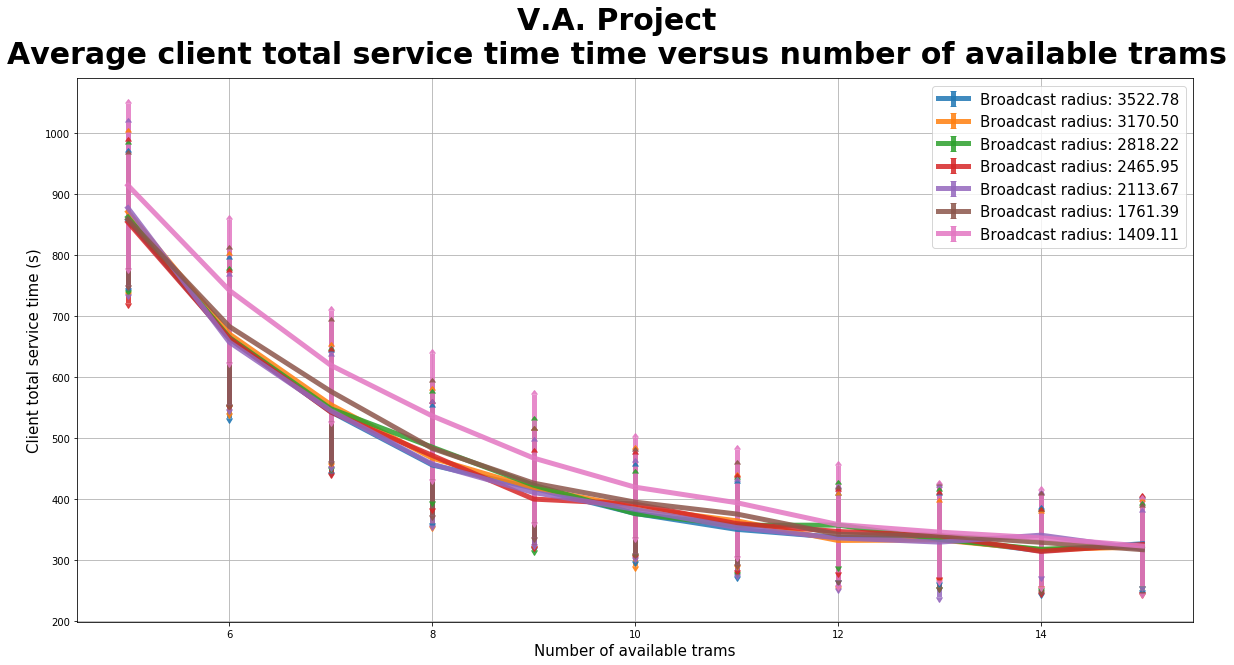

,3522 (1),3170 (0.9),2818 (0.8),2465 (0.7),2113 (0.6),1761 (0.5),1409 (0.4)
5,857.79 +- 110.93,871.17 +- 130.85,862.32 +- 119.87,854.37 +- 133.31,877.59 +- 140.68,858.97 +- 107.42,914.72 +- 134.95
6,663.53 +- 130.66,671.10 +- 129.39,665.24 +- 111.17,663.90 +- 109.07,657.70 +- 109.10,683.30 +- 126.49,742.55 +- 116.71
7,543.72 +- 98.07,555.19 +- 95.78,548.54 +- 95.55,543.26 +- 100.16,545.34 +- 90.08,577.06 +- 114.88,619.80 +- 91.19
8,456.40 +- 95.20,467.67 +- 112.02,485.60 +- 88.63,472.04 +- 85.64,457.84 +- 99.92,483.61 +- 109.15,536.74 +- 102.86
9,418.28 +- 95.88,418.73 +- 94.95,423.28 +- 106.16,400.52 +- 77.13,411.30 +- 84.43,426.62 +- 87.67,467.68 +- 104.60
10,376.98 +- 78.52,386.59 +- 95.59,376.67 +- 66.22,392.41 +- 82.79,383.67 +- 77.69,395.55 +- 83.02,420.04 +- 82.22
11,350.91 +- 76.42,364.92 +- 72.97,357.50 +- 76.71,360.30 +- 76.79,353.86 +- 75.98,376.12 +- 82.13,394.64 +- 88.02
12,337.60 +- 70.20,332.72 +- 74.30,357.90 +- 67.35,347.43 +- 66.04,336.87 +- 82.38,342.66 +- 74.54,358.79 +- 98.23
13,336.05 +- 70.83,333.67 +- 61.96,334.49 +- 78.59,340.56 +- 68.44,330.01 +- 90.07,340.51 +- 83.84,346.40 +- 78.70
14,315.67 +- 68.39,317.61 +- 59.39,318.31 +- 62.83,314.72 +- 66.06,341.39 +- 66.93,329.65 +- 78.16,337.01 +- 79.17


In [12]:
# Average delivery time plot

fig = plt.figure(figsize=(20, 10))
fig.suptitle("V.A. Project\nAverage client total service time time versus number of available trams", fontweight='bold', fontsize=30)
ax = fig.add_subplot(1, 1, 1)
table = {}

for clientRange in c_radius:
    idx = "{:02d} ({})".format( int(map_size*clientRange), clientRange )
    table[idx] = []
    for i in range(len(n_trains)):
        table[idx] += [ "{:.2f} +- {:.2f}".format(m_del_time[clientRange][i], d_del_time[clientRange][i]) ]
    ax.errorbar(n_trains, m_del_time[clientRange], yerr=d_del_time[clientRange],
                linewidth=5, alpha=.85,
                # marker='o', ms=10, mec='k', mew=.5, 
                uplims=True, lolims=True,
                label = "Broadcast radius: {:.2f}".format(map_size*clientRange))

plt.xlabel("Number of available trams", fontsize=15)
plt.ylabel("Client total service time (s)", fontsize=15)
plt.grid(True)

plt.legend(loc=1, prop={'size': 15})
plt.show()

# Table
tab = pd.DataFrame(table, index=n_trains)
tab

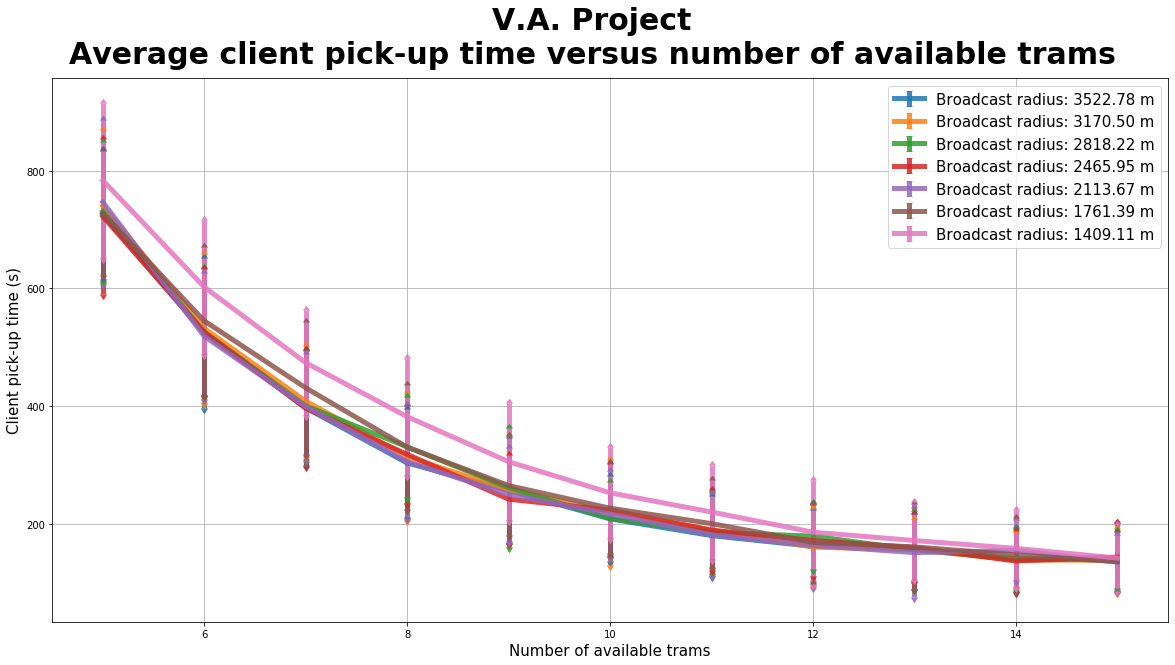

,3522 (1),3170 (0.9),2818 (0.8),2465 (0.7),2113 (0.6),1761 (0.5),1409 (0.4)
5,726.01 +- 109.53,740.12 +- 129.26,730.77 +- 118.25,722.33 +- 131.87,746.39 +- 139.18,727.76 +- 105.14,783.34 +- 131.61
6,524.36 +- 127.80,532.00 +- 126.88,525.75 +- 108.08,525.51 +- 107.37,518.70 +- 107.02,544.79 +- 124.99,602.24 +- 113.56
7,397.20 +- 97.69,408.41 +- 93.12,400.52 +- 93.35,396.49 +- 98.65,399.37 +- 88.56,431.06 +- 112.43,473.71 +- 89.31
8,303.43 +- 91.25,314.31 +- 107.09,330.84 +- 84.81,318.16 +- 81.85,305.69 +- 96.38,330.25 +- 104.91,382.06 +- 99.75
9,256.90 +- 89.77,257.84 +- 90.94,261.88 +- 100.75,242.00 +- 74.92,250.40 +- 78.83,265.15 +- 83.73,305.66 +- 99.63
10,208.61 +- 72.00,219.84 +- 88.94,209.13 +- 62.23,223.55 +- 77.76,216.83 +- 72.46,226.73 +- 76.52,252.83 +- 77.13
11,180.18 +- 68.07,189.90 +- 65.06,185.69 +- 69.31,189.38 +- 68.24,181.55 +- 69.05,200.55 +- 74.37,220.22 +- 79.52
12,161.96 +- 62.40,160.69 +- 64.26,179.31 +- 56.19,171.73 +- 60.69,163.58 +- 70.62,168.79 +- 65.11,185.95 +- 88.70
13,158.56 +- 57.66,156.00 +- 52.07,156.07 +- 66.27,159.72 +- 56.53,151.26 +- 75.46,161.03 +- 72.19,171.82 +- 65.73
14,139.15 +- 53.88,139.07 +- 46.17,140.71 +- 50.93,136.98 +- 50.38,155.15 +- 51.14,147.51 +- 63.01,158.50 +- 65.60


In [13]:
# Average total waiting time plot

fig = plt.figure(figsize=(20, 10))
fig.suptitle("V.A. Project\nAverage client pick-up time versus number of available trams", fontweight='bold', fontsize=30)
ax = fig.add_subplot(1, 1, 1)
table = {}

for clientRange in c_radius:
    idx = "{:02d} ({})".format( int(map_size*clientRange), clientRange )
    table[idx] = []
    for i in range(len(n_trains)):
        table[idx] += [ "{:.2f} +- {:.2f}".format(m_wait_time[clientRange][i], d_wait_time[clientRange][i]) ]
    ax.errorbar(n_trains, m_wait_time[clientRange], yerr=d_wait_time[clientRange],
                linewidth=5, alpha=.85,
                # marker='o', ms=10, mec='k', mew=.5, 
                uplims=True, lolims=True,
                label = "Broadcast radius: {:.2f} m".format(map_size*clientRange))

plt.xlabel("Number of available trams", fontsize=15)
plt.ylabel("Client pick-up time (s)", fontsize=15)
plt.grid(True)

plt.legend(loc=1, prop={'size': 15})
plt.show()

# Table
tab = pd.DataFrame(table, index=n_trains)
tab

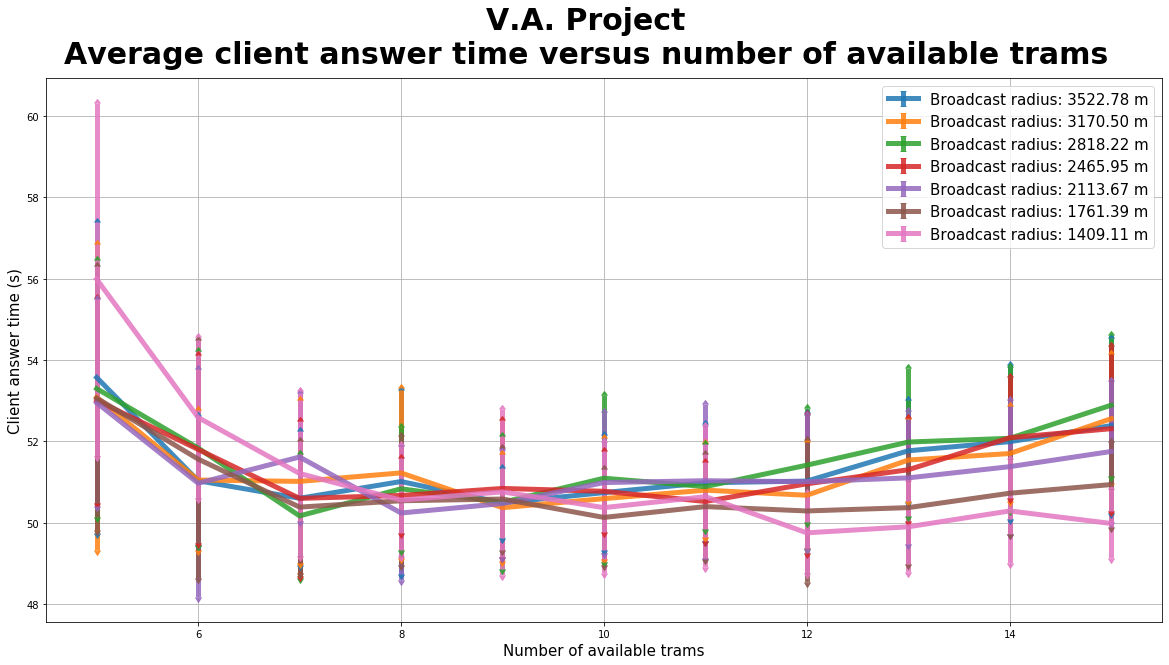

,3522 (1),3170 (0.9),2818 (0.8),2465 (0.7),2113 (0.6),1761 (0.5),1409 (0.4)
5,53.57 +- 3.83,53.09 +- 3.76,53.30 +- 3.17,53.01 +- 2.52,52.95 +- 2.54,53.06 +- 3.25,55.99 +- 4.33
6,51.03 +- 1.59,51.05 +- 1.71,51.84 +- 2.38,51.80 +- 2.31,50.97 +- 2.80,51.57 +- 2.93,52.59 +- 1.98
7,50.60 +- 1.65,51.02 +- 2.00,50.17 +- 1.53,50.60 +- 1.90,51.62 +- 1.58,50.39 +- 1.63,51.21 +- 2.02
8,51.01 +- 2.26,51.23 +- 2.10,50.84 +- 1.52,50.67 +- 0.92,50.24 +- 1.65,50.54 +- 1.59,50.56 +- 1.36
9,50.49 +- 0.87,50.37 +- 1.31,50.50 +- 1.64,50.84 +- 1.69,50.47 +- 1.32,50.58 +- 1.25,50.76 +- 2.03
10,50.74 +- 1.41,50.59 +- 1.48,51.10 +- 2.05,50.77 +- 1.00,50.99 +- 1.74,50.13 +- 1.18,50.37 +- 1.61
11,50.98 +- 1.44,50.80 +- 1.15,50.89 +- 1.04,50.52 +- 0.98,51.03 +- 1.90,50.40 +- 1.28,50.64 +- 1.74
12,51.02 +- 1.67,50.68 +- 1.30,51.42 +- 1.41,50.96 +- 1.71,51.01 +- 1.64,50.29 +- 1.74,49.75 +- 0.98
13,51.77 +- 1.26,51.54 +- 1.00,51.98 +- 1.82,51.30 +- 1.26,51.10 +- 1.63,50.37 +- 1.38,49.90 +- 1.12
14,51.99 +- 1.89,51.70 +- 1.16,52.08 +- 1.76,52.09 +- 1.49,51.38 +- 1.65,50.73 +- 0.99,50.29 +- 1.28


In [14]:
# Average train assignment time plot

fig = plt.figure(figsize=(20, 10))
fig.suptitle("V.A. Project\nAverage client answer time versus number of available trams", fontweight='bold', fontsize=30)
ax = fig.add_subplot(1, 1, 1)
table = {}

for clientRange in c_radius:
    idx = "{:02d} ({})".format( int(map_size*clientRange), clientRange )
    table[idx] = []
    for i in range(len(n_trains)):
        table[idx] += [ "{:.2f} +- {:.2f}".format(m_answ_time[clientRange][i], d_answ_time[clientRange][i]) ]
    ax.errorbar(n_trains, m_answ_time[clientRange], yerr=d_answ_time[clientRange],
                linewidth=5, alpha=.85,
                # marker='o', ms=10, mec='k', mew=.5, 
                uplims=True, lolims=True,
                label = "Broadcast radius: {:.2f} m".format(map_size*clientRange))

plt.xlabel("Number of available trams", fontsize=15)
plt.ylabel("Client answer time (s)", fontsize=15)
plt.grid(True)

plt.legend(loc=1, prop={'size': 15})
plt.show()

# Table
tab = pd.DataFrame(table, index=n_trains)
tab

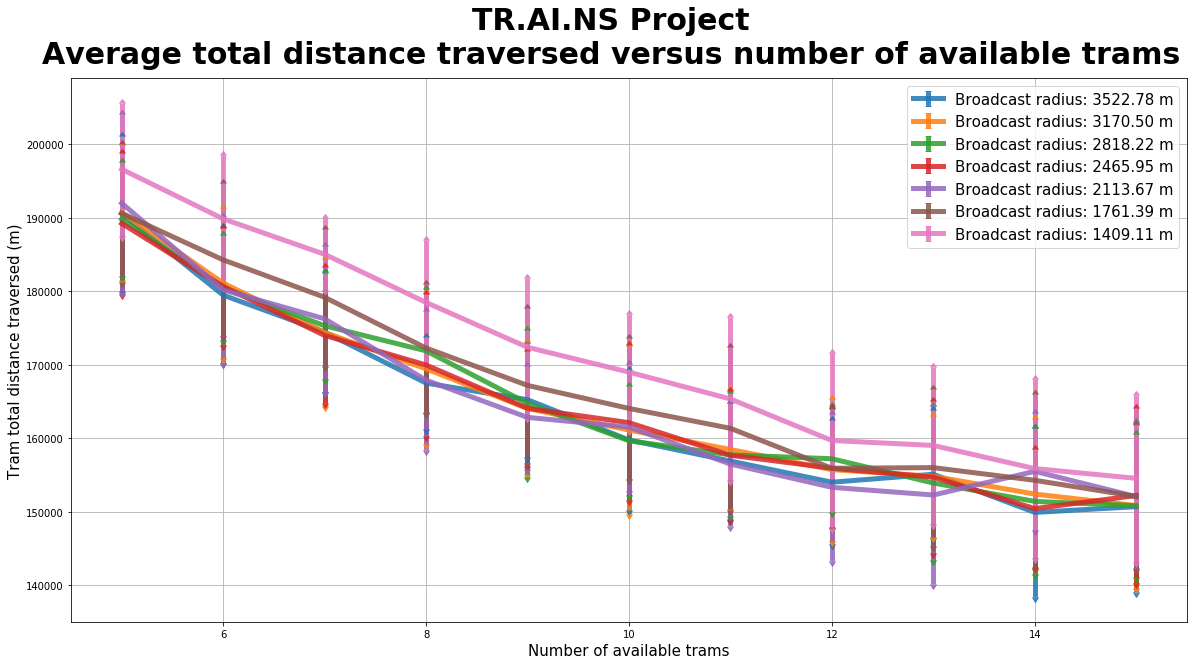

,3522 (1),3170 (0.9),2818 (0.8),2465 (0.7),2113 (0.6),1761 (0.5),1409 (0.4)
5,(190.6 +- 10.5) 10^3,(190.7 +- 9.1) 10^3,(189.8 +- 7.7) 10^3,(189.2 +- 9.6) 10^3,(192.0 +- 12.1) 10^3,(190.6 +- 9.4) 10^3,(196.6 +- 9.0) 10^3
6,(179.5 +- 9.3) 10^3,(181.1 +- 10.2) 10^3,(180.5 +- 7.1) 10^3,(180.7 +- 7.9) 10^3,(180.2 +- 10.0) 10^3,(184.3 +- 10.4) 10^3,(189.9 +- 8.7) 10^3
7,(174.5 +- 8.1) 10^3,(174.4 +- 10.0) 10^3,(175.3 +- 7.2) 10^3,(174.0 +- 9.3) 10^3,(176.3 +- 9.9) 10^3,(179.2 +- 9.3) 10^3,(185.0 +- 4.9) 10^3
8,(167.5 +- 6.2) 10^3,(169.5 +- 10.2) 10^3,(171.9 +- 8.4) 10^3,(170.0 +- 9.7) 10^3,(167.9 +- 9.5) 10^3,(172.3 +- 8.7) 10^3,(178.5 +- 8.5) 10^3
9,(165.3 +- 7.7) 10^3,(164.1 +- 9.0) 10^3,(164.8 +- 10.0) 10^3,(164.1 +- 7.8) 10^3,(162.9 +- 7.0) 10^3,(167.2 +- 10.5) 10^3,(172.4 +- 9.5) 10^3
10,(159.8 +- 9.5) 10^3,(161.1 +- 11.4) 10^3,(159.7 +- 7.4) 10^3,(162.1 +- 10.6) 10^3,(161.5 +- 8.6) 10^3,(164.1 +- 9.6) 10^3,(169.0 +- 7.9) 10^3
11,(156.9 +- 7.9) 10^3,(158.5 +- 8.1) 10^3,(157.8 +- 8.4) 10^3,(157.7 +- 8.7) 10^3,(156.5 +- 8.4) 10^3,(161.4 +- 11.1) 10^3,(165.4 +- 11.1) 10^3
12,(154.0 +- 8.5) 10^3,(155.8 +- 9.7) 10^3,(157.2 +- 7.2) 10^3,(155.9 +- 8.2) 10^3,(153.3 +- 10.0) 10^3,(155.9 +- 8.0) 10^3,(159.7 +- 11.9) 10^3
13,(155.1 +- 8.7) 10^3,(154.8 +- 8.3) 10^3,(153.9 +- 10.5) 10^3,(154.7 +- 10.3) 10^3,(152.3 +- 12.1) 10^3,(156.0 +- 10.6) 10^3,(159.0 +- 10.7) 10^3
14,(149.9 +- 11.5) 10^3,(152.4 +- 10.2) 10^3,(151.4 +- 9.9) 10^3,(150.4 +- 8.1) 10^3,(155.5 +- 8.0) 10^3,(154.3 +- 11.8) 10^3,(155.9 +- 12.1) 10^3


In [15]:
# Total distance run

fig = plt.figure(figsize=(20, 10))
fig.suptitle("TR.AI.NS Project\nAverage total distance traversed versus number of available trams", fontweight='bold', fontsize=30)
ax = fig.add_subplot(1, 1, 1)
table = {}

for clientRange in c_radius:
    idx = "{:02d} ({})".format( int(map_size*clientRange), clientRange )
    table[idx] = []
    for i in range(len(n_trains)):
        table[idx] += [ "({:.1f} +- {:.1f}) 10^3".\
                       format(m_train_dist[clientRange][i]/1000, d_train_dist[clientRange][i]/1000) ]
    ax.errorbar(n_trains, m_train_dist[clientRange], yerr=d_train_dist[clientRange], 
                linewidth=5, alpha=.85,
                # marker='o', ms=10, mec='k', mew=.5, 
                uplims=True, lolims=True,
                label = "Broadcast radius: {:.2f} m".format(map_size*clientRange))

plt.xlabel("Number of available trams", fontsize=15)
plt.ylabel("Tram total distance traversed (m)", fontsize=15)
plt.grid(True)

plt.legend(loc=1, prop={'size': 15})
plt.show()

# Table
tab = pd.DataFrame(table, index=n_trains)
tab

<!--- What we can mostly observe by these graphs is that above a certain radius, the broadcast read does not have much influence over neither the distance overrun by trains nor the time waited by the clients. --->

<!--- The total waiting time until the client pick-up noticeably suffers performance when the radius decreases to 1400m and below. But over that threshold the difference in performances is heavily dwarfed by the measurement uncertainties, which are inherent in the system operation implemented. These results lead us to believe that a wide radius is not inherent for the system to function efficiently. Although not represented here, the tests made also point to the fact that a small radius is prohibitive to its functioning at all, since the non answer of a client is considered as a system failure. --->

<!--- The total waiting time until the client is answered does not appear to be highly dependent on neither the number of trains nor the broadcast radius, even though the small broadcast radius leads to a slight up drift in the curve. As in the case of the other time measurement, this can be explained by the supposition that some clients sometimes were left too far away from all the available trains for the smaller broadcast radius to reach them for an extended amount of time. --->

<!--- The total distance run by trains does not show apparent dependence on the broadcast radius data. However, is shows a slight decrease with the increase of the number of trains. There would need to be an analysis, though, of what would generate the smaller cost: higher number of trains that run a smaller distance or smaller number of trains that run a bigger distance. It is my belief that the most probable is the second case, since the distances are still subjected to such a high standard deviation that its gain is very much of a gamble as of right now. --->

<!--- #### Note: 
<!--- I would have assumed it's better to have less trains because they should be more expensive themselves than the costs involved in moving them. However this movement cost should consider that the train will be used for a very long time, and so using them less might just compensate the cost of acquiring a new train over the span of a long time. As I stated, a more detailed study would be needed to ascertain this. --->

___

<!--- This final plots show the client arrival distribution along all the simulations performed ($7 \times 7 \times 60 = 2940$ simulation, each with 15 clients created before they stopped appearing). The left plot shows the time distribution and the right one the space distribution. --->

<!--- One can see that the distribution between the available stopping points is uniform. The time appearance, however, begins uniformly and then decreases with time. Such behavior can be explained due to the fact that the client arrival is artificially stopped after 15 clients are created for the purpose of these simulations. --->

# Optimization

{'lambda': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1, 1.5, 2, 3, 4, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 100], 'nT': [14, 14, 14, 14, 14, 15, 15, 15, 12, 12, 12, 12, 10, 9, 9, 7, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5], 'cR': [0.7, 0.7, 0.7, 0.7, 0.7, 0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4], 'tR': [7397.837999999999, 7397.837999999999, 7397.837999999999, 7397.837999999999, 7397.837999999999, 5284.17, 4227.336000000001, 4227.336000000001, 4227.336000000001, 4227.336000000001, 4227.336000000001, 4227.336000000001, 4227.336000000001, 4227.336000000001, 4227.336000000001, 4227.336000000001, 4227.336000000001, 4227.336000000001, 4227.336000000001, 4227.336000000001, 4227.336000000001, 4227.336000000001, 4227.336000000001, 4227.336000000001, 4227.336000000001, 4227.336000000001], 'value': [314.79074166666663, 315.45741666666663, 318.42041666666665, 322.12416666666667, 351.75416666666666, 388.02250000000004, 526.92500

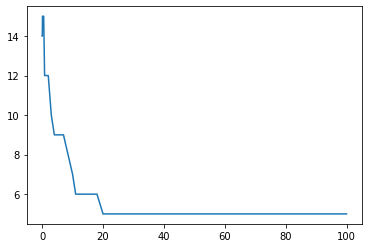

In [18]:
# Parâmetros de otimização

a0 = 0
a1 = 100
a2 = 20
a3 = 0.1

lambdas = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1, 1.5, 2, 3, 4, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 100]


# Otimização, para o modo "multiple clients" para os diferentes valores de lambda

otimizacao = {'lambda': [], 'nT': [], 'cR': [], 'tR': [], 'value': []}


for l in range(len(lambdas)):
    otimizacao['lambda'] += [lambdas[l]]
    otimizacao['nT'] += [None]
    otimizacao['cR'] += [None]
    otimizacao['tR'] += [None]
    otimizacao['value'] += [999999999999999999999]
    for cliR in c_radius:
        trR = 3*cliR
        for i in range(len(n_trains)):
            custo = a0 + a1*trR + a2*n_trains[i] + a3*m_train_dist[cliR][i]/float(total_clients_finished)
            qualidade = m_del_time[cliR][i]
            valor = qualidade + lambdas[l]*custo
            
            if valor < otimizacao['value'][l]:
                otimizacao['nT'][l] = n_trains[i]
                otimizacao['tR'][l] = trR*map_size
                otimizacao['cR'][l] = cliR
                otimizacao['value'][l] = valor
                
plt.plot(lambdas, otimizacao['nT'], label='Number of trams')
#plt.plot(lambdas, otimizacao['tR'], label='Tram broadcst radius')
print(otimizacao)

In [19]:
tab = pd.DataFrame(otimizacao)
tab

,lambda,nT,cR,tR,value
0,0.0001,14,0.7,7397.838,314.790742
1,0.0010,14,0.7,7397.838,315.457417
2,0.0050,14,0.7,7397.838,318.420417
3,0.0100,14,0.7,7397.838,322.124167
4,0.0500,14,0.7,7397.838,351.754167
5,0.1000,15,0.5,5284.170,388.022500
6,0.3000,15,0.4,4227.336,526.925000
7,0.5000,15,0.4,4227.336,662.446667
8,0.8000,12,0.4,4227.336,859.738333
9,1.0000,12,0.4,4227.336,984.975000
